/home/andres/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1517: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/andres/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1491: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/andres/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1504: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, 


Mean testing time per volume: 3.7158357097256567 seconds



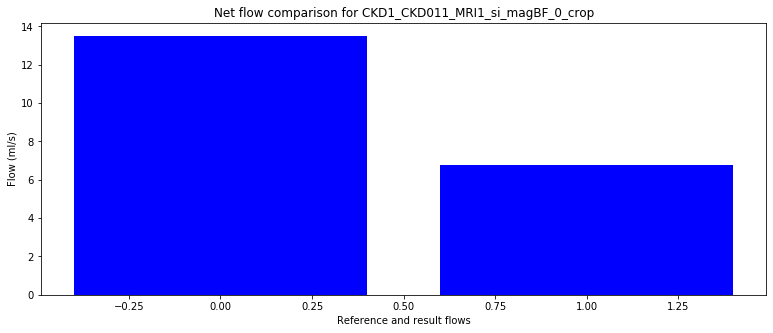

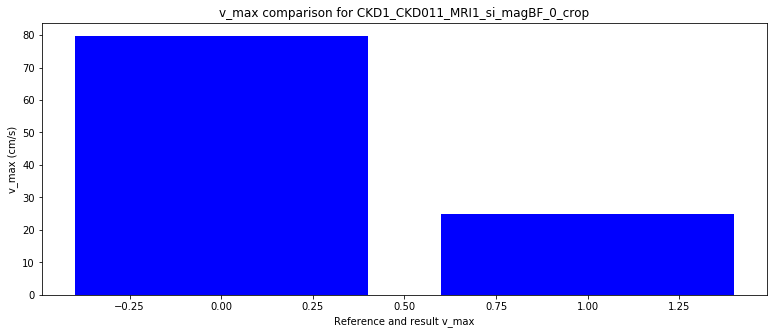

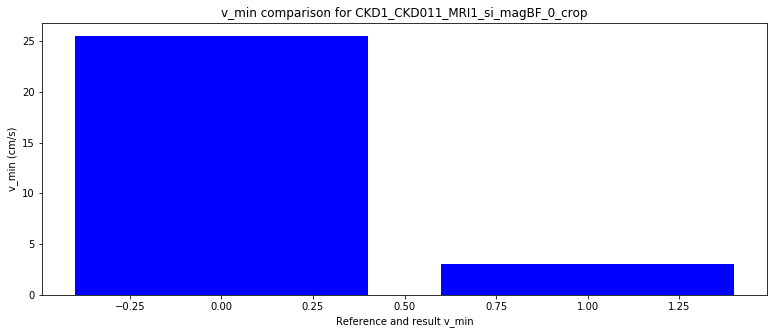

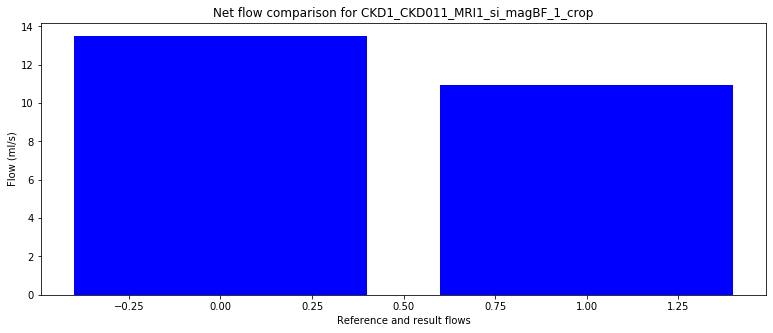

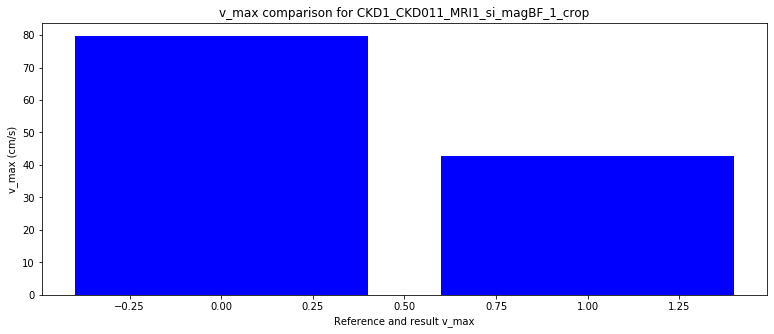

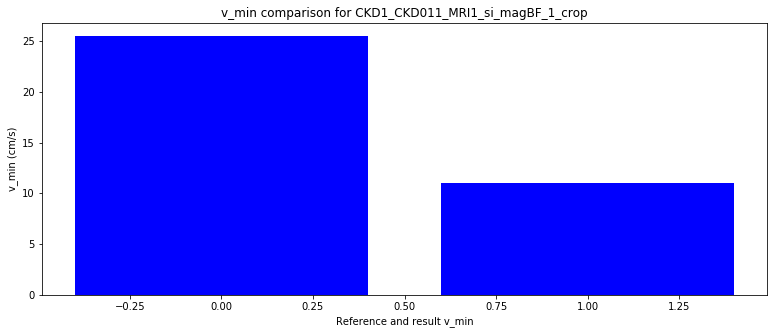

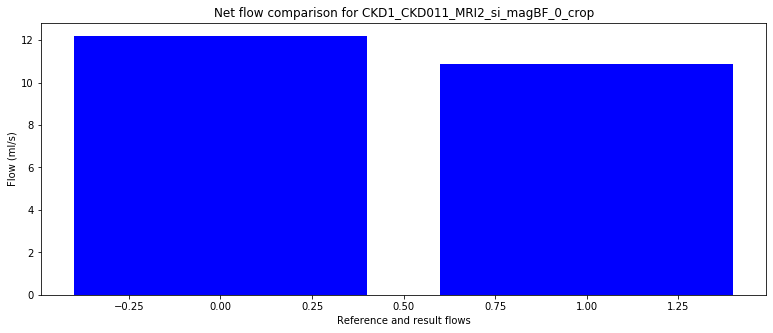

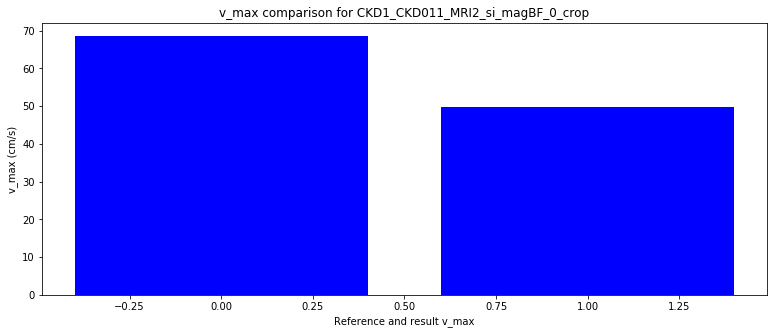

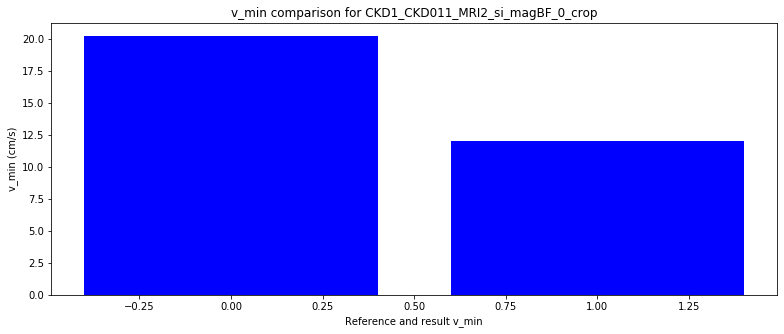

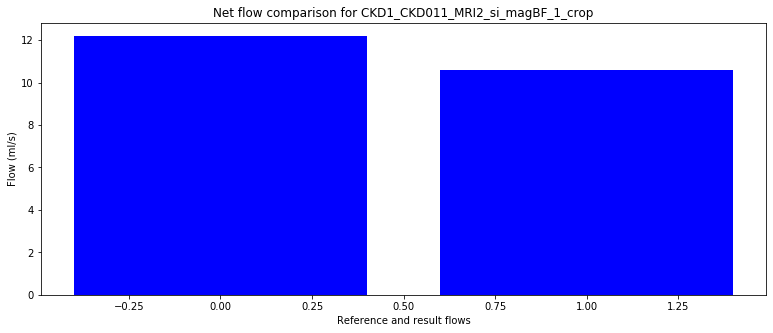

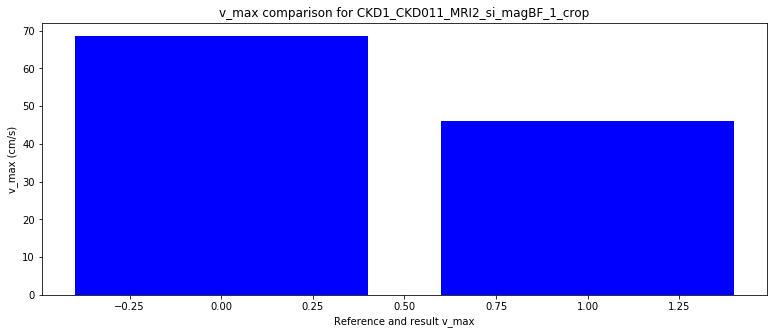

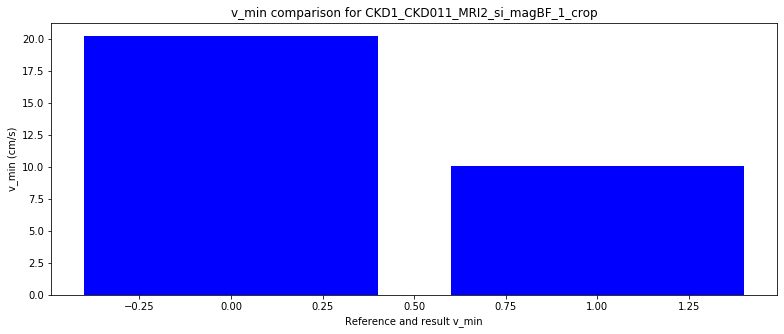

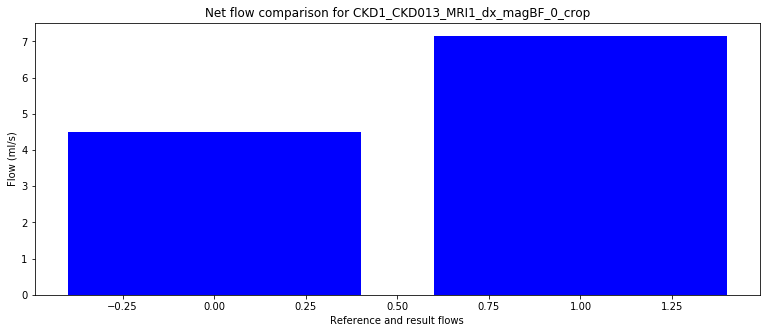

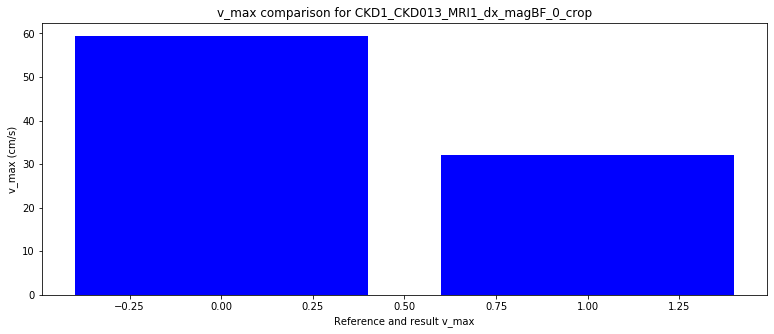

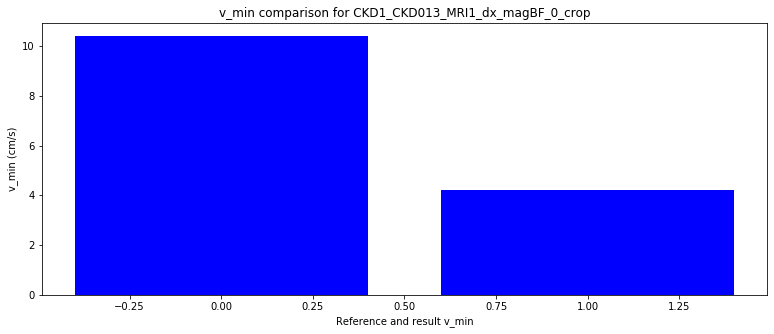

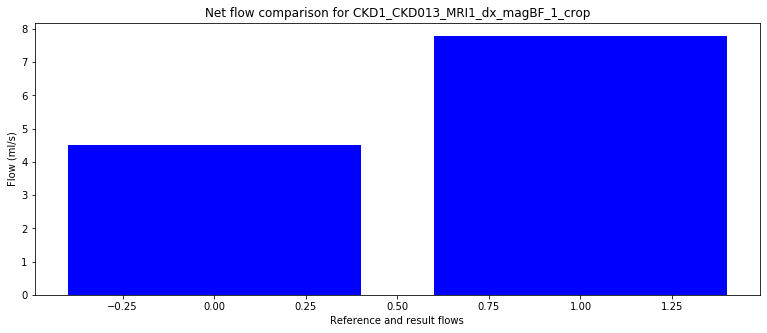

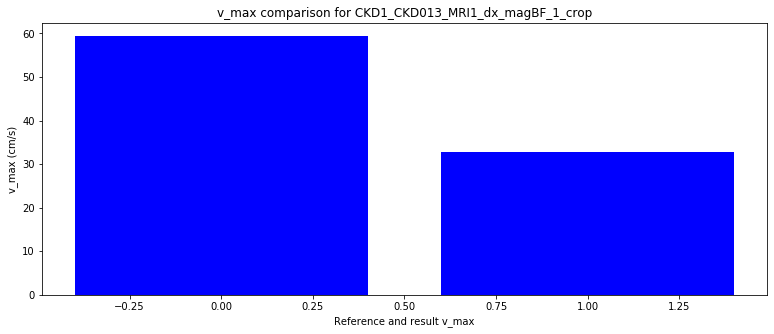

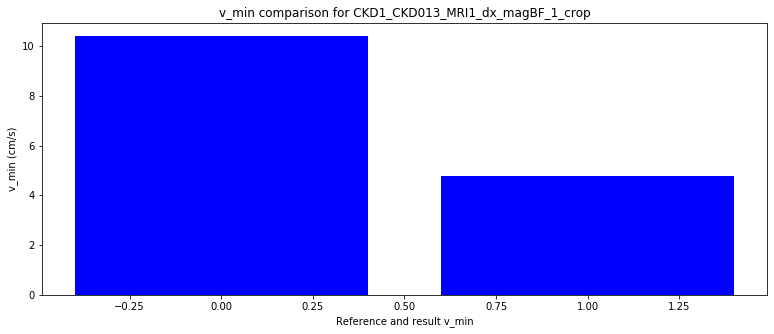

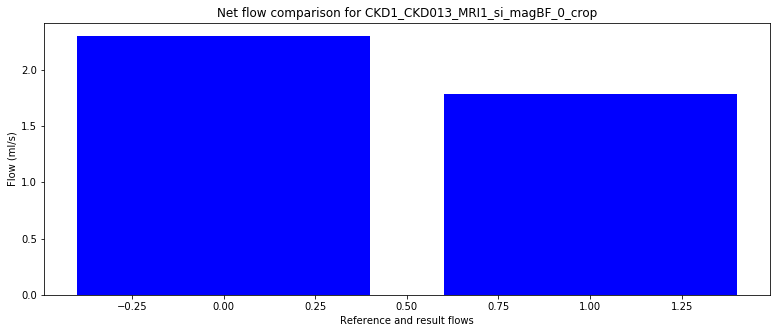

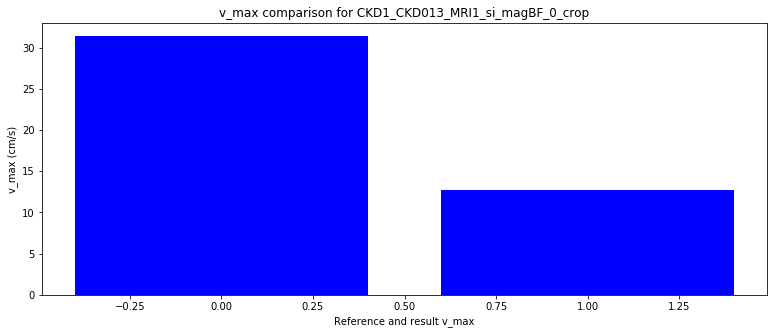

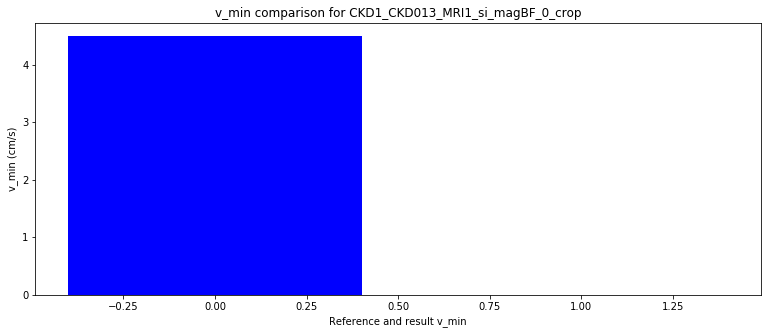

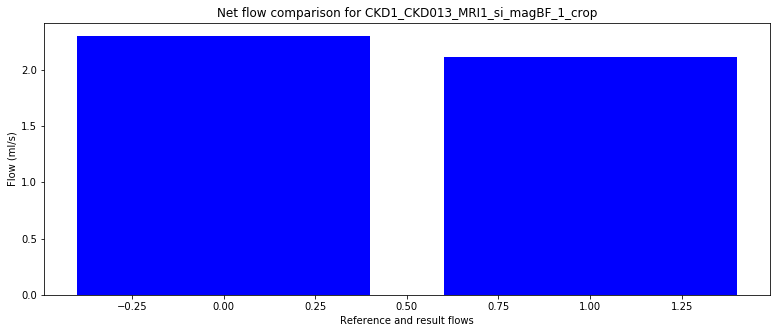

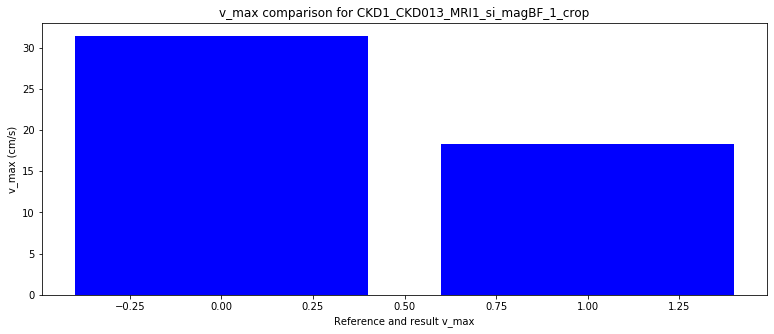

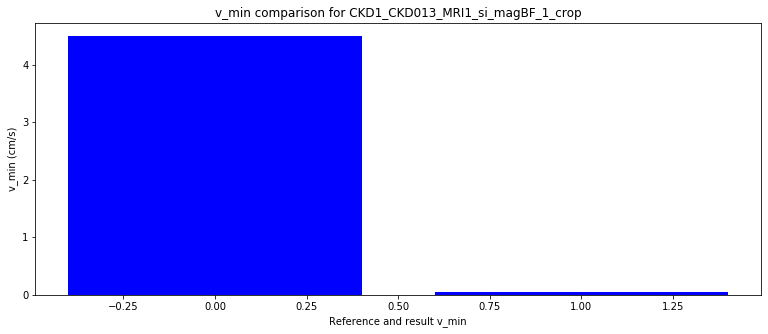

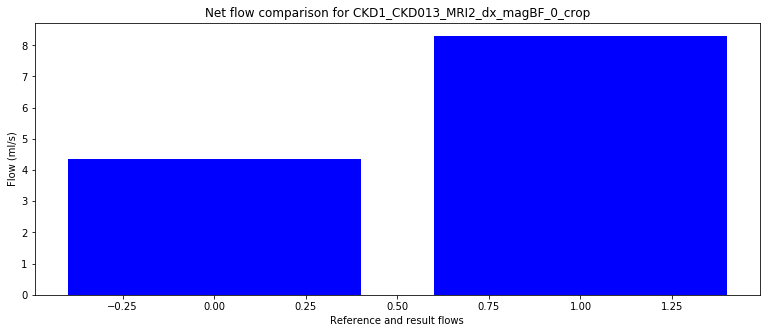

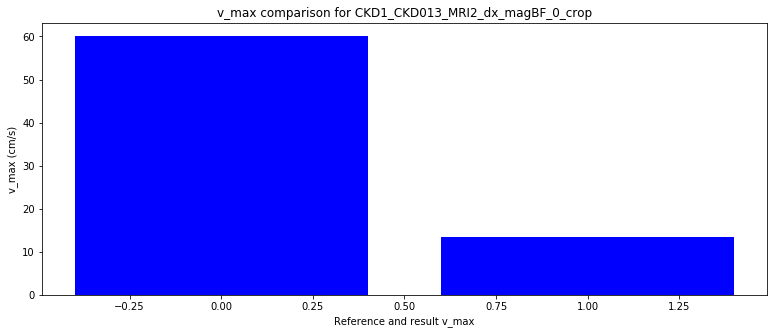

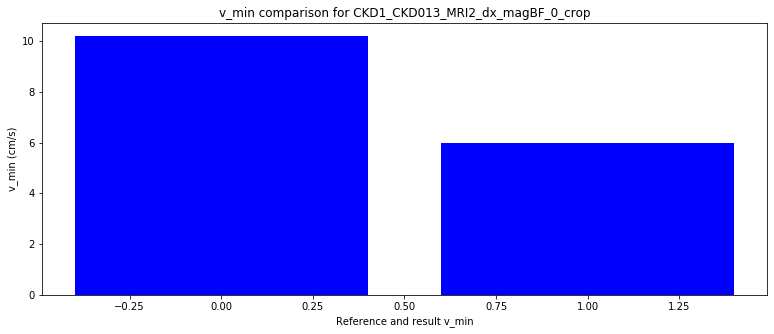

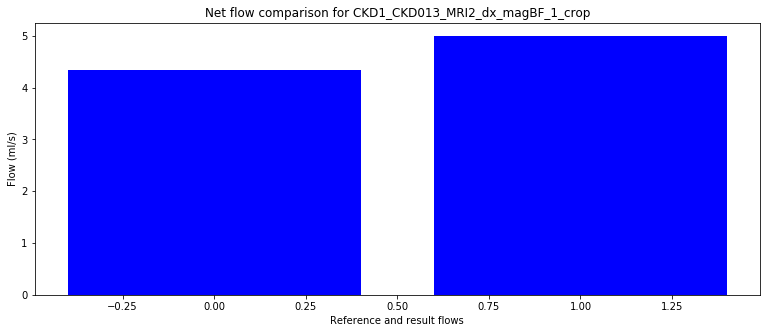

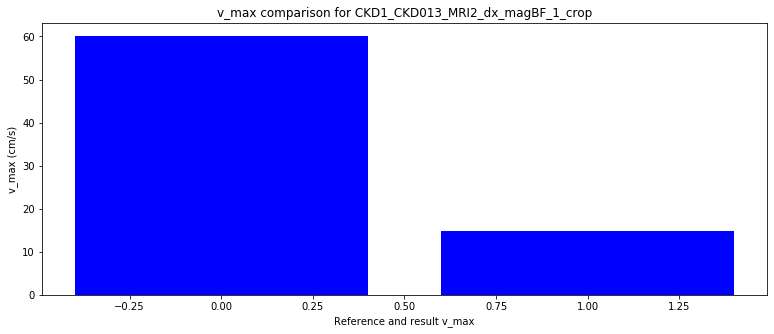

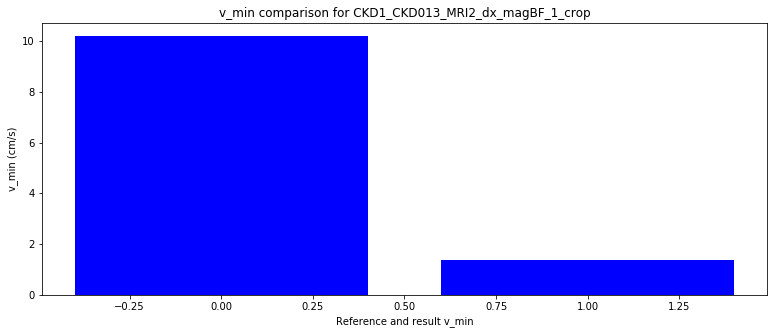

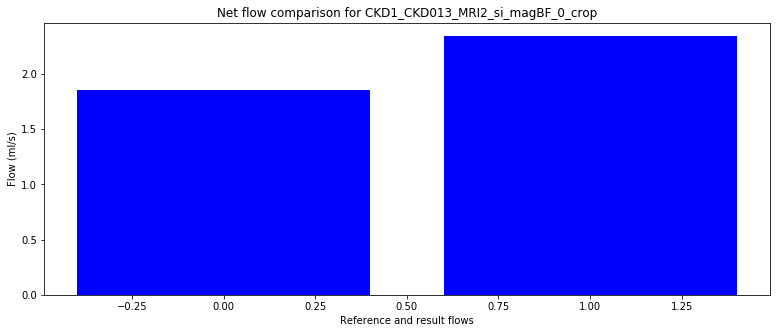

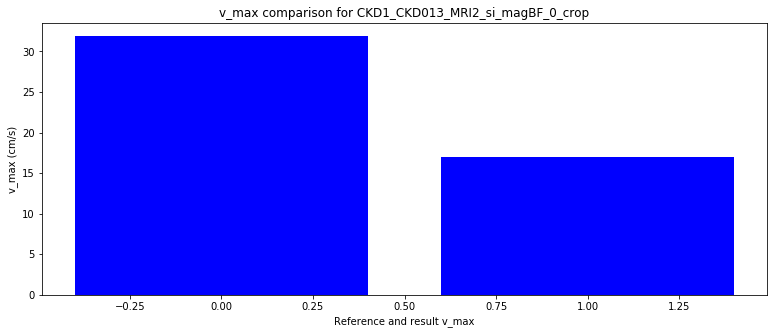

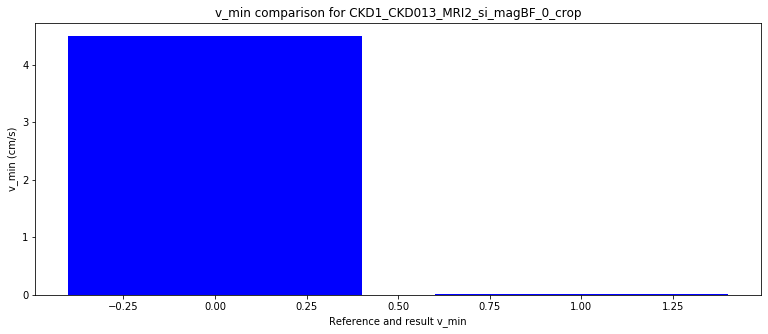

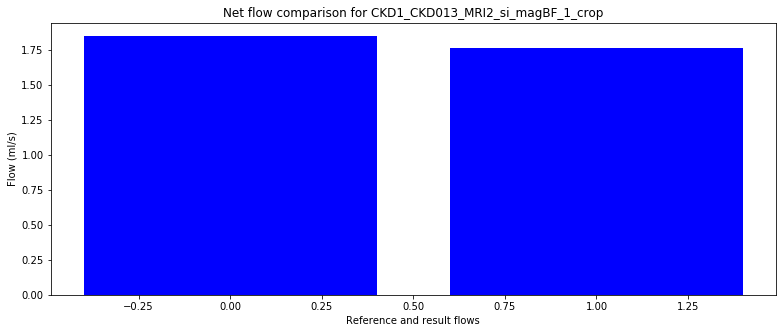

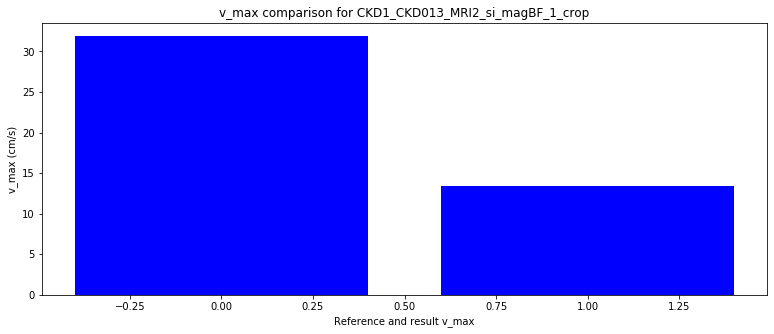

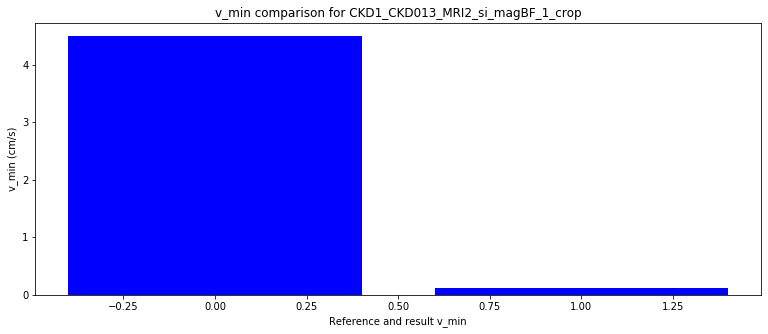

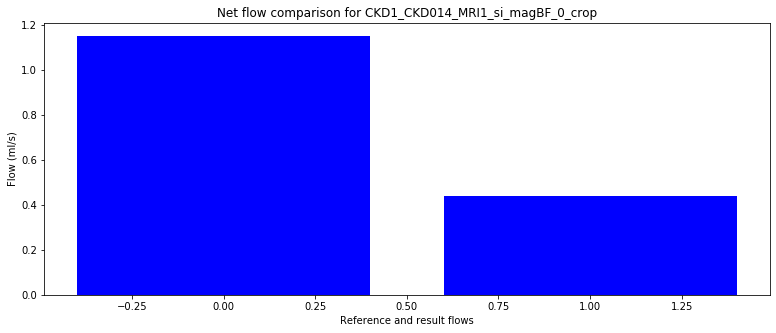

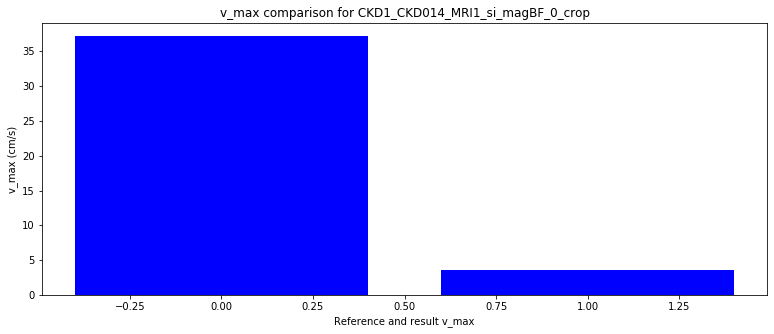

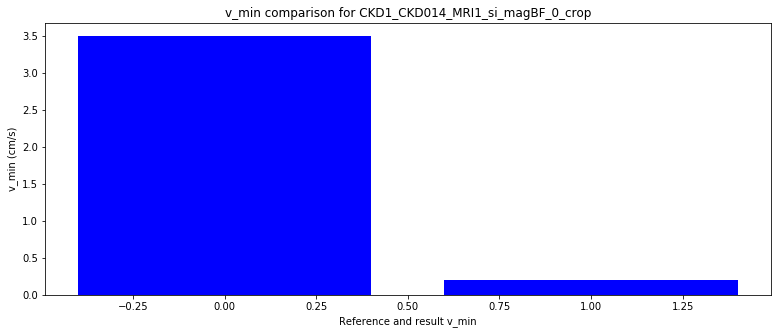

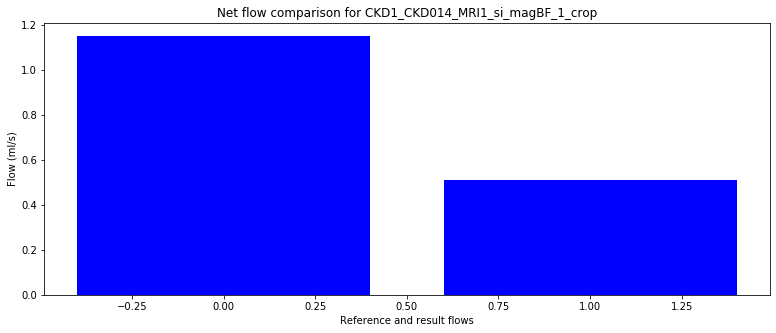

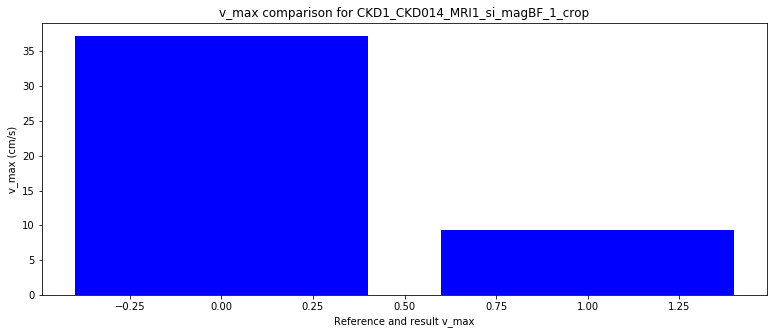

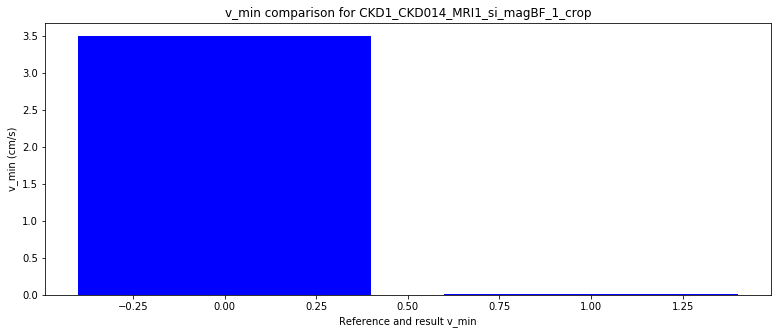

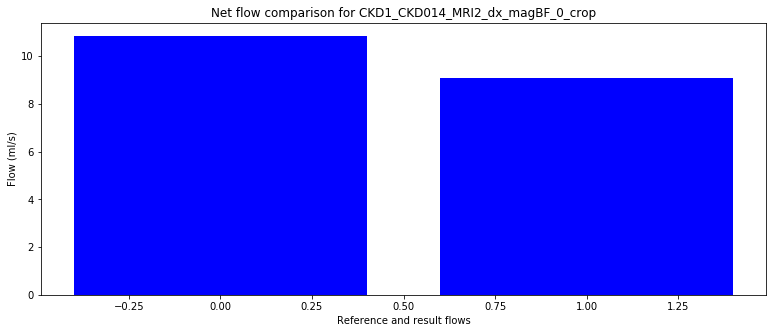

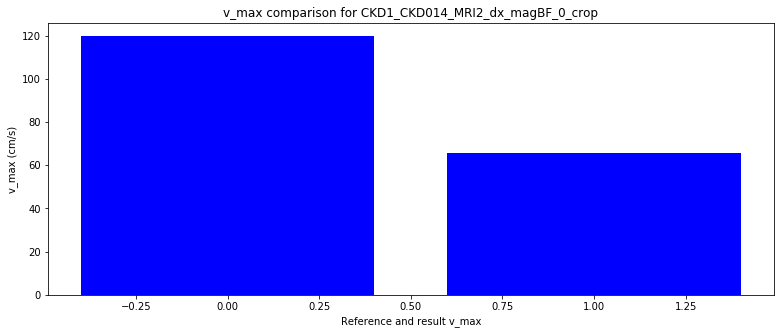

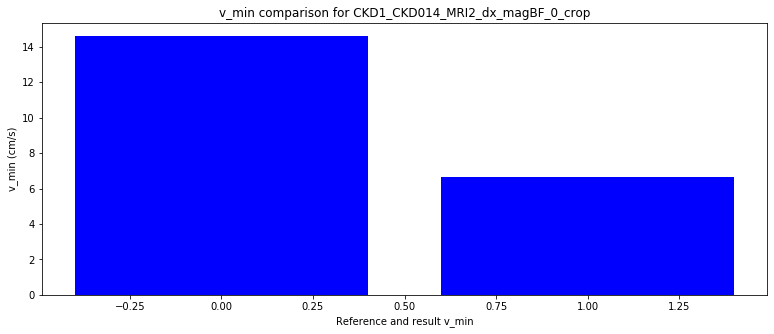

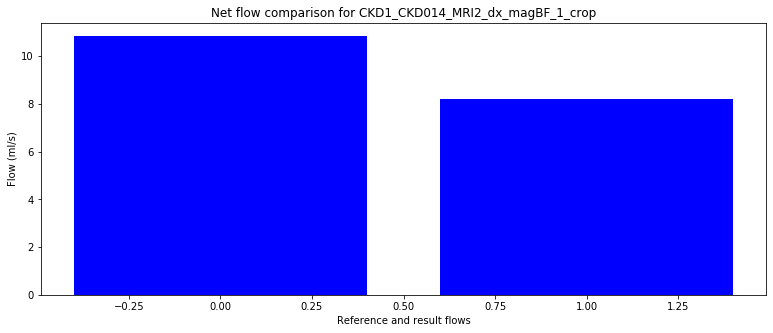

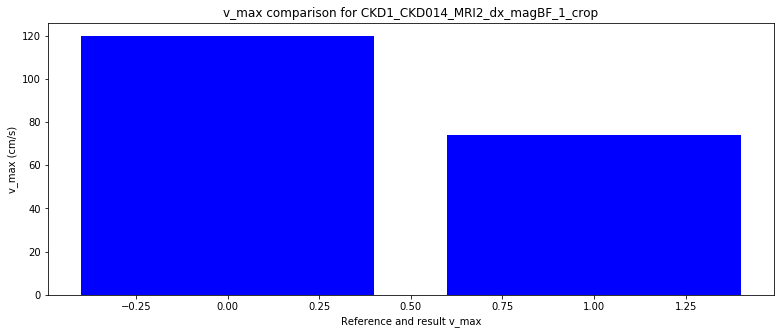

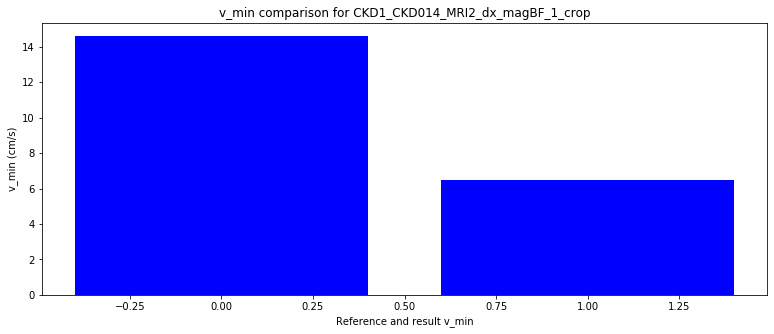

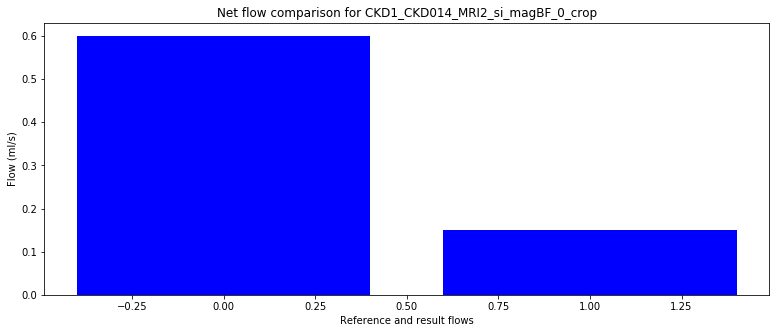

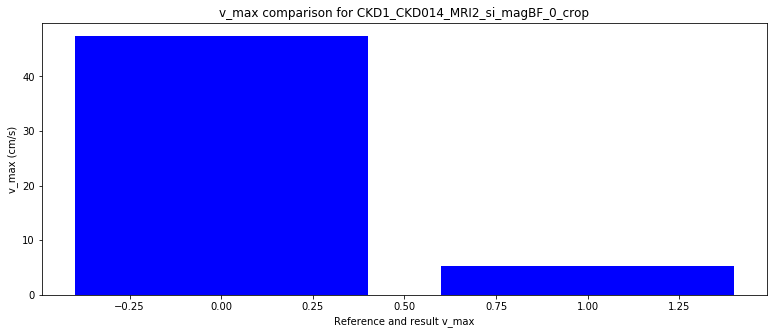

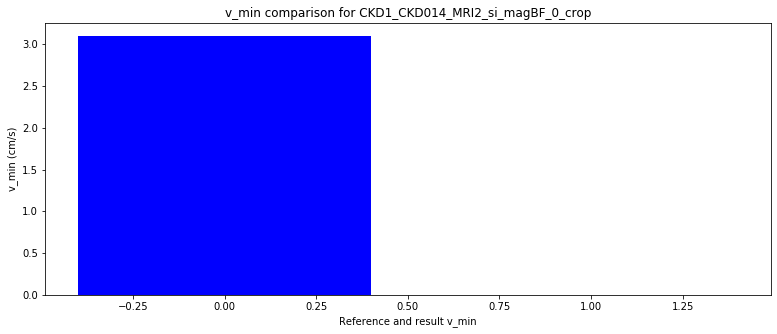

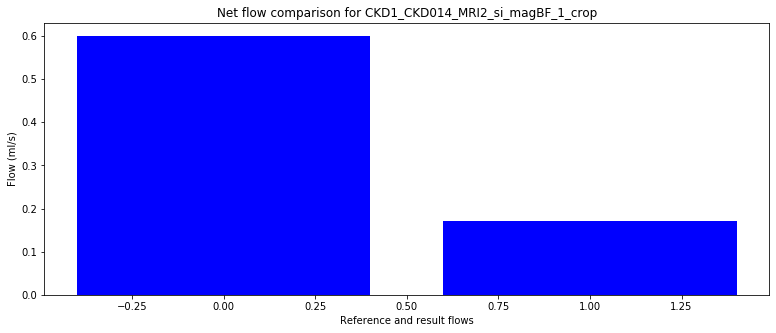

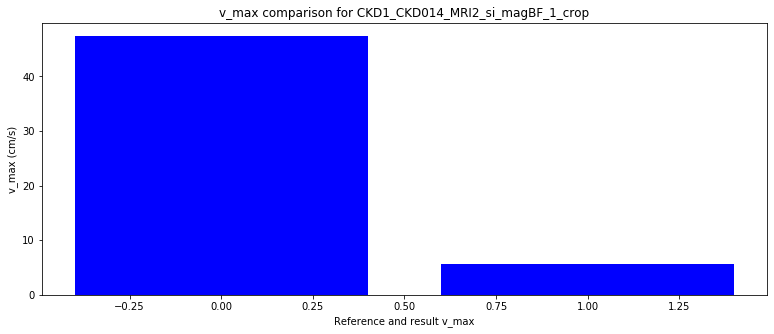

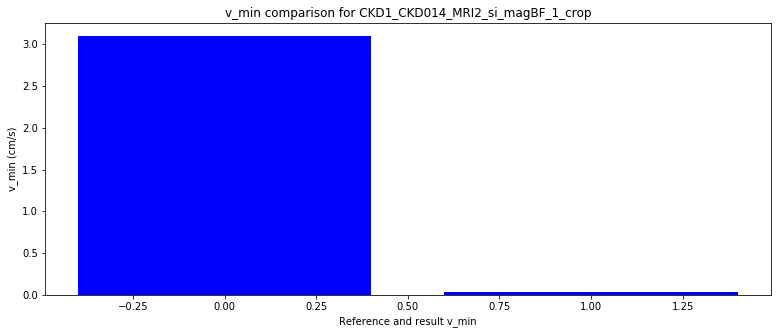

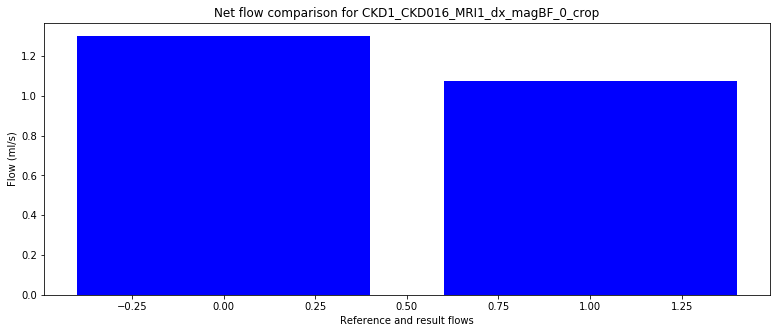

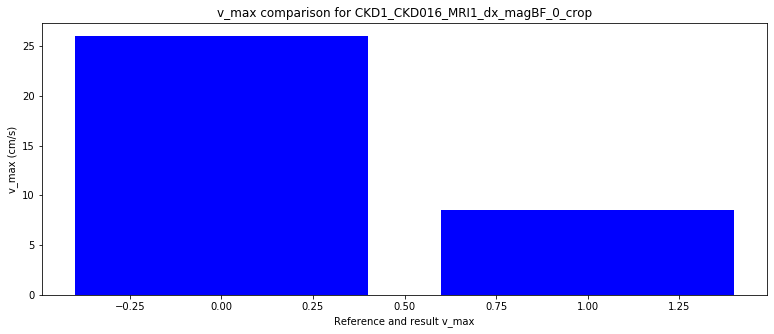

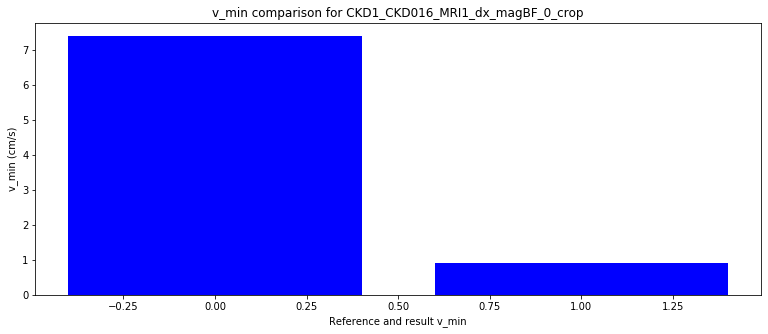

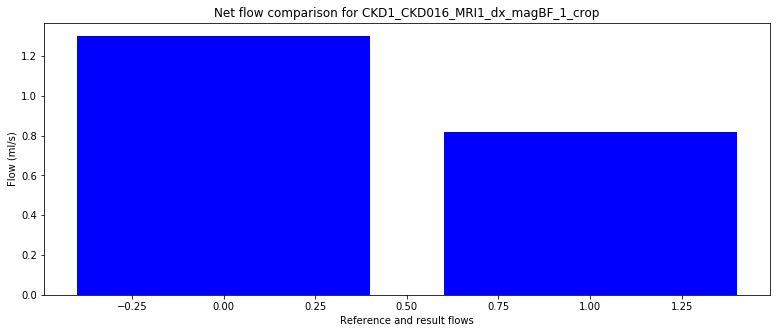

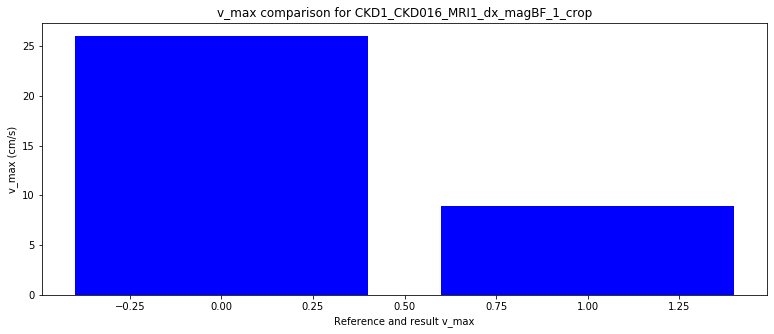

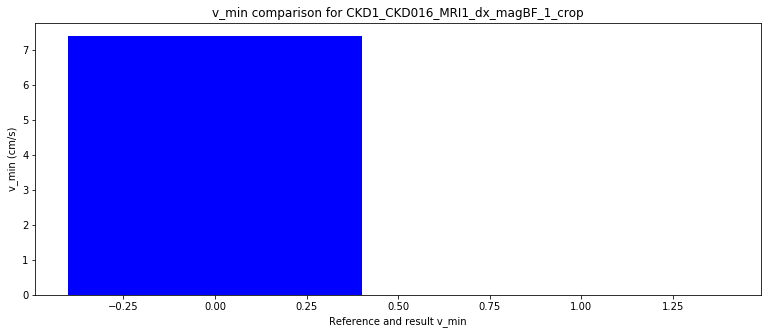

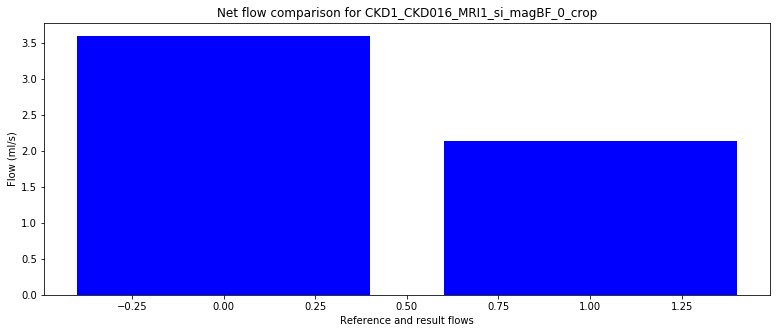

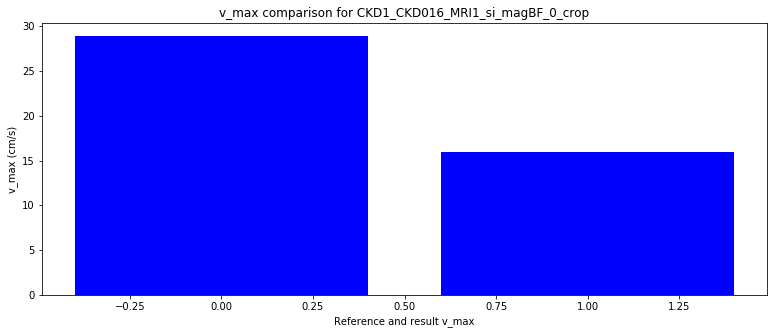

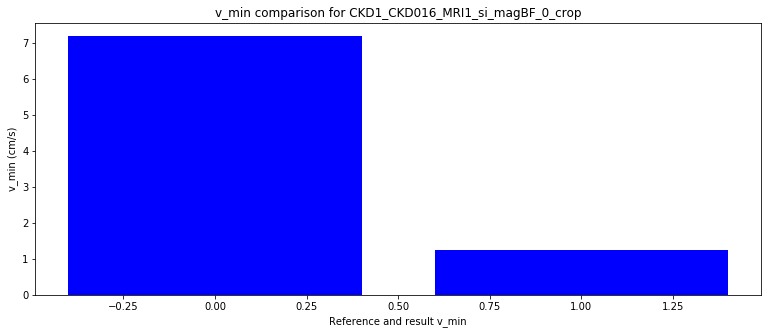

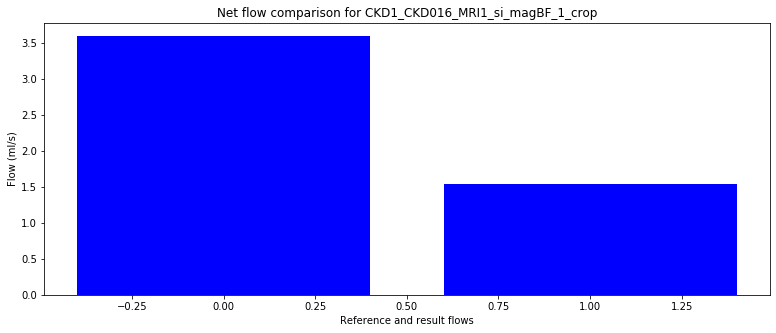

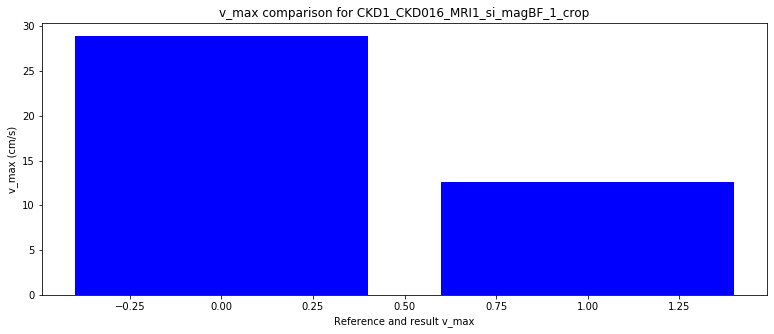

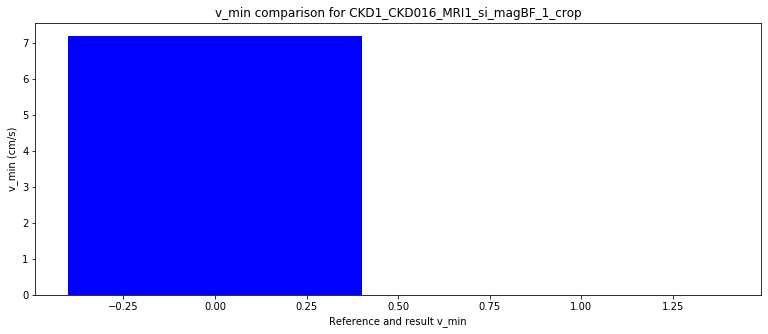

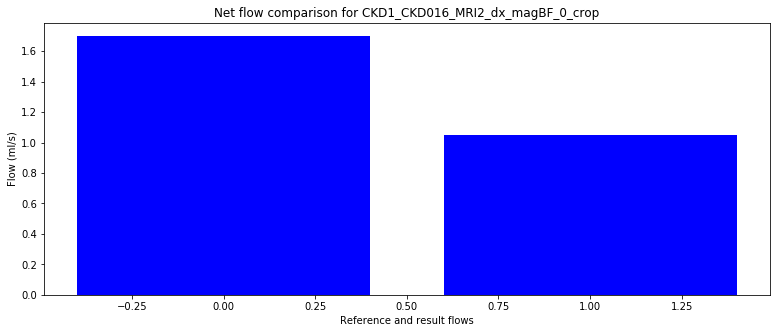

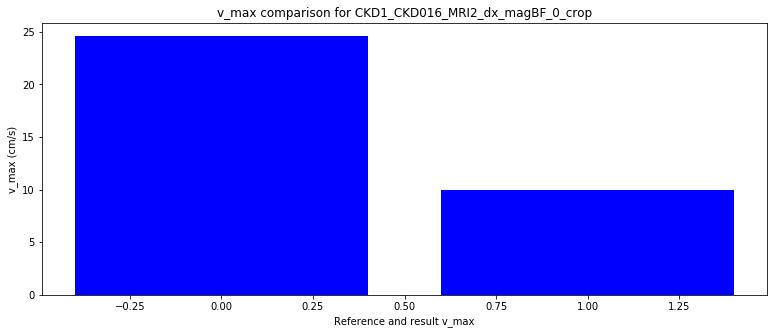

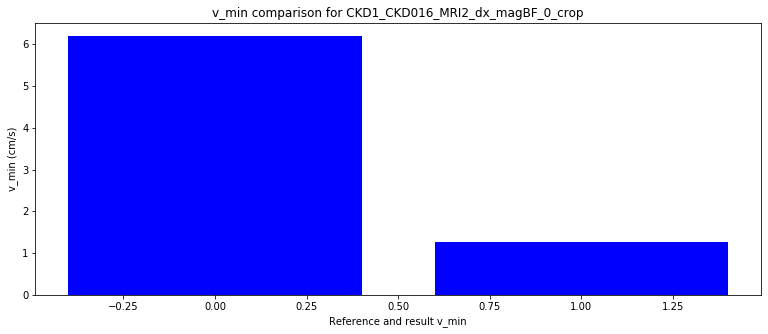

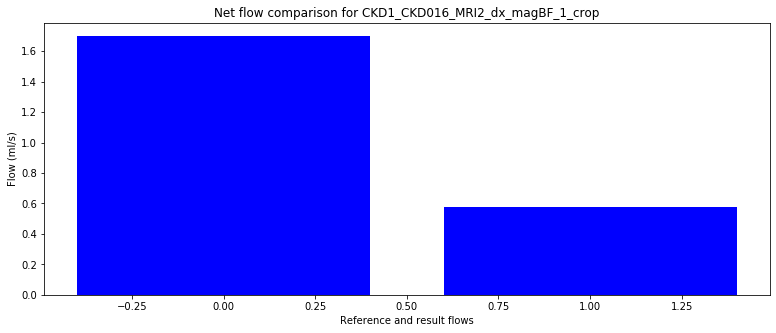

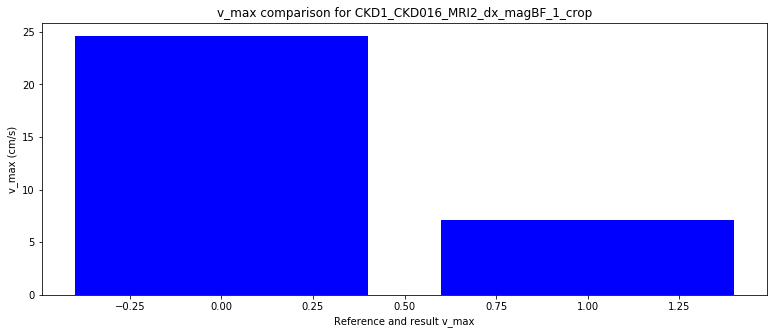

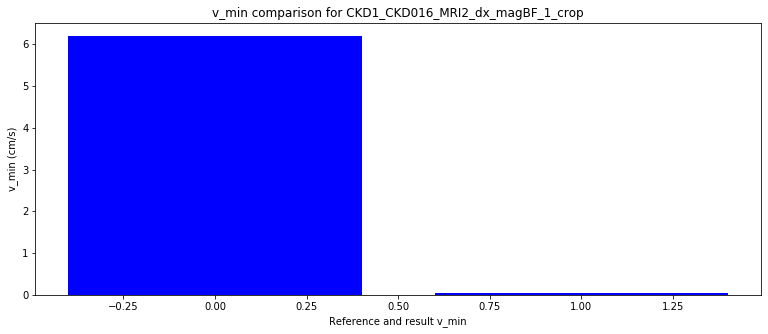

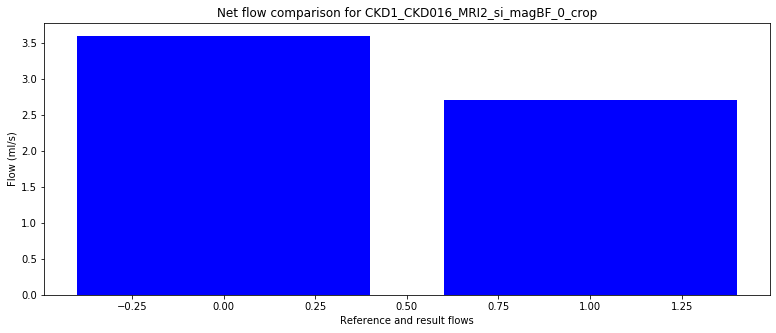

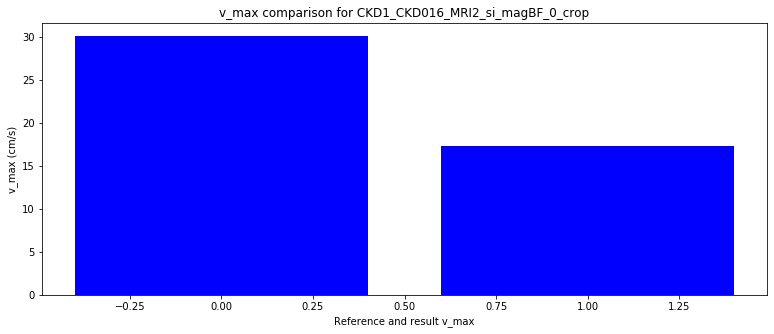

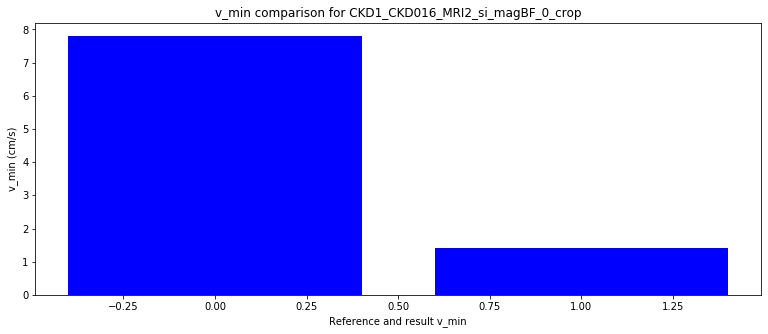

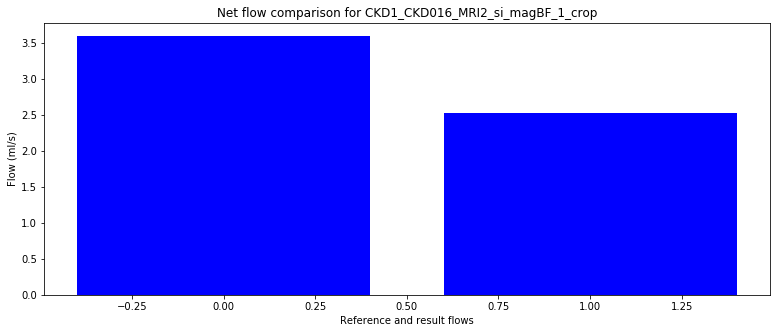

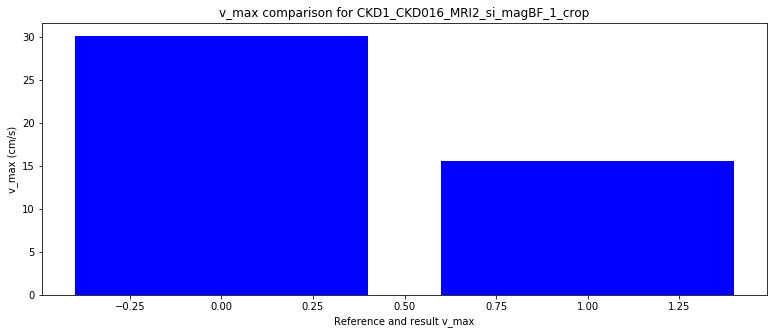

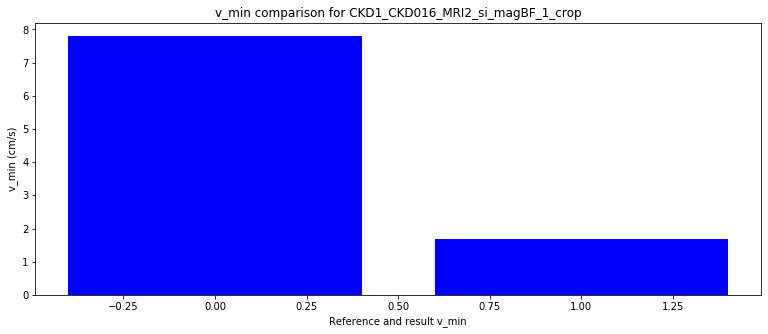

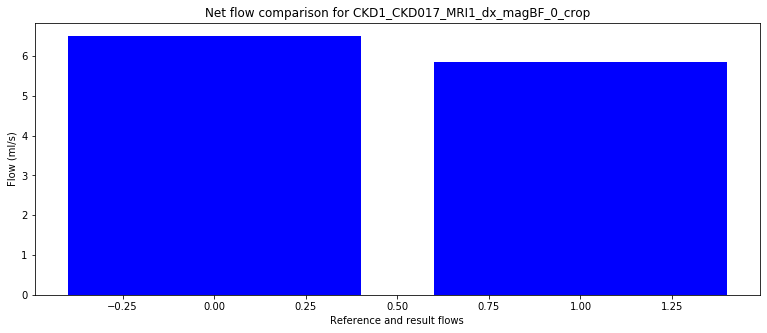

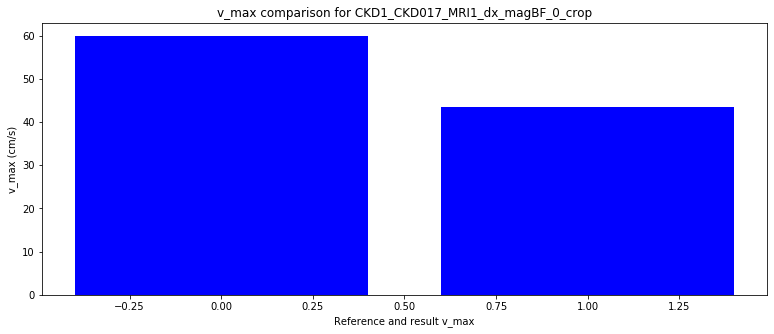

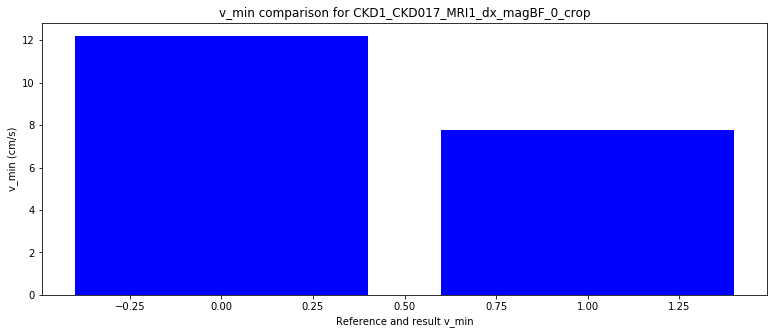

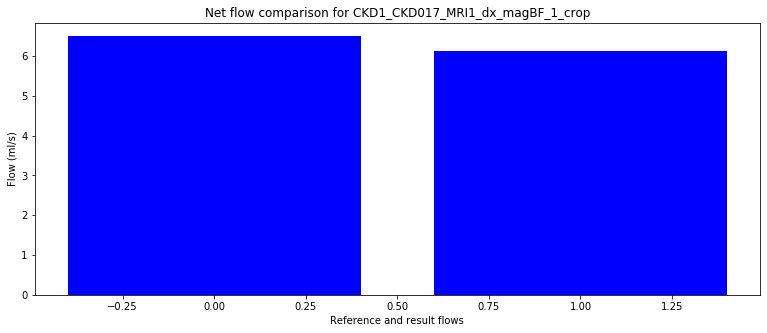

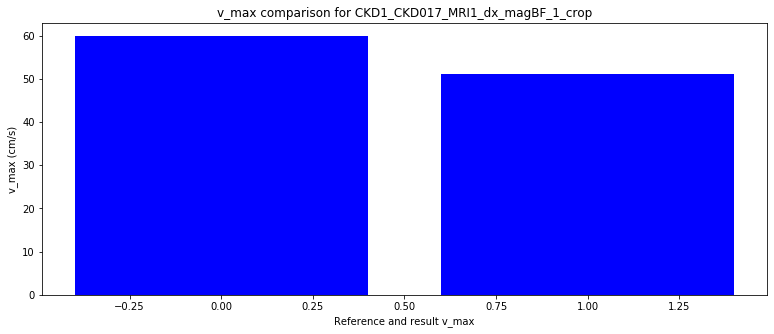

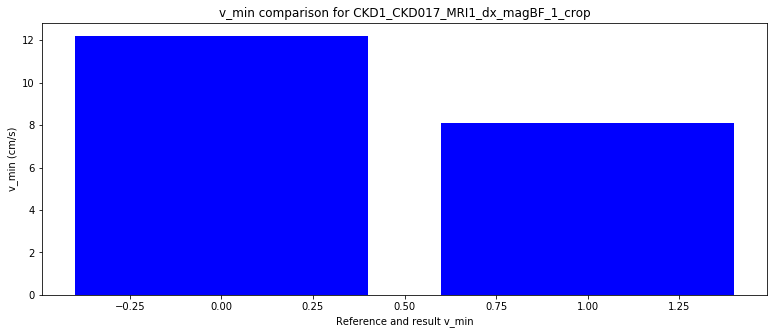

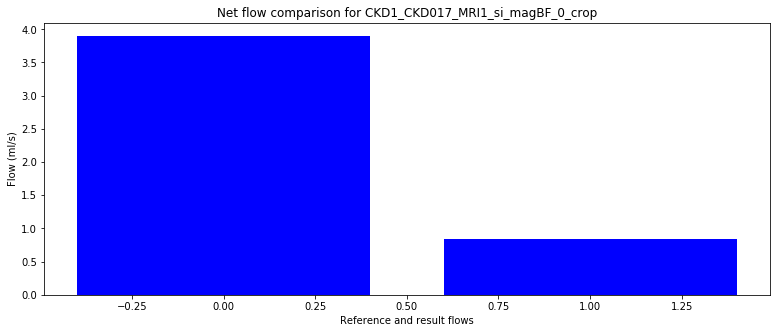

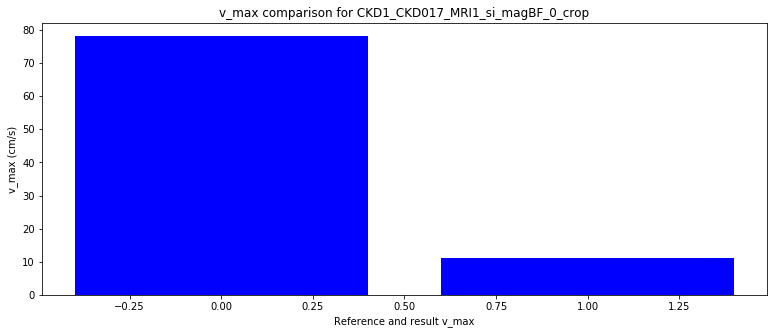

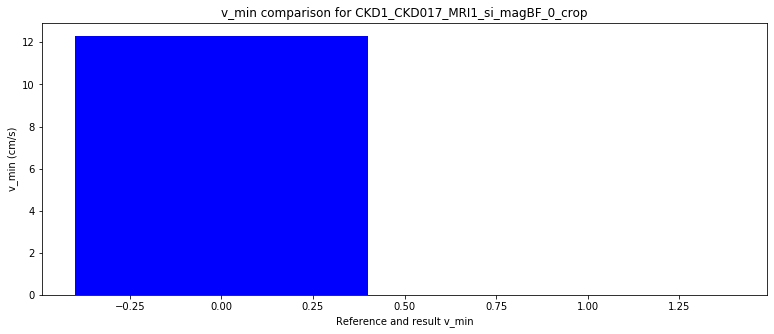

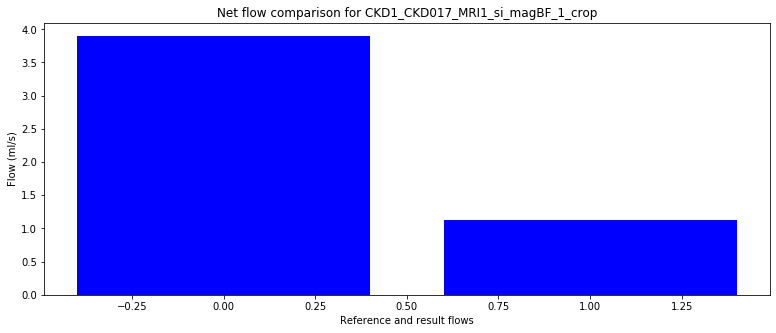

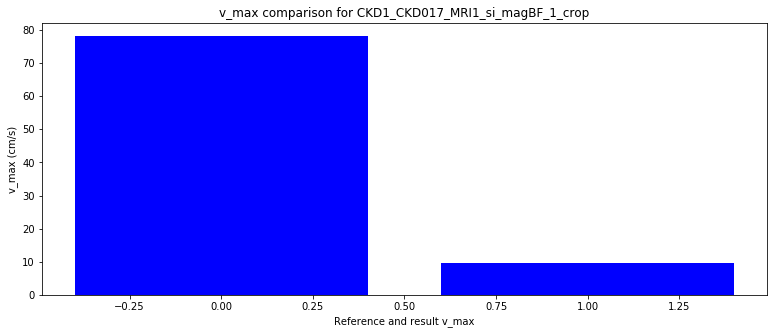

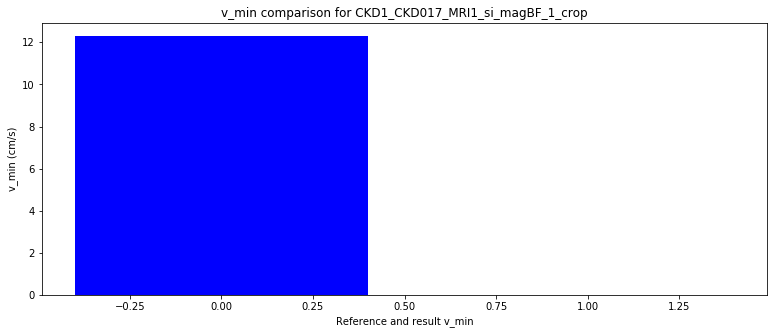

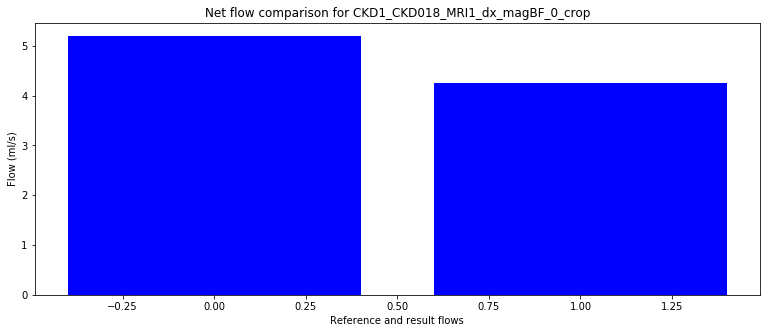

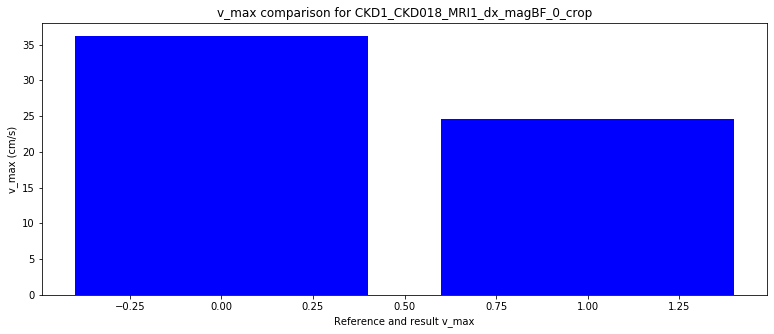

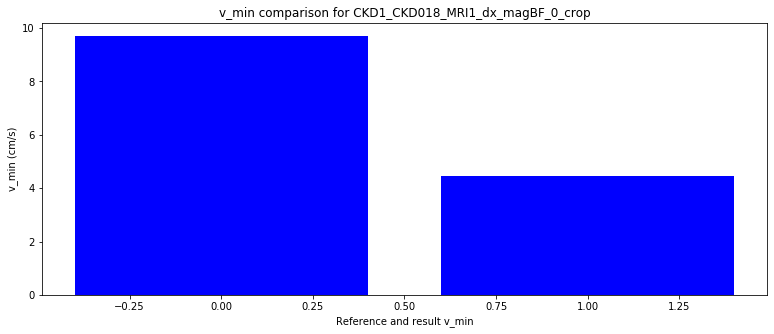

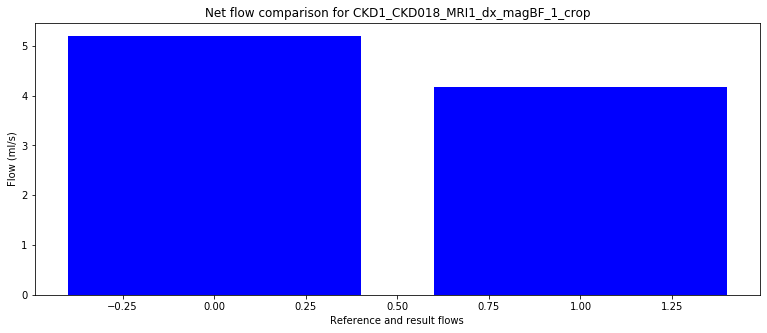

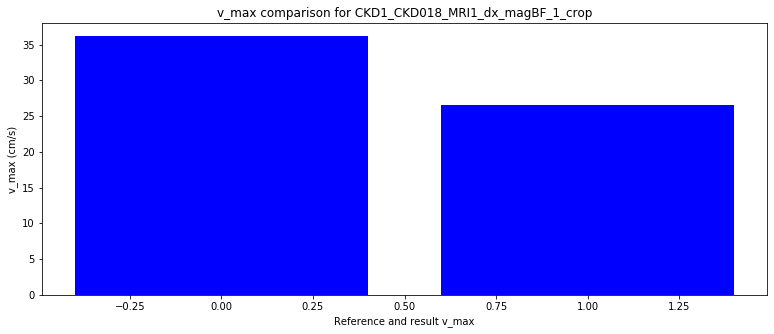

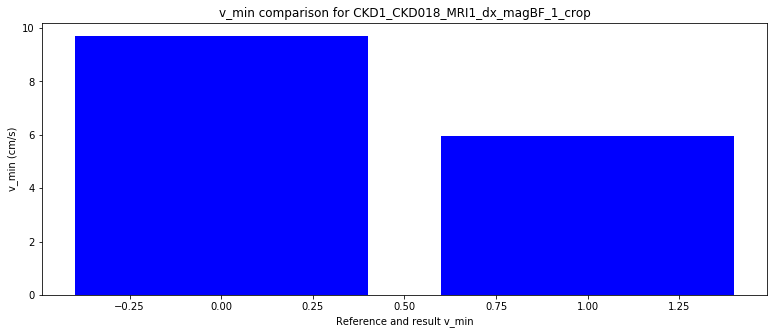

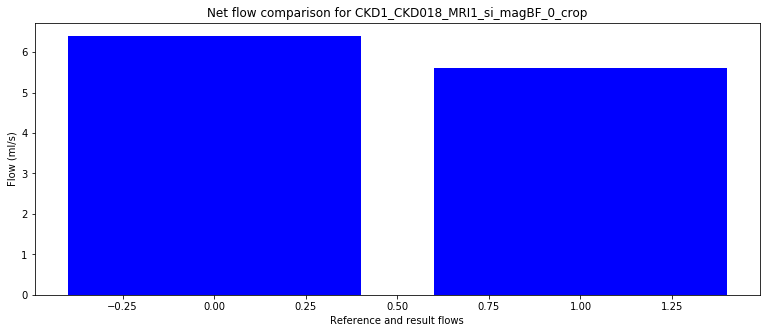

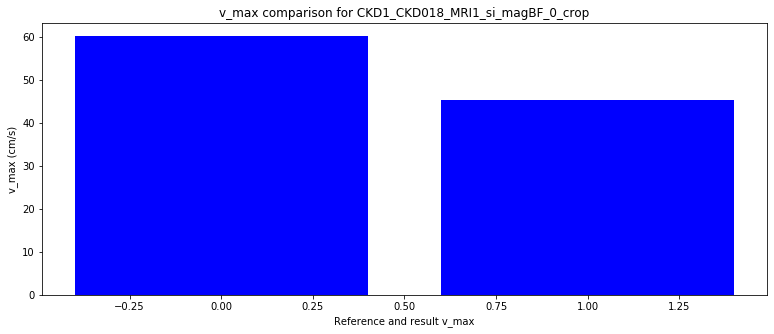

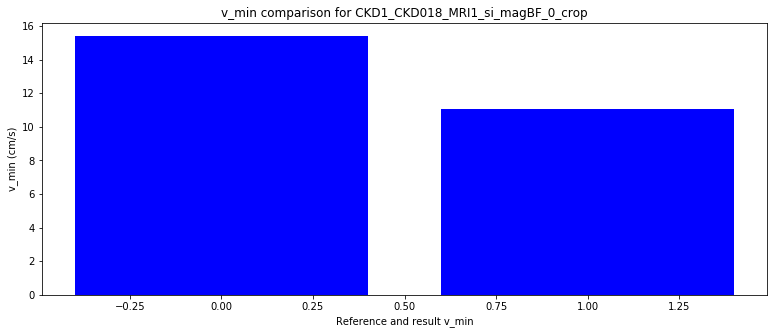

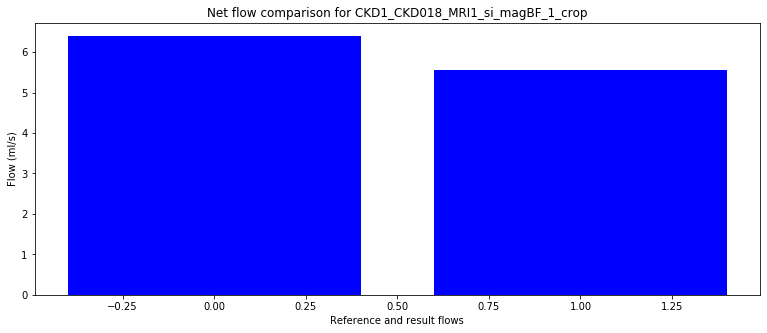

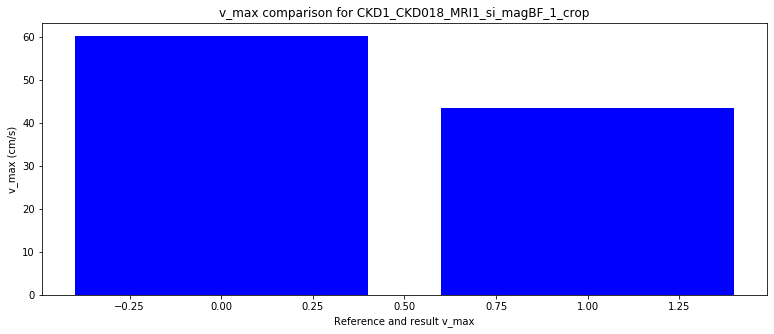

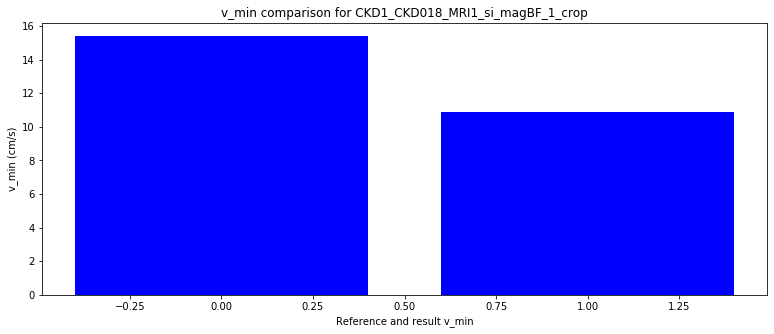

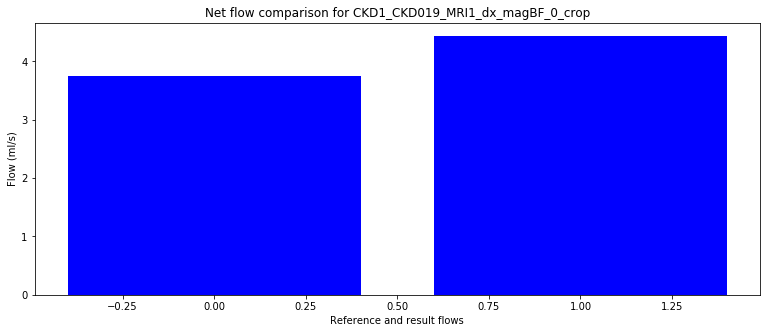

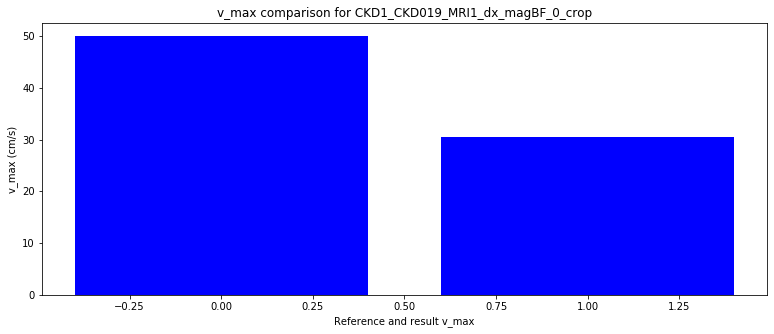

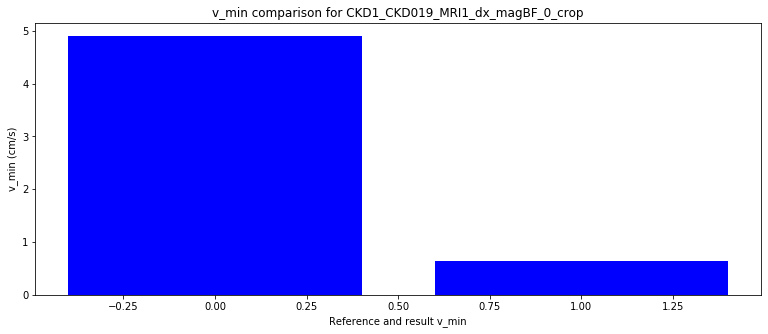

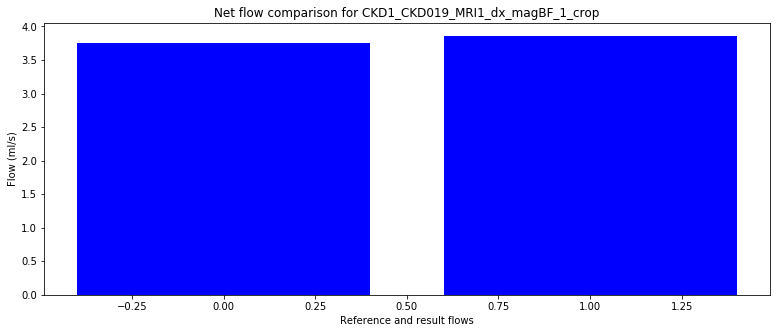

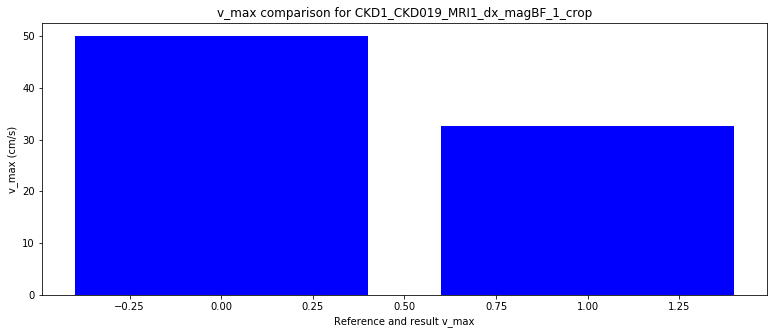

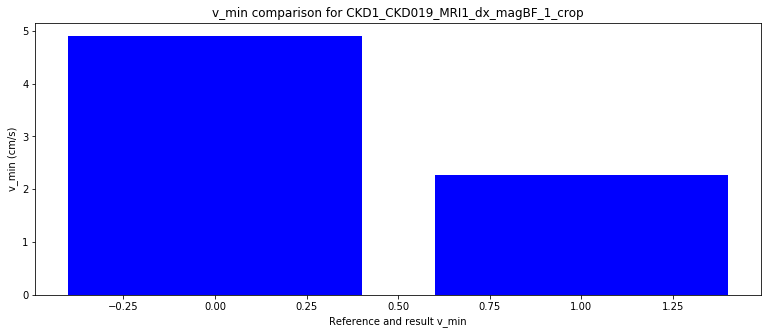

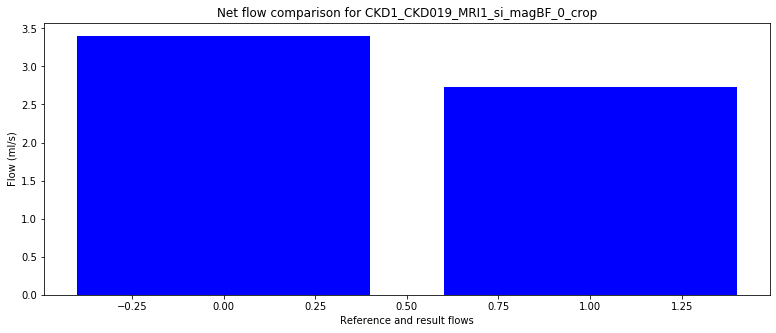

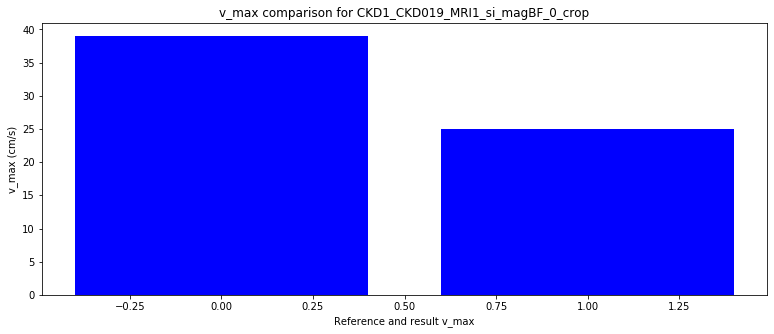

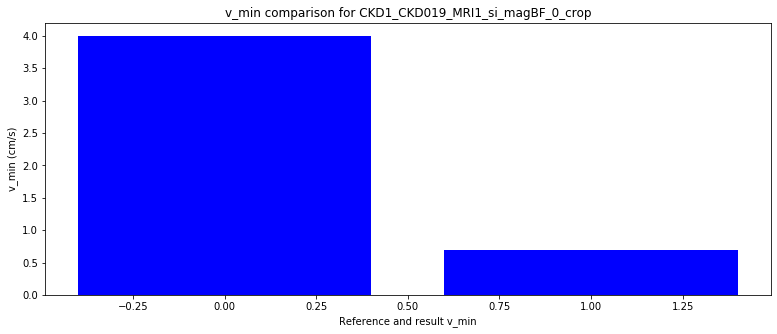

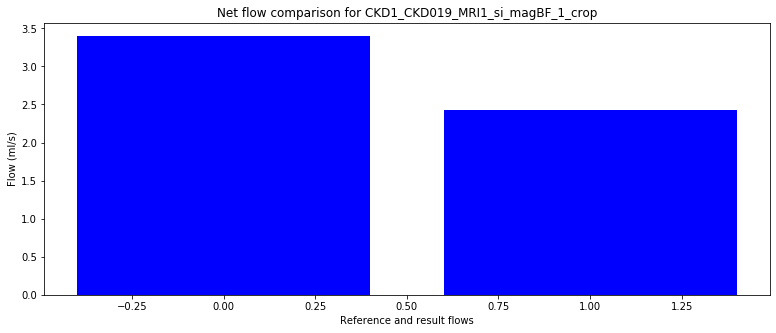

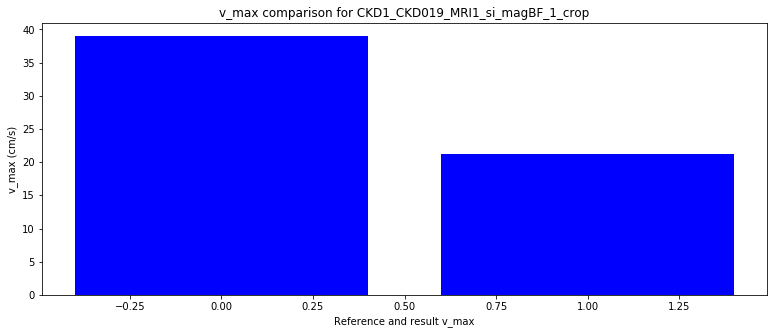

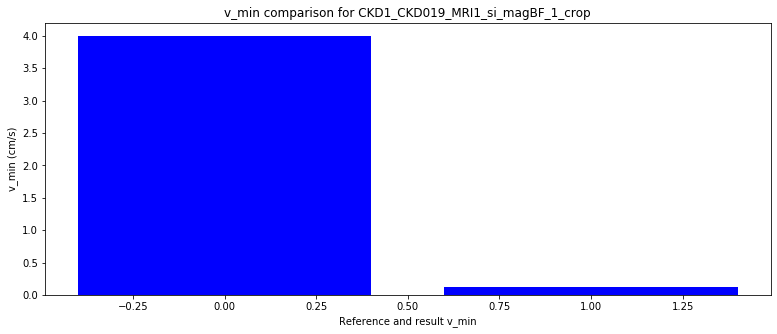

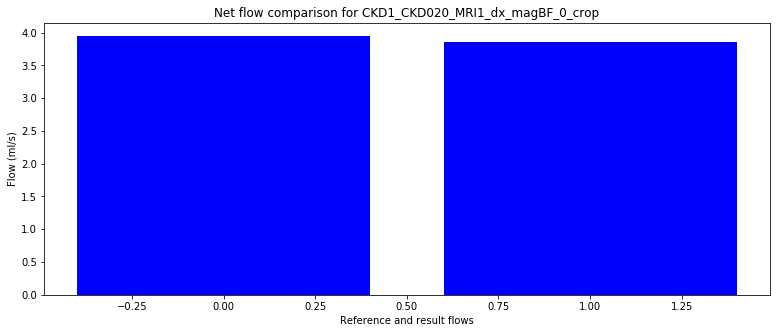

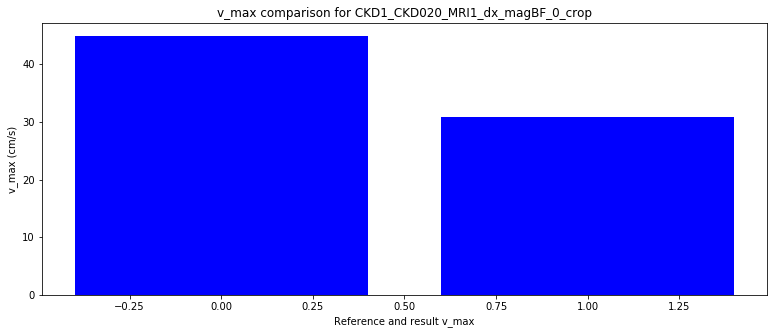

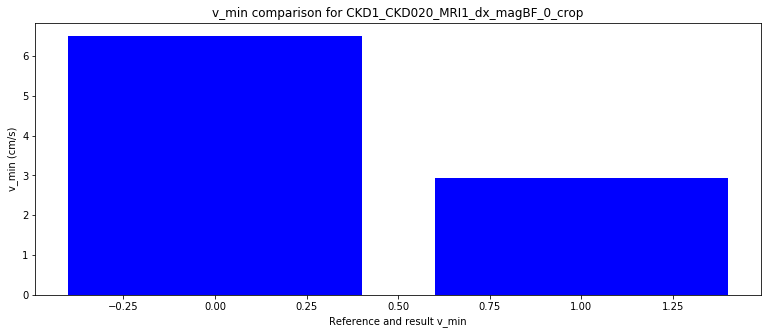

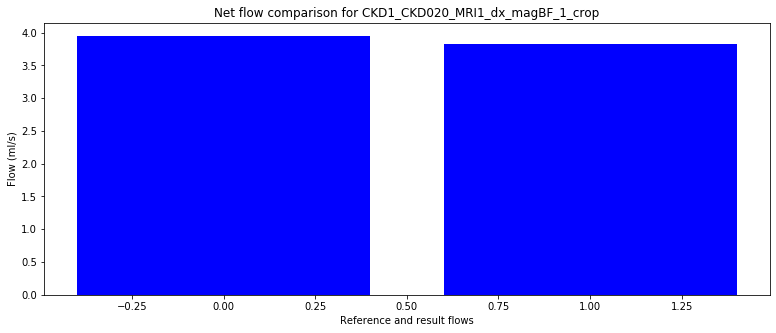

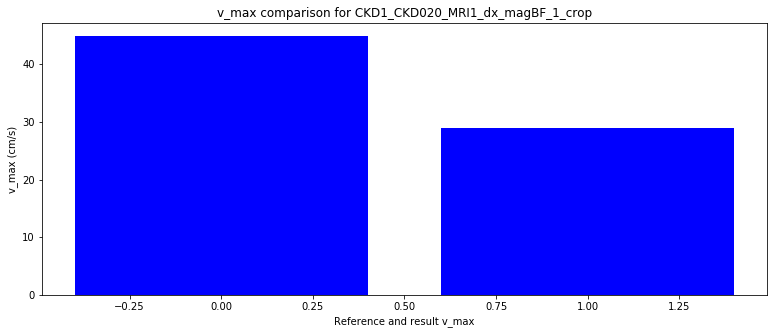

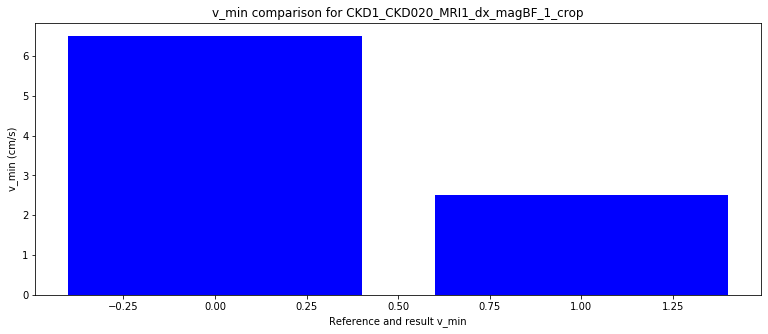

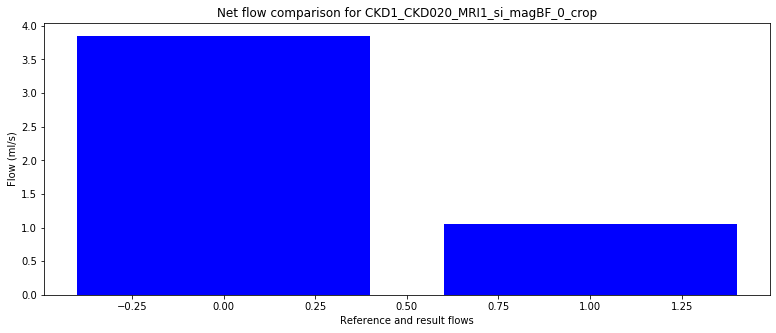

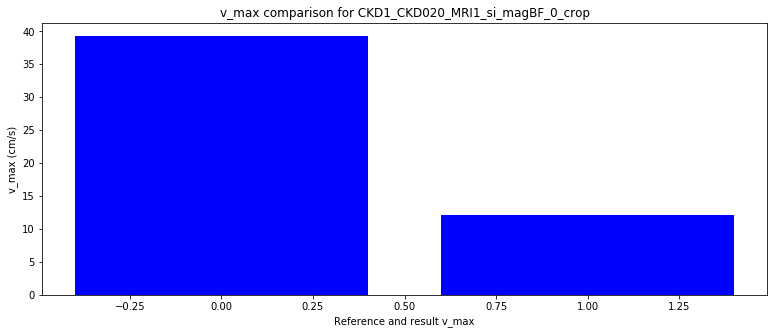

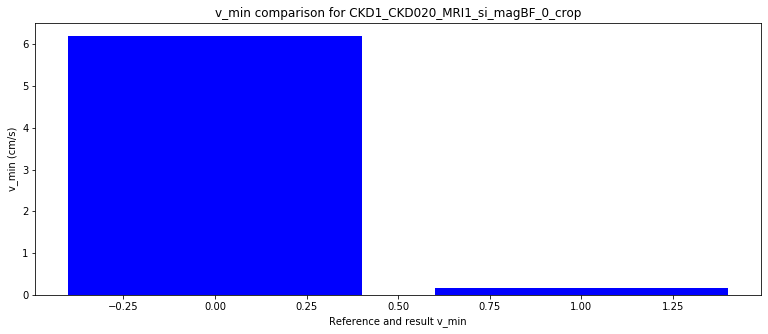

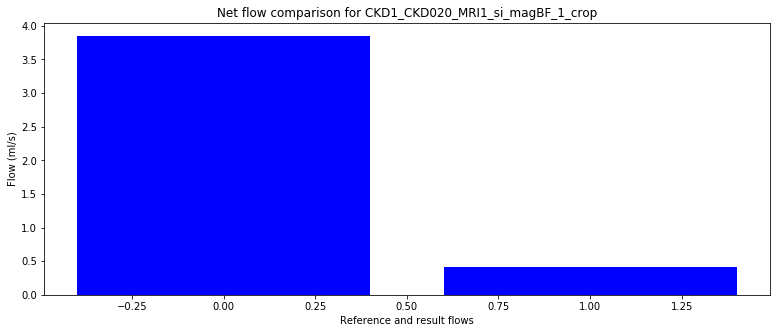

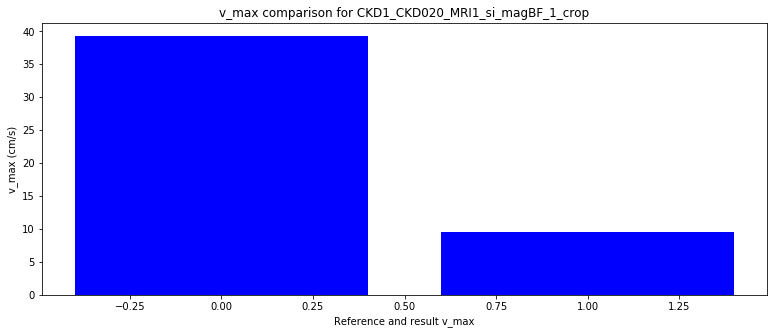

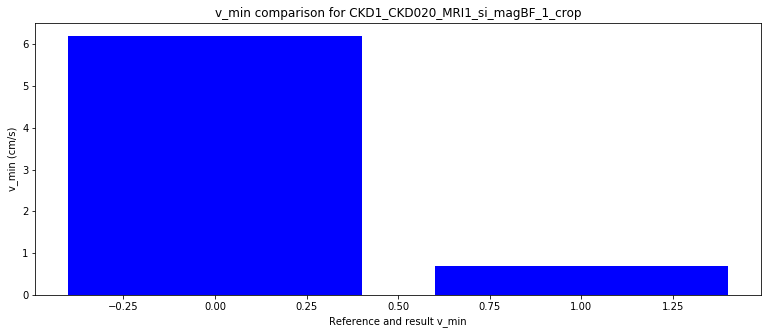

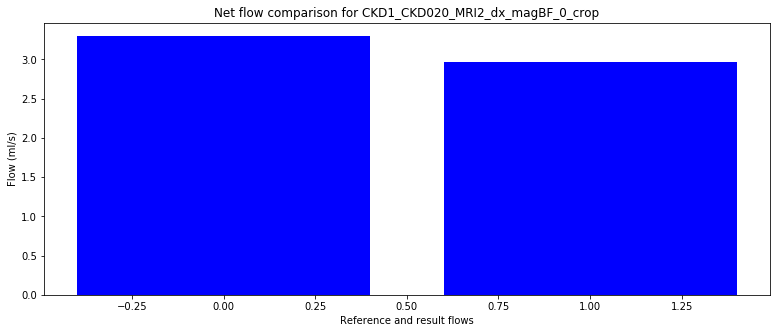

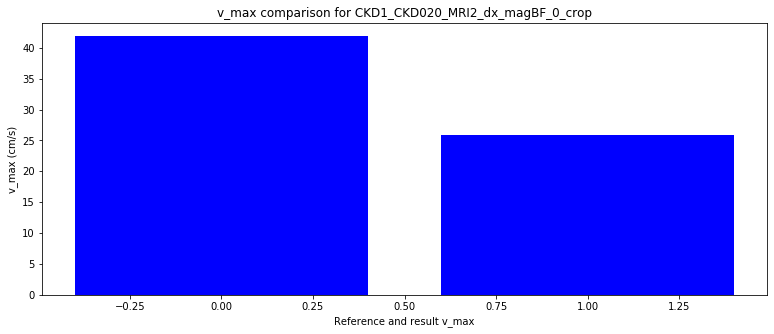

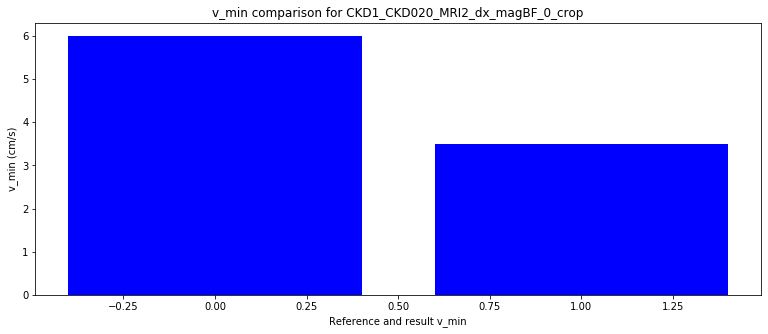

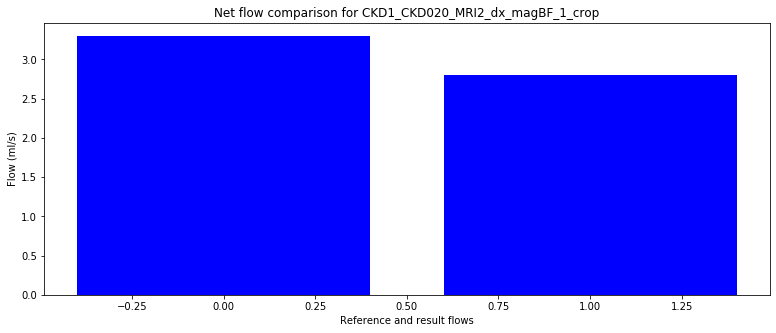

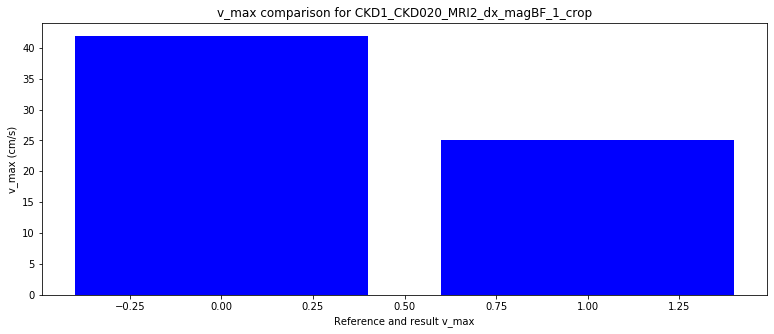

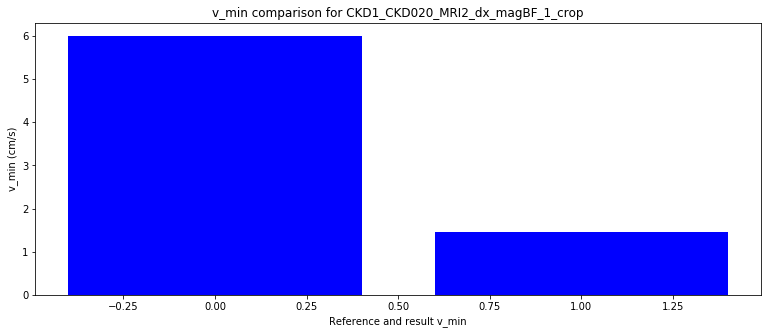

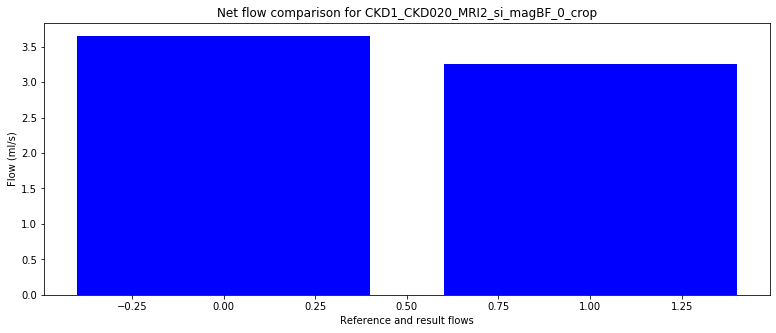

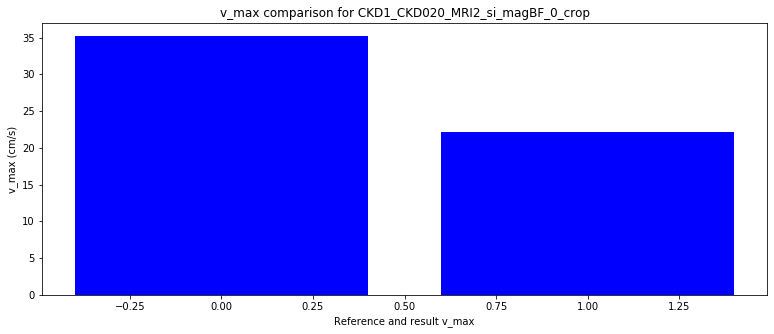

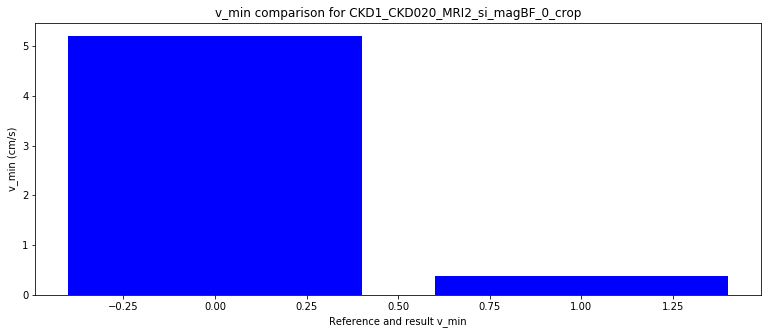

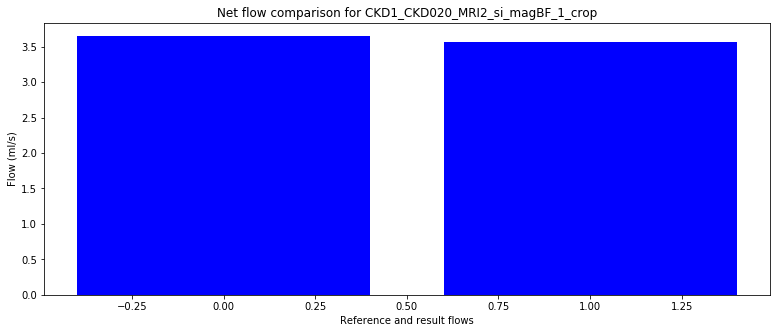

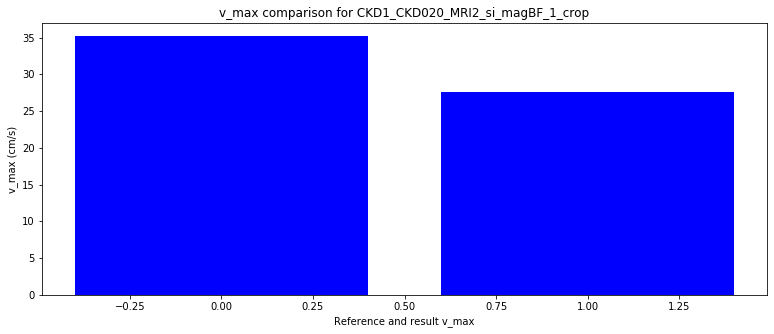

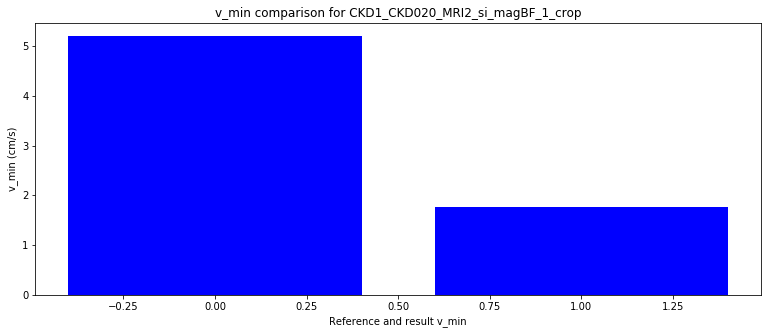

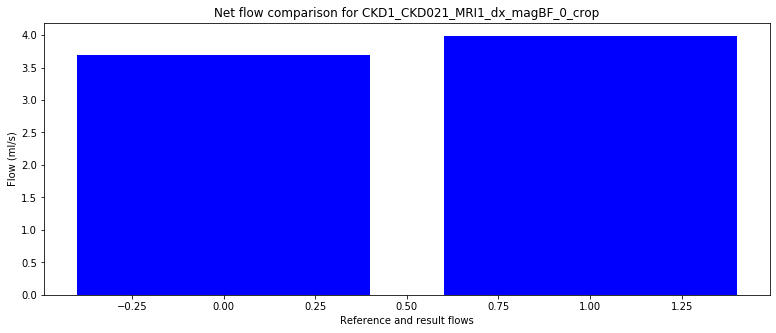

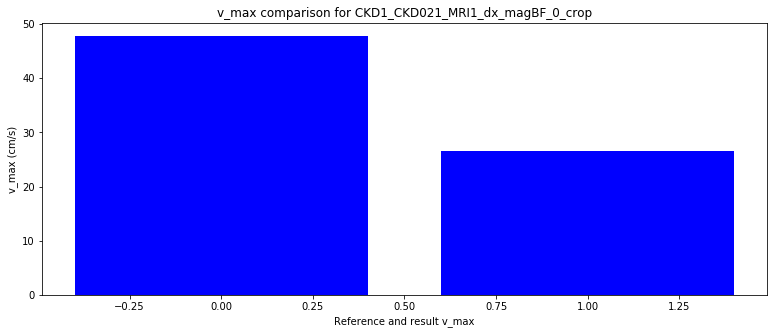

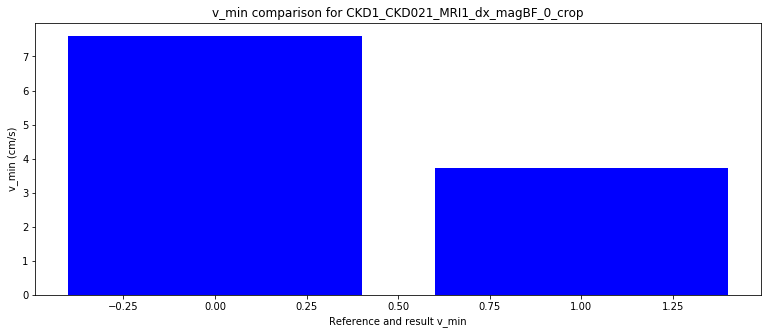

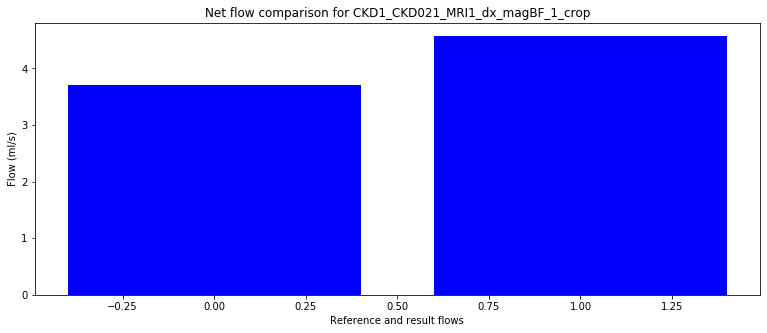

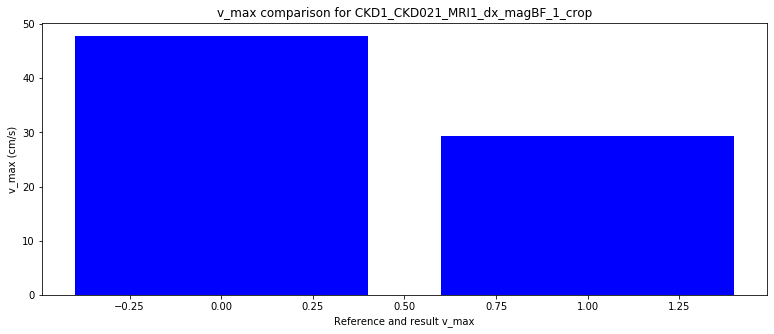

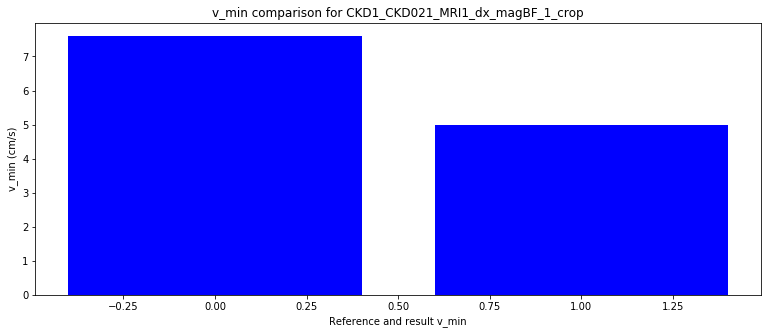

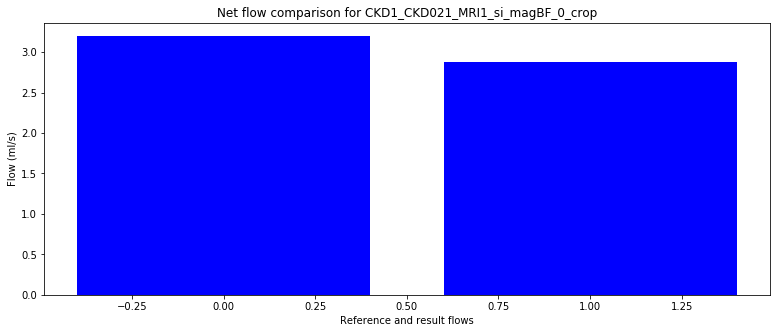

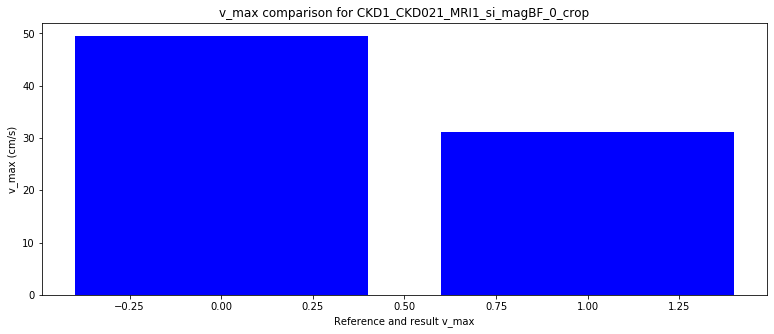

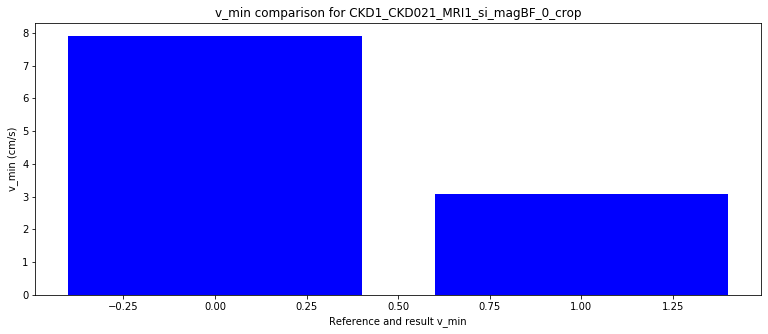

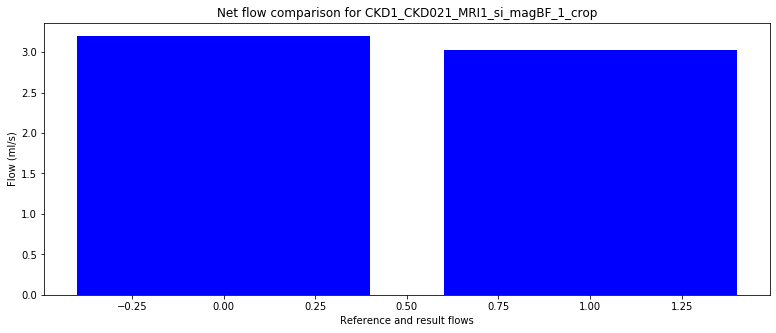

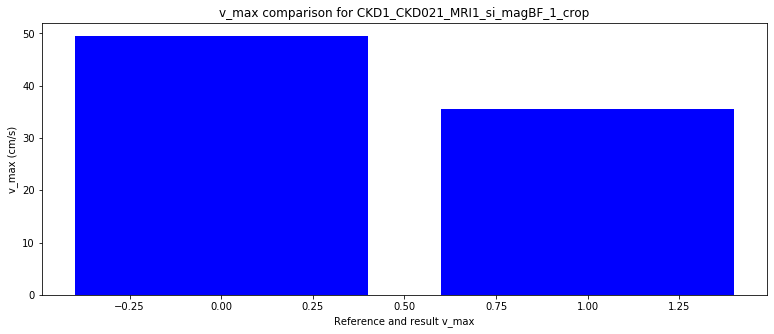

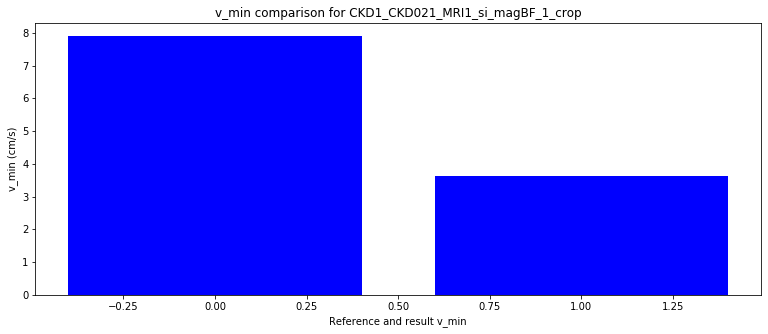

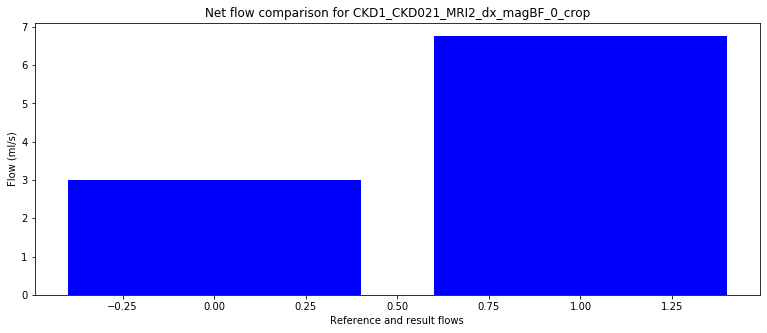

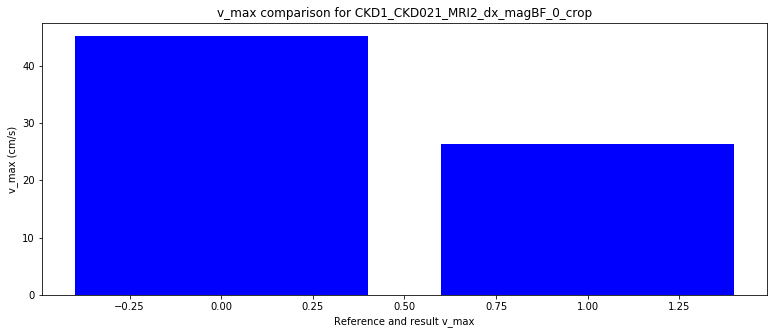

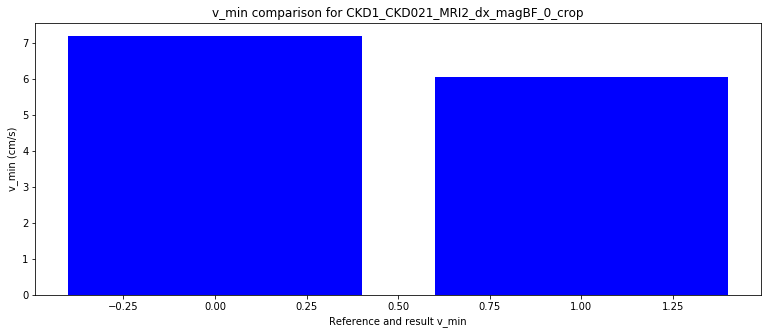

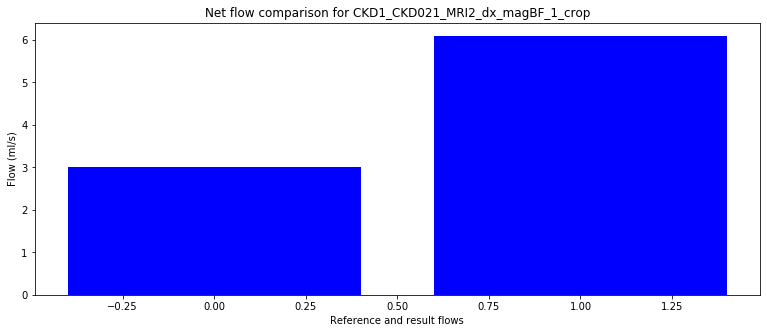

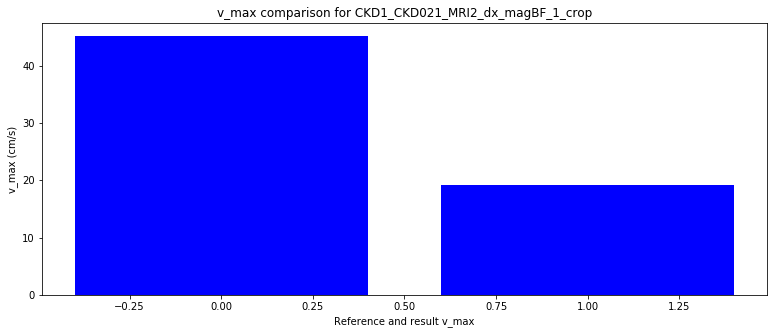

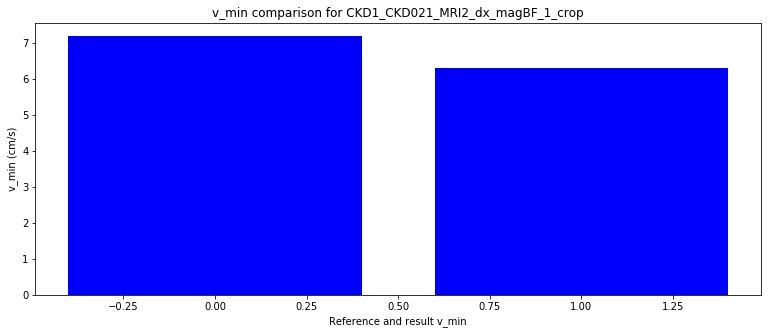

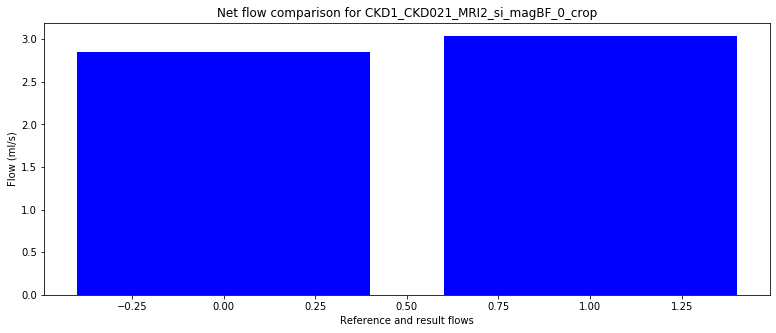

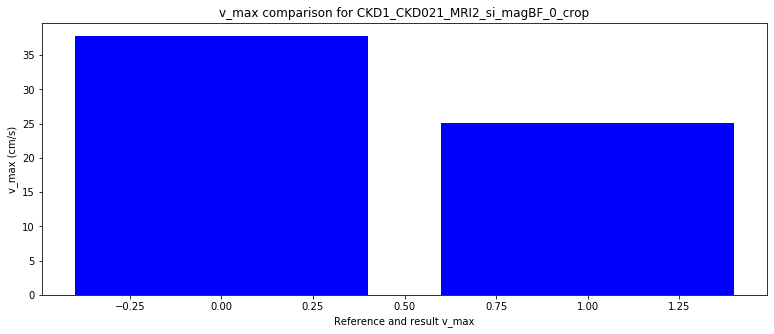

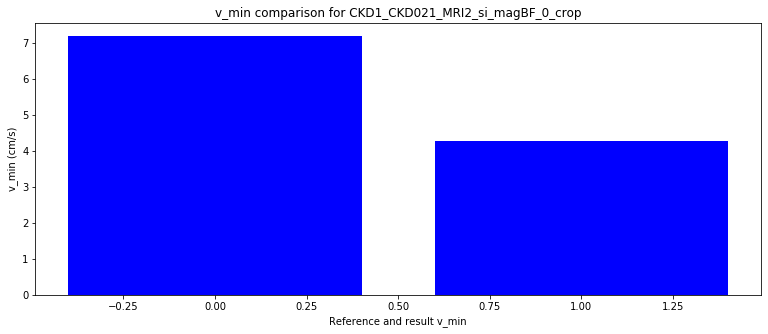

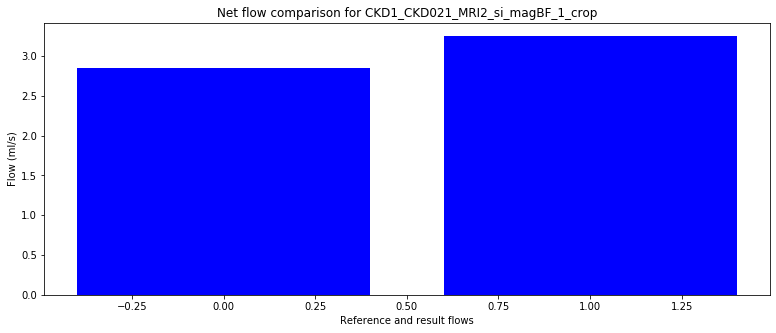

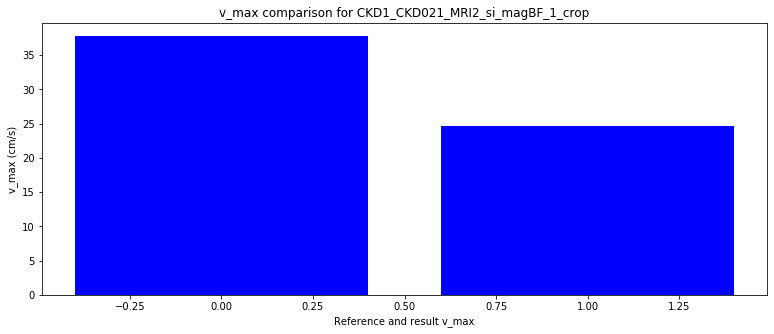

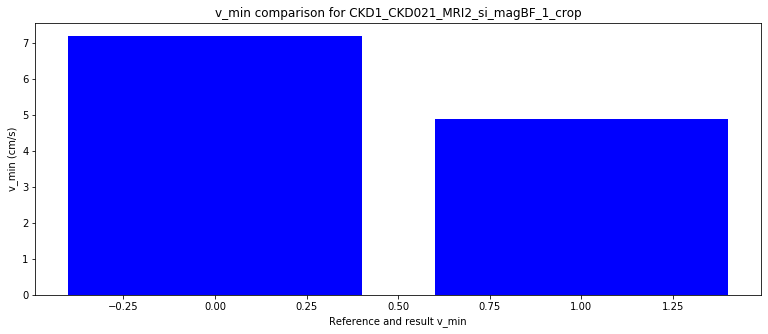

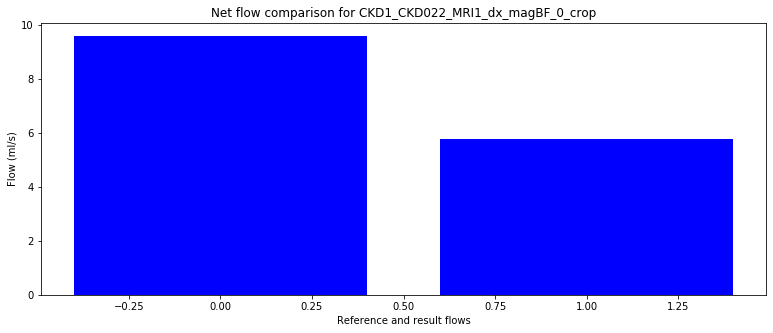

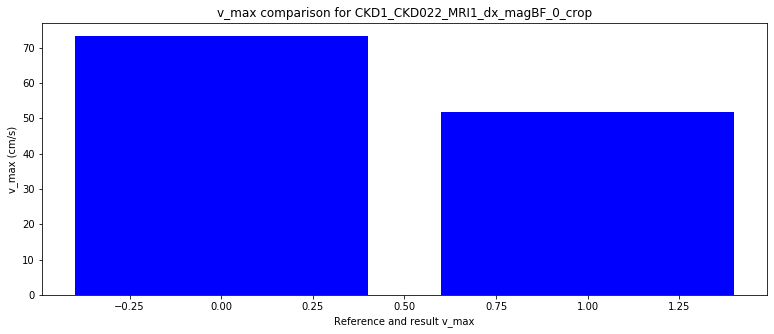

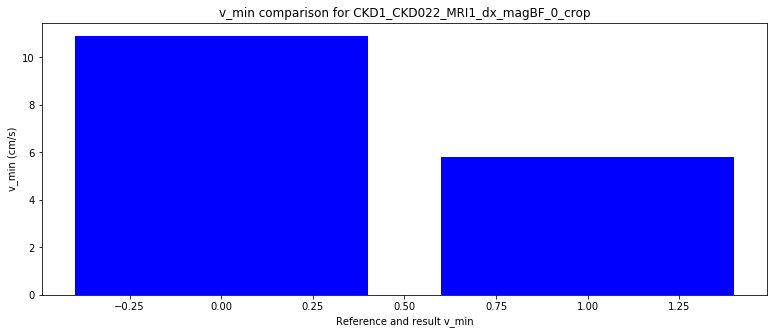

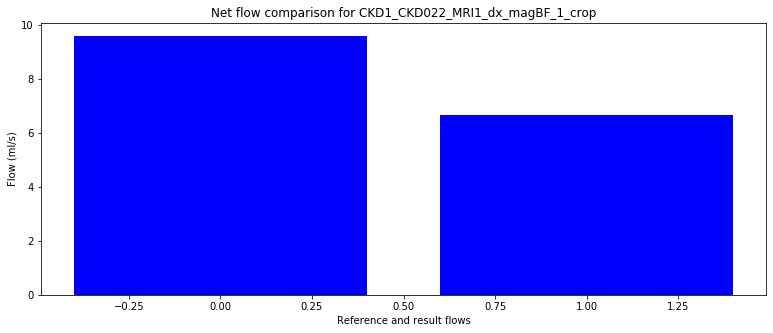

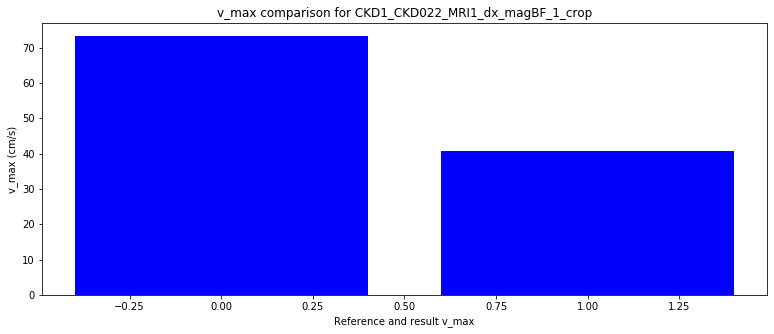

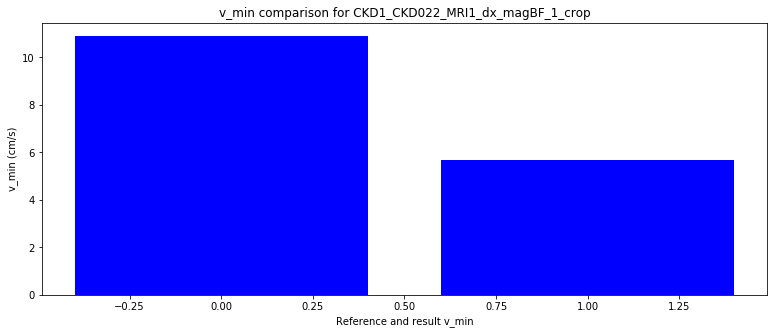

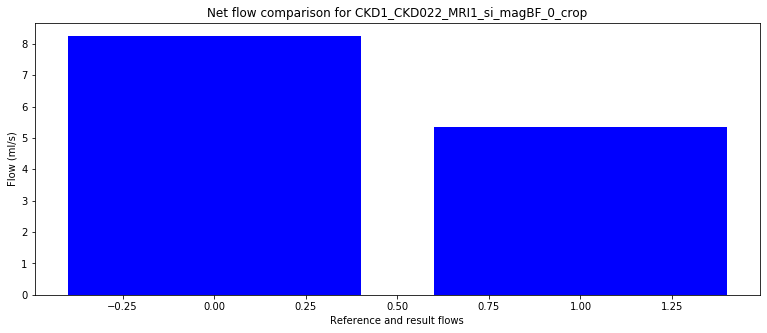

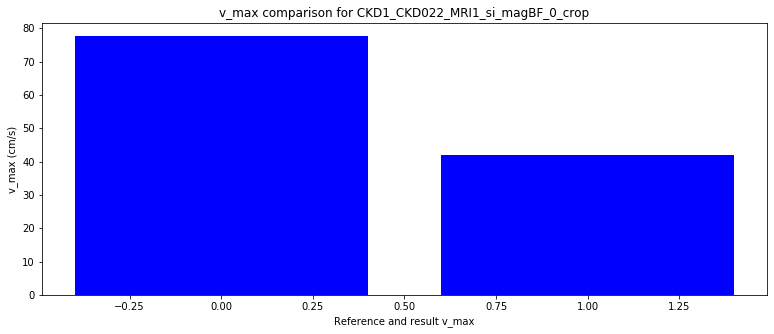

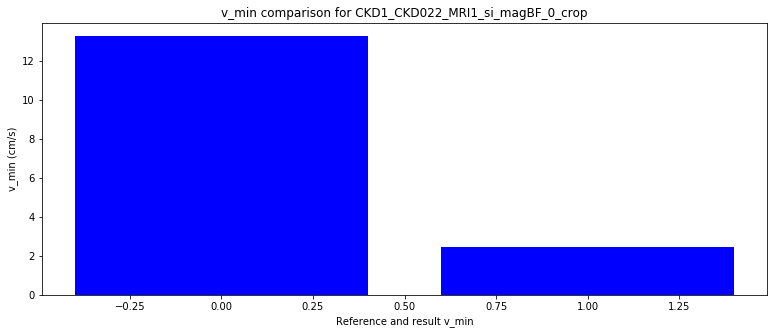

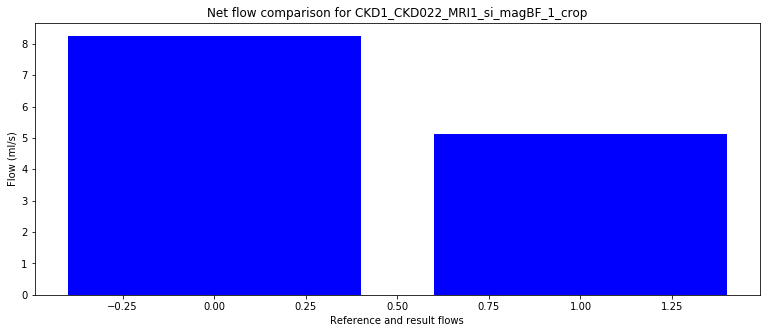

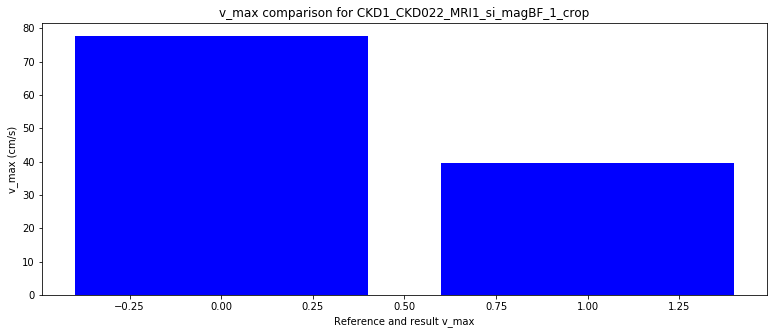

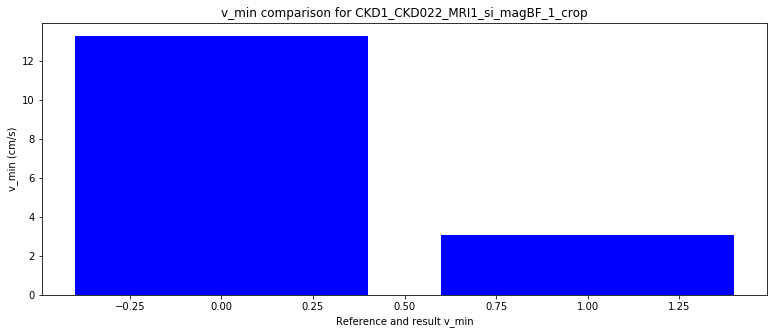

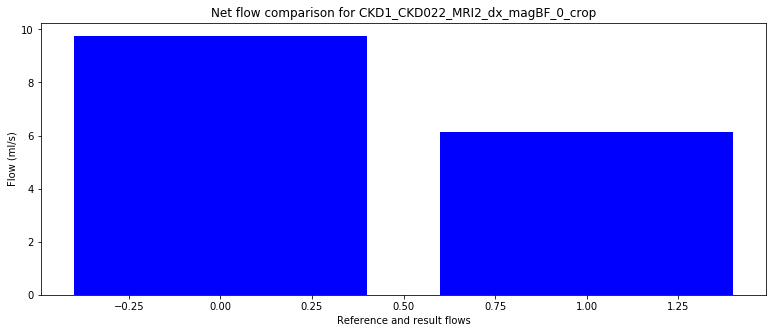

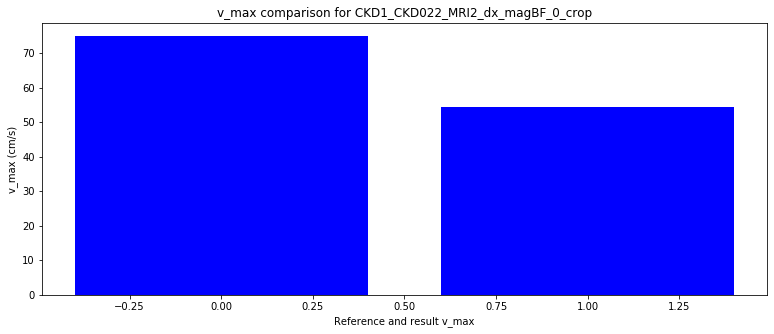

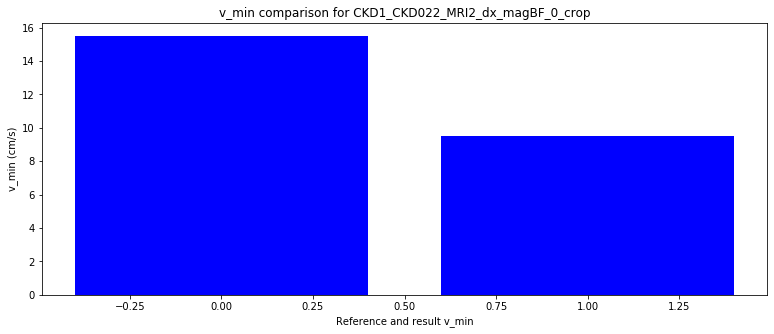

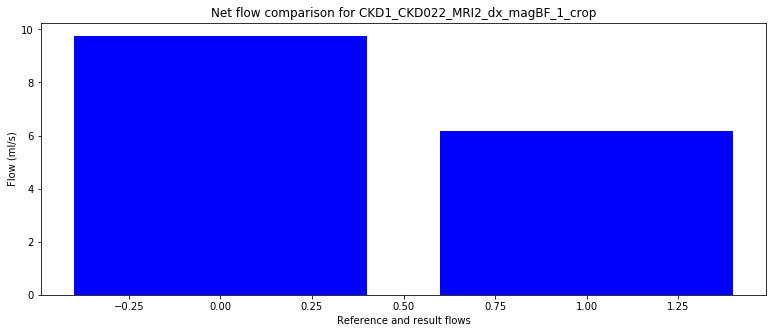

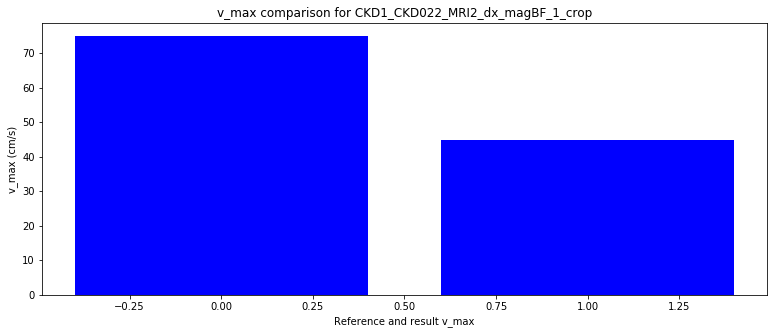

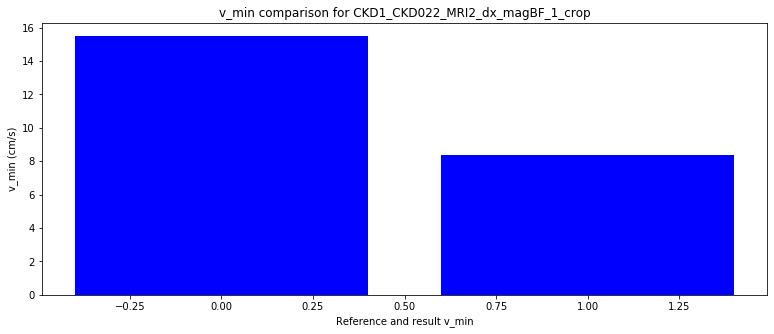

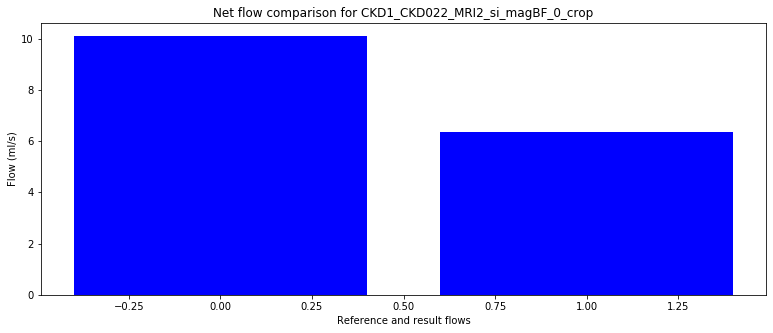

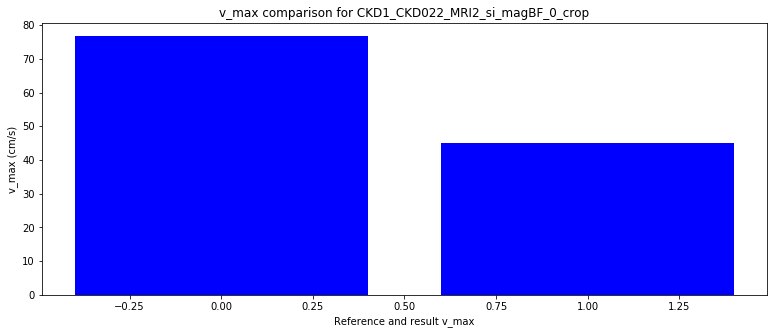

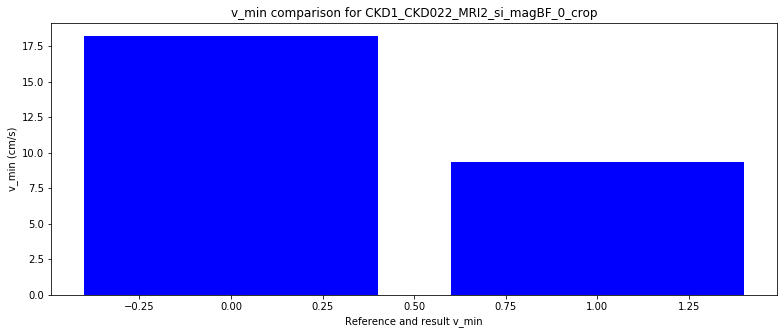

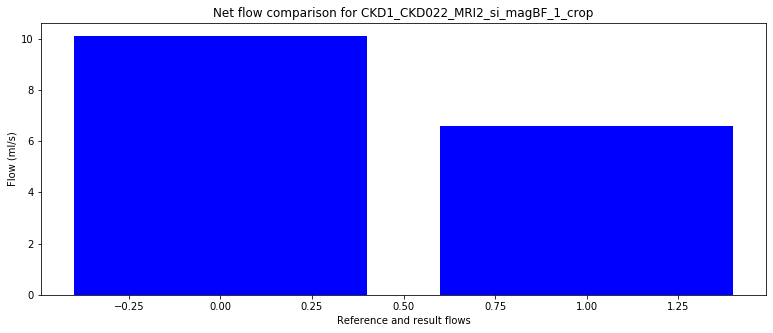

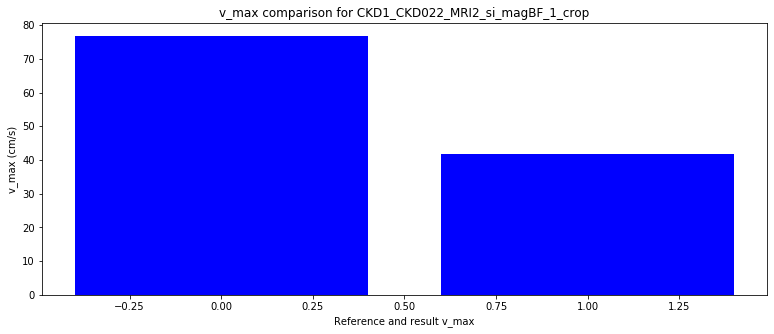

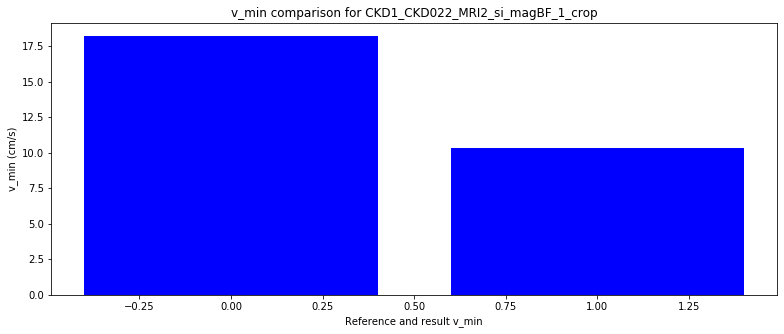

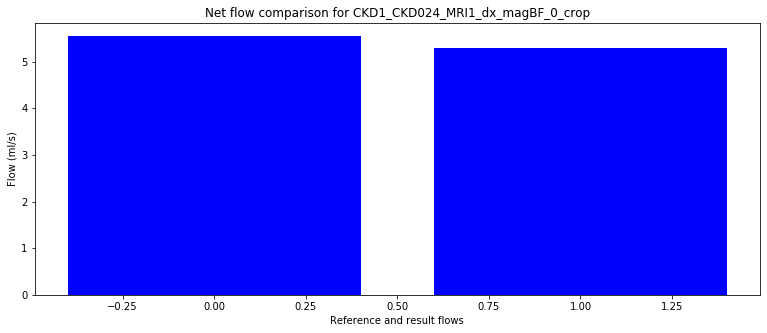

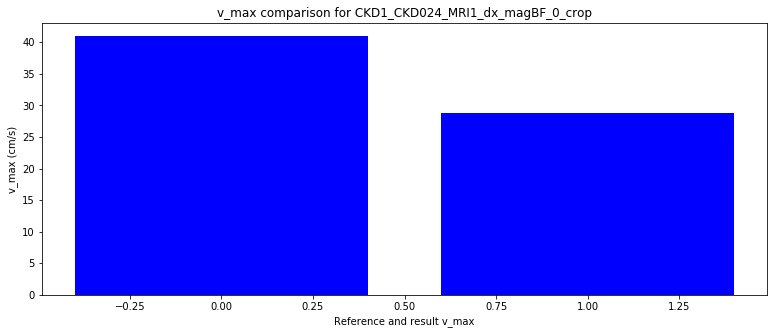

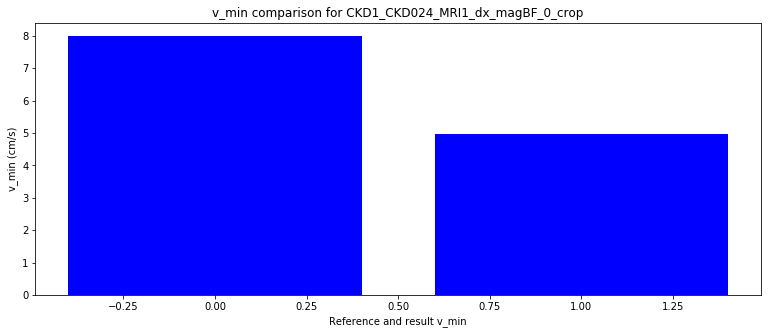

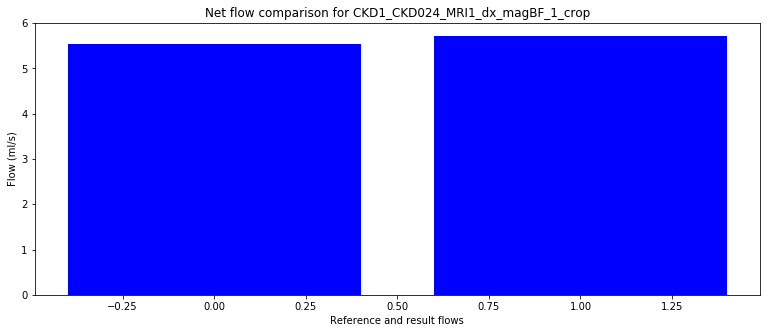

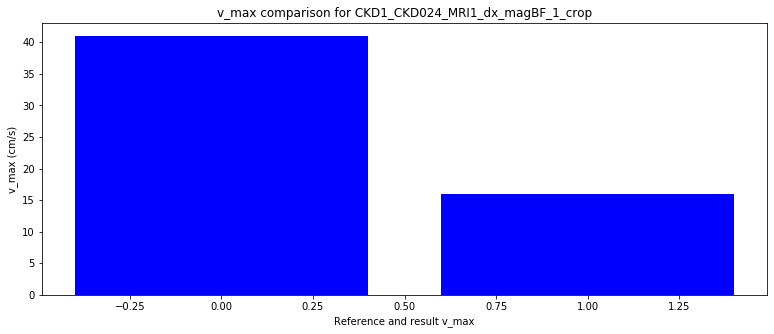

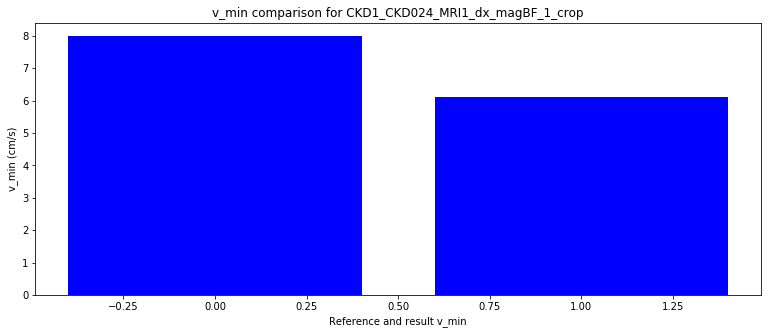

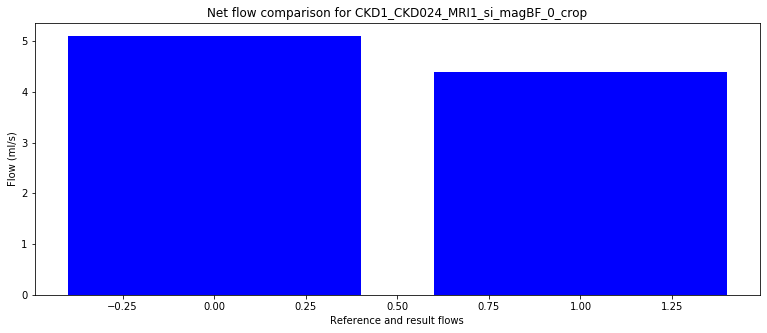

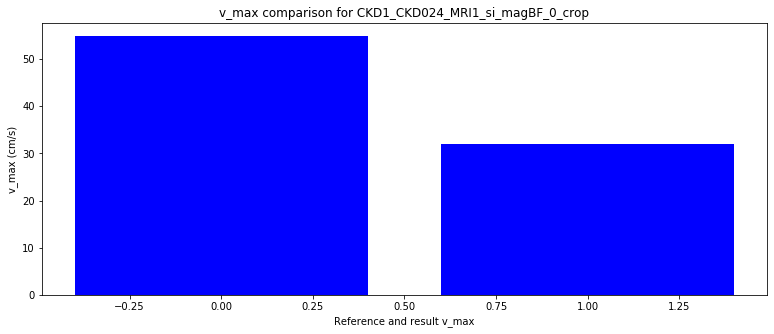

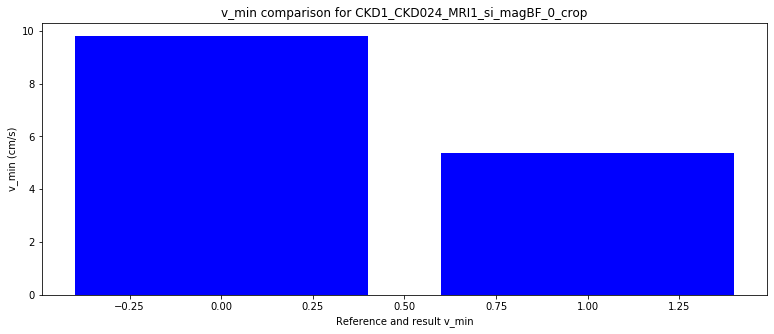

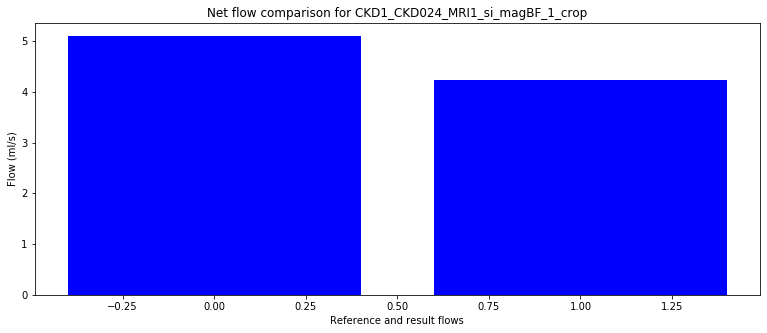

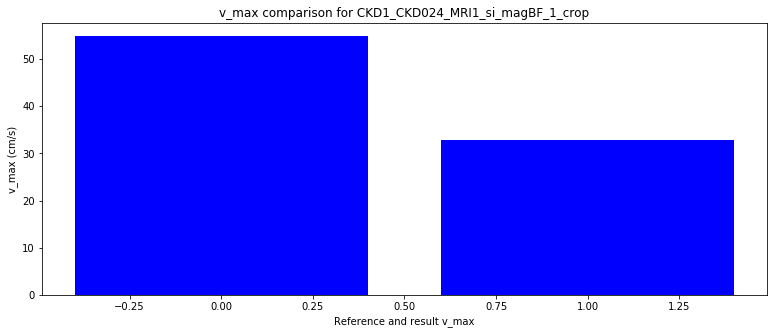

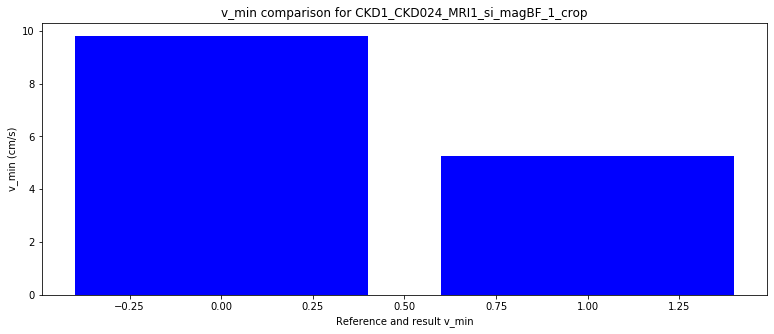

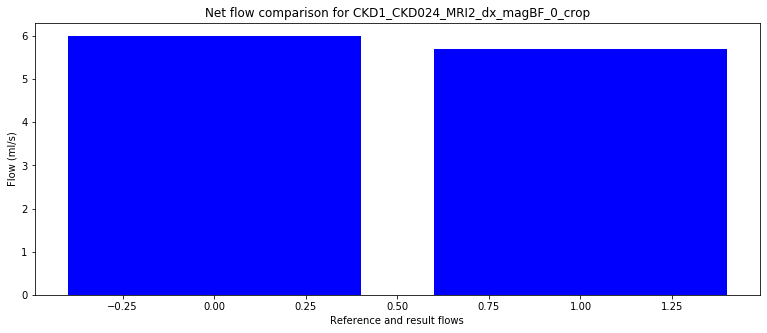

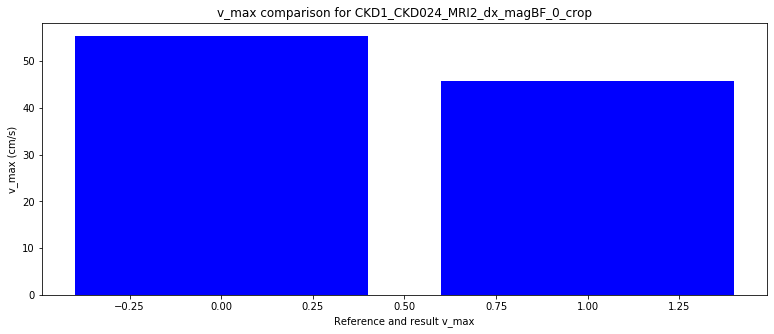

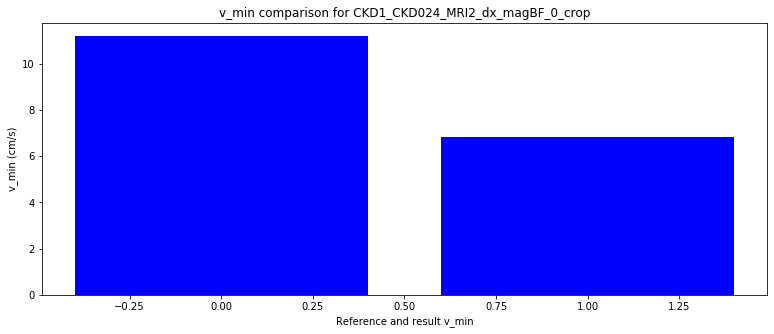

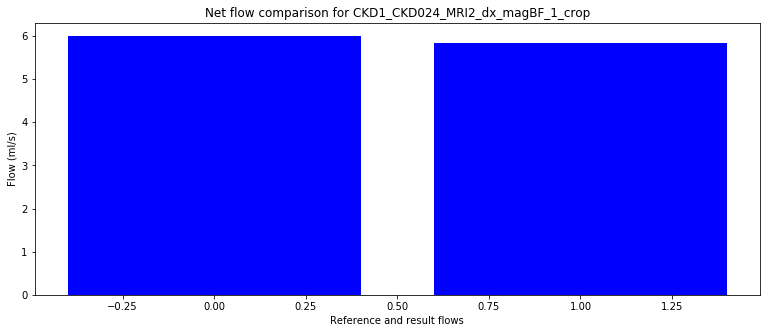

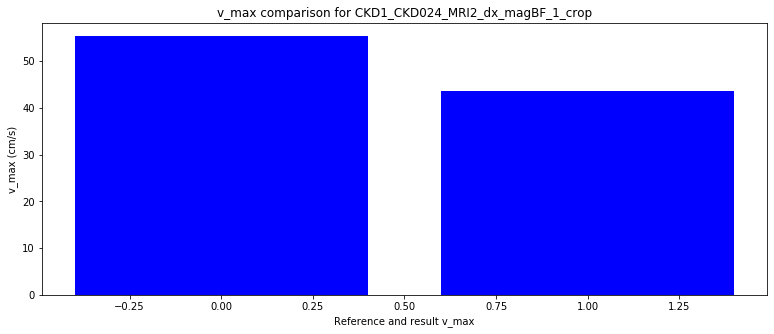

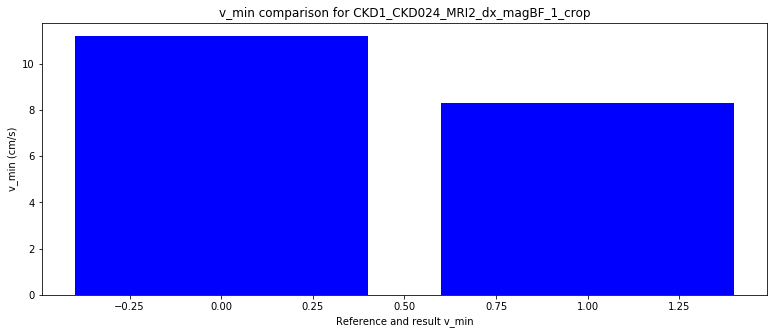

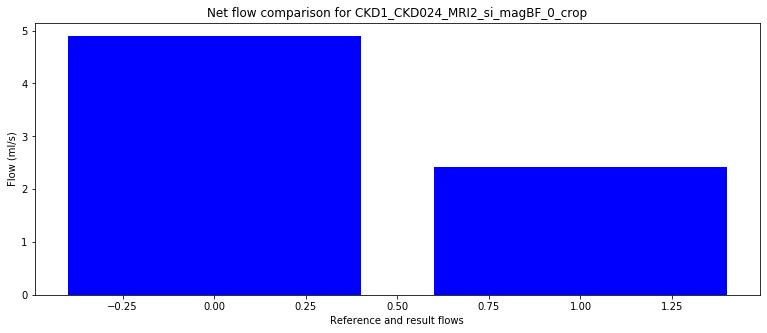

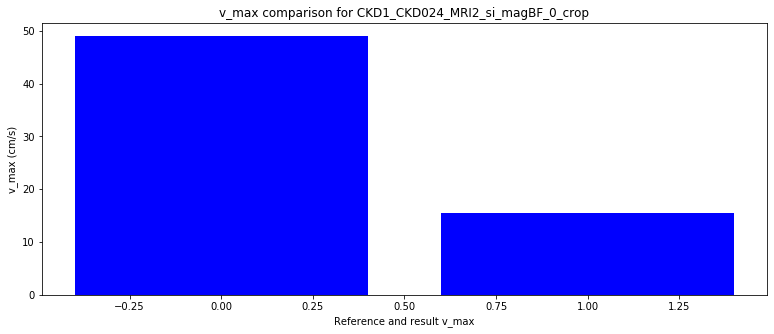

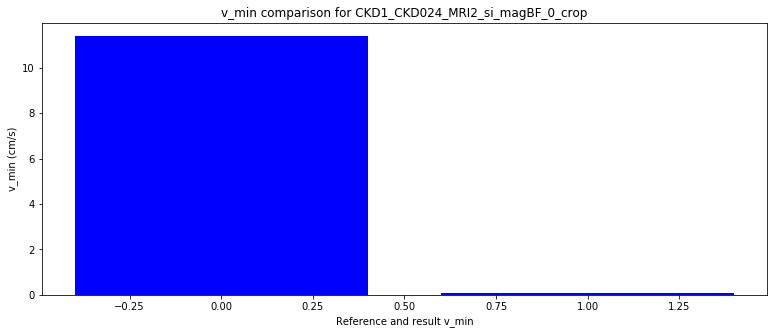

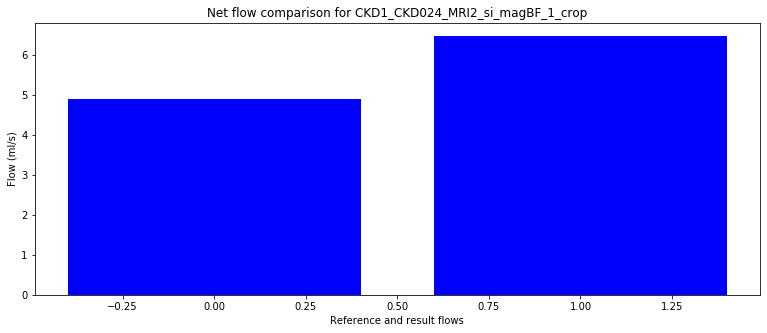

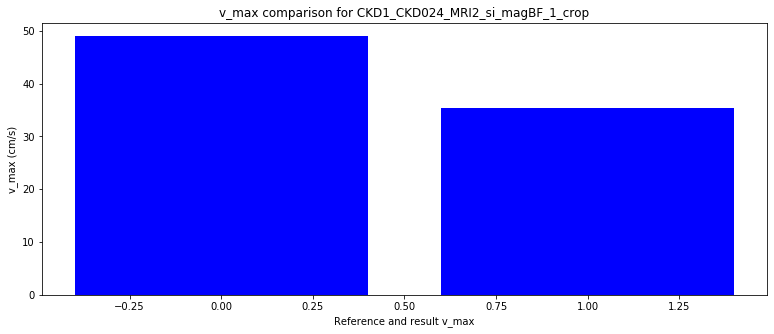

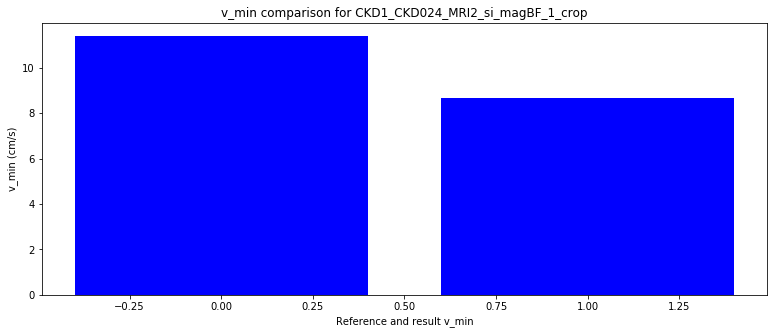

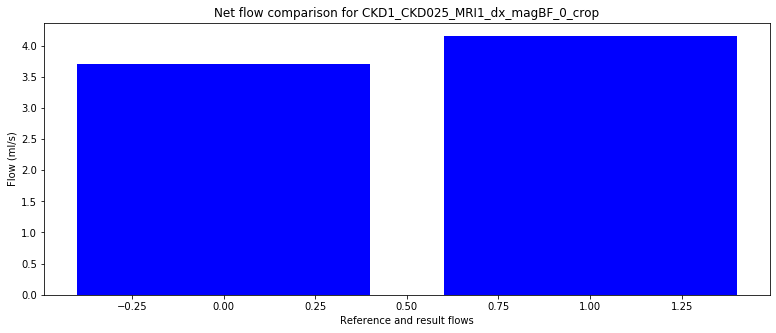

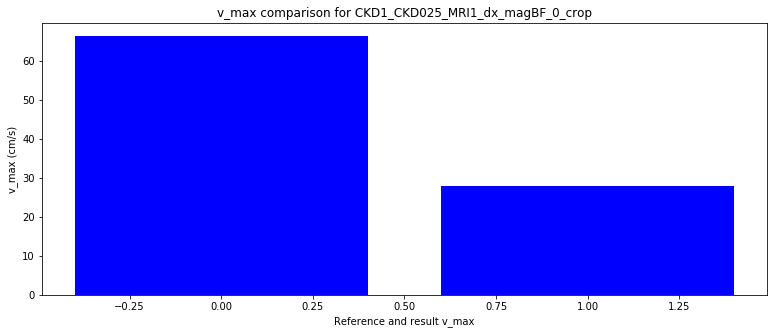

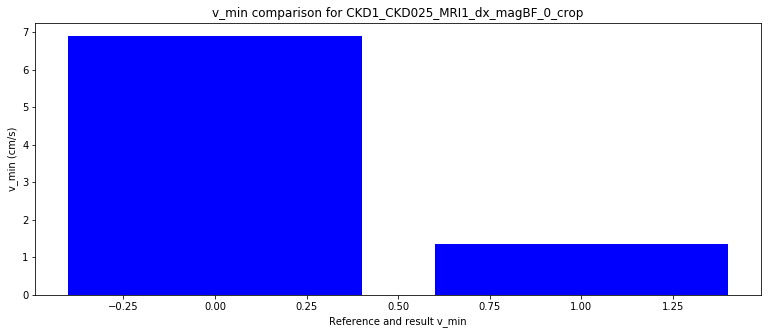

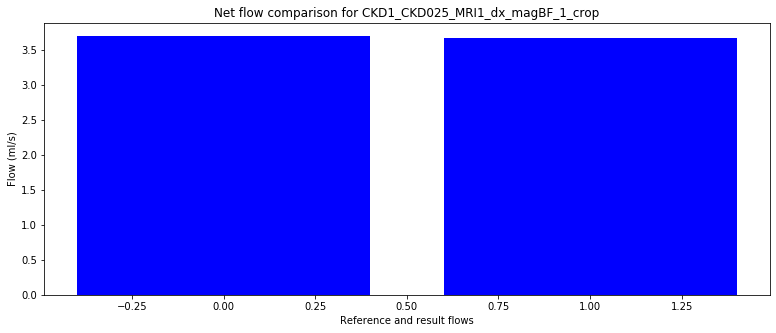

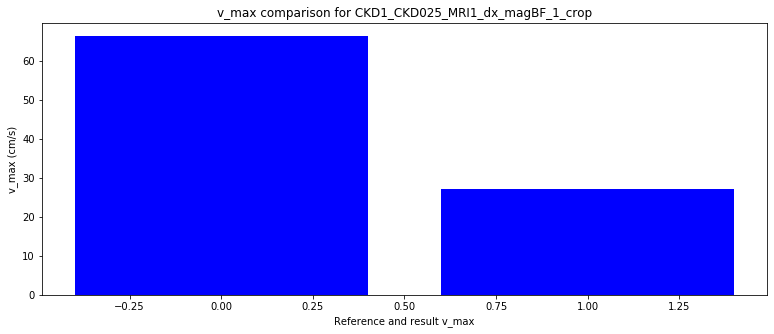

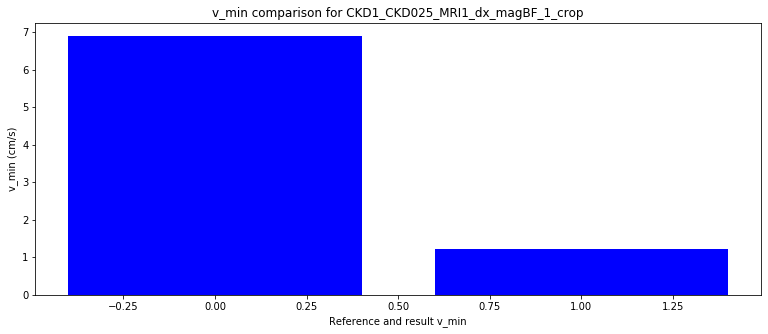

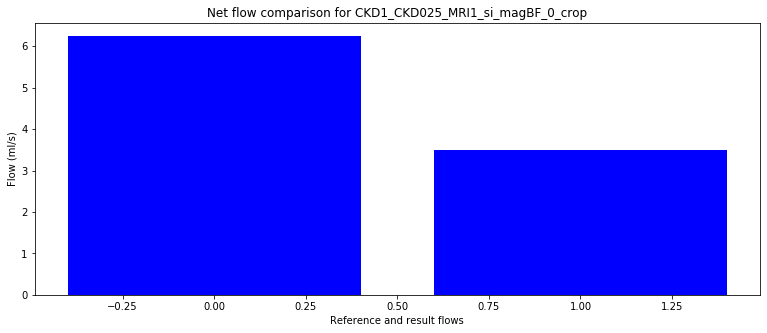

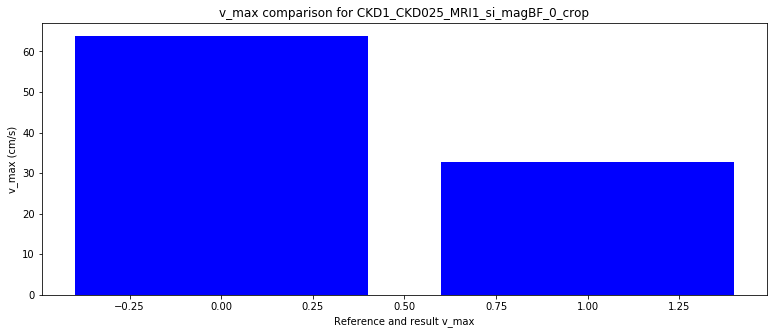

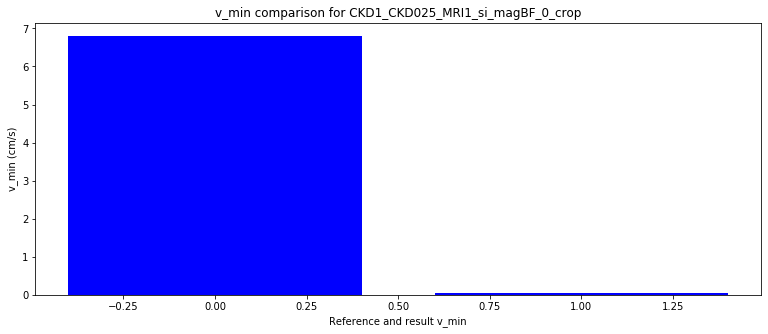

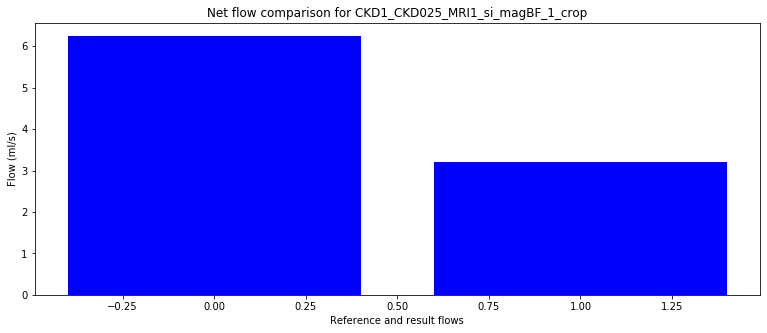

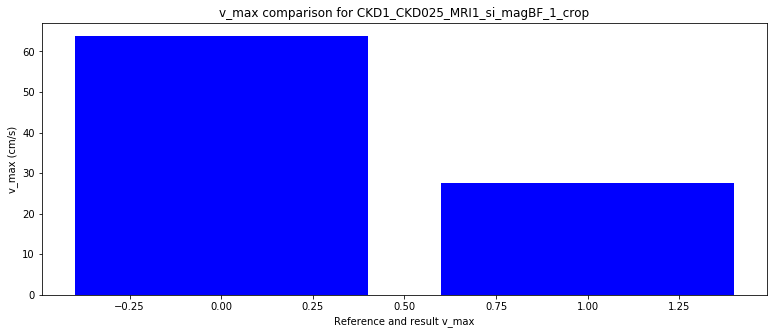

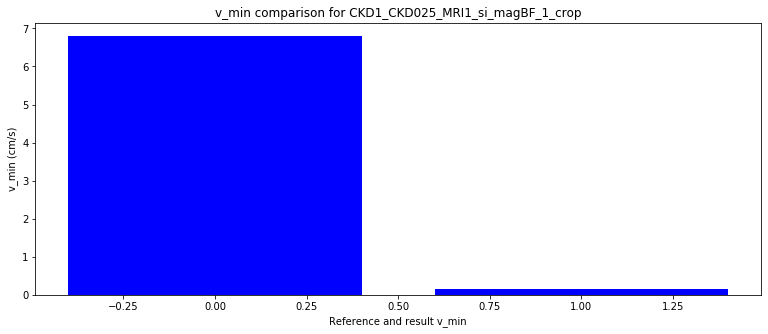

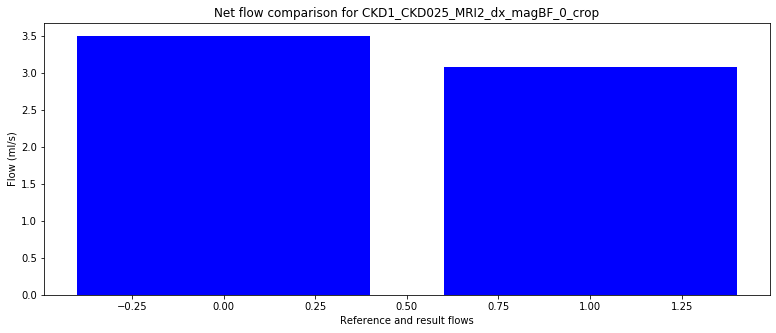

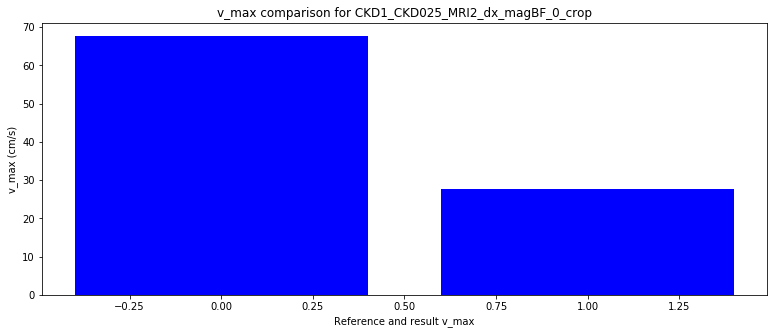

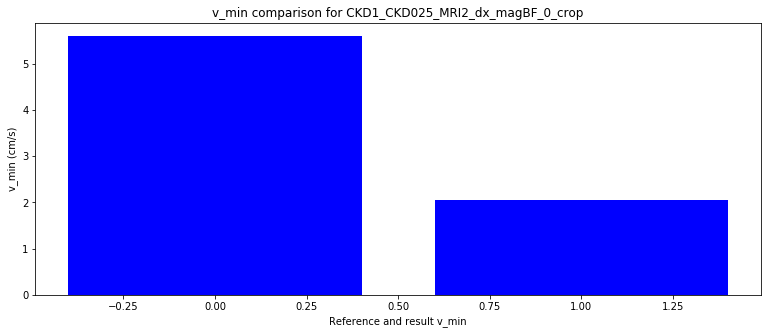

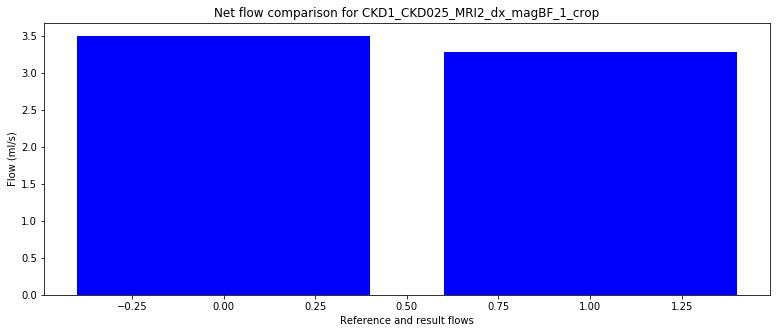

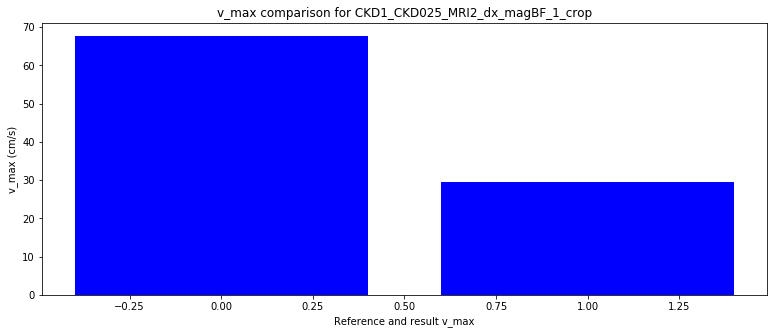

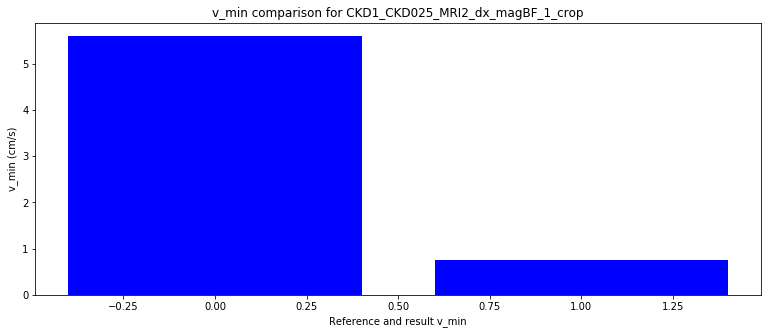

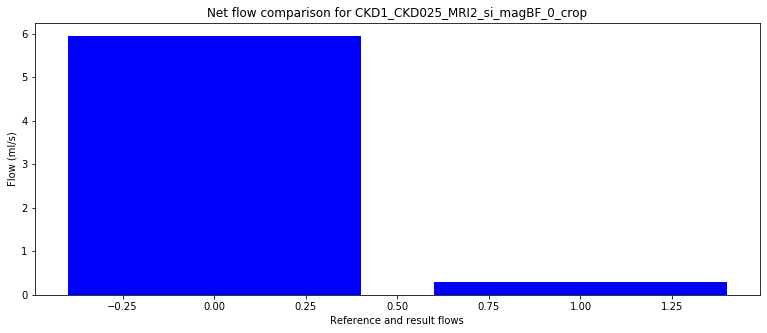

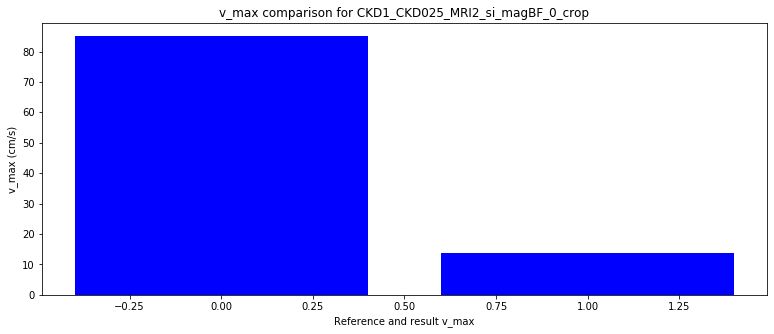

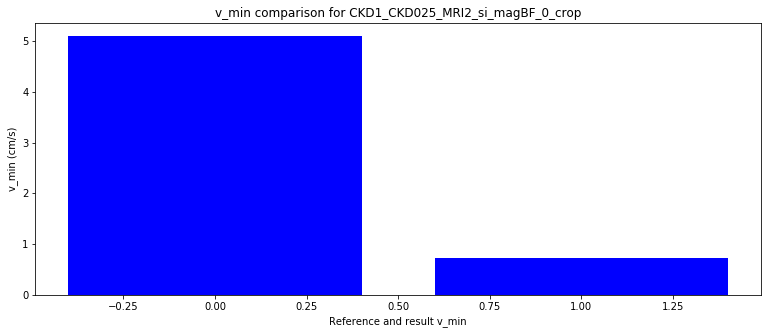

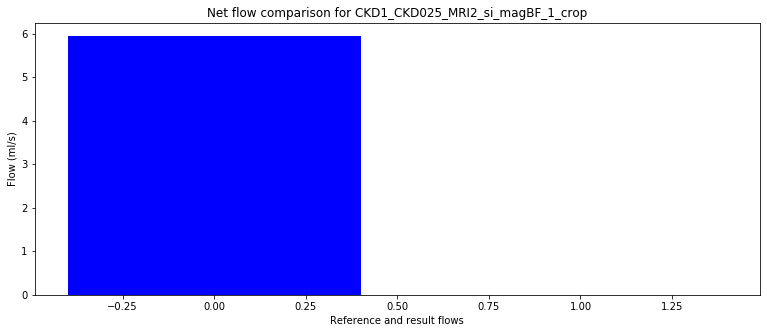

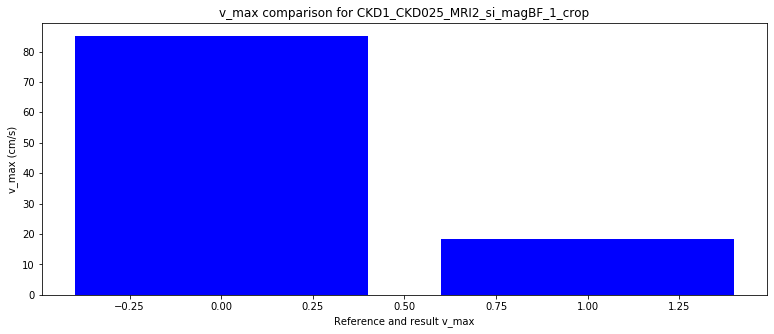

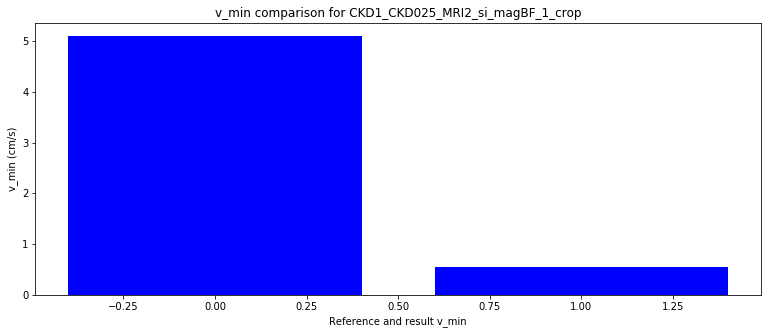

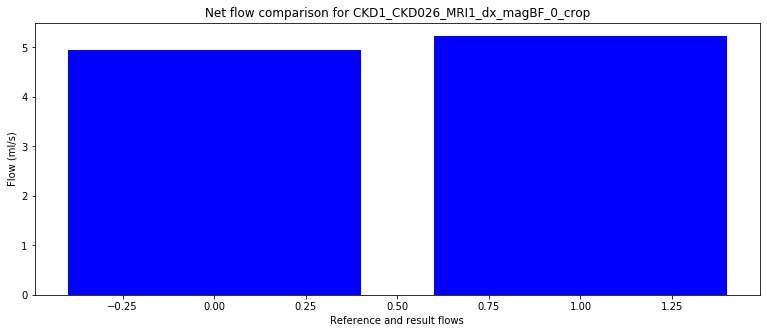

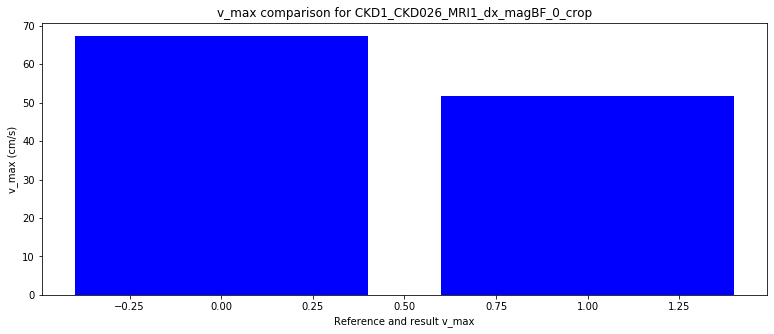

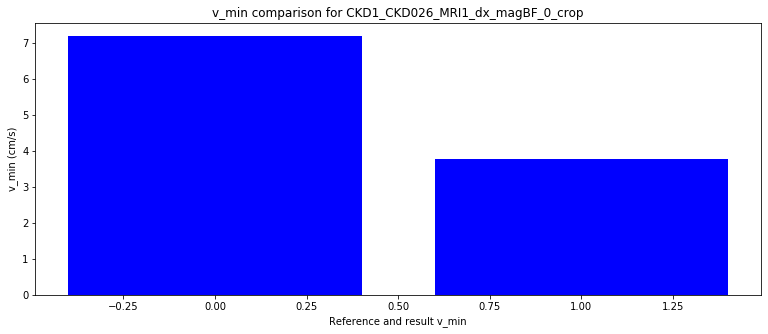

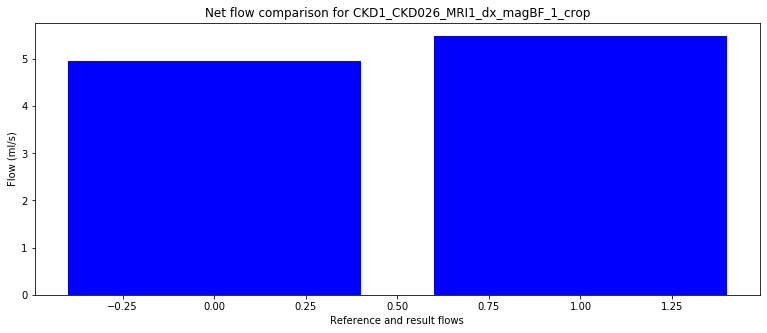

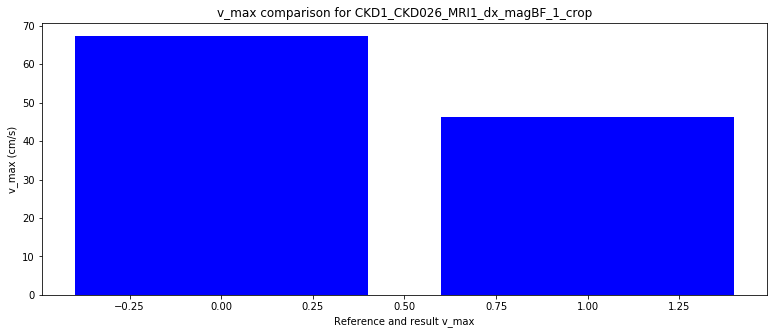

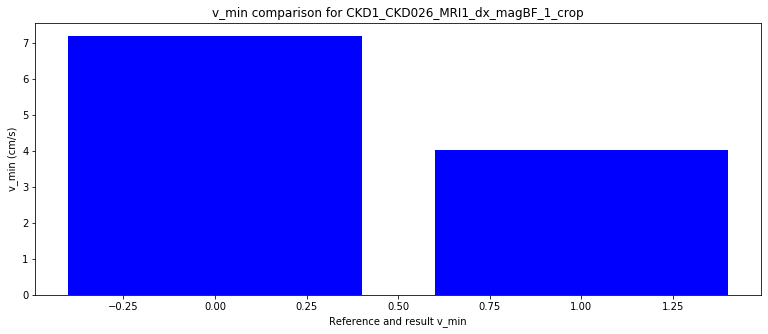

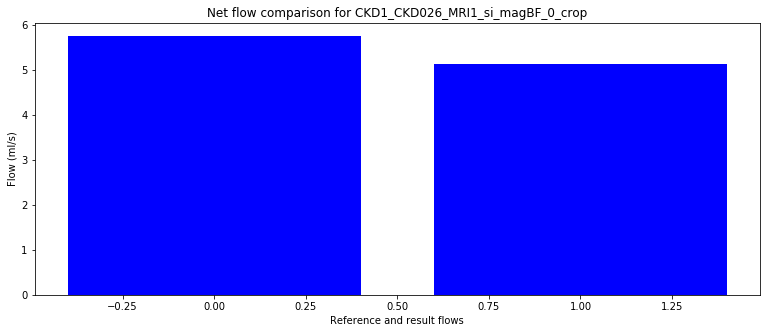

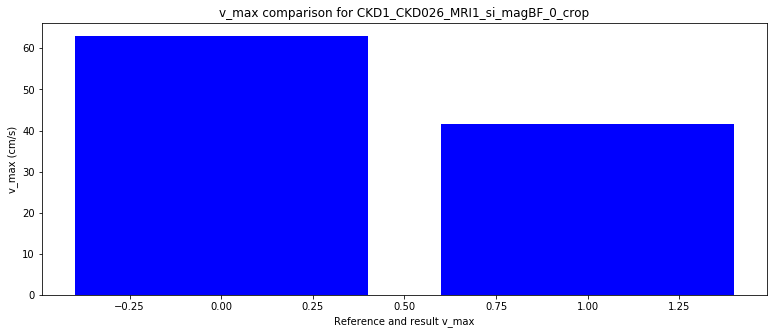

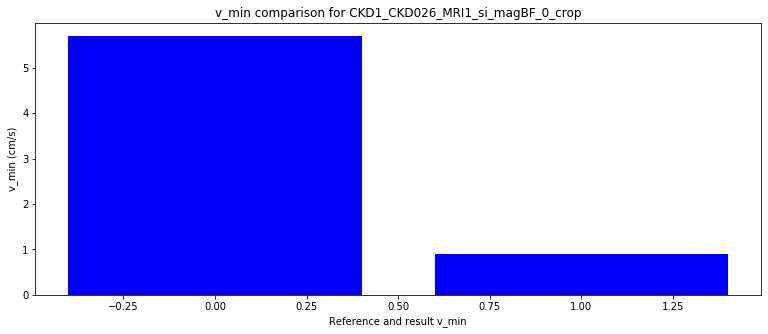

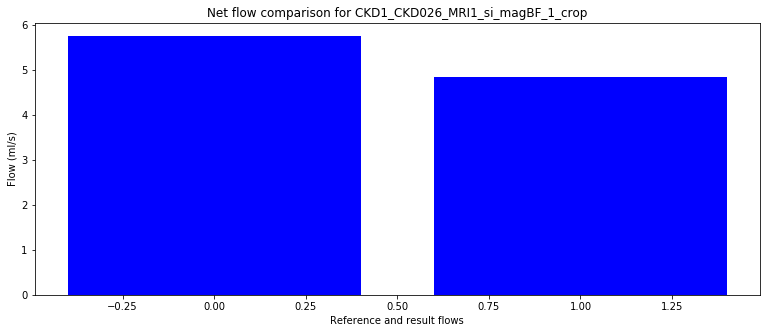

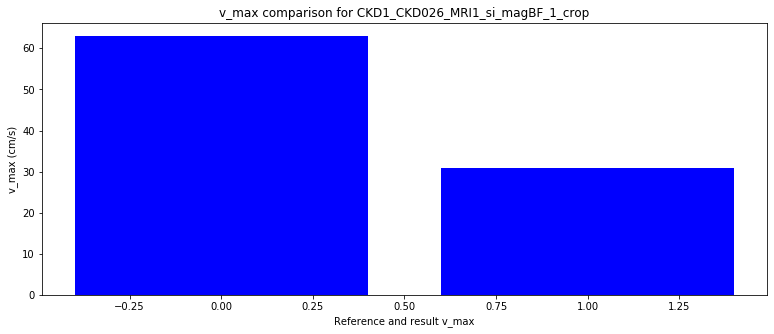

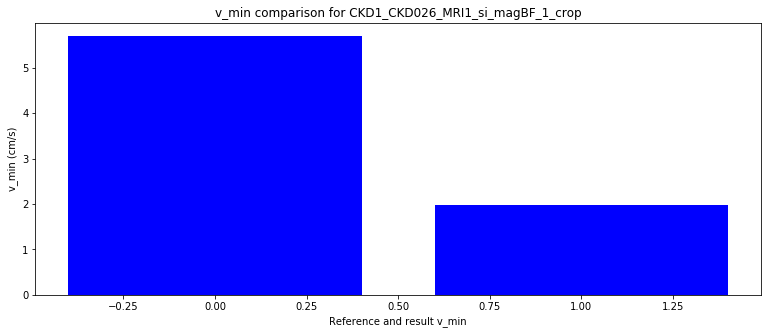

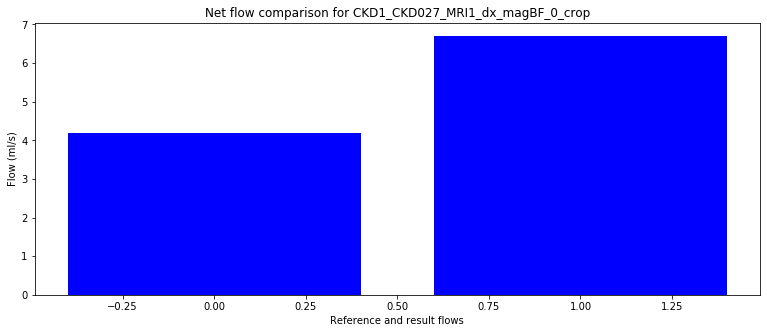

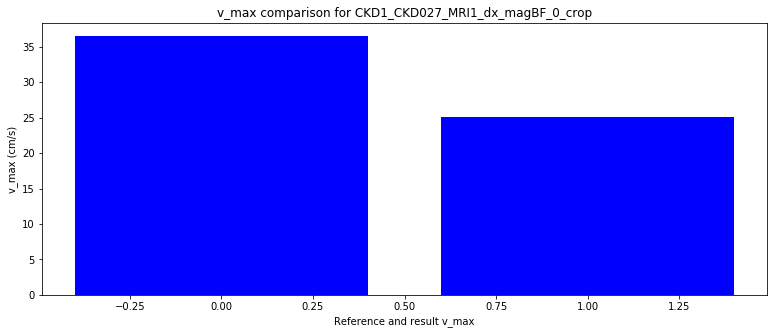

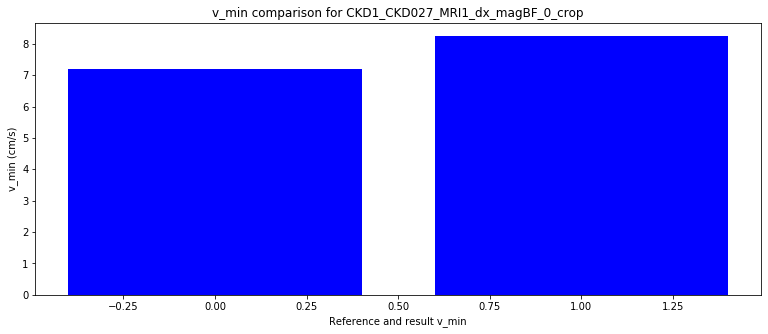

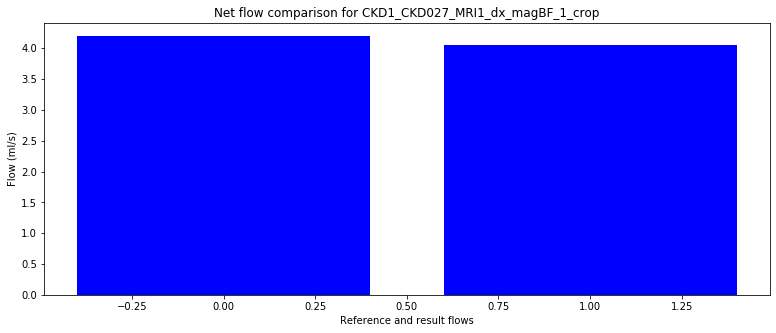

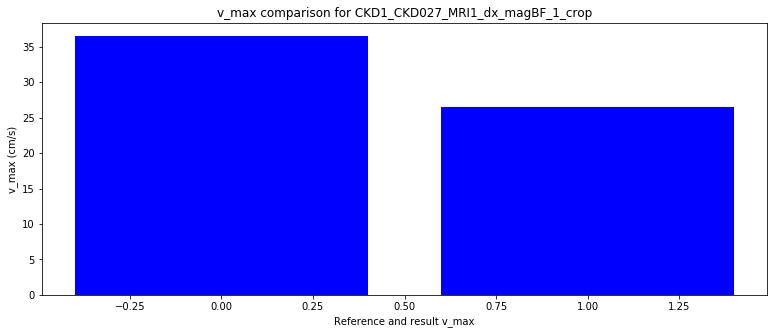

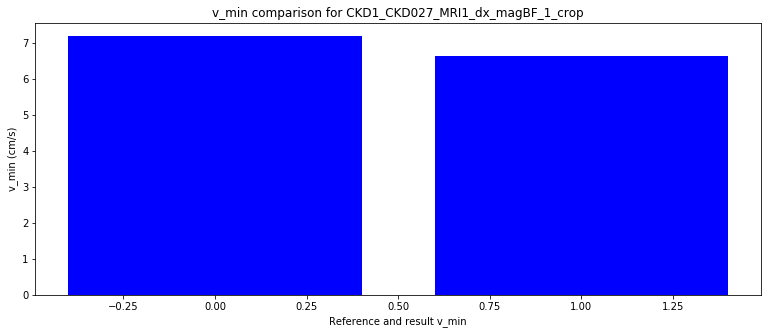

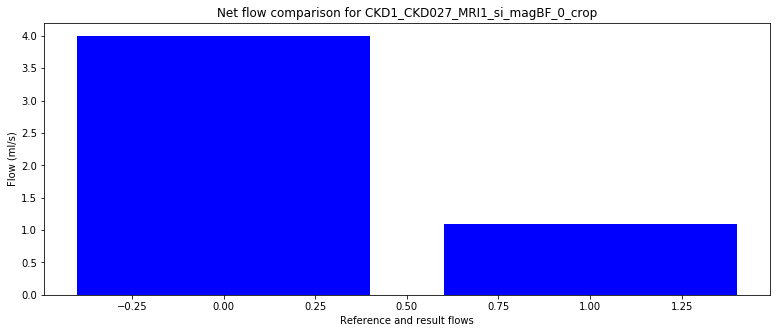

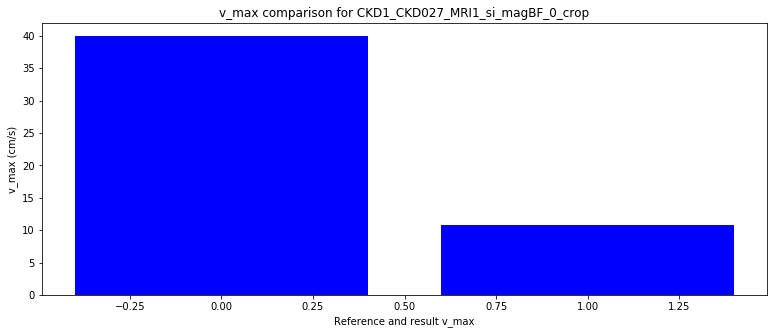

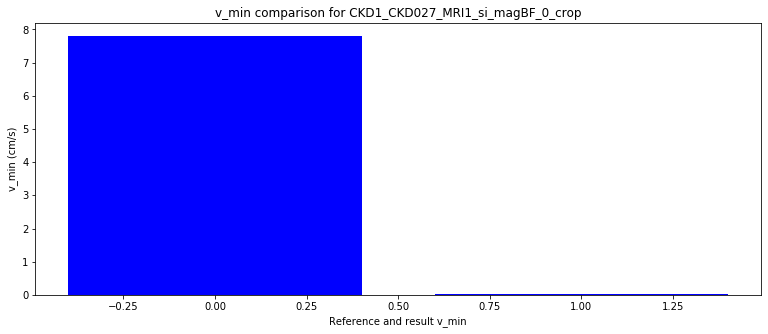

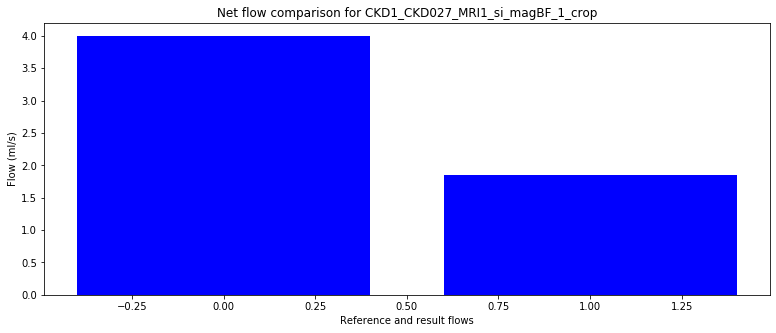

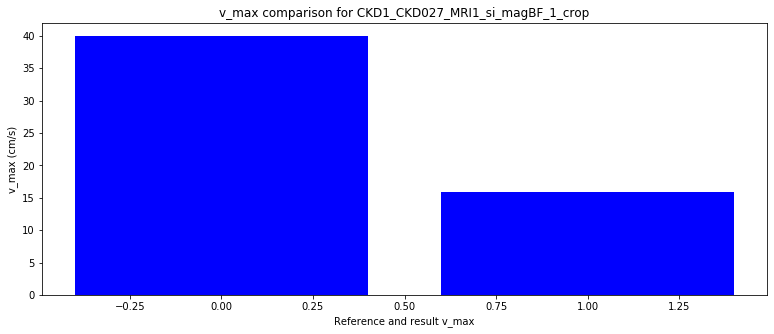

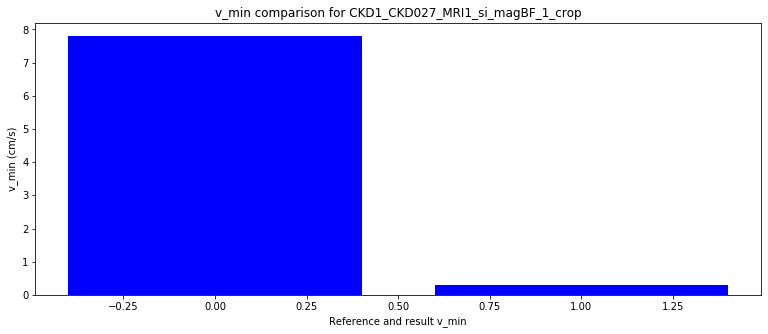

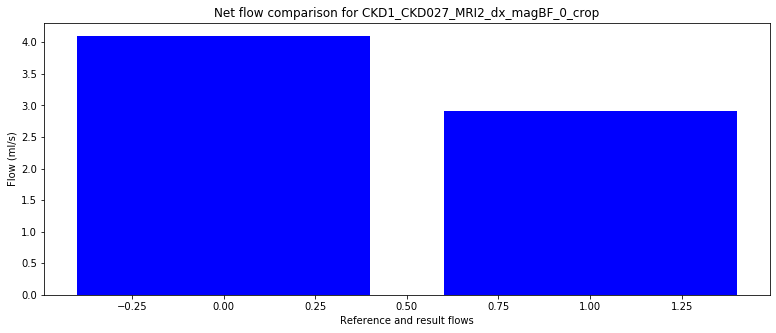

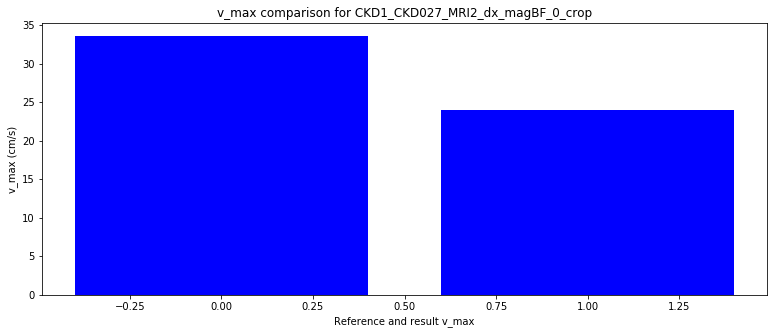

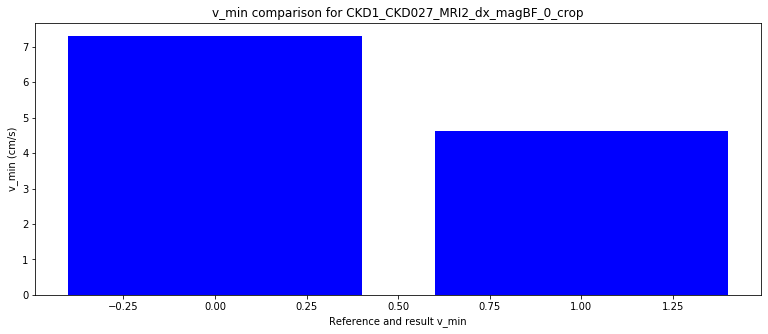

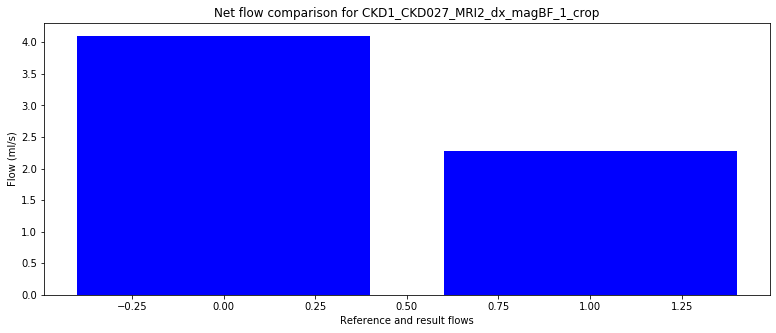

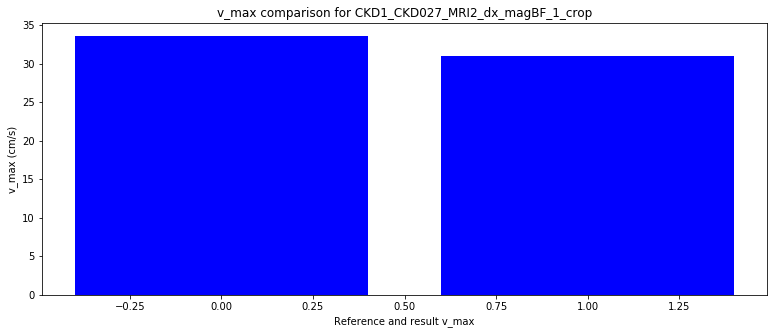

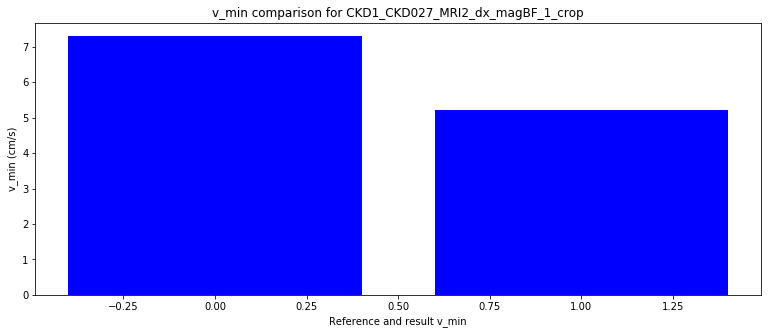

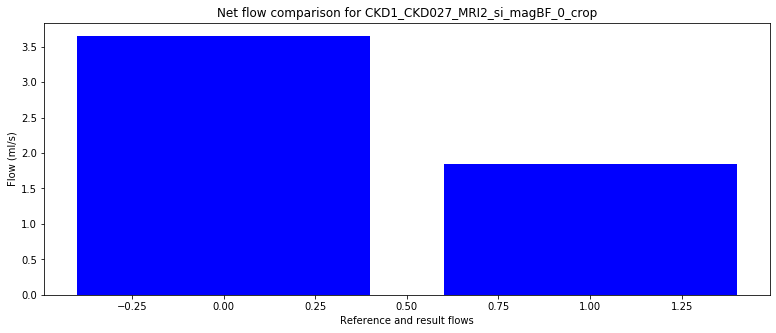

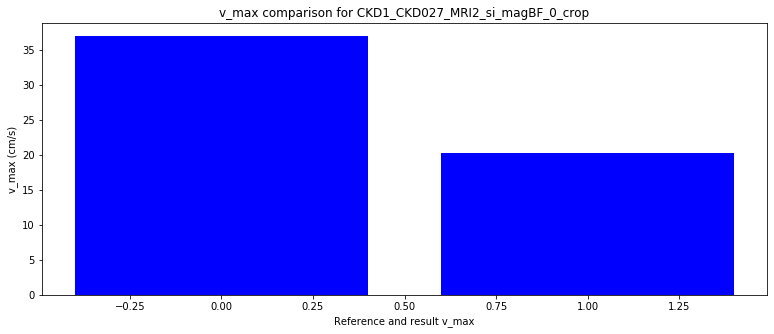

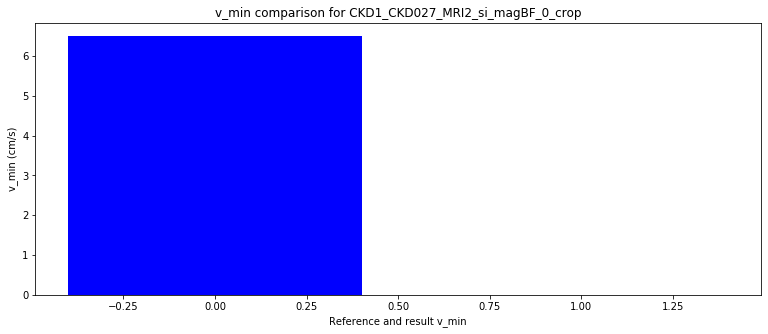

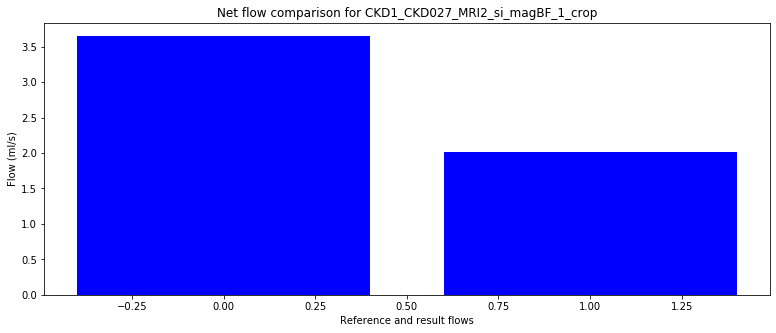

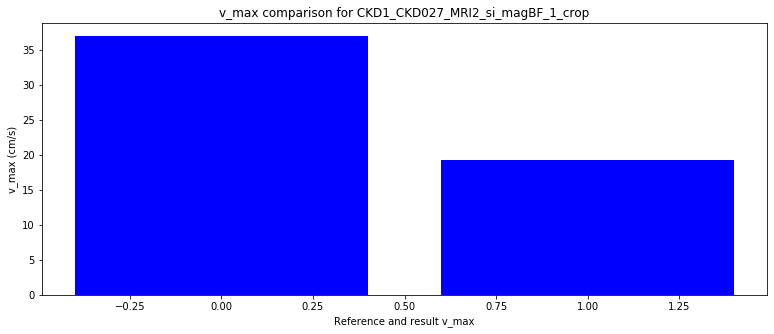

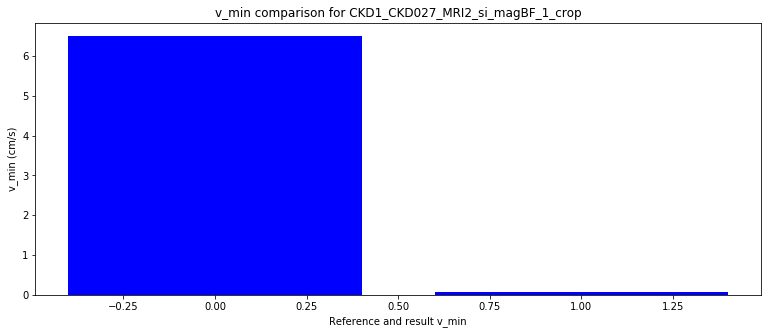

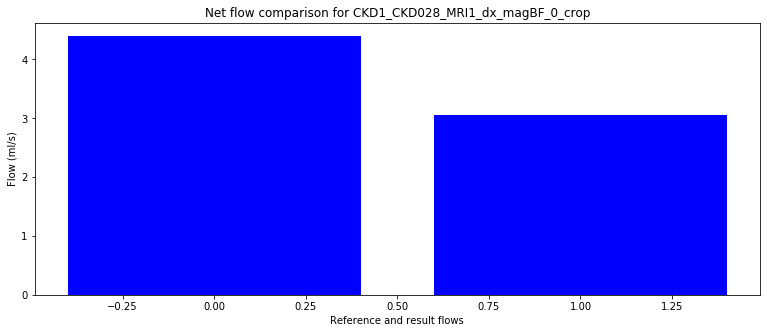

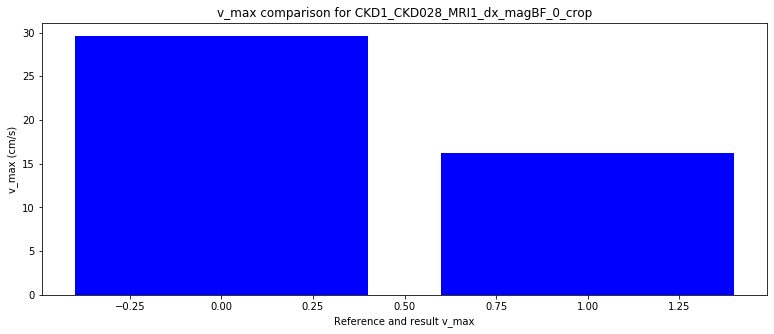

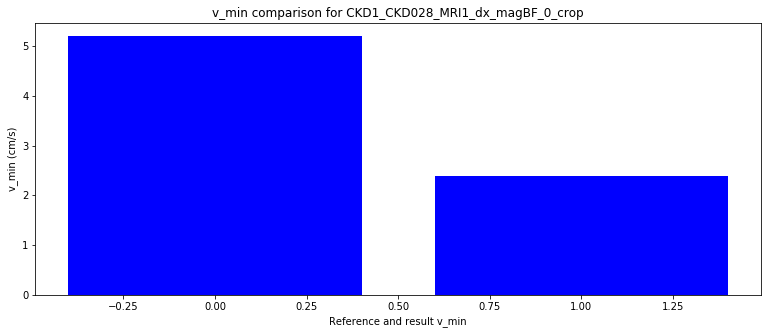

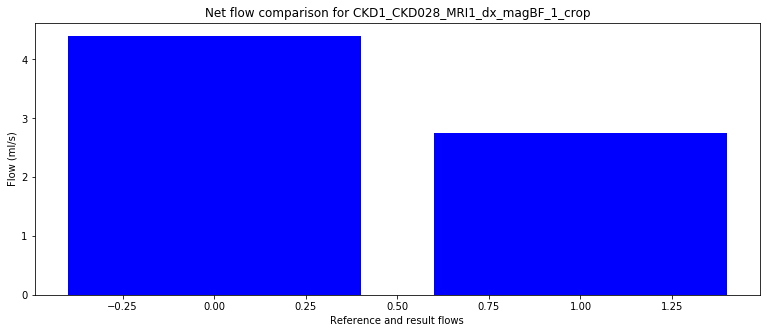

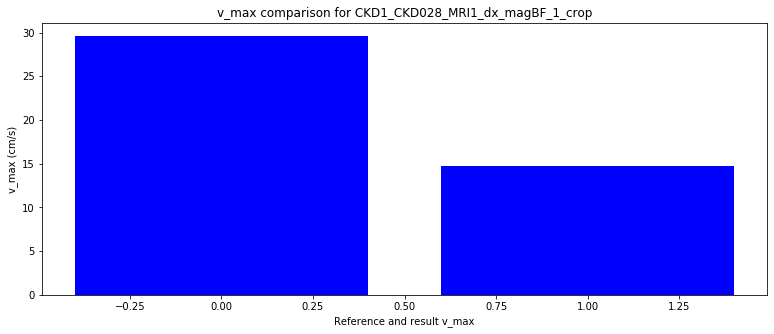

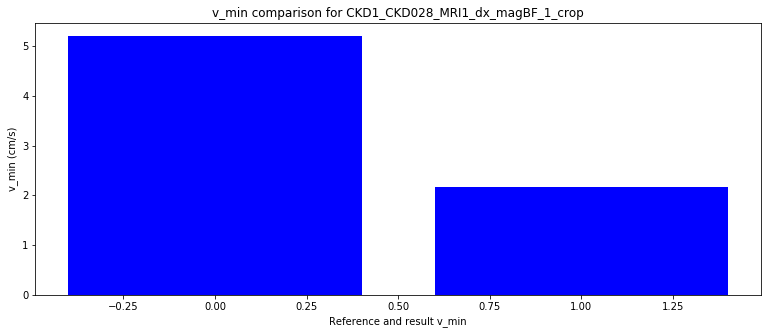

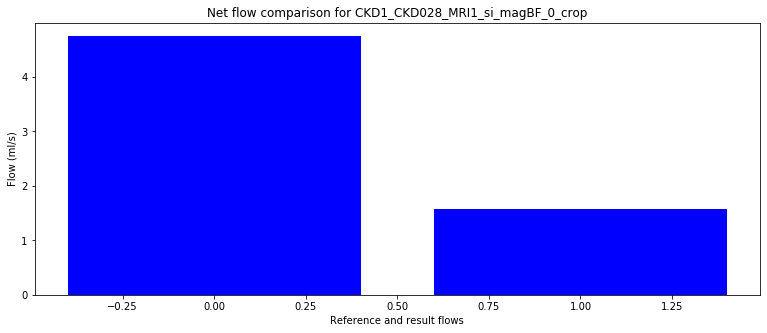

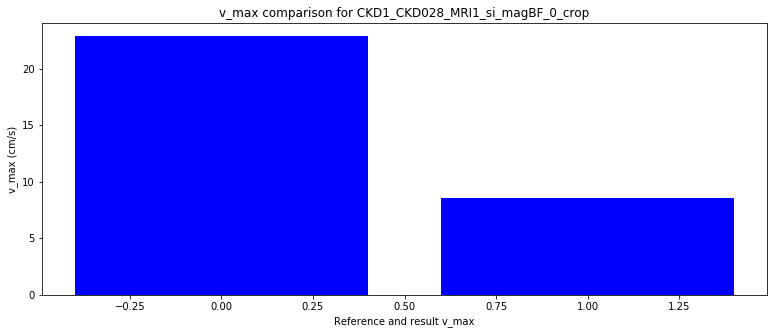

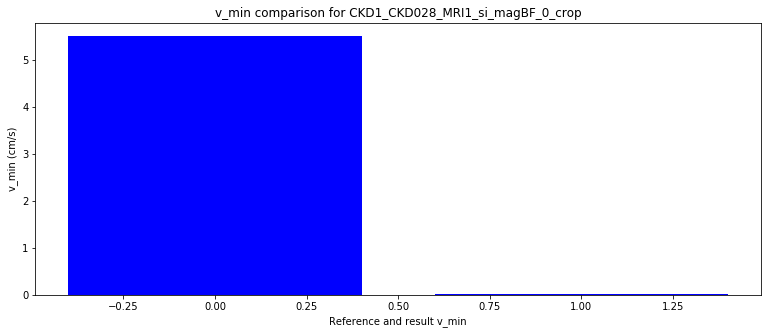

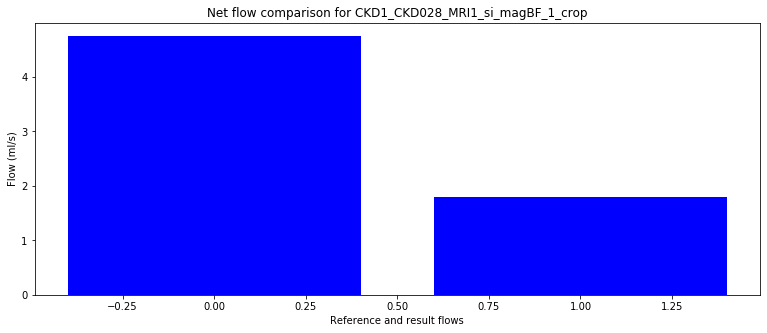

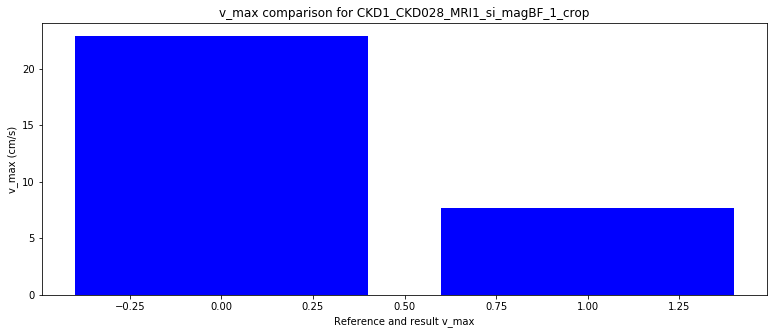

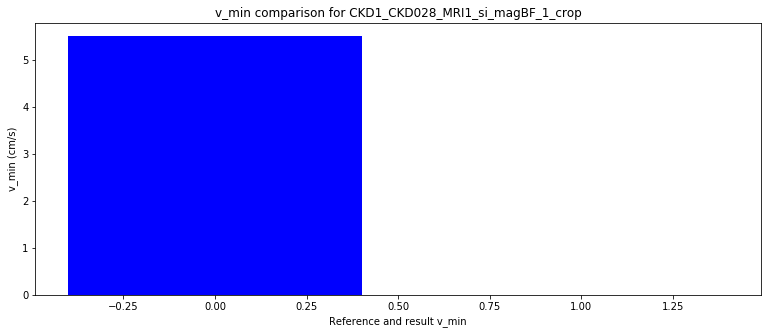

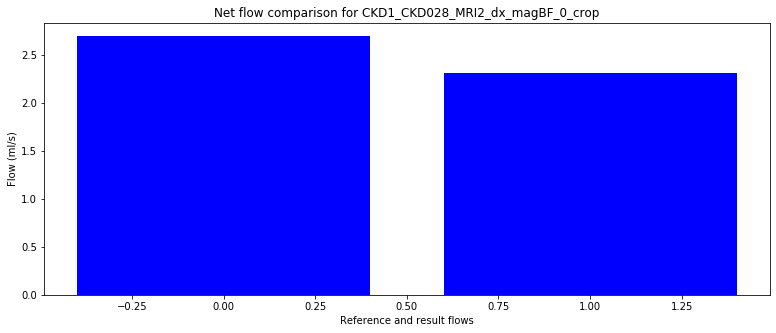

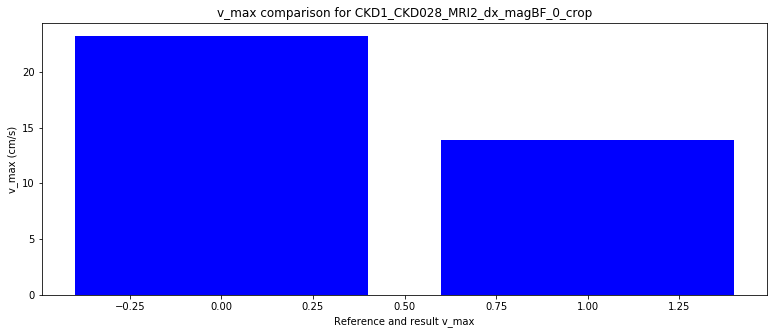

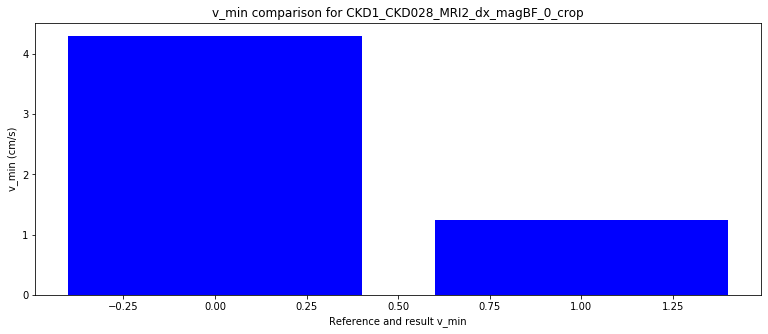

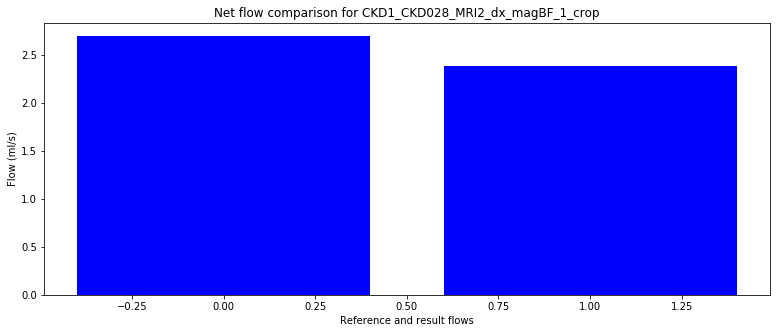

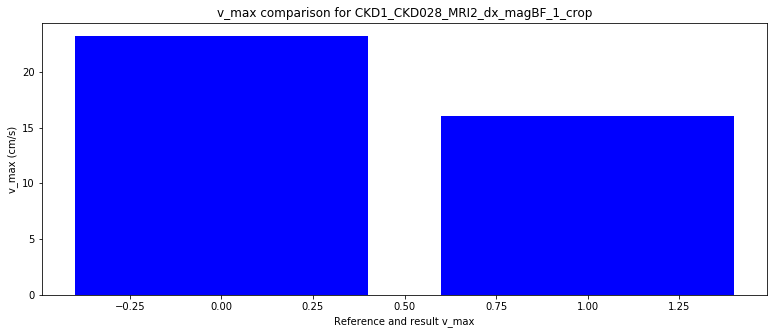

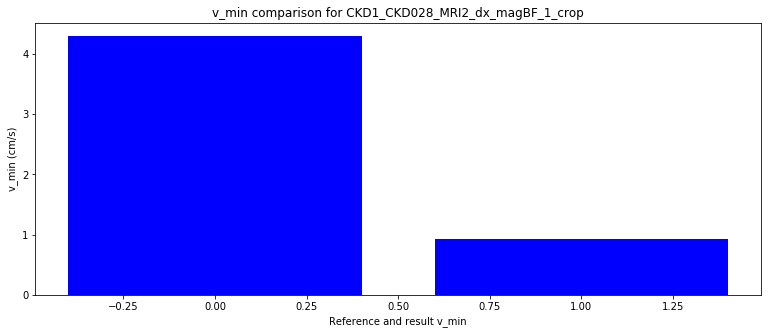

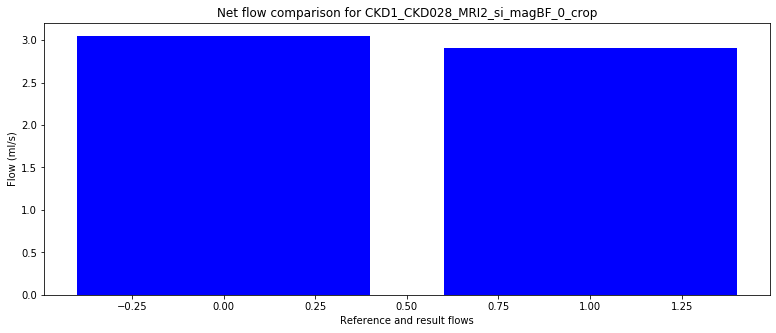

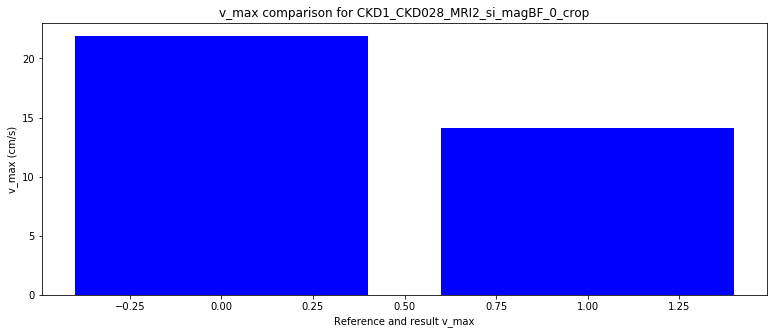

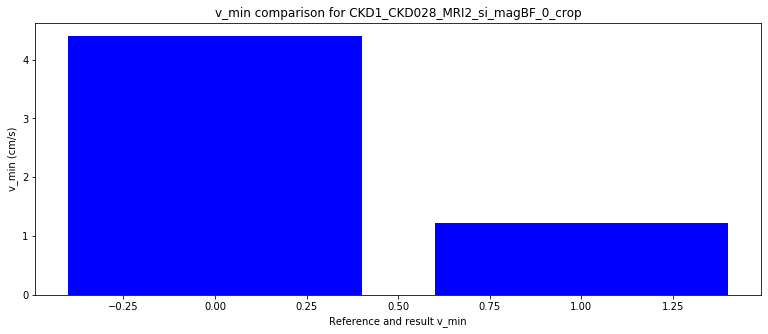

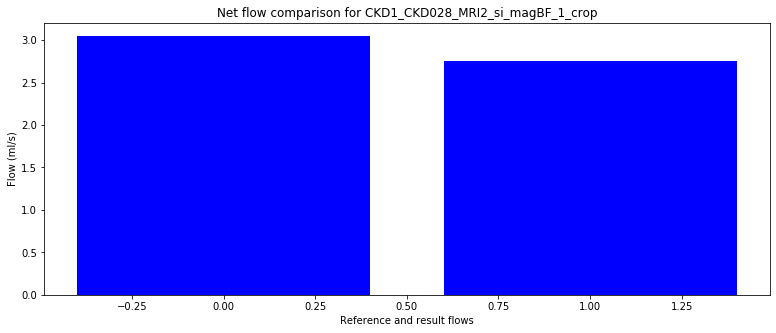

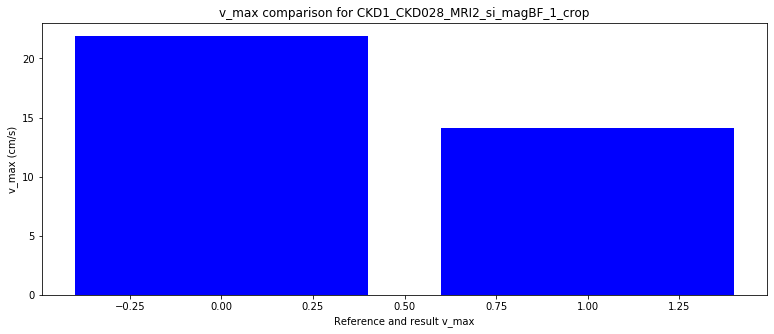

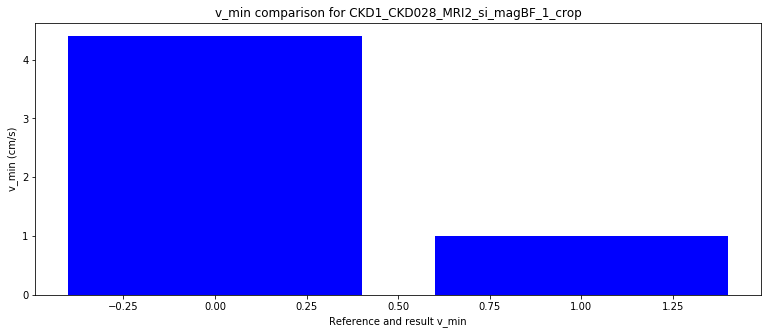

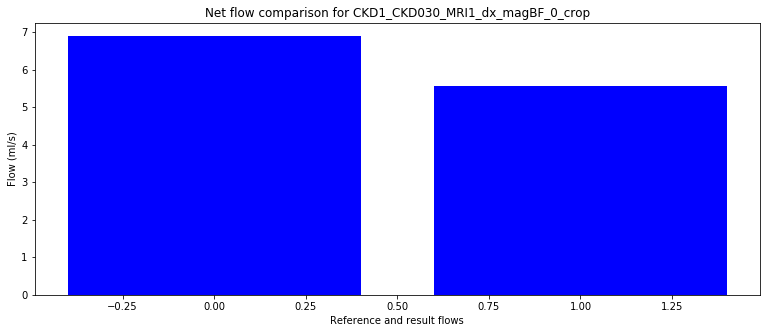

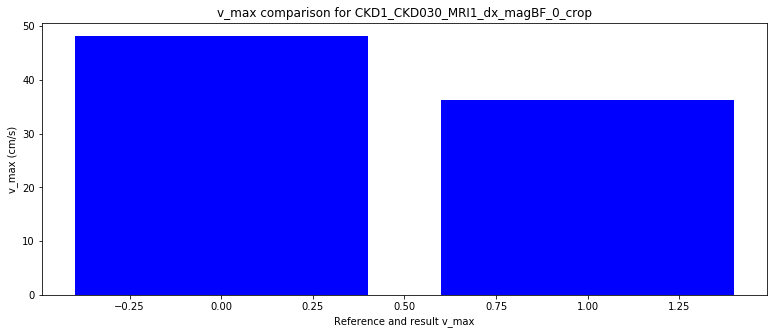

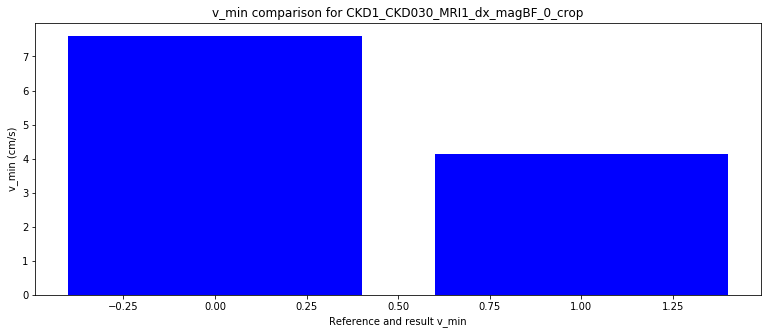

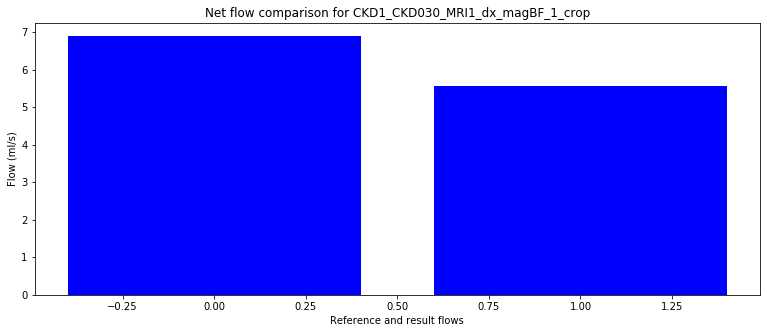

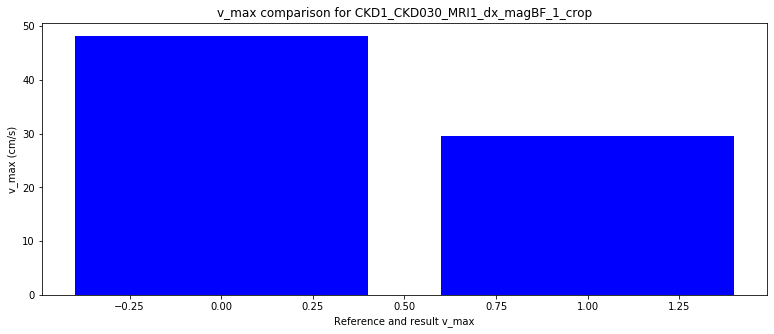

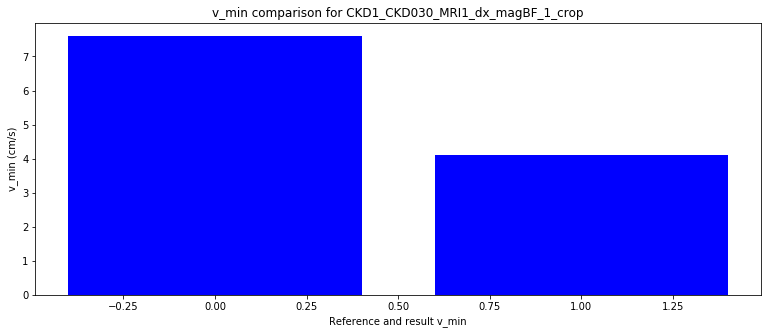

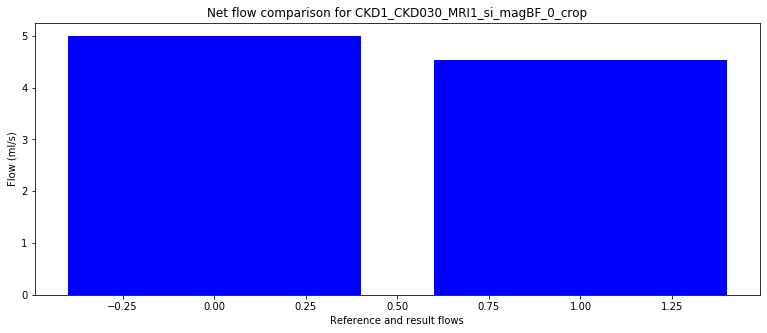

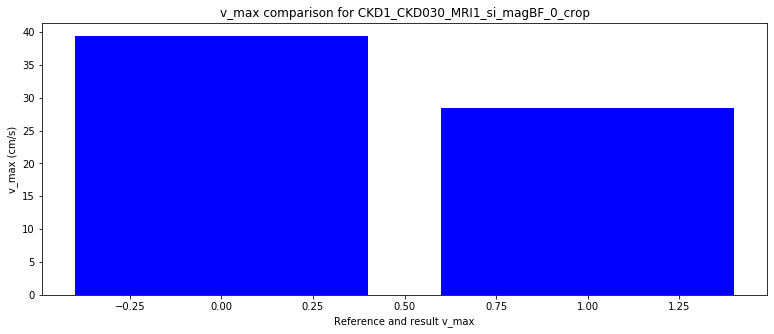

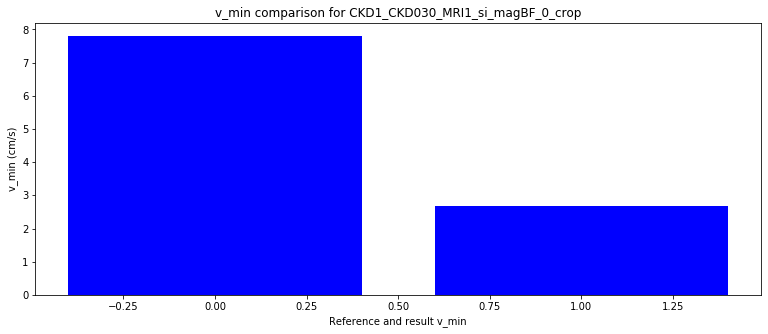

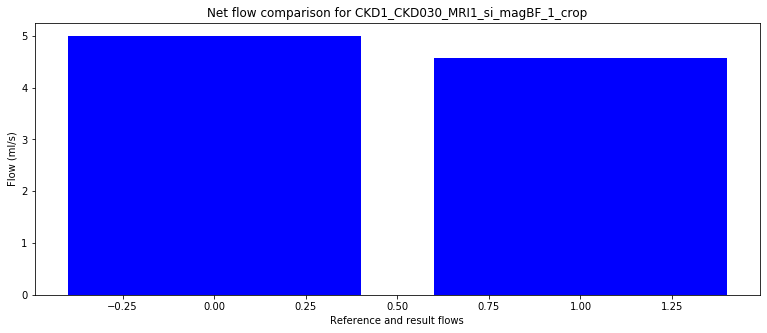

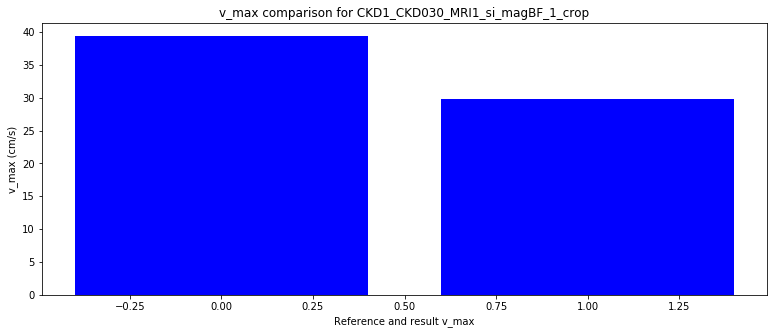

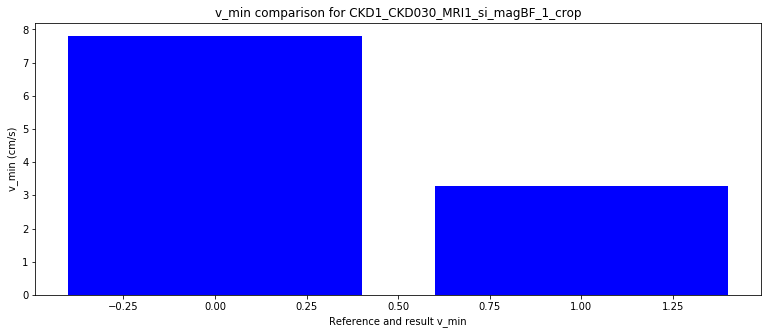

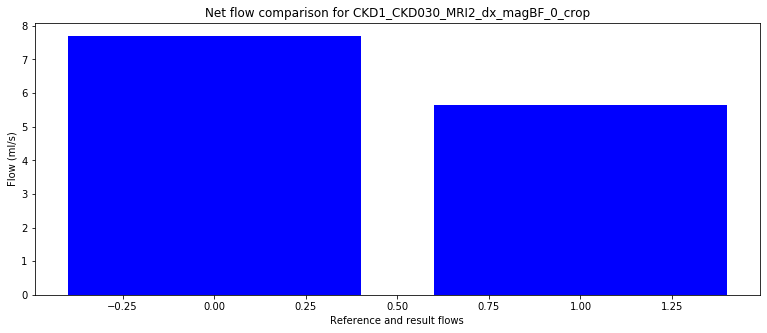

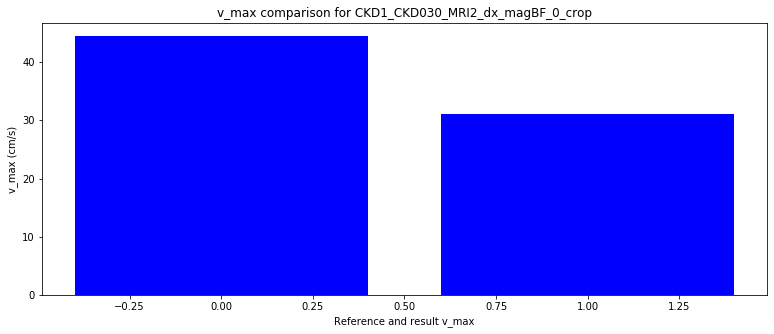

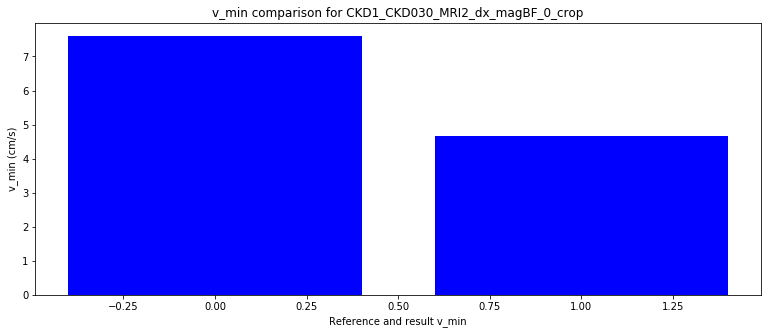

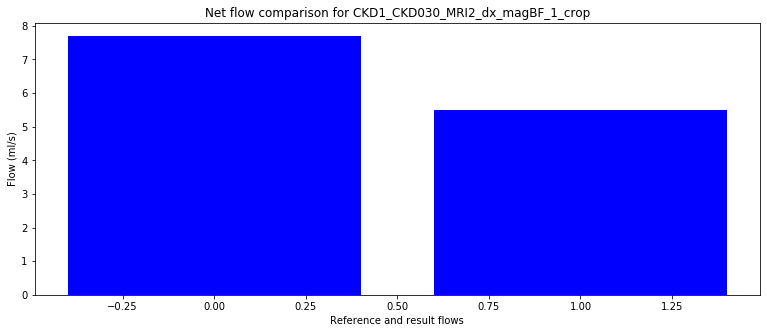

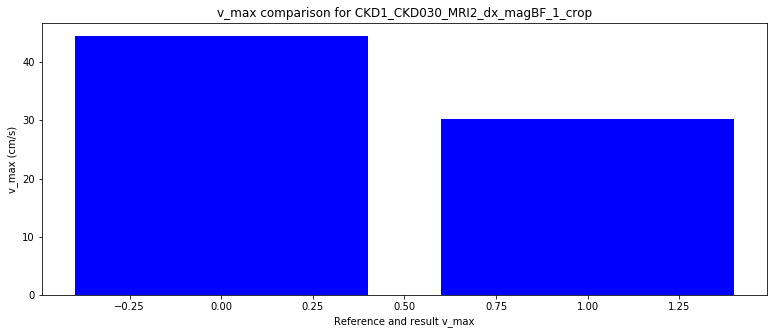

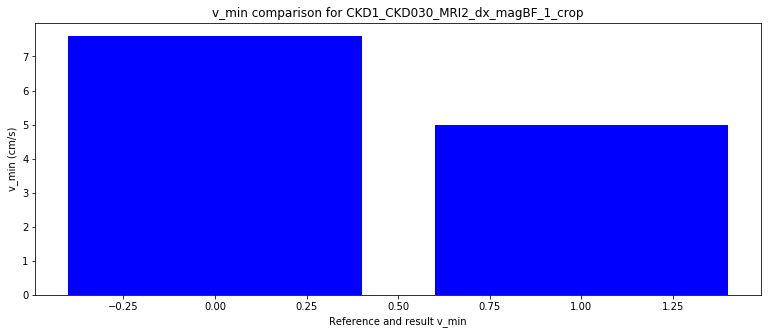

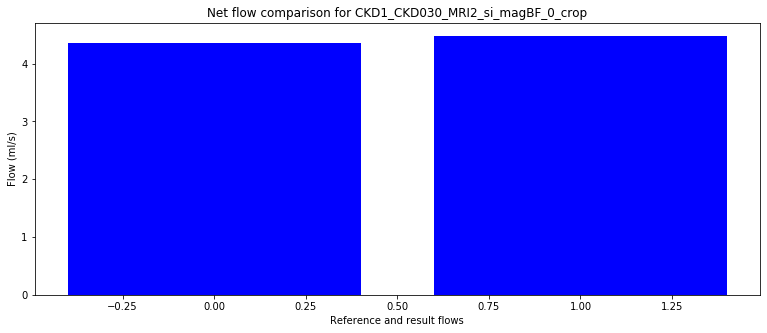

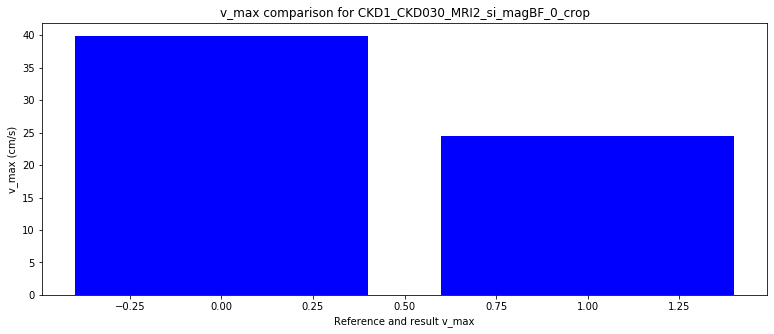

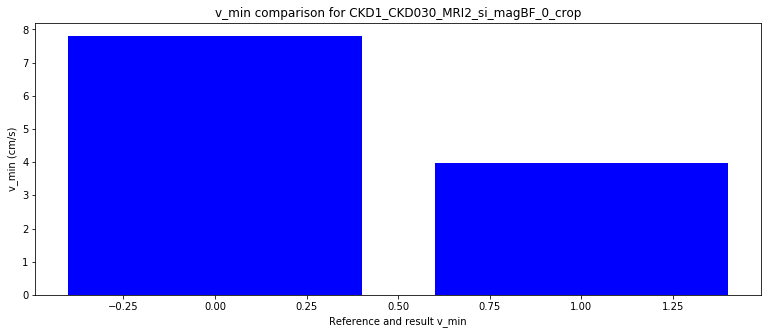

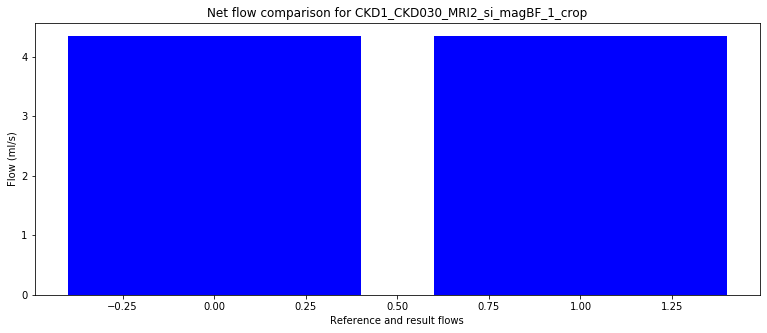

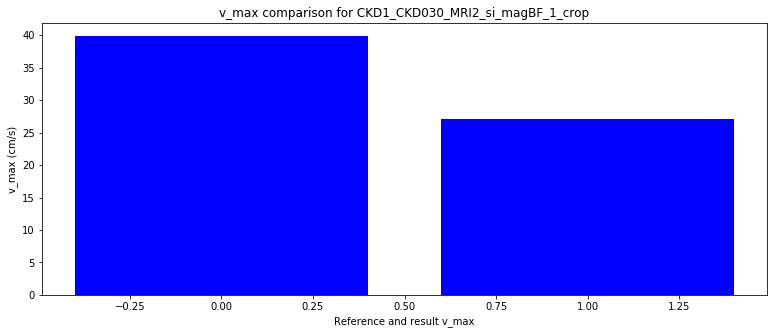

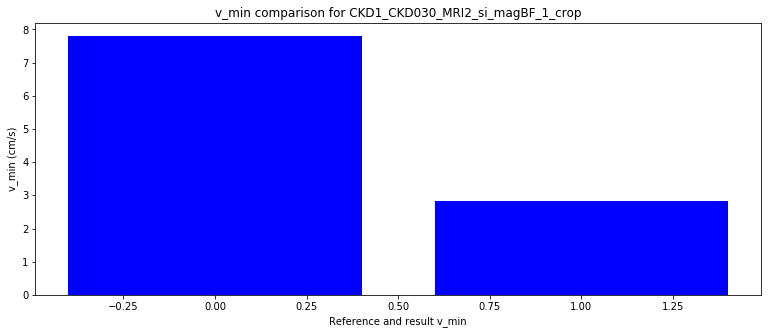

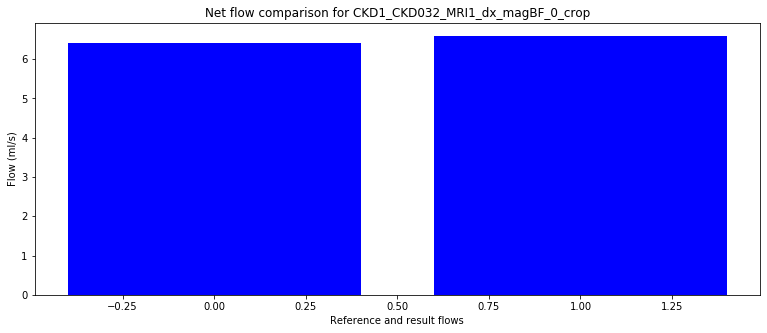

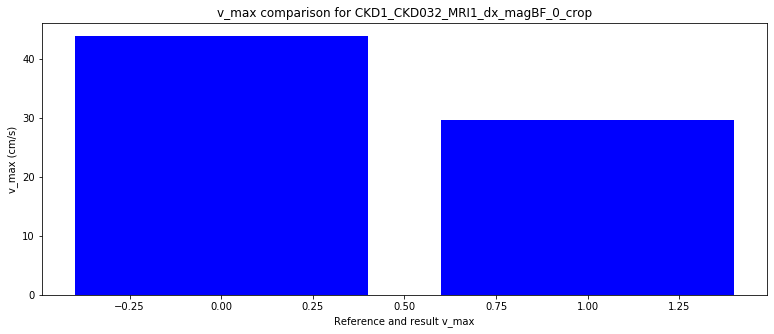

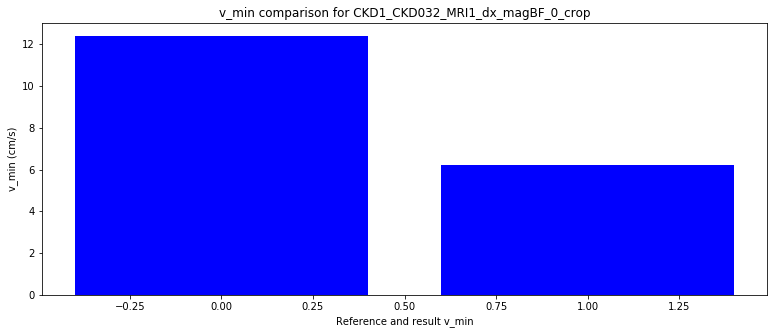

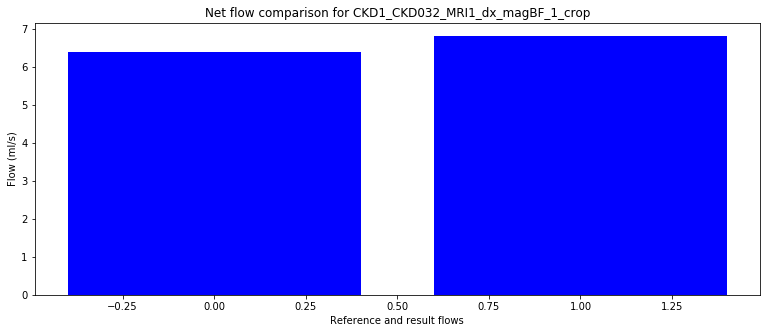

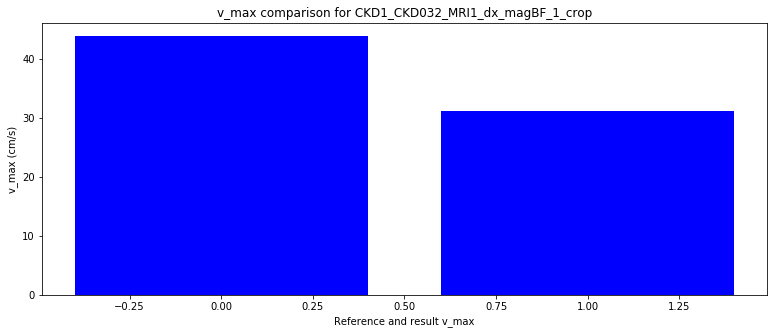

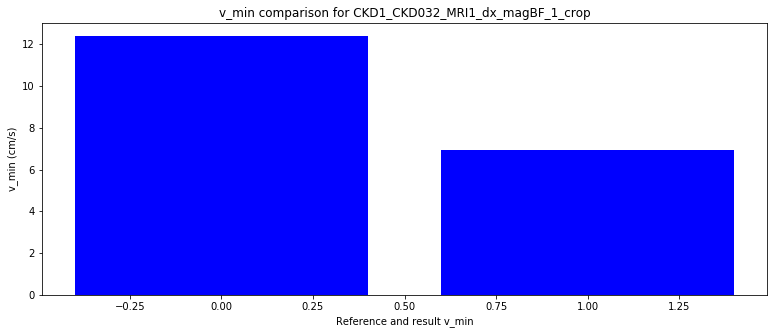

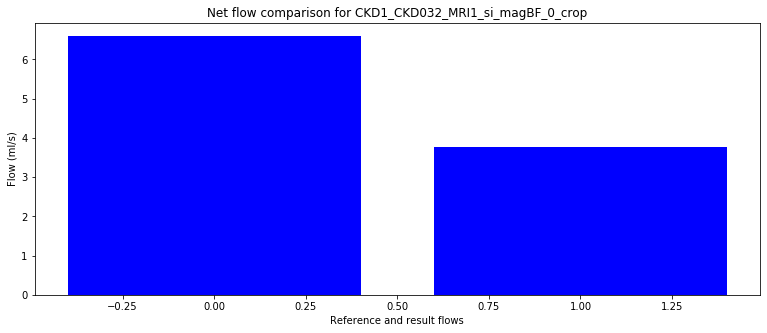

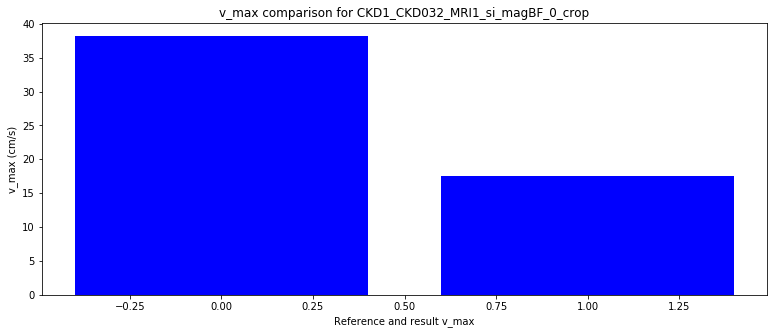

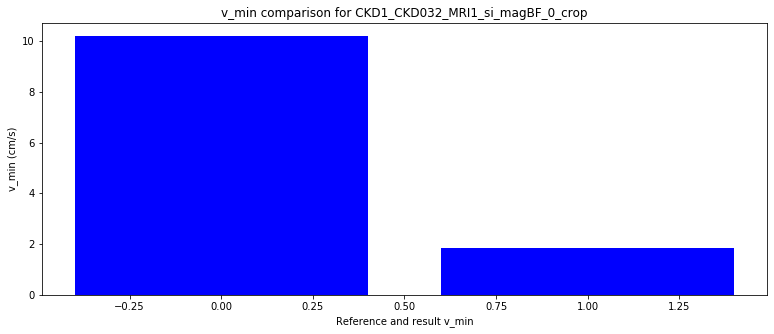

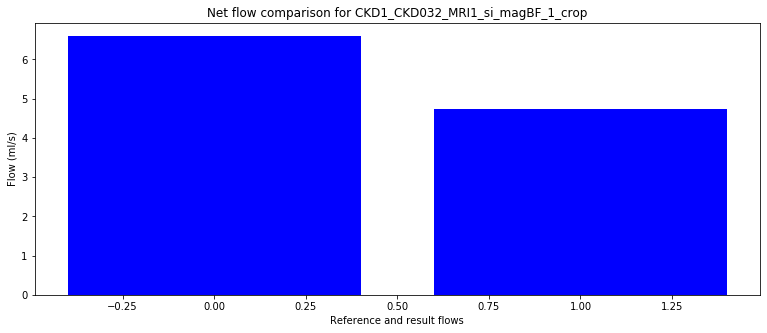

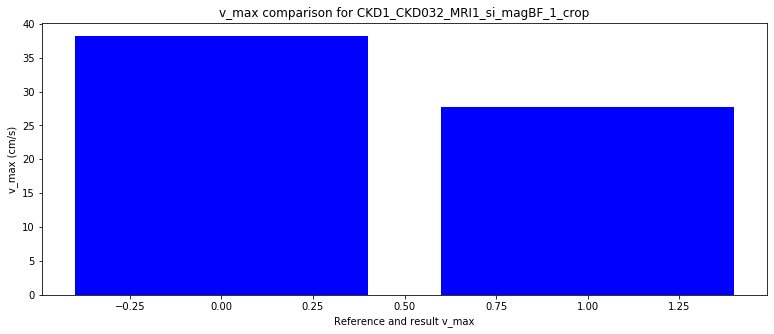

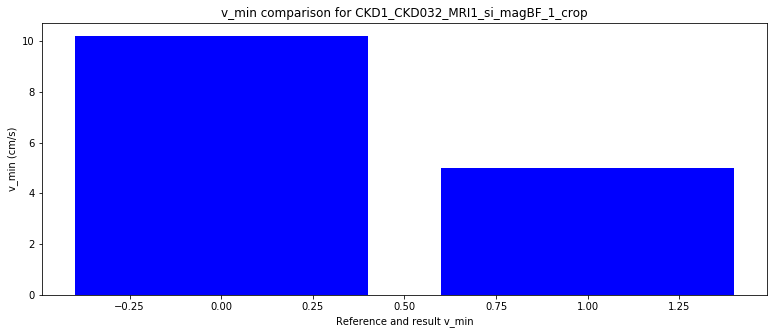

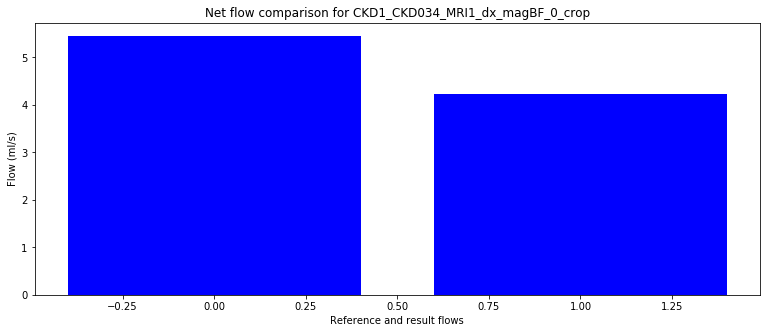

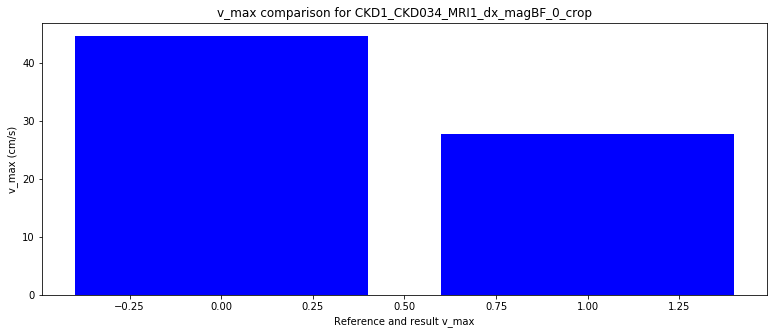

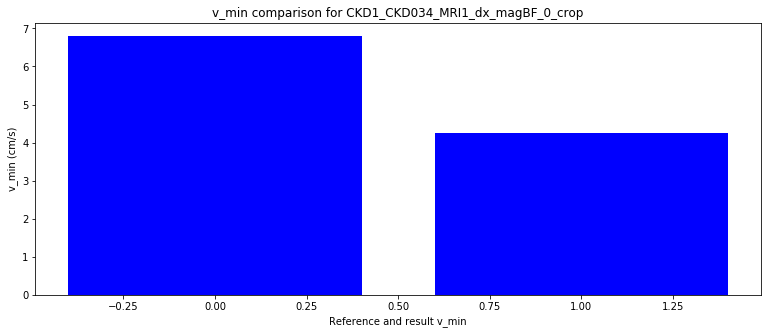

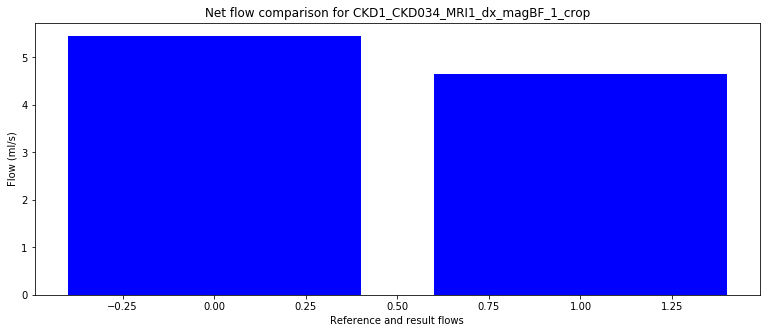

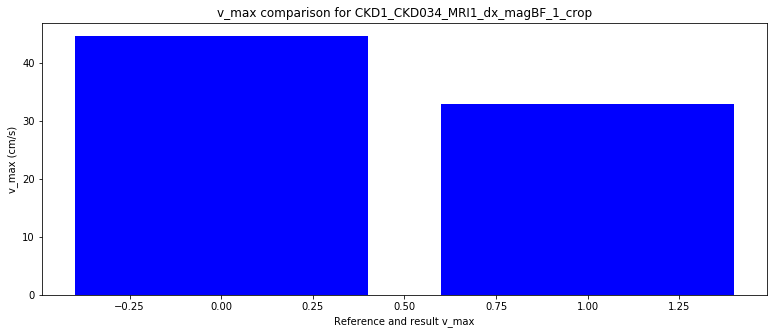

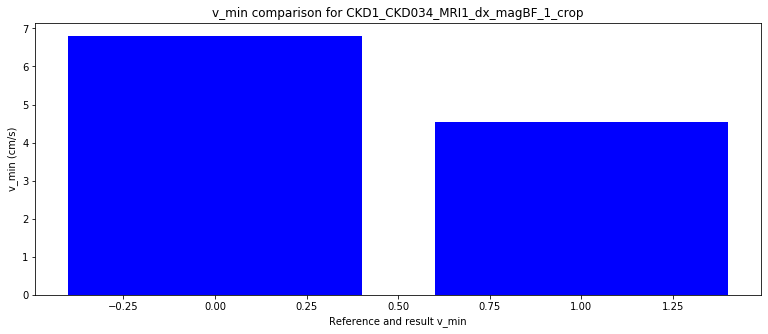

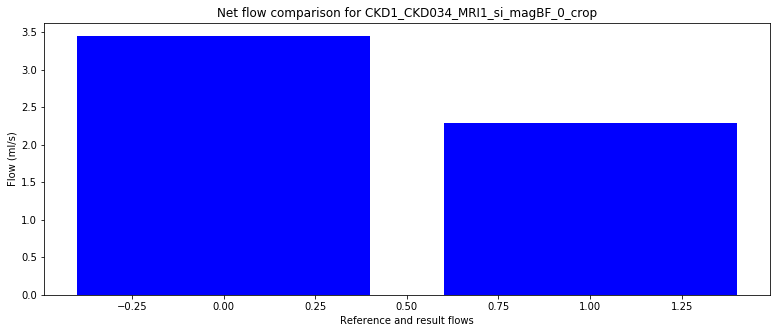

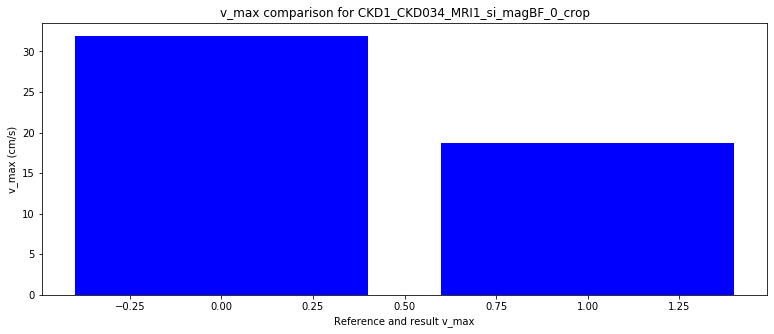

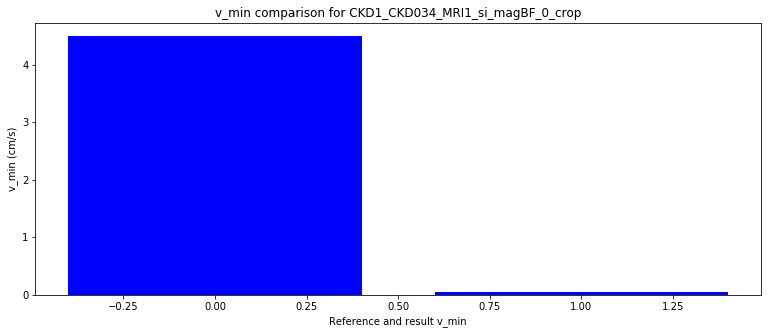

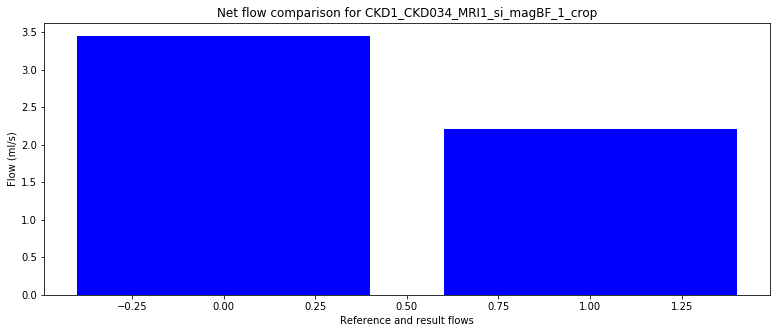

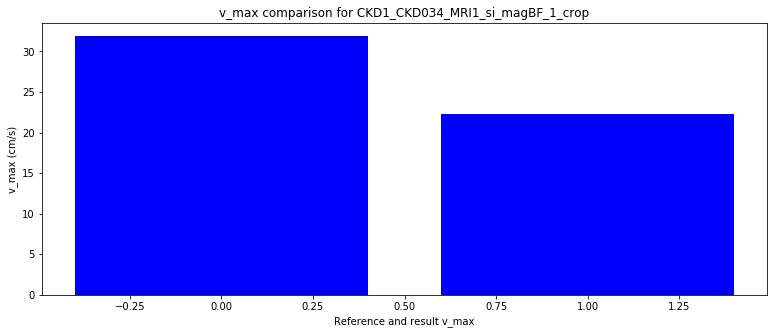

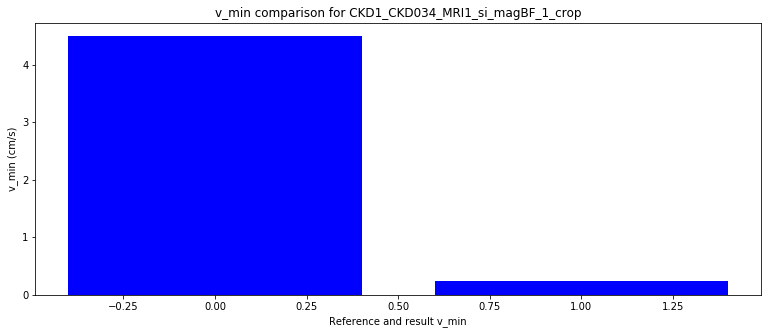

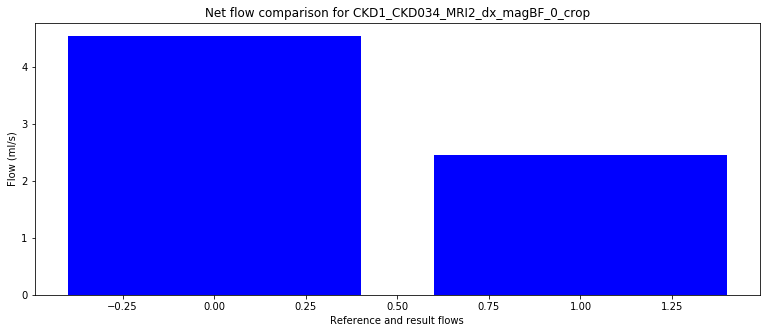

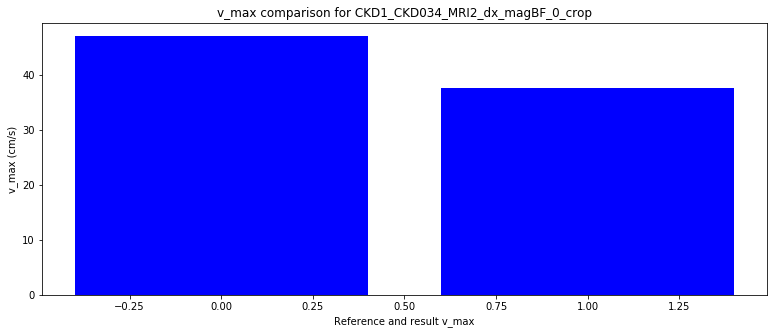

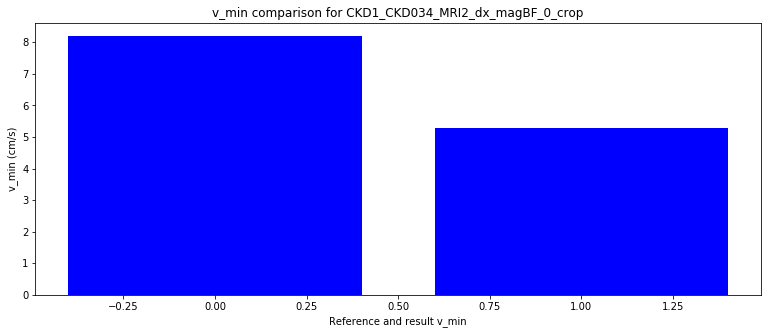

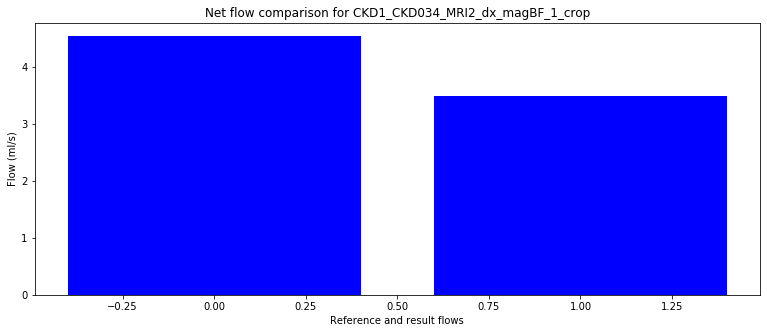

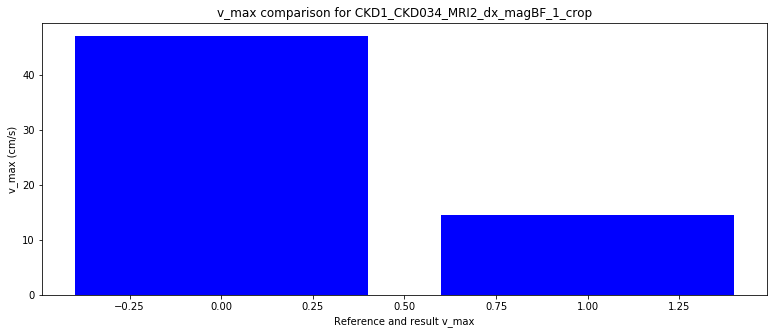

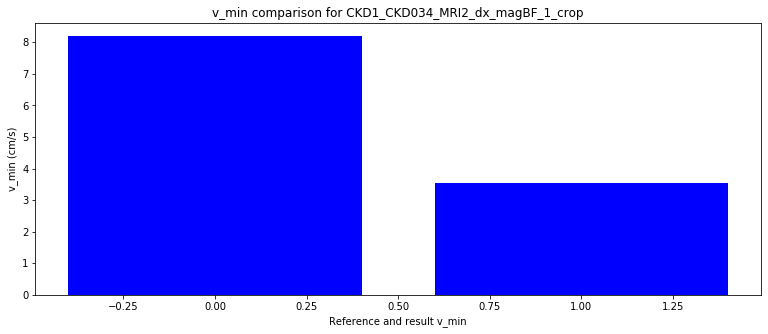

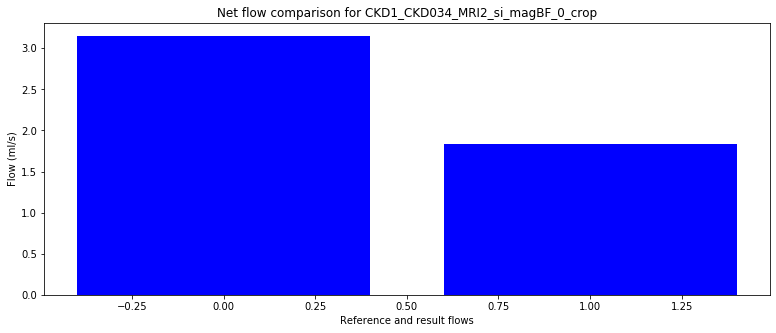

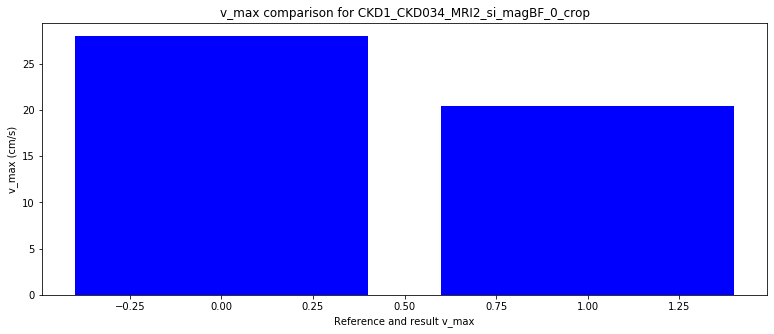

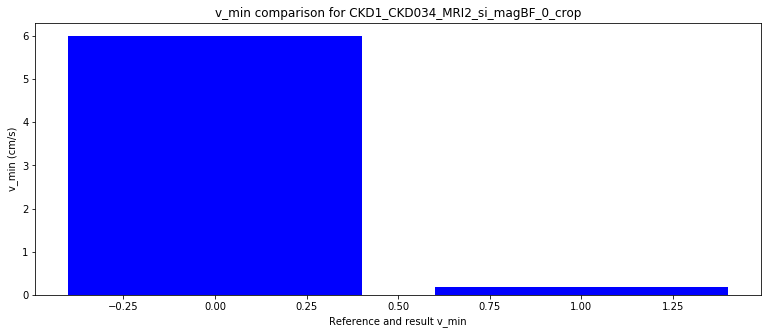

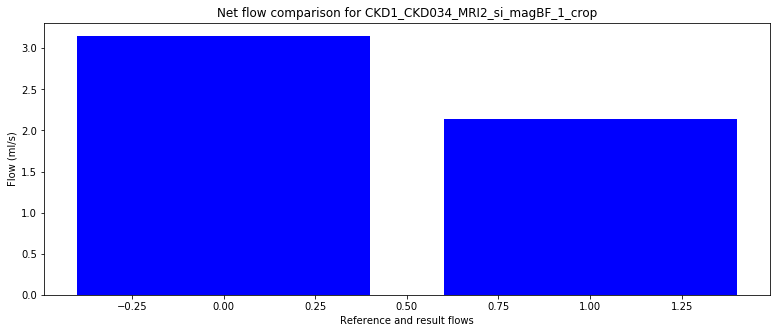

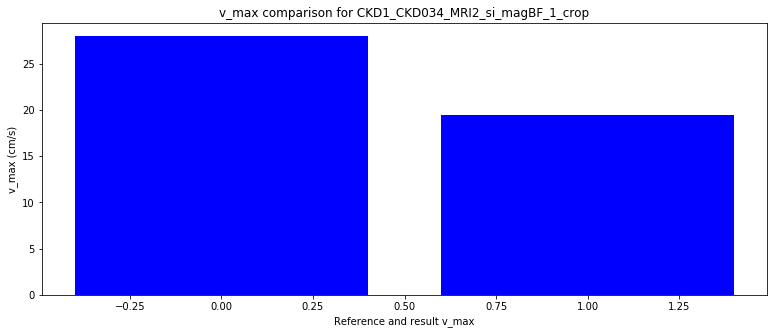

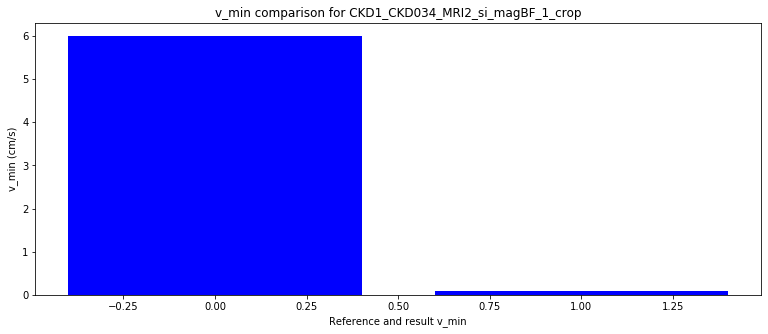

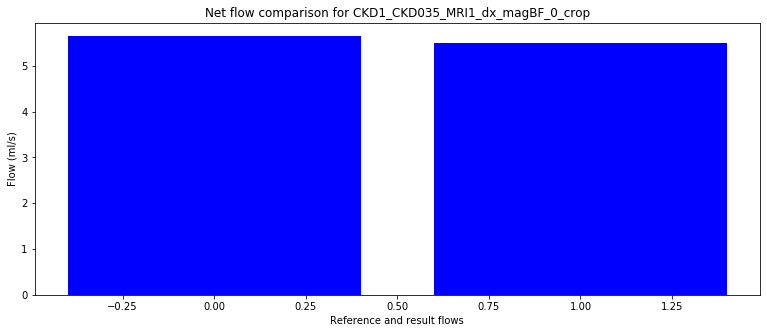

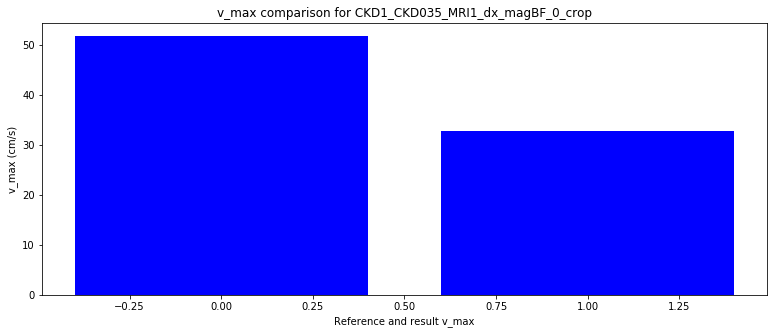

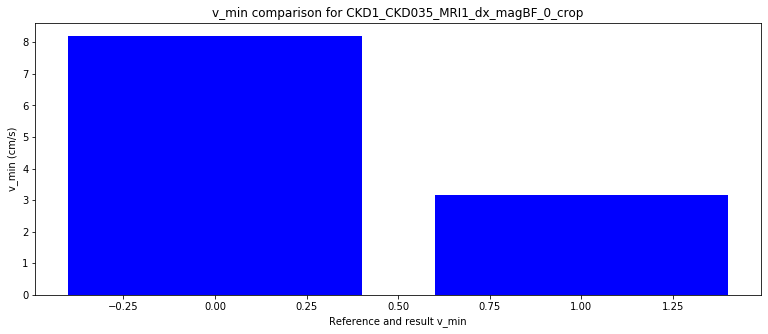

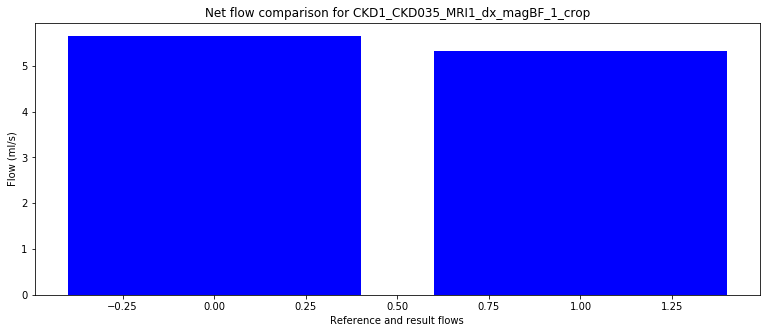

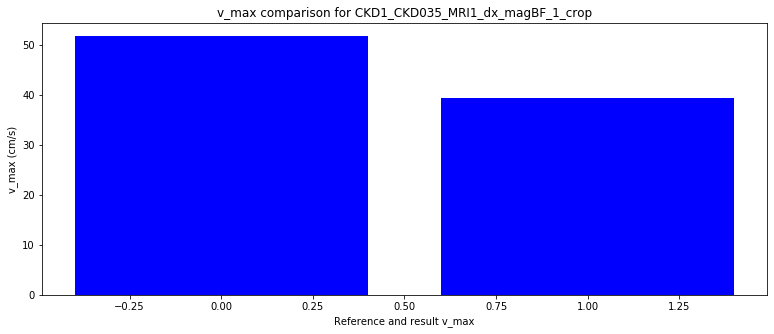

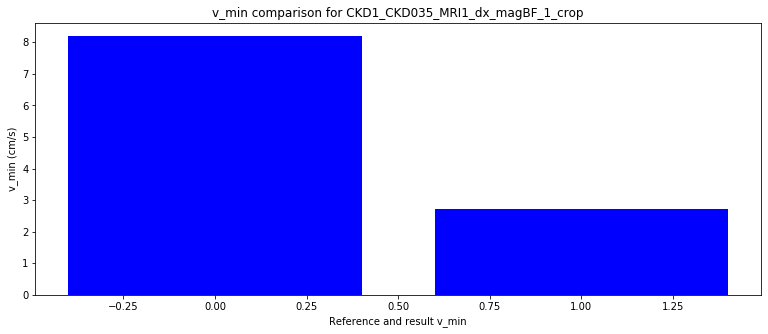

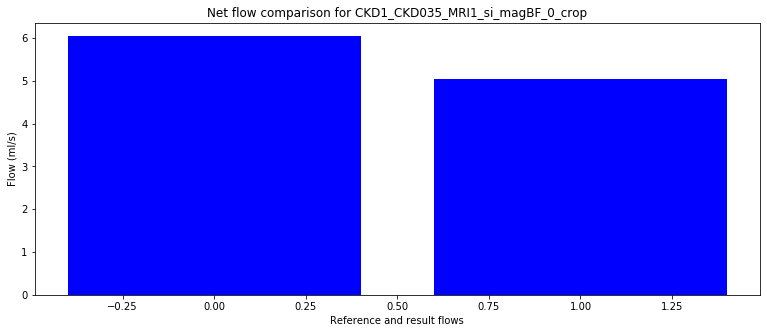

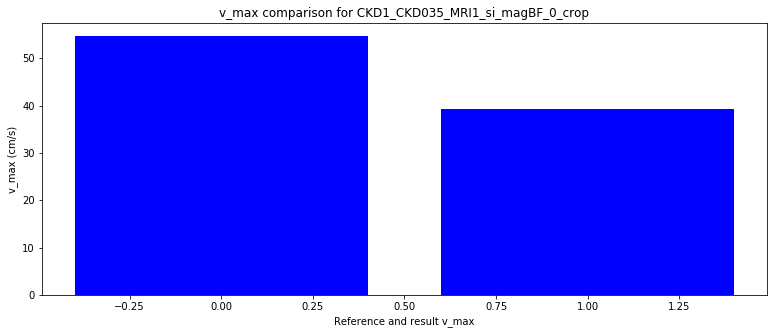

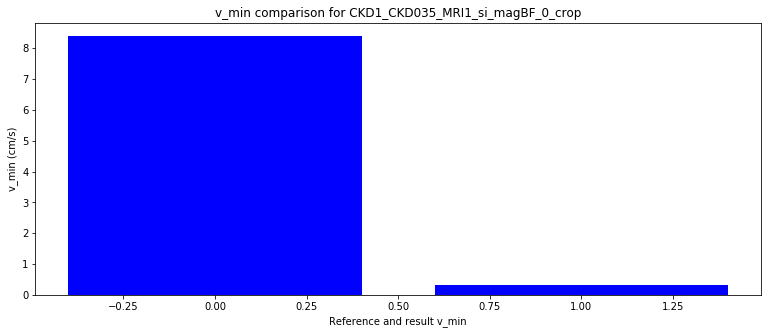

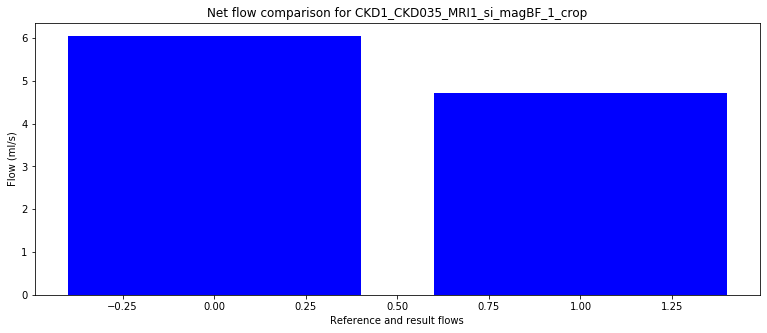

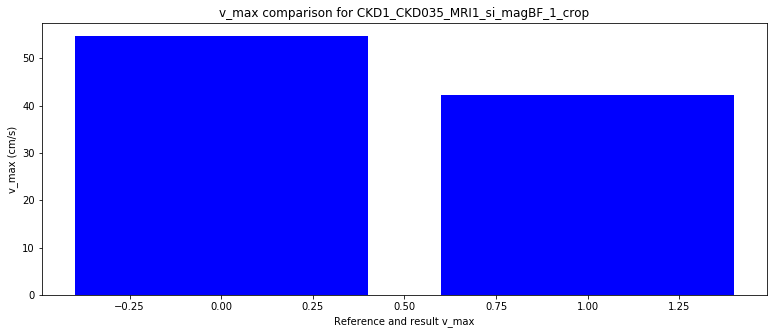

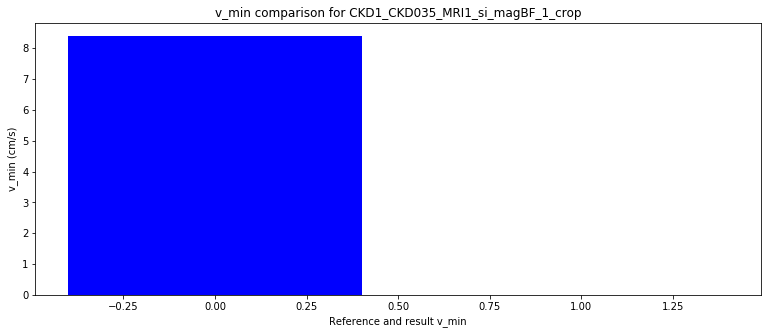

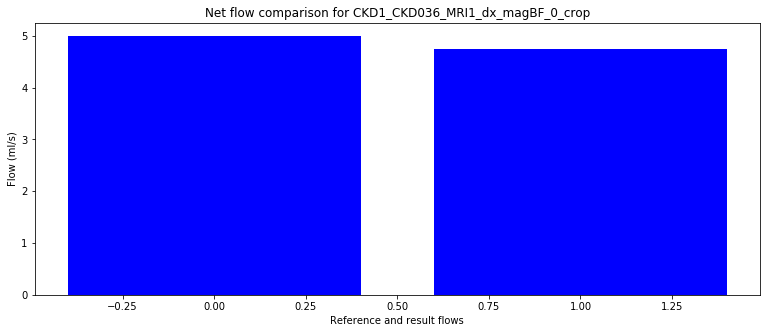

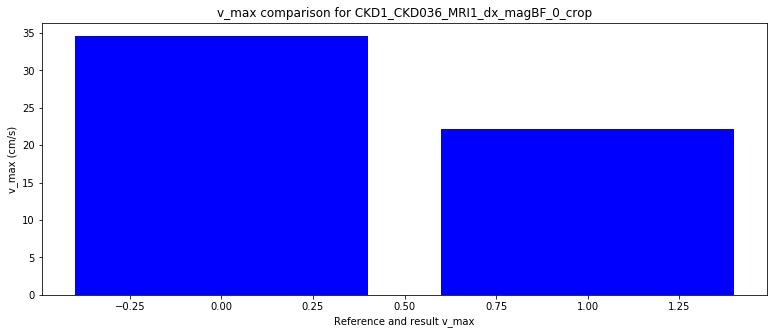

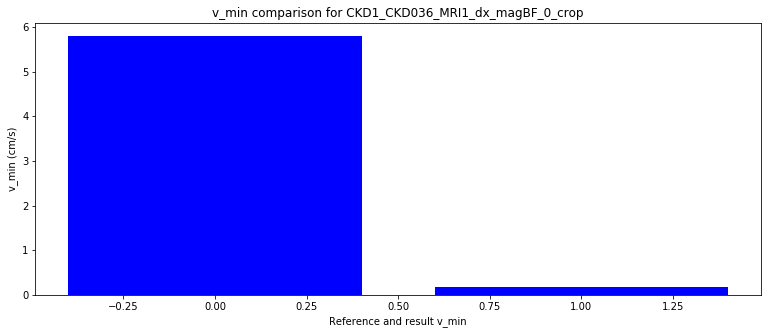

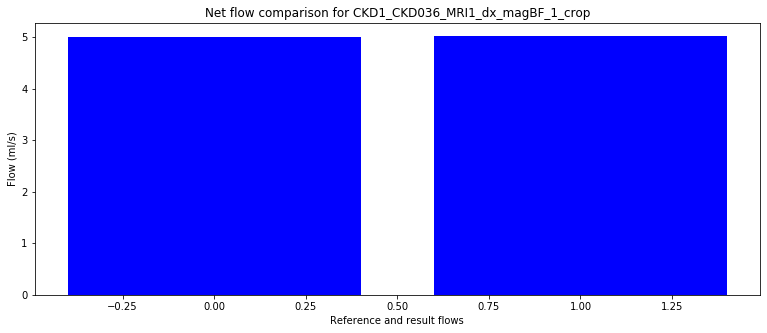

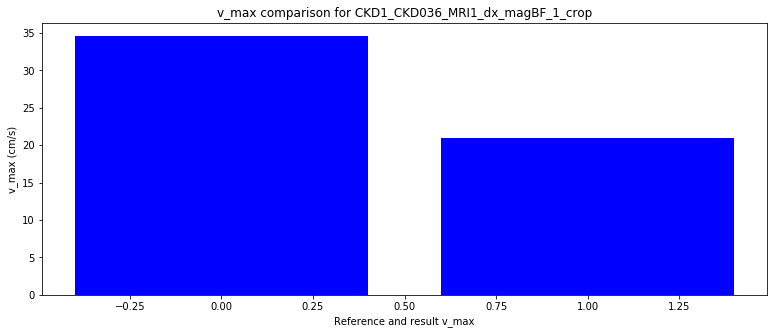

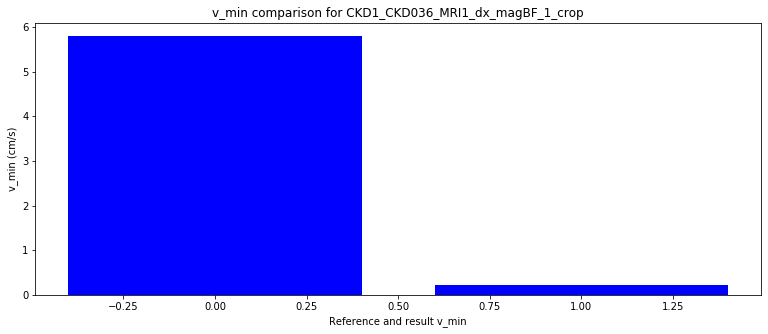

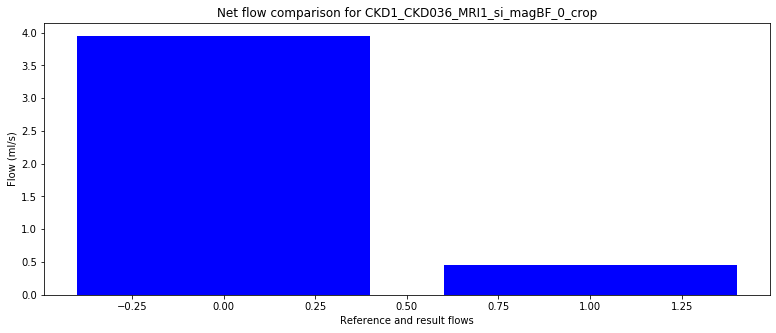

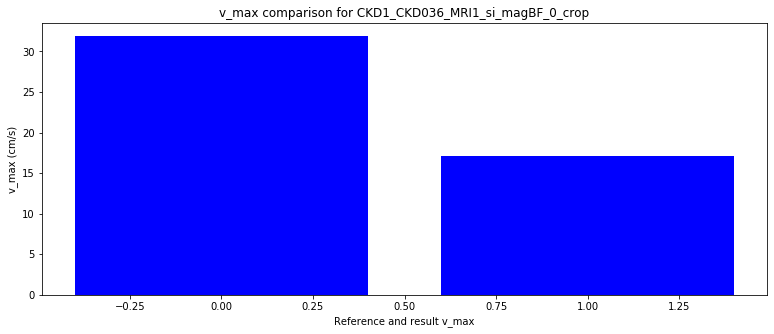

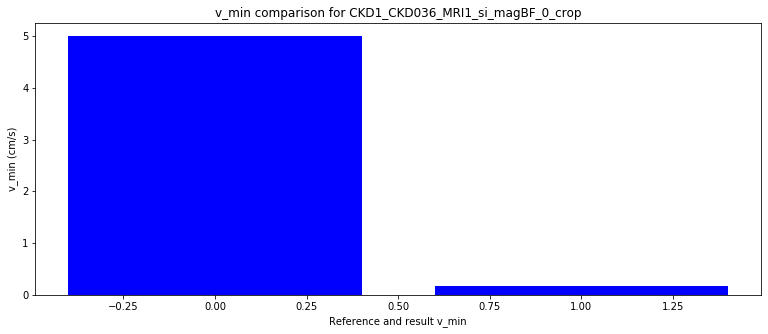

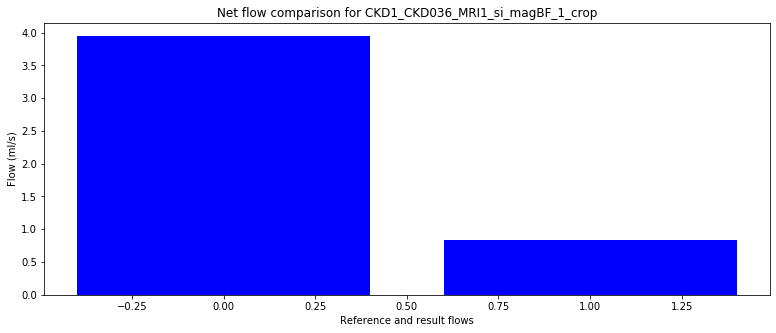

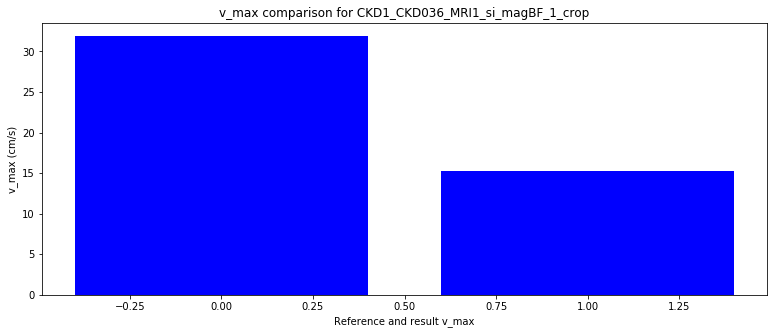

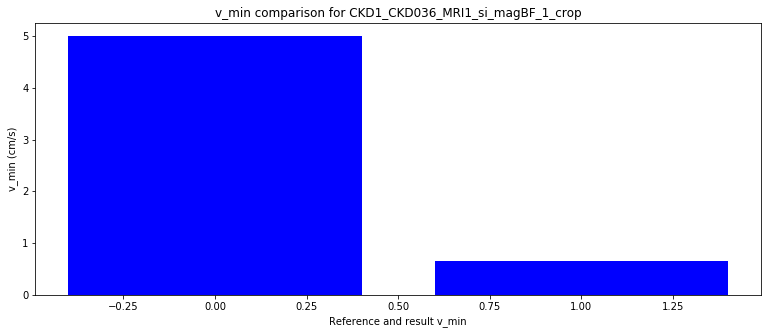

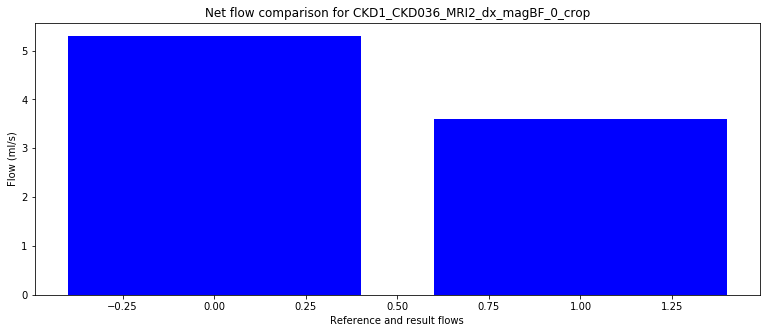

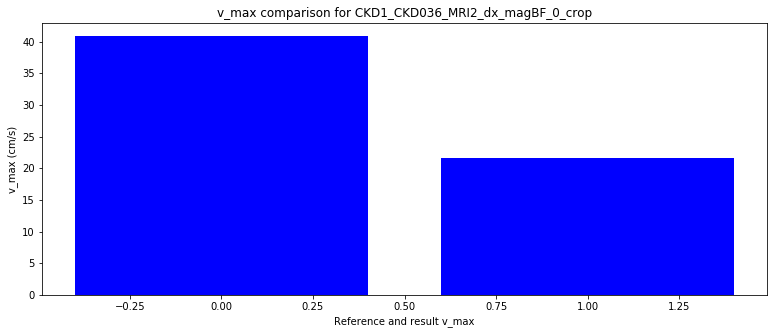

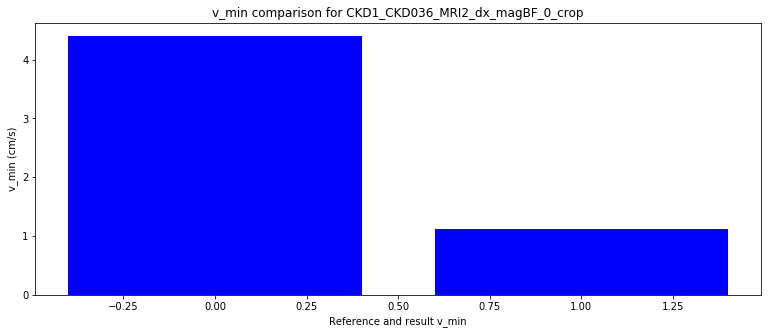

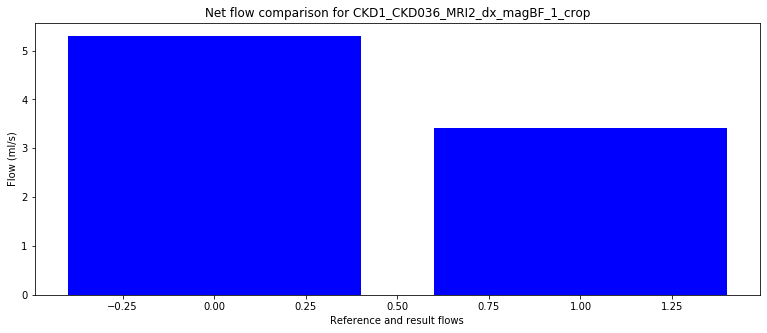

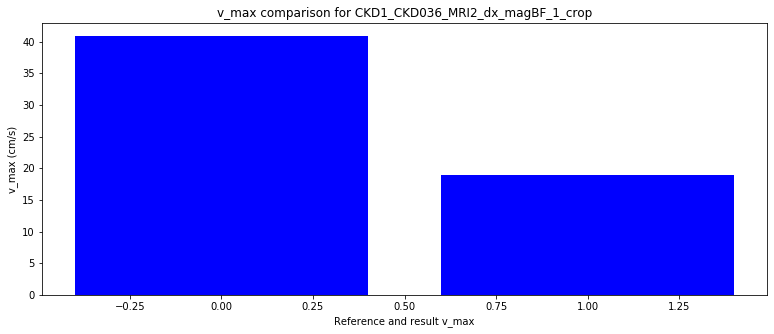

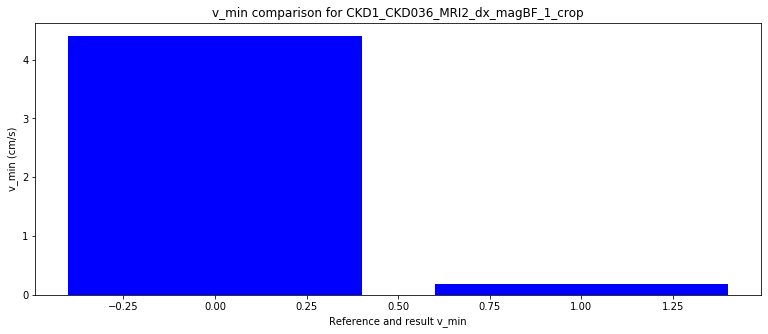

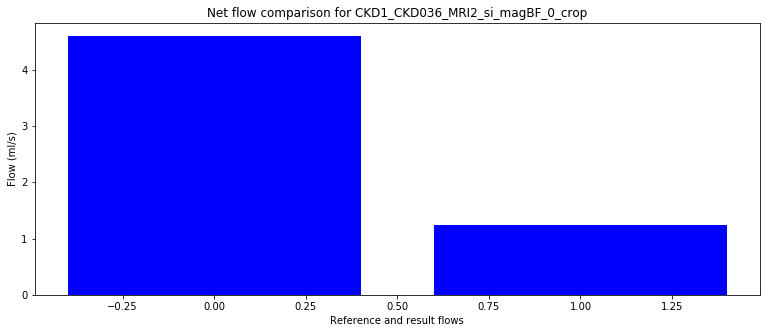

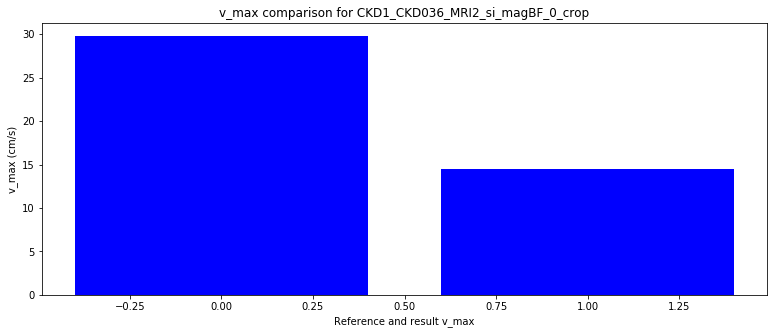

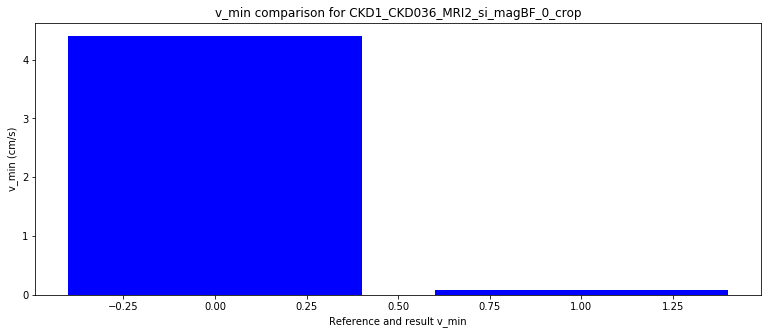

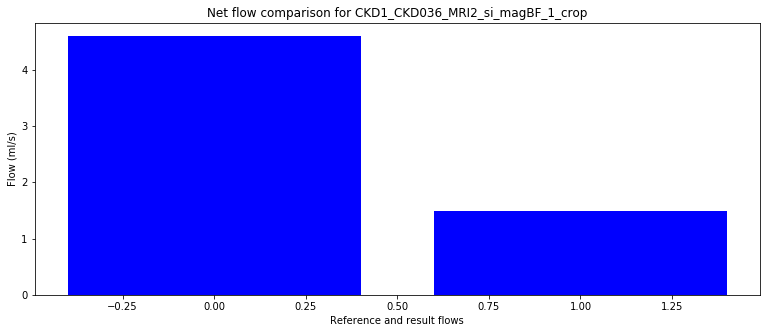

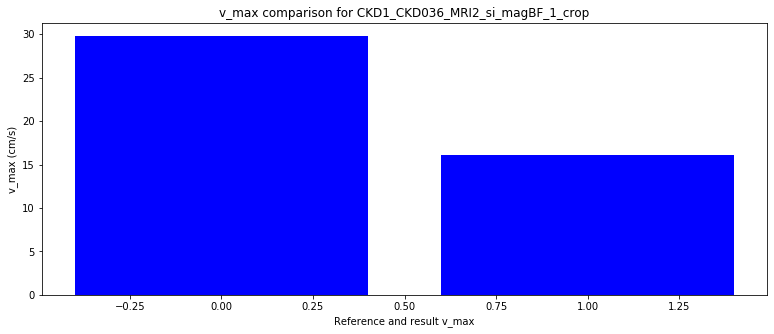

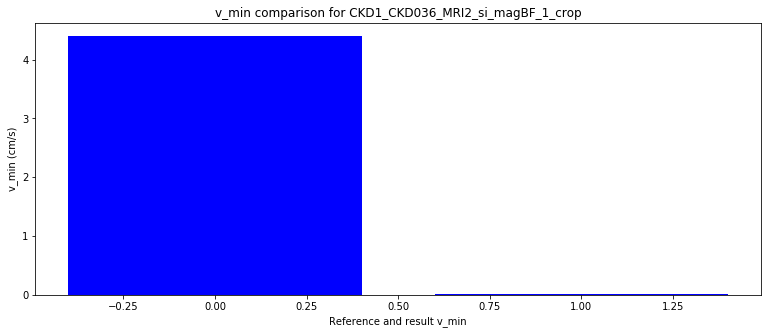

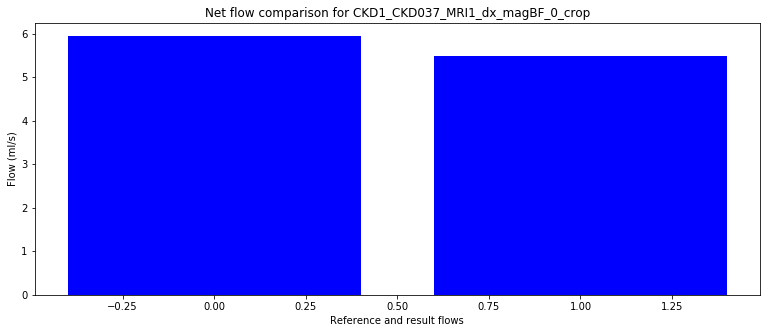

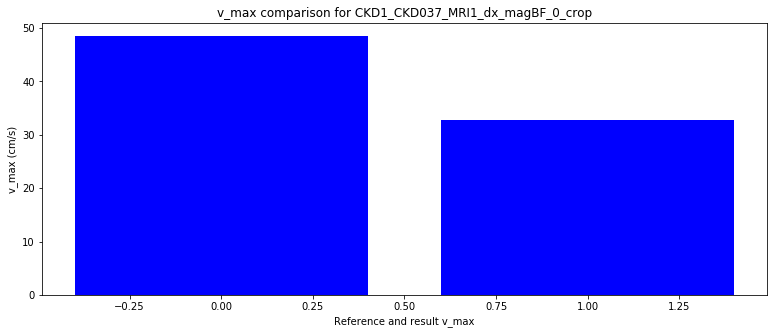

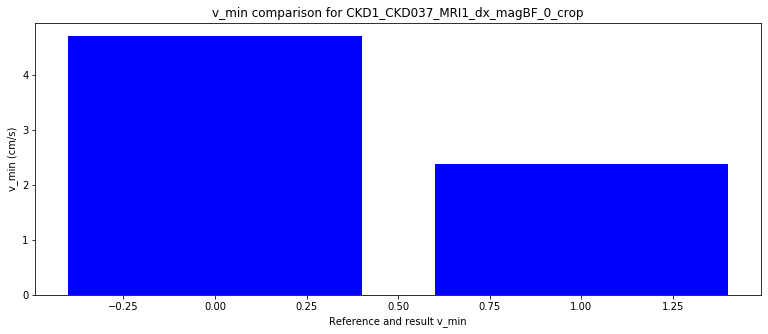

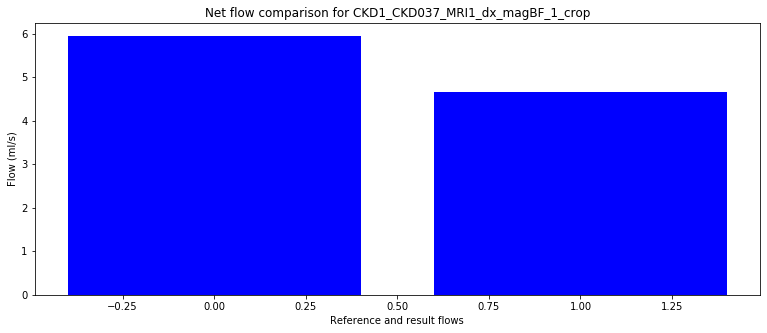

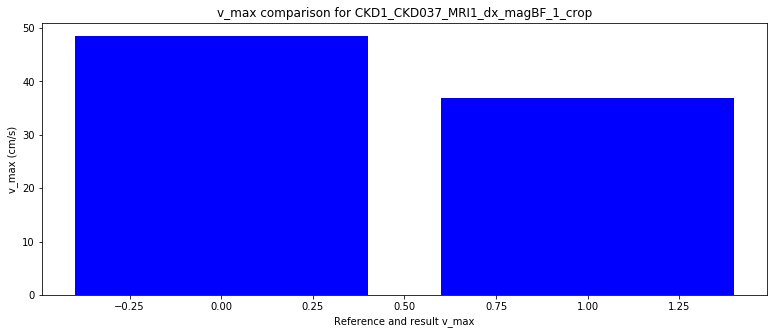

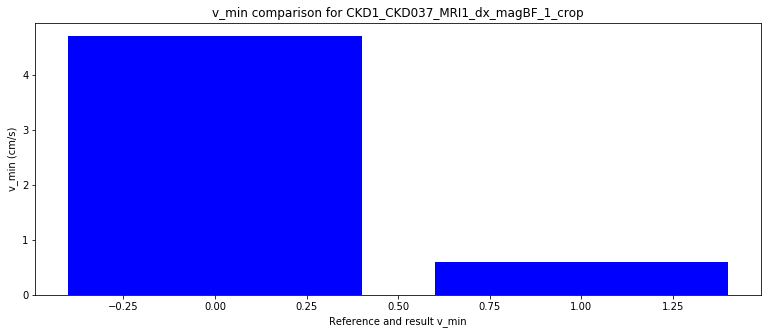

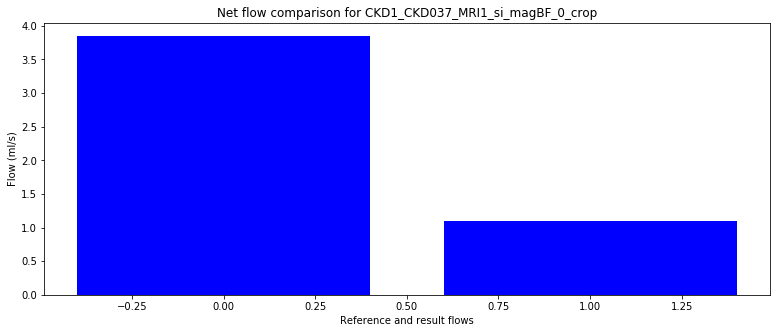

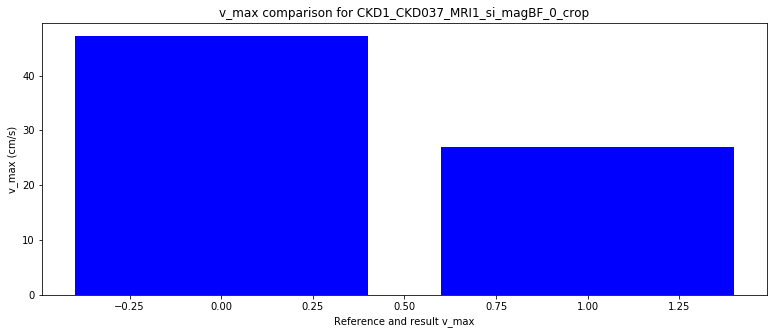

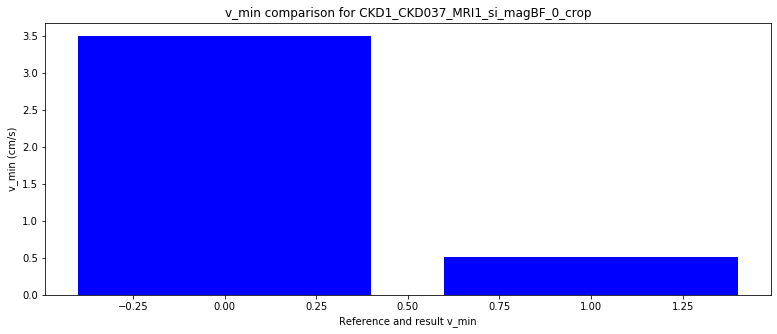

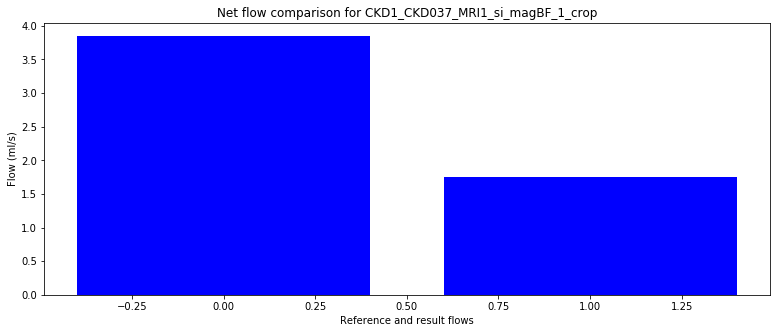

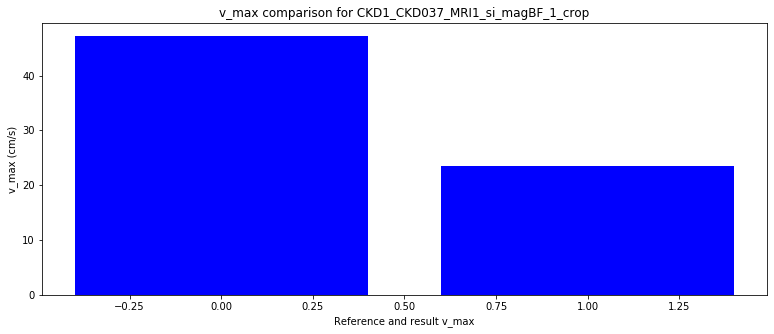

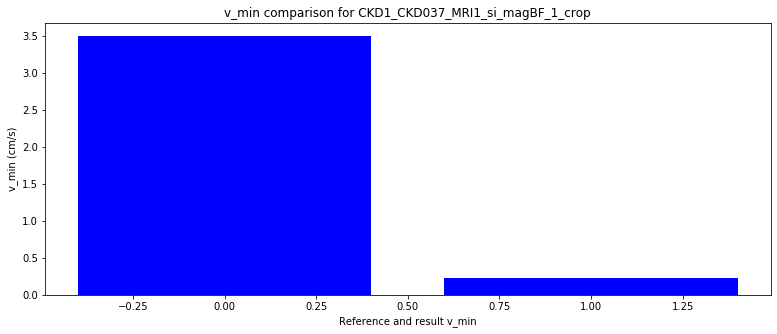

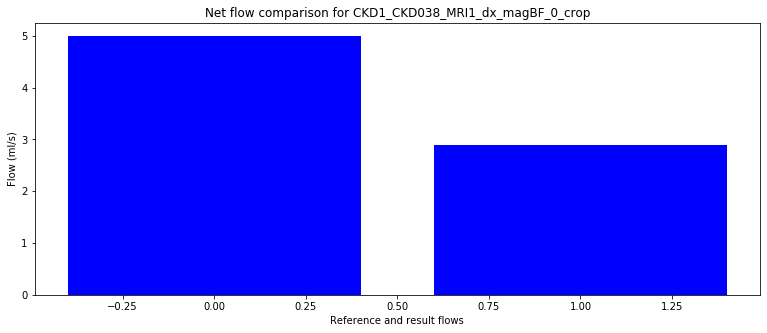

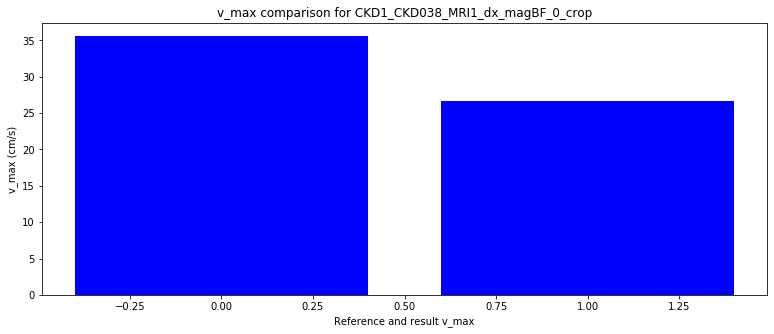

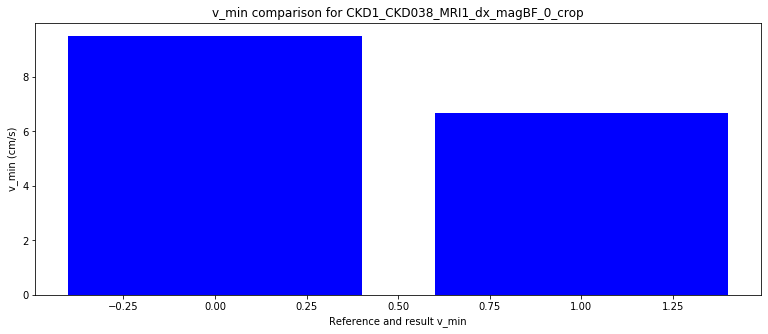

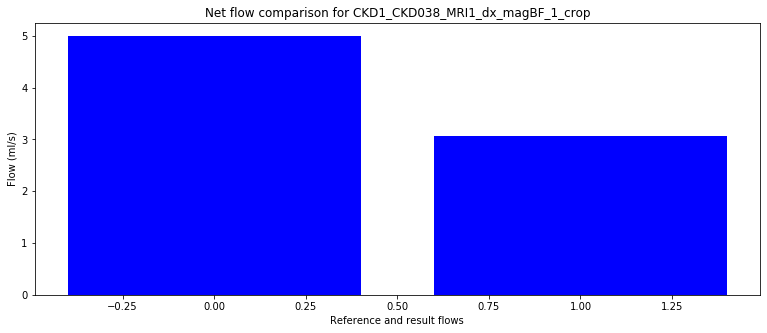

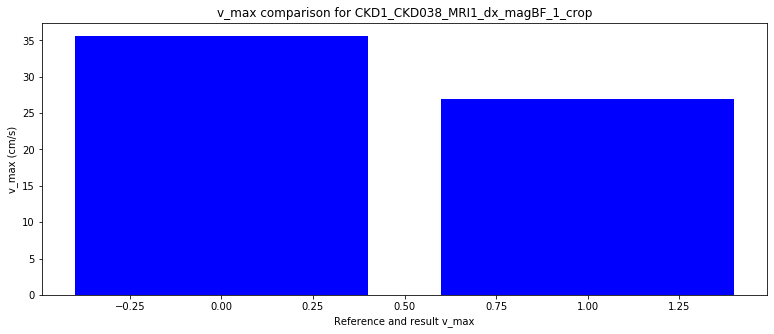

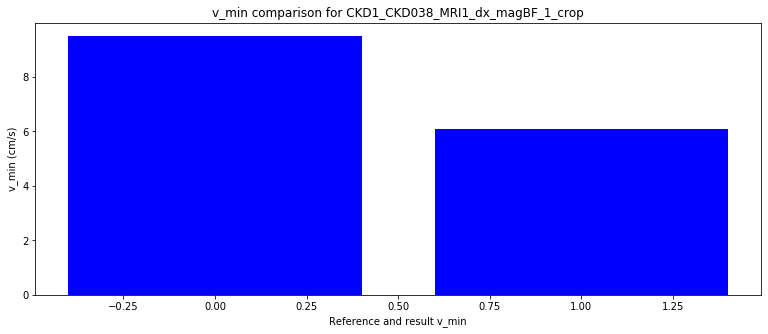

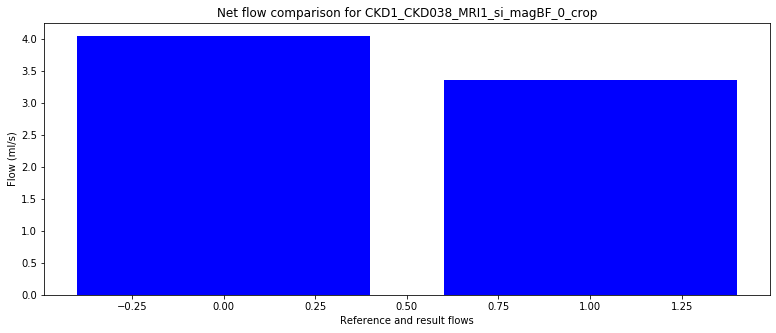

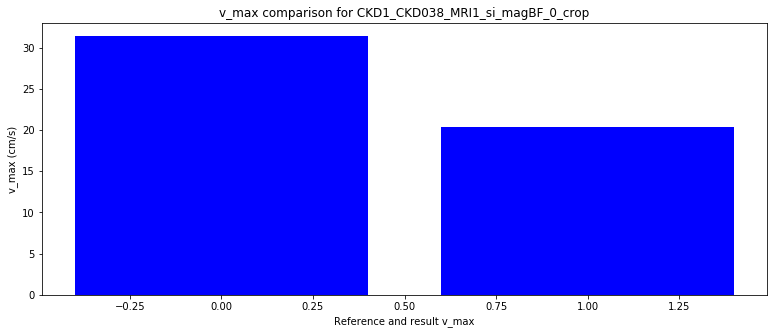

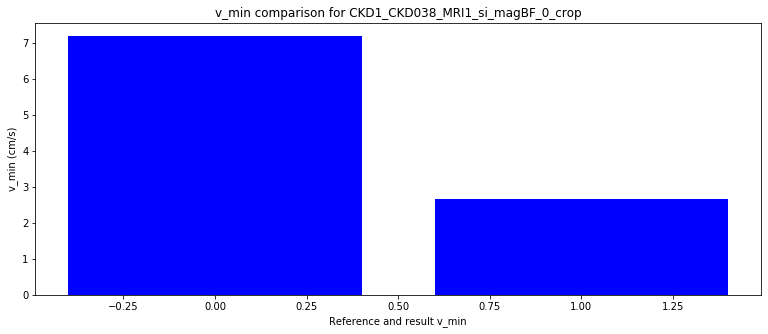

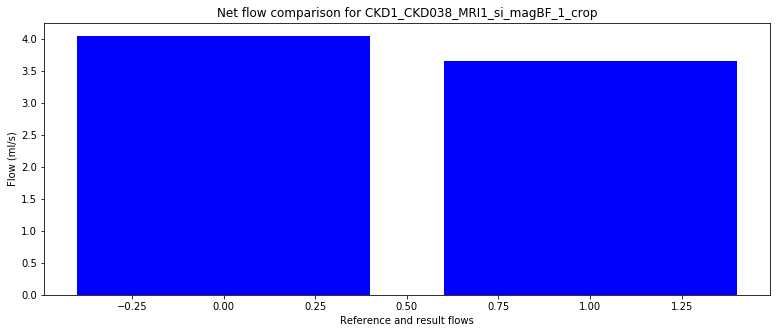

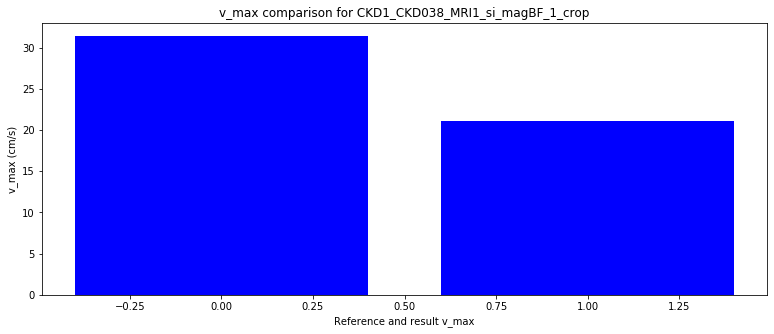

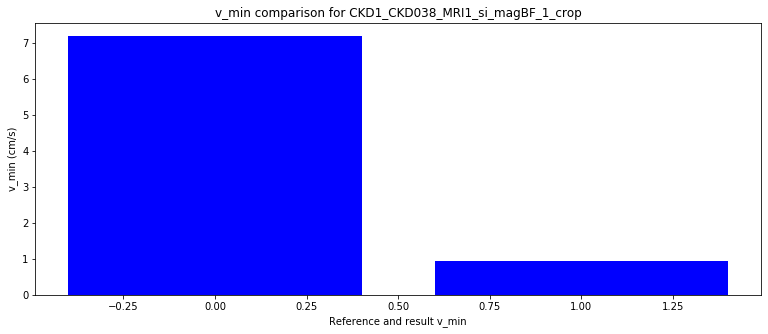

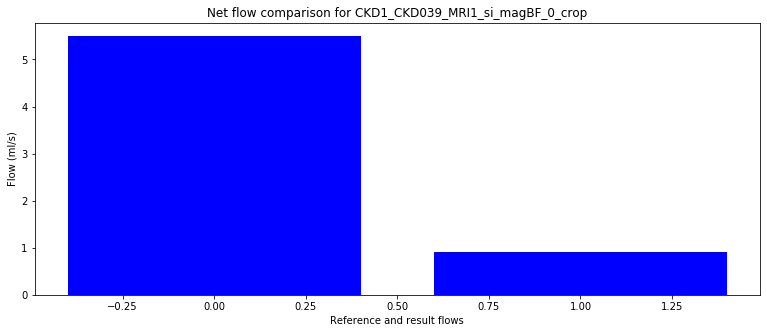

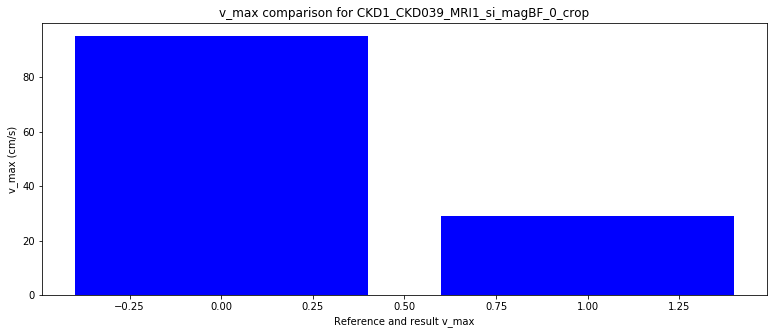

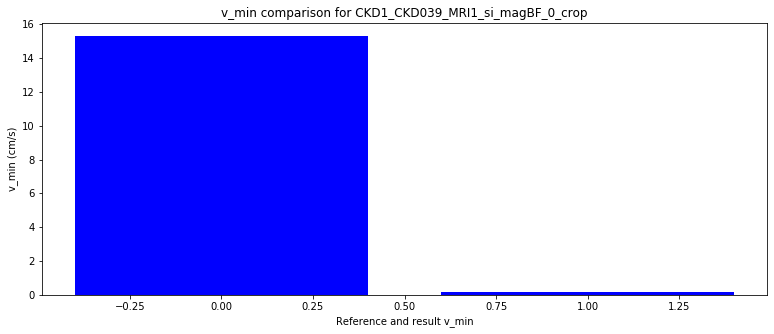

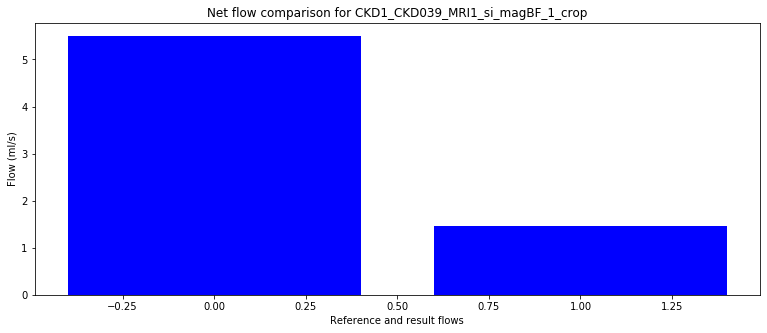

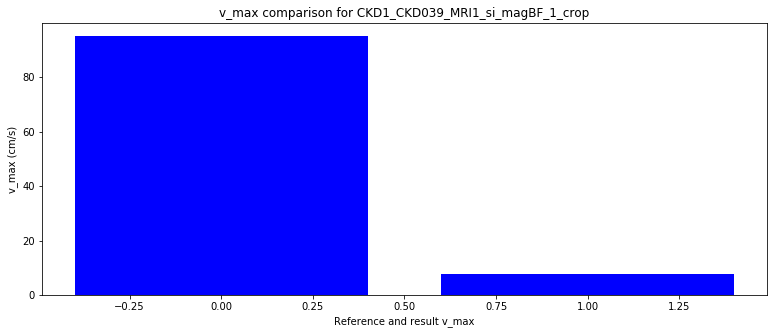

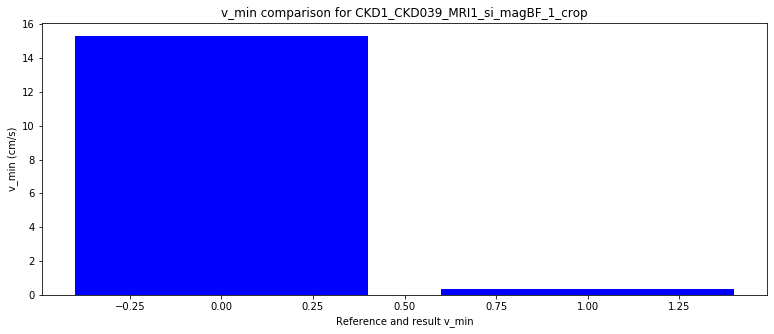

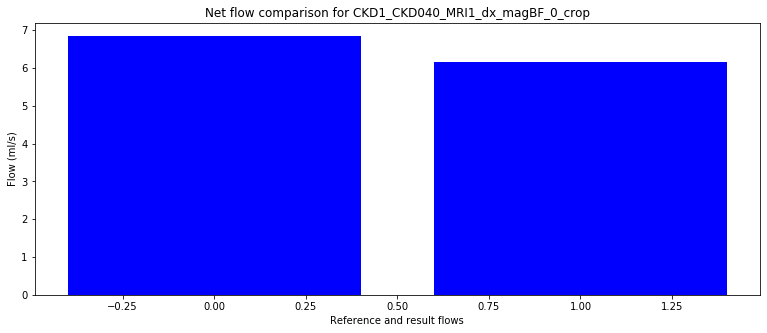

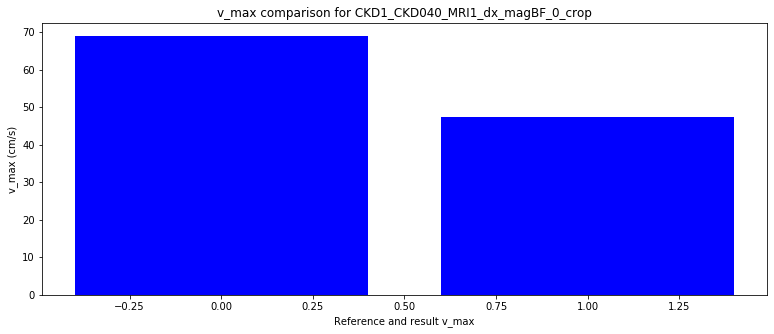

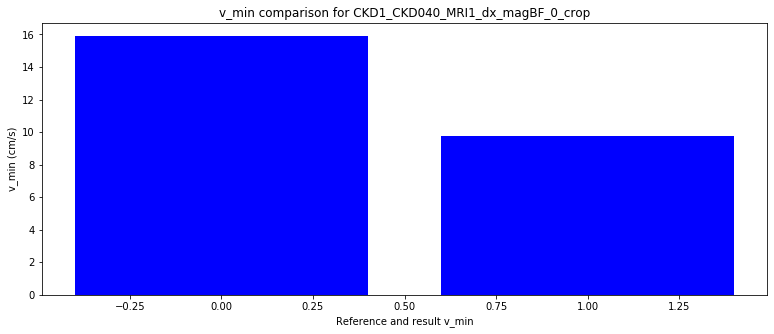

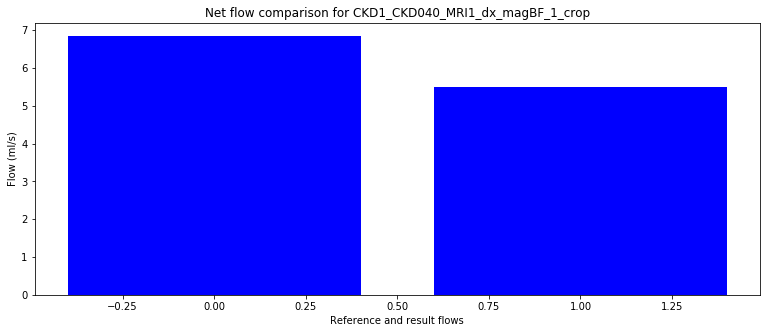

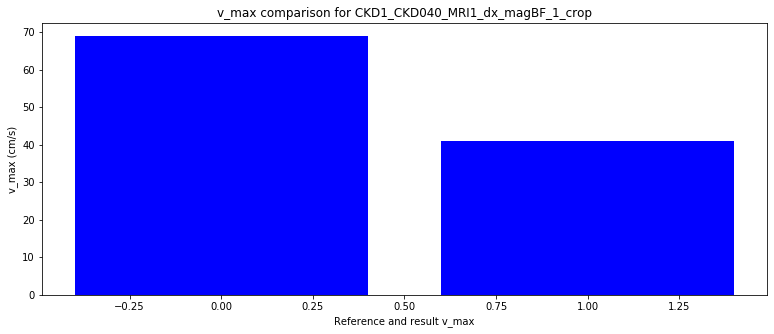

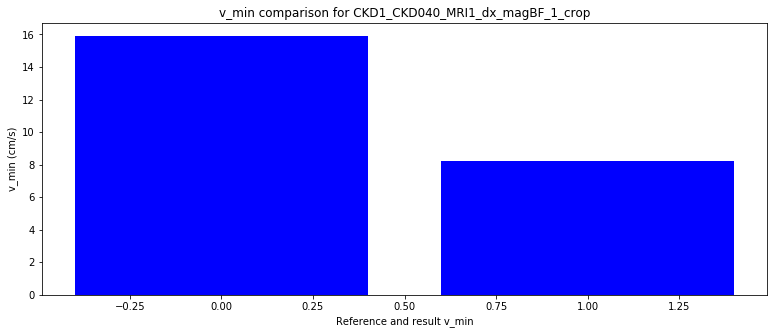

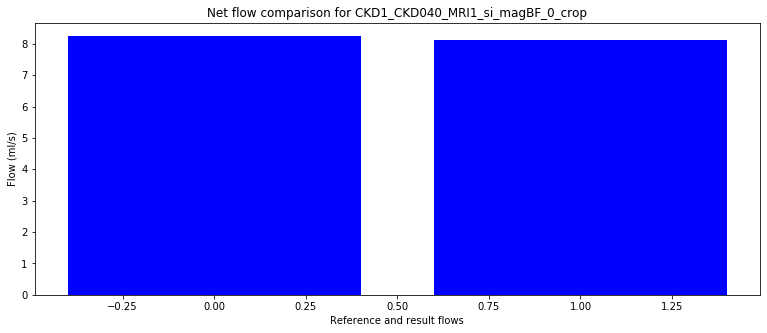

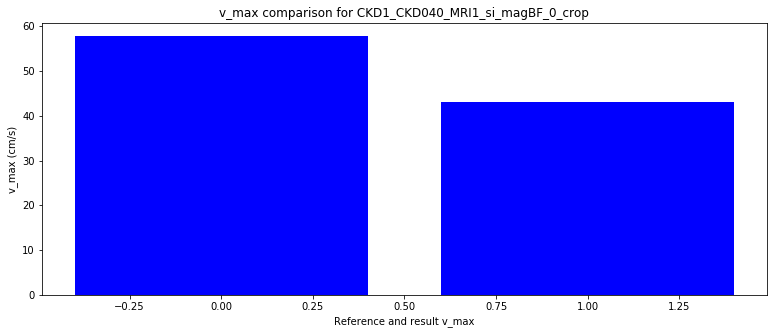

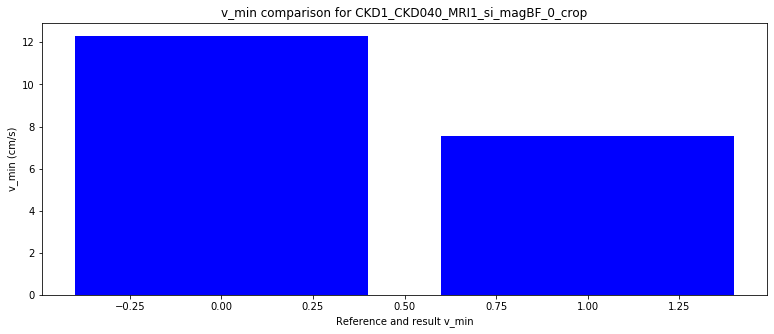

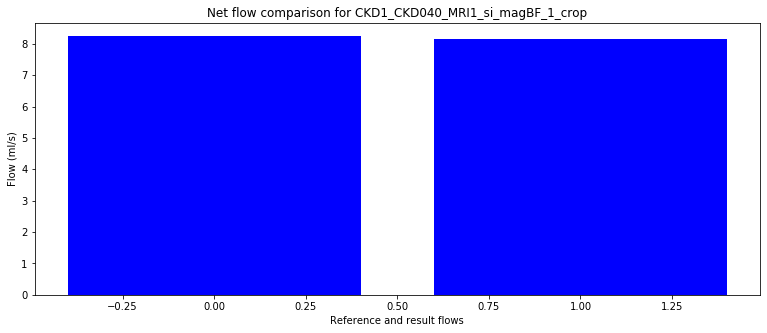

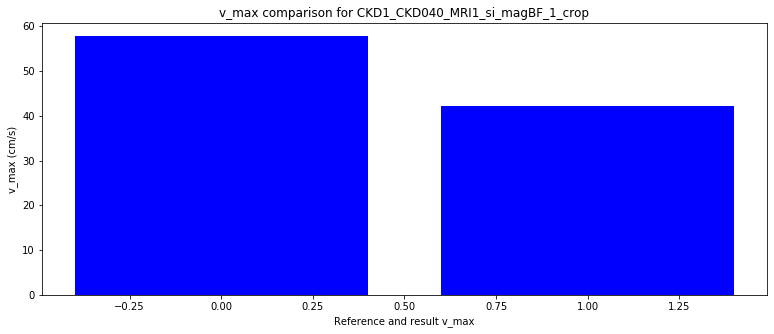

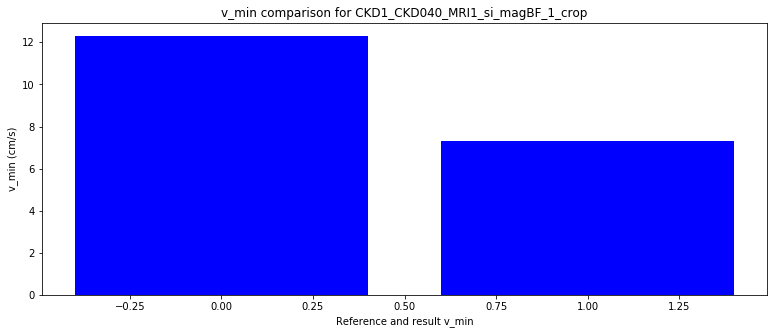

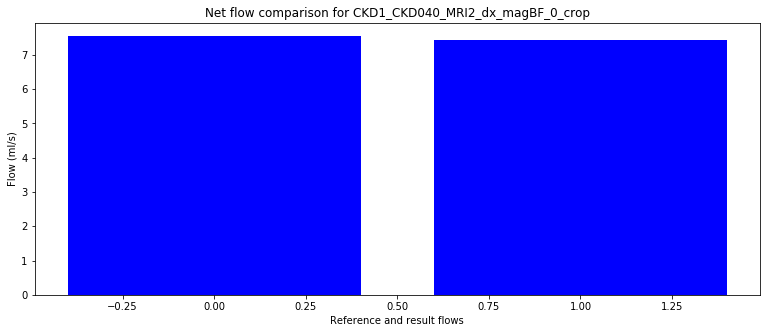

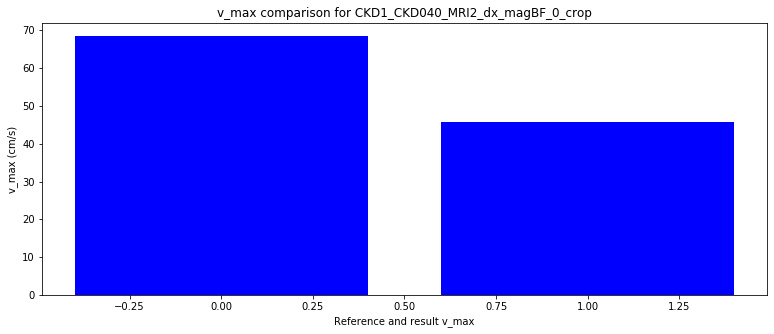

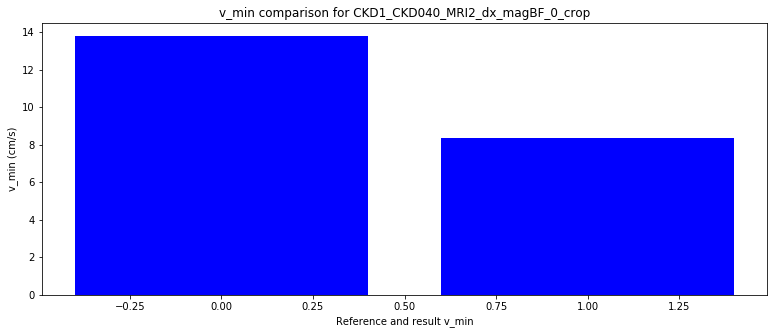

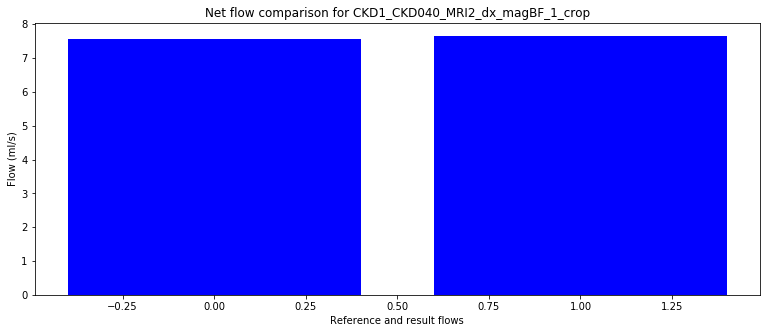

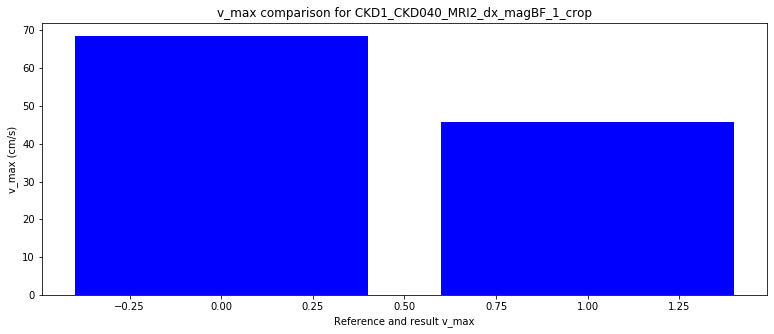

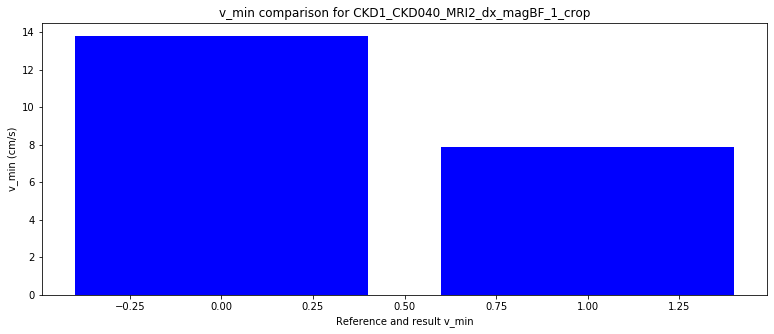

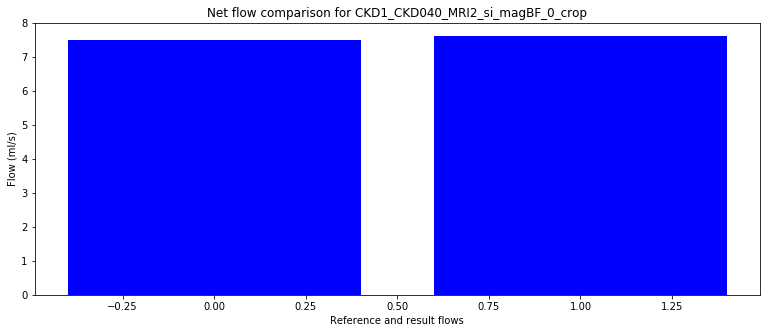

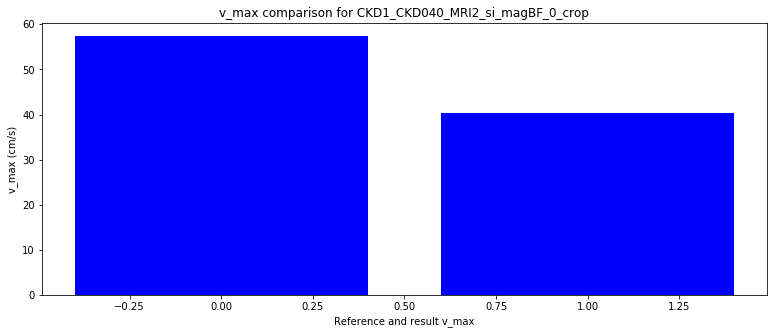

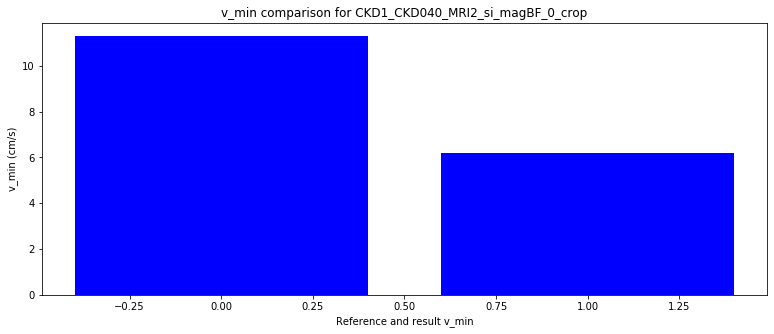

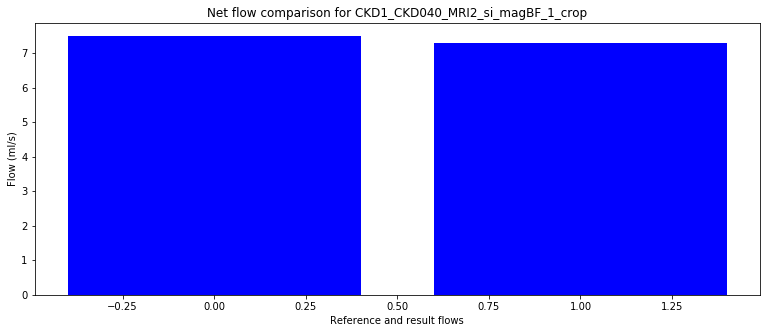

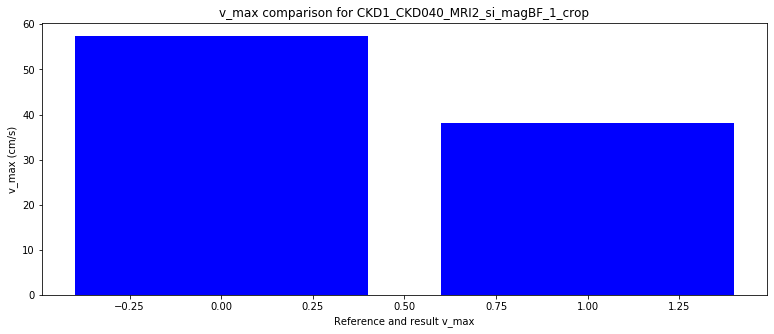

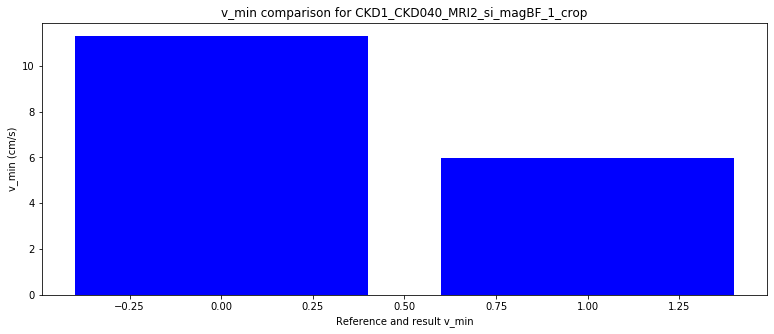

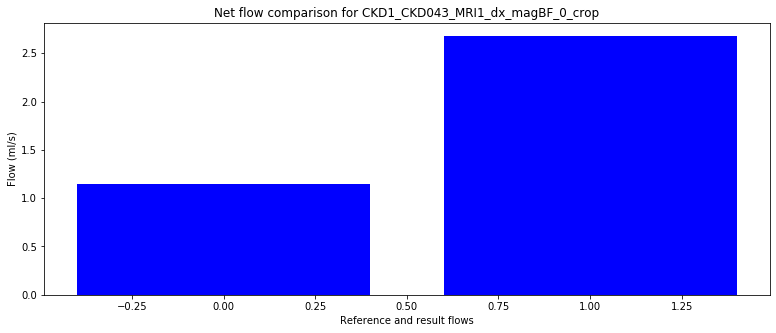

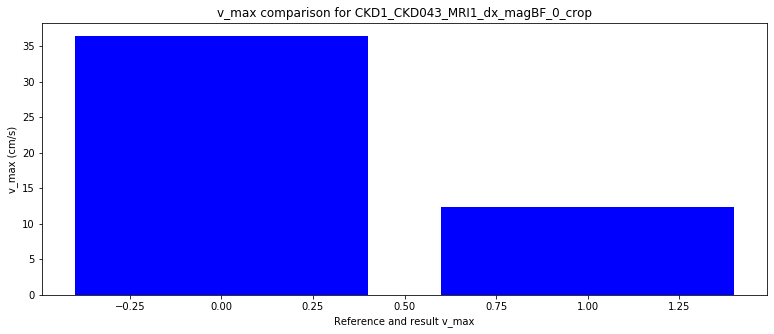

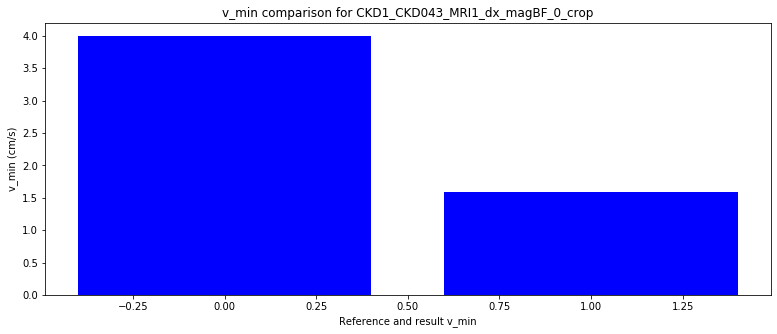

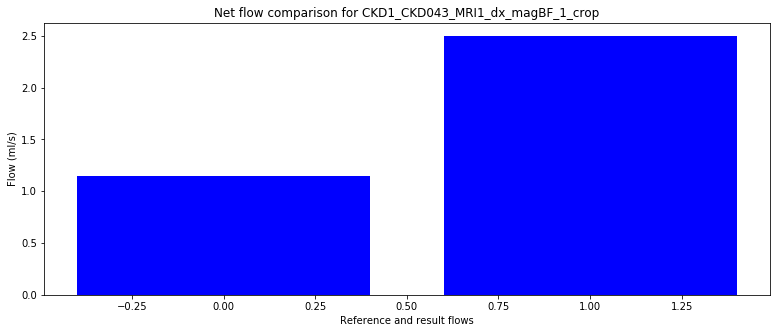

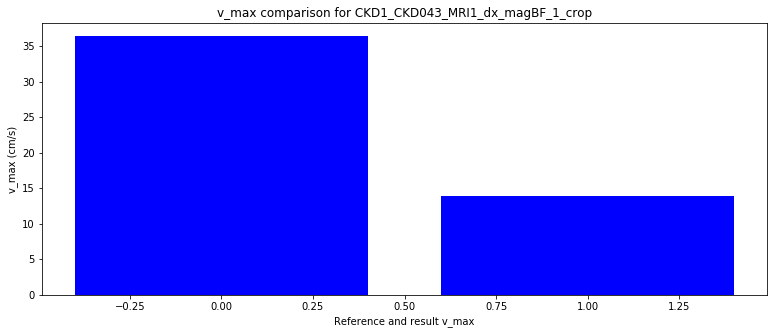

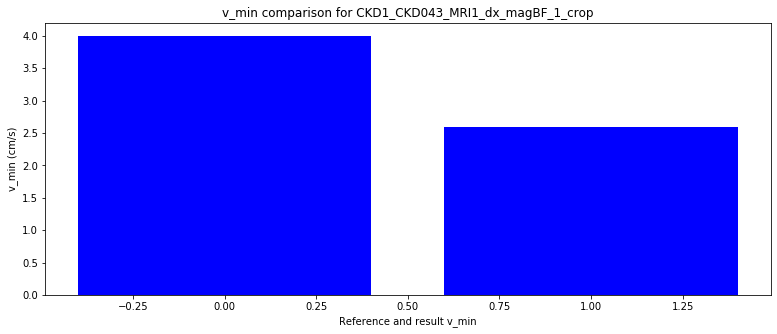

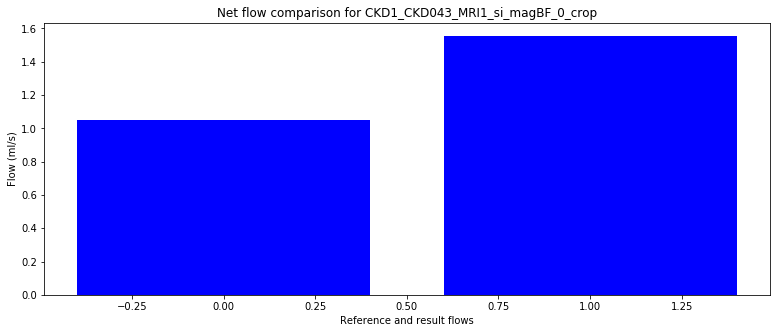

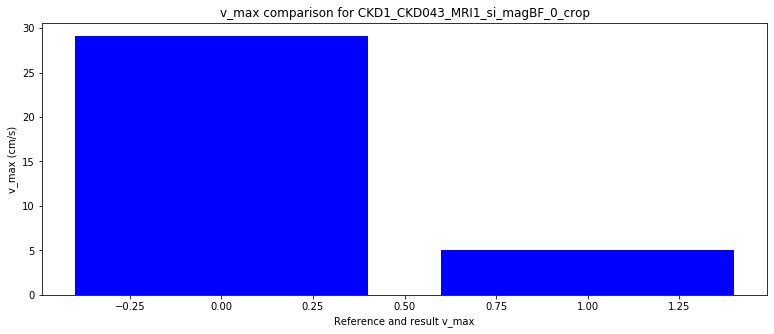

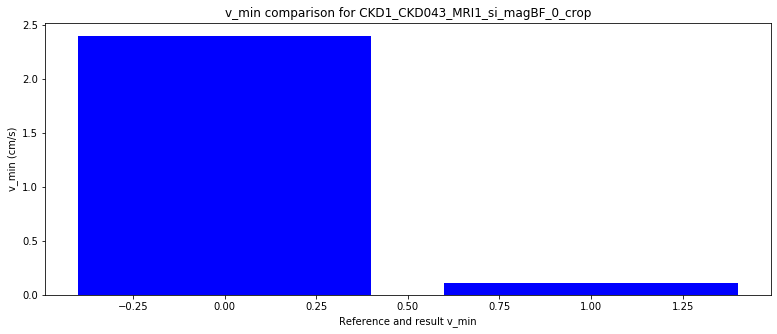

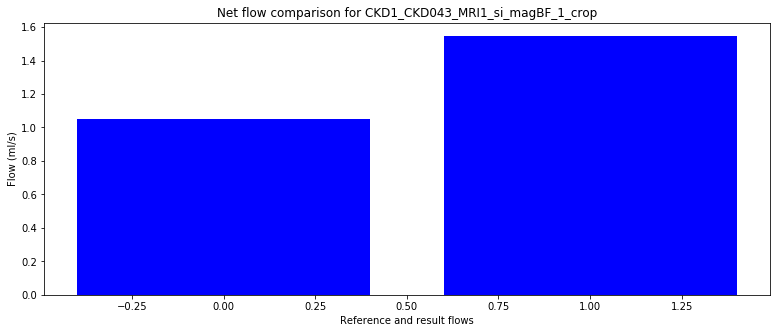

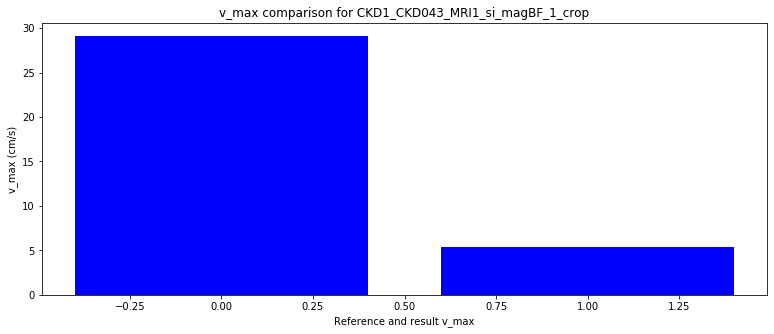

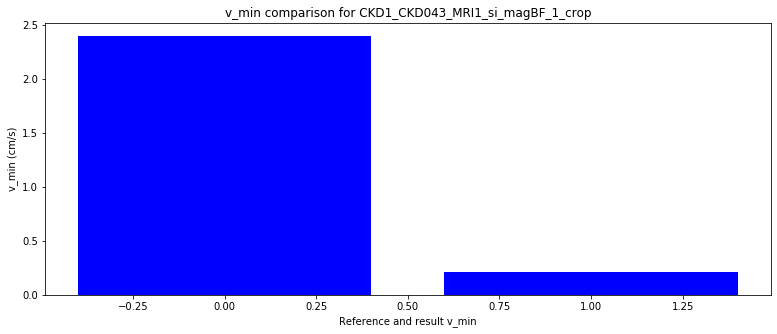

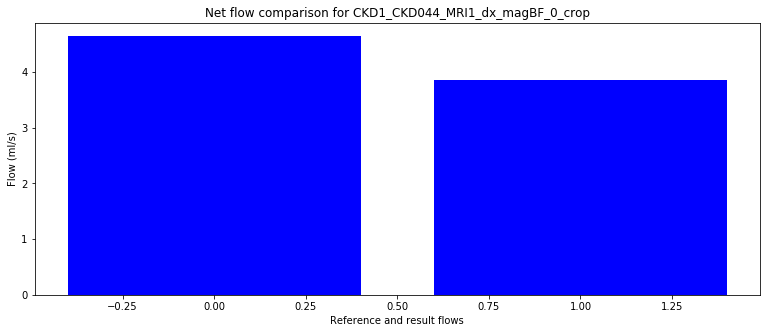

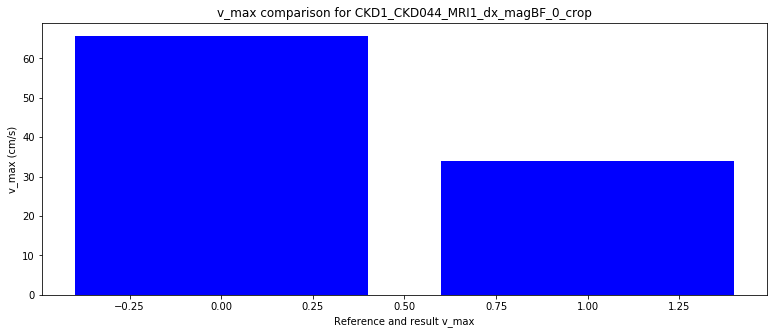

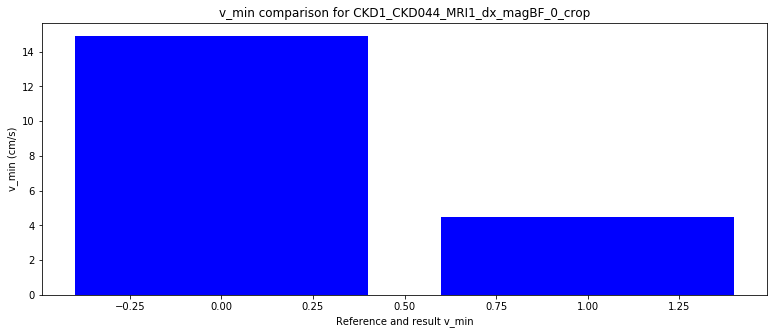

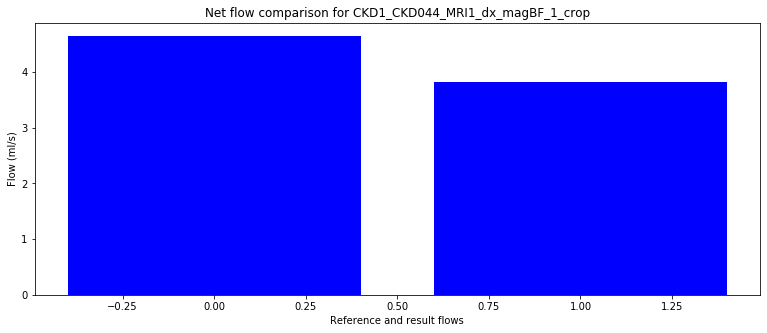

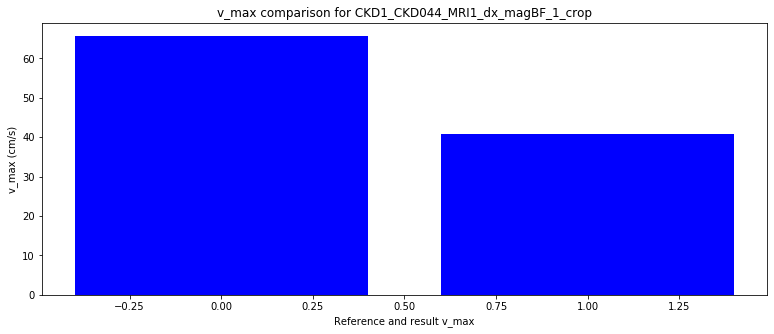

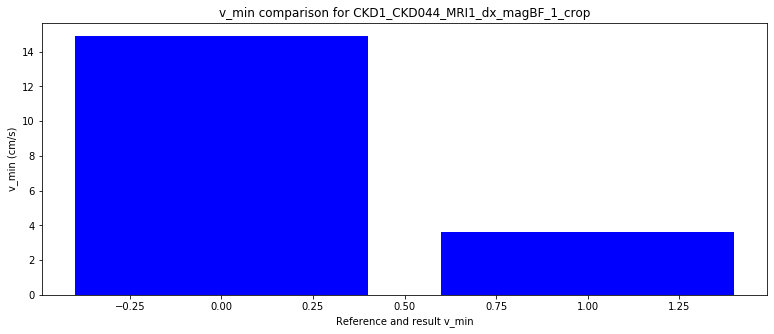

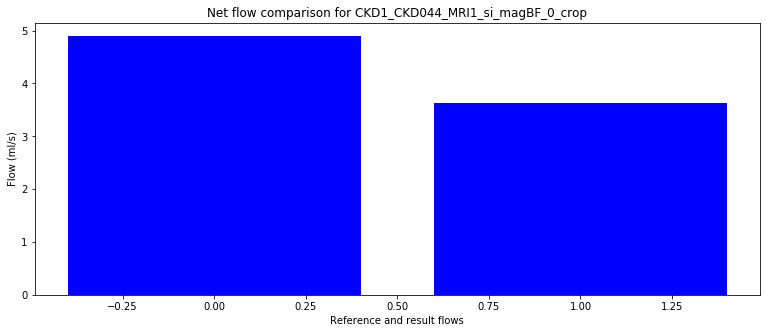

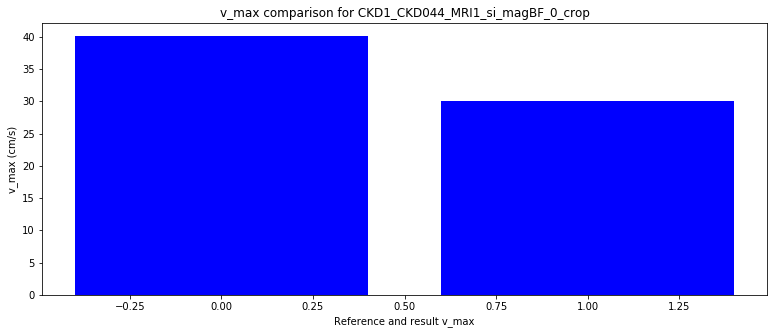

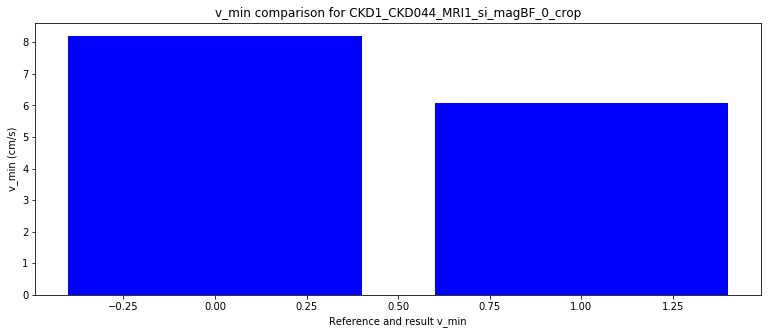

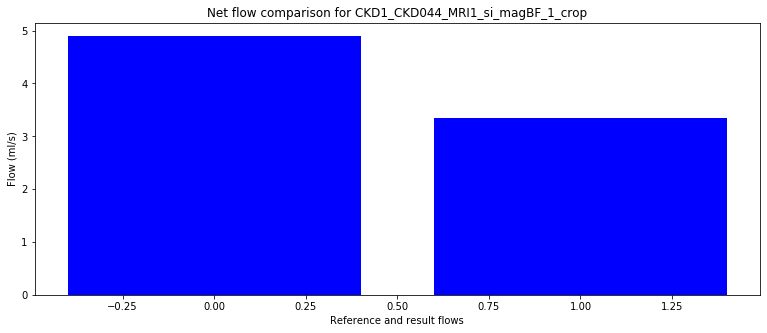

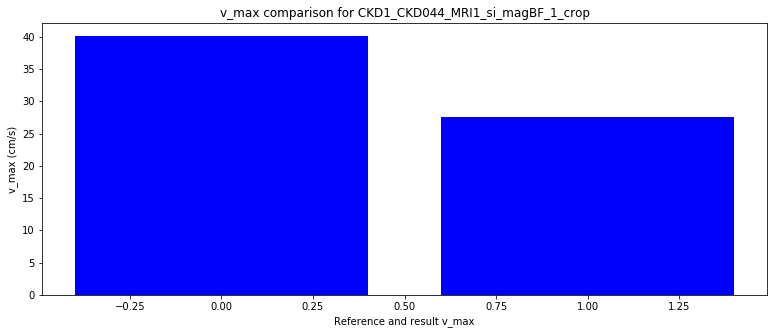

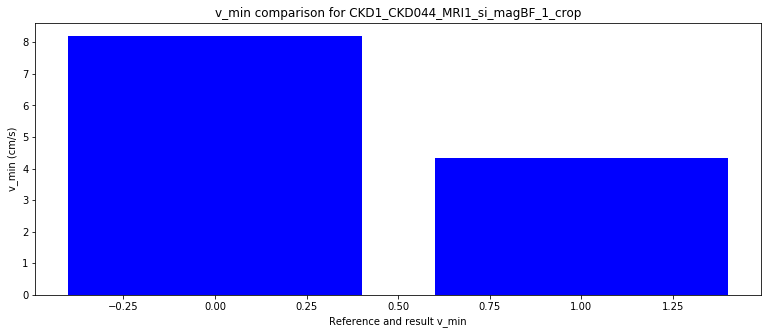

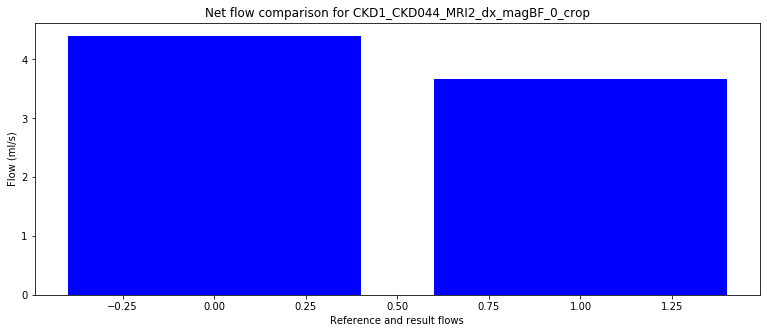

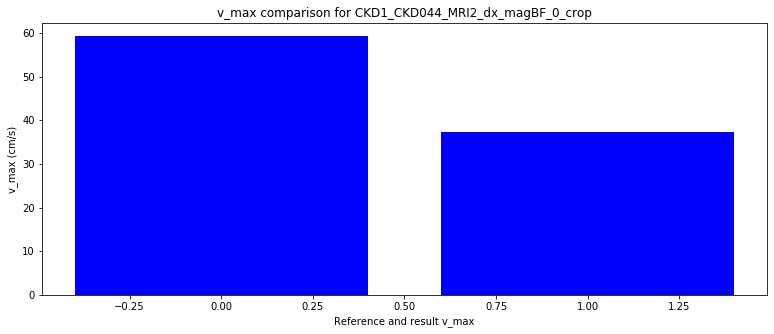

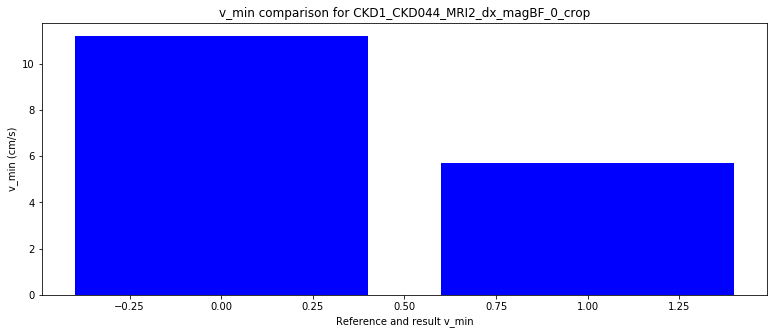

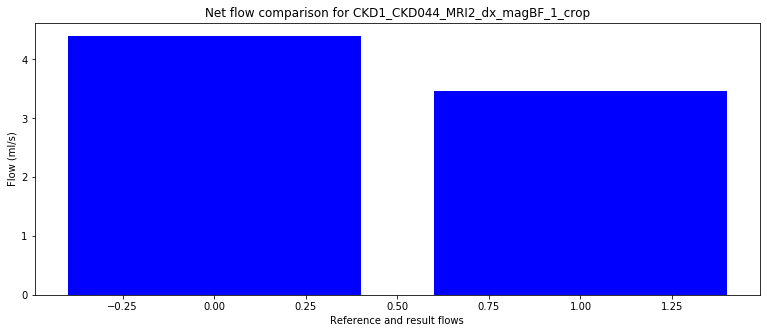

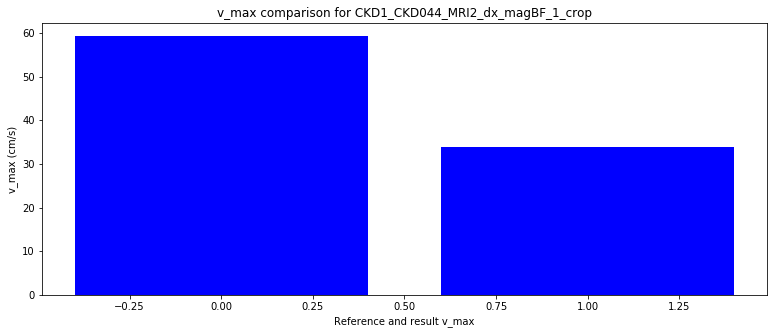

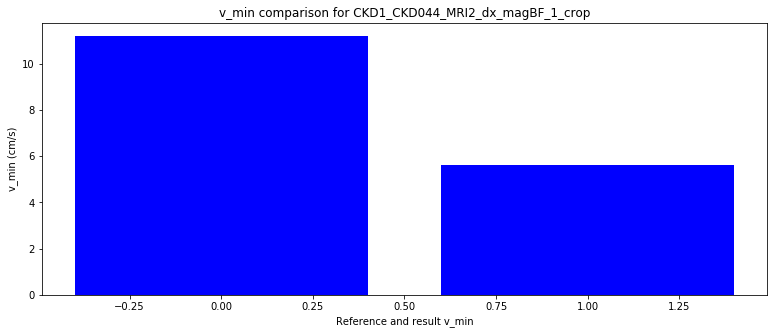

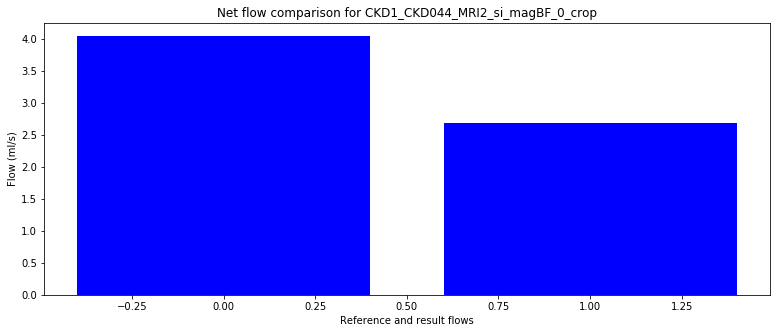

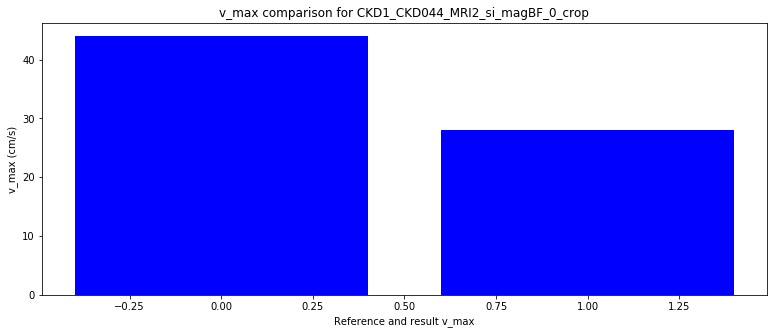

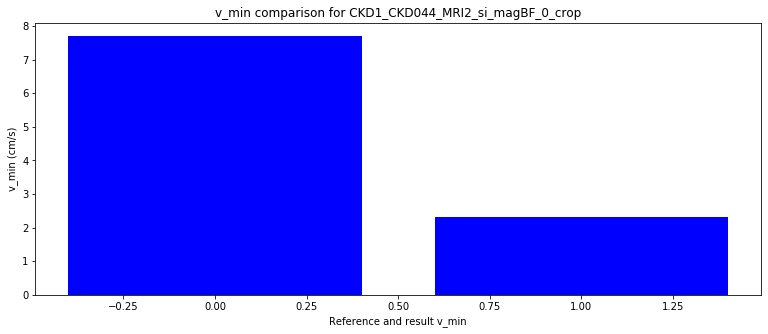

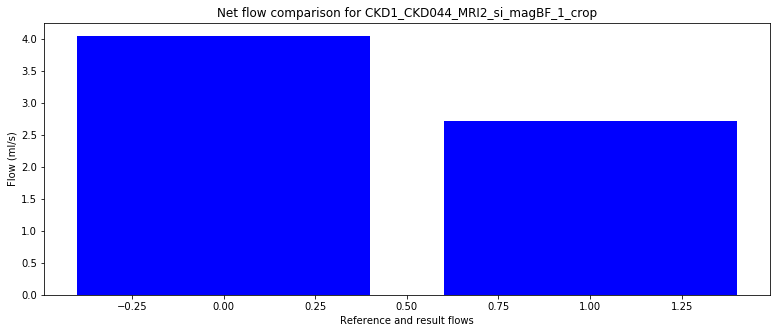

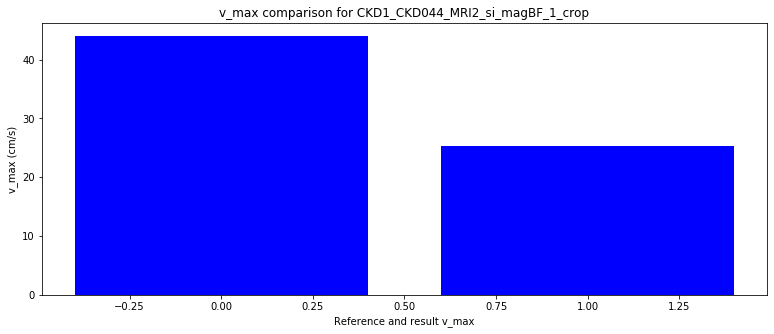

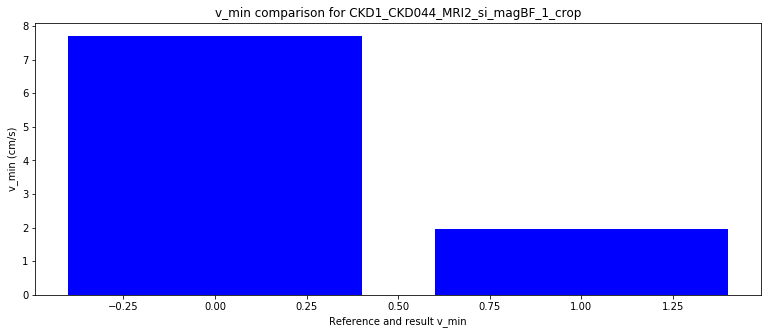

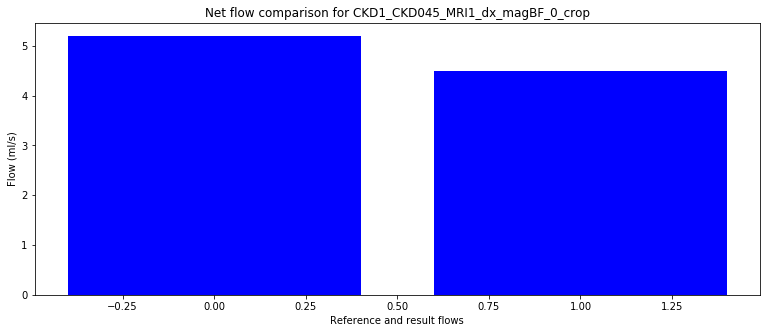

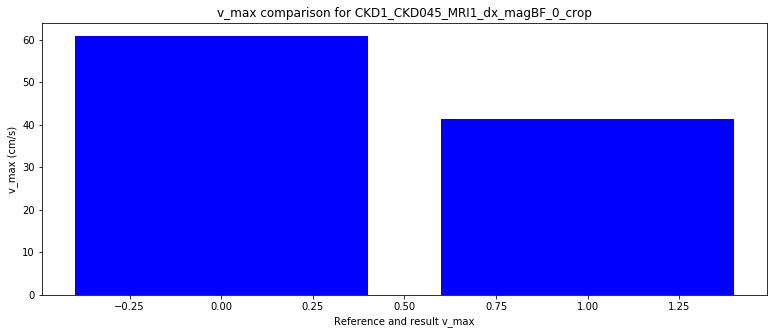

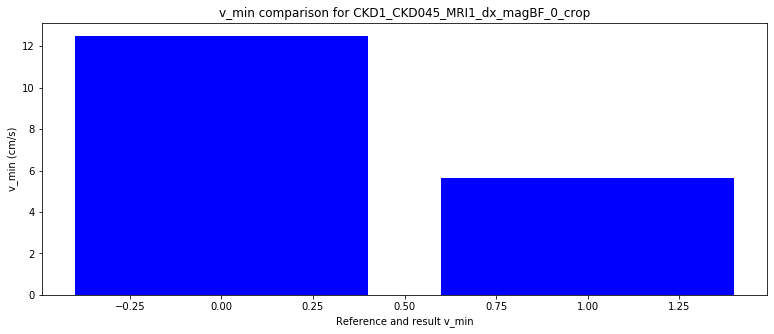

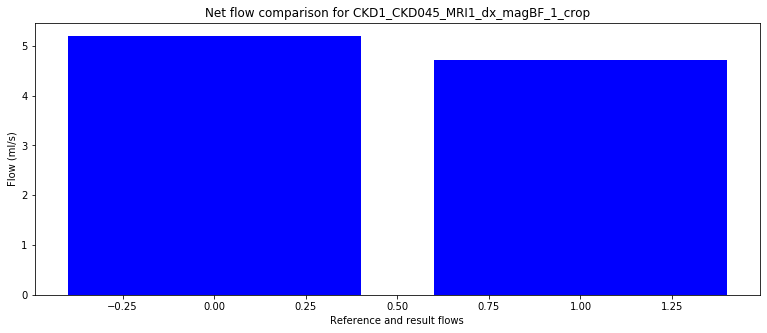

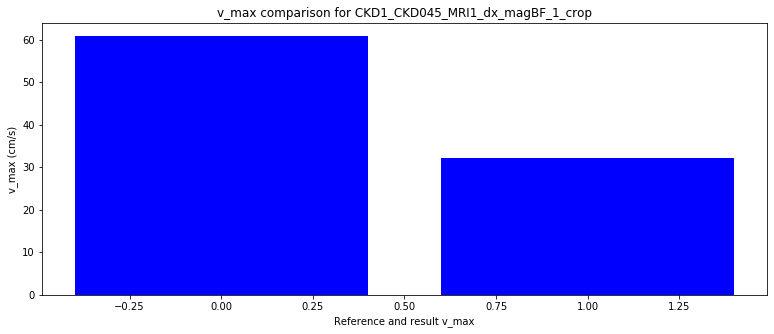

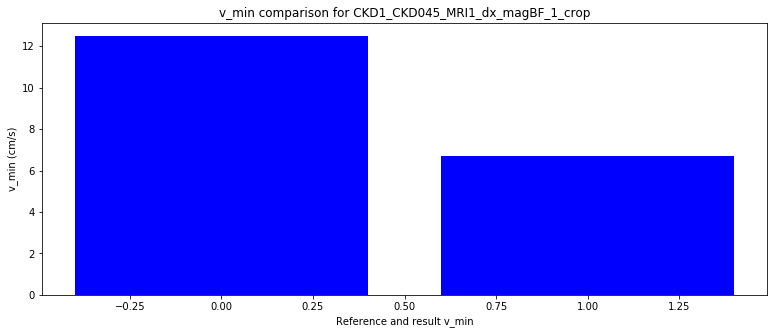

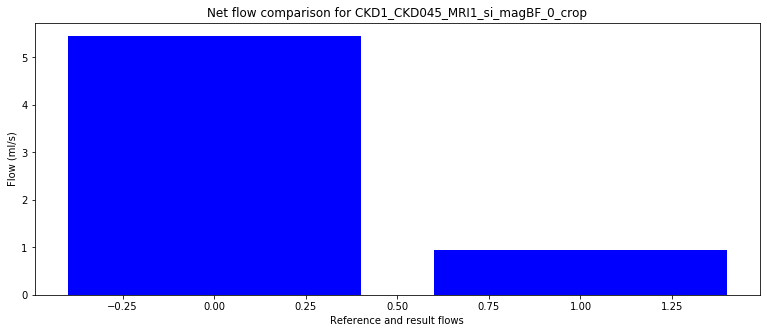

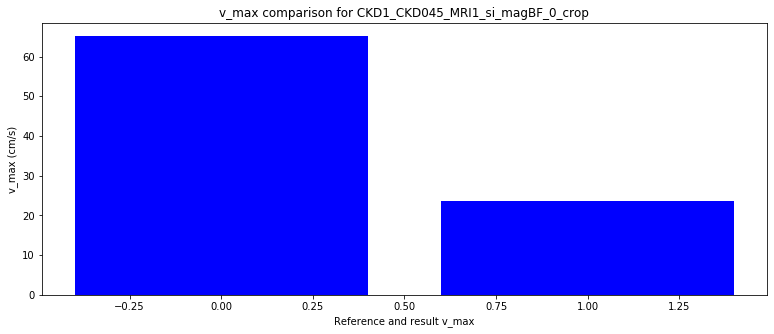

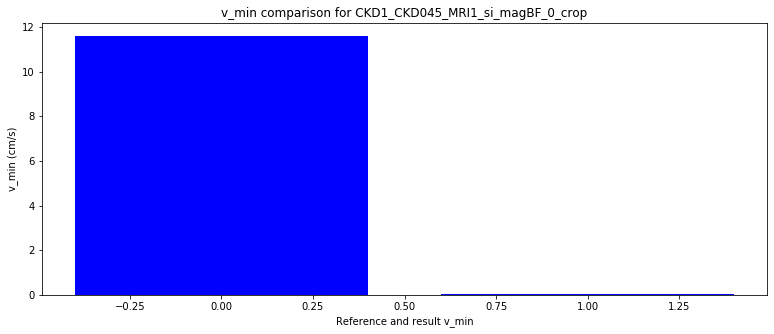

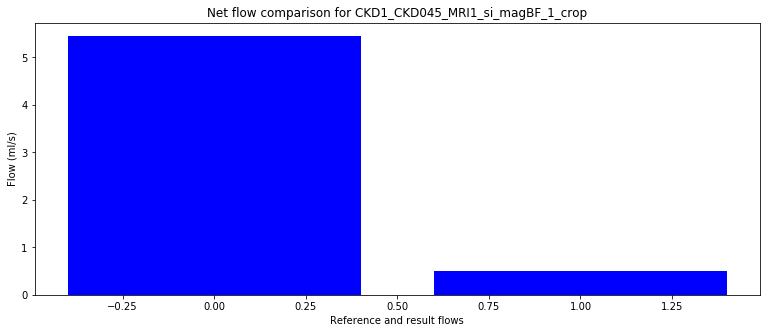

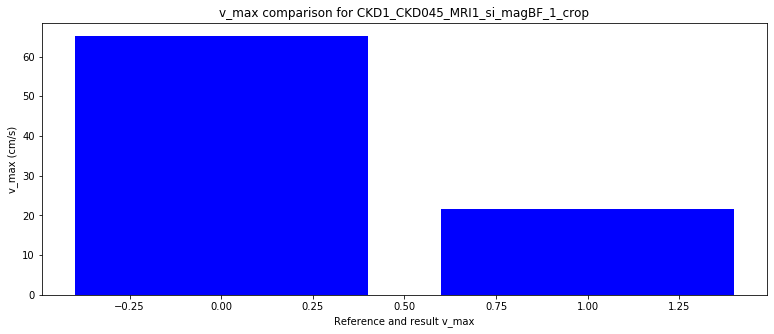

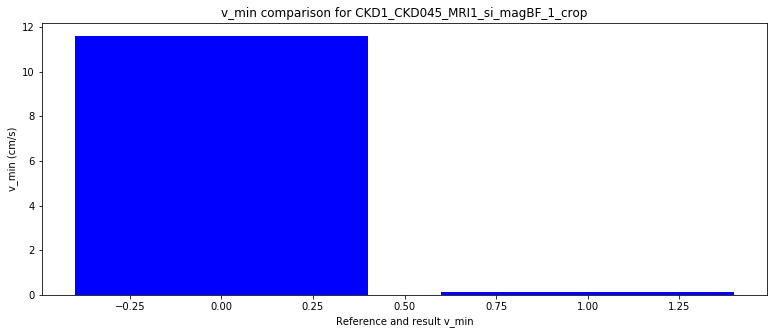

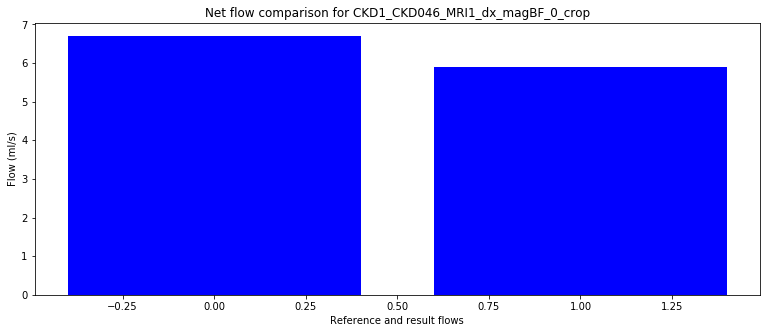

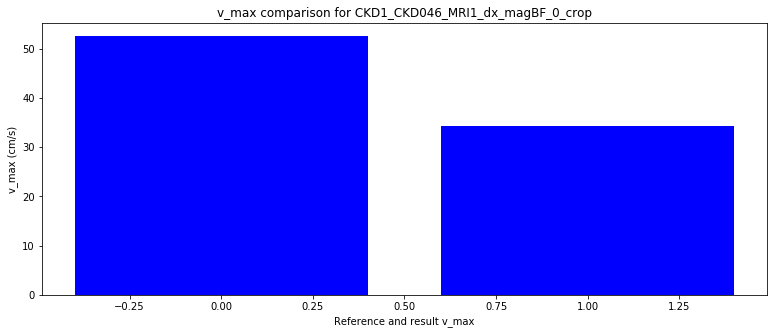

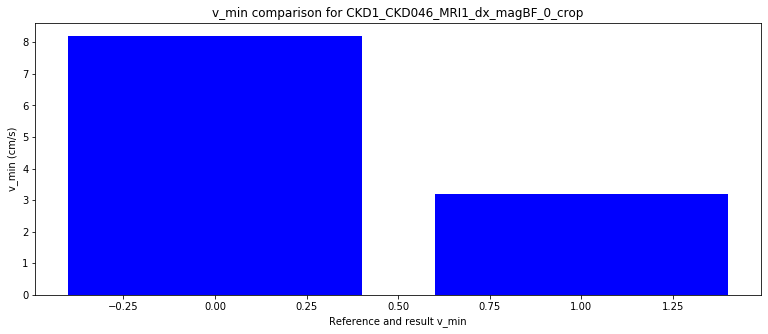

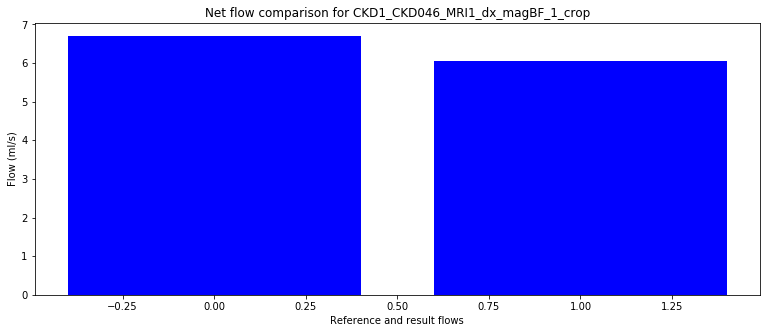

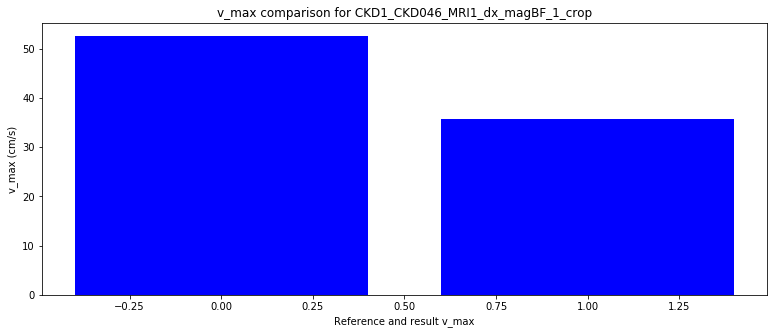

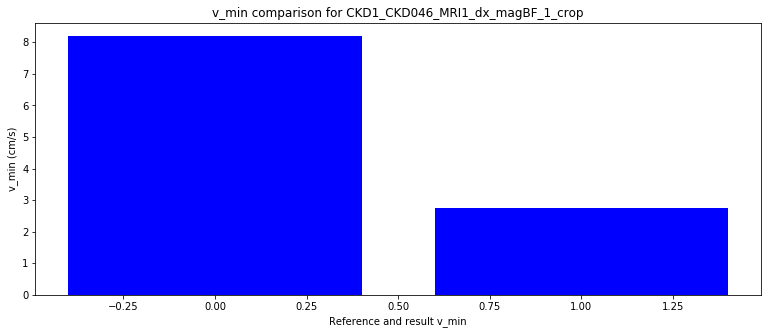

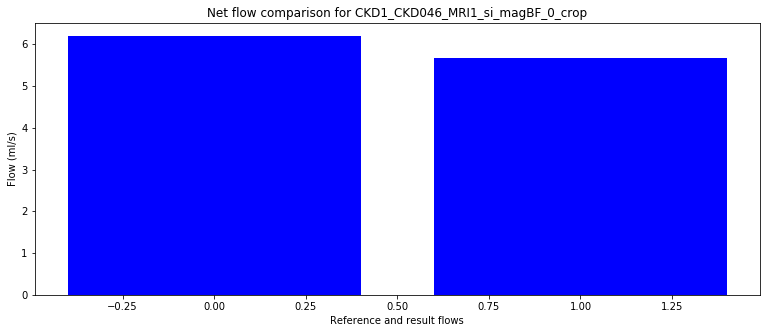

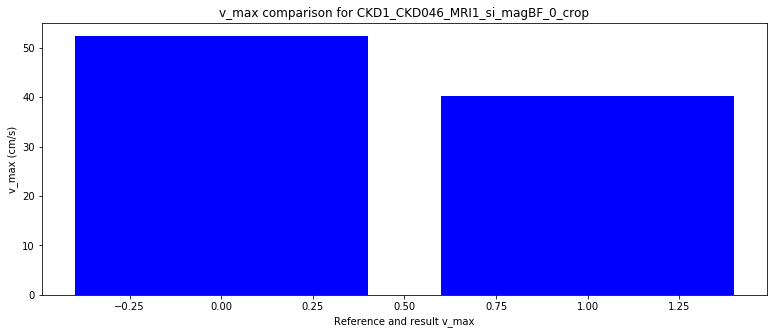

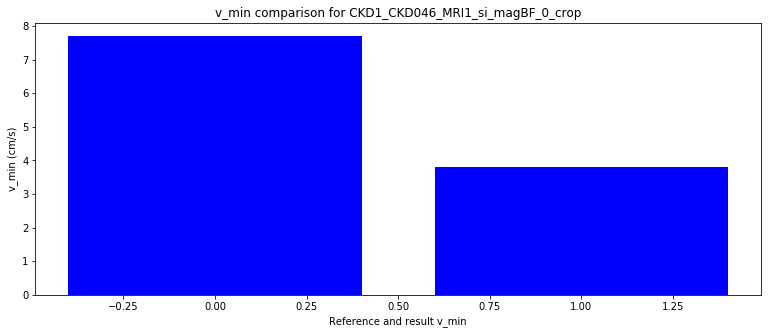

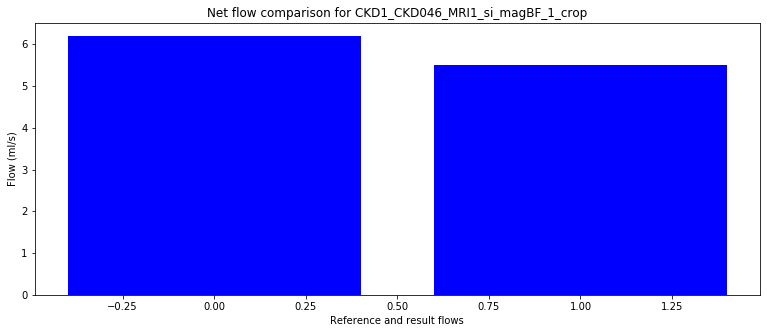

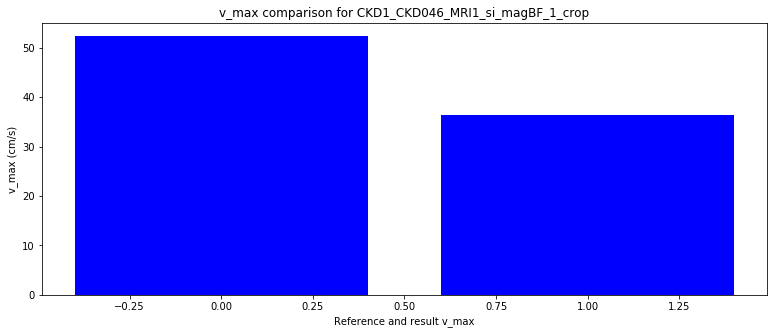

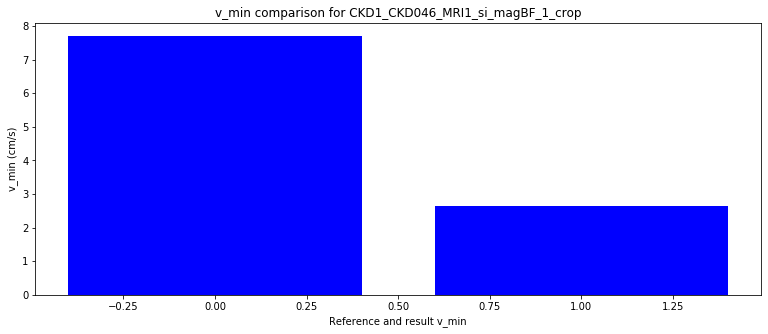

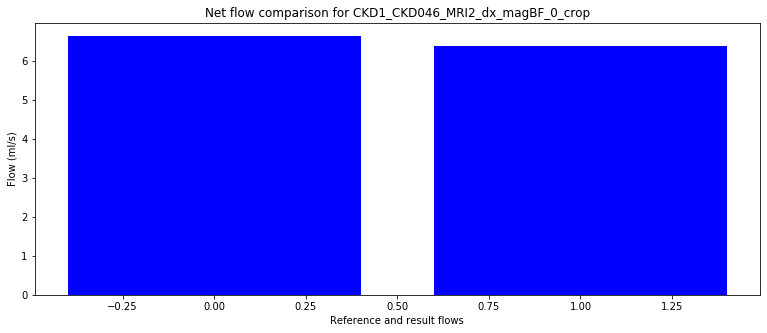

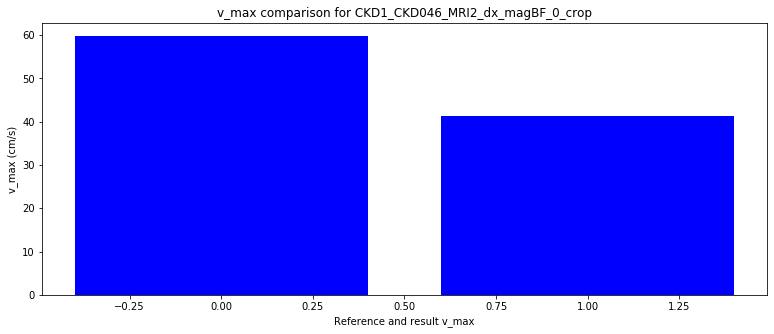

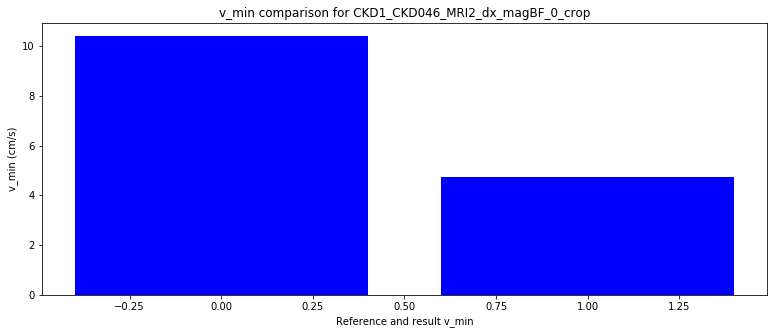

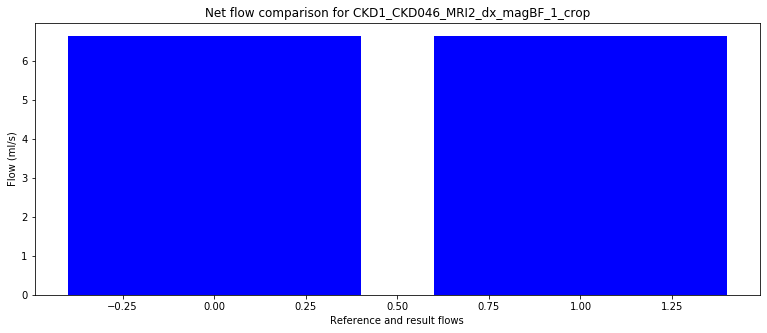

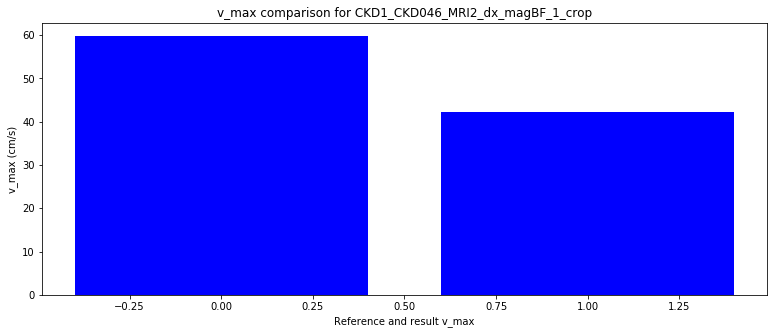

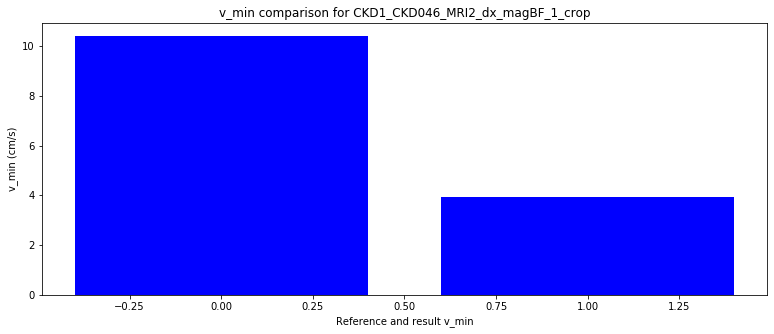

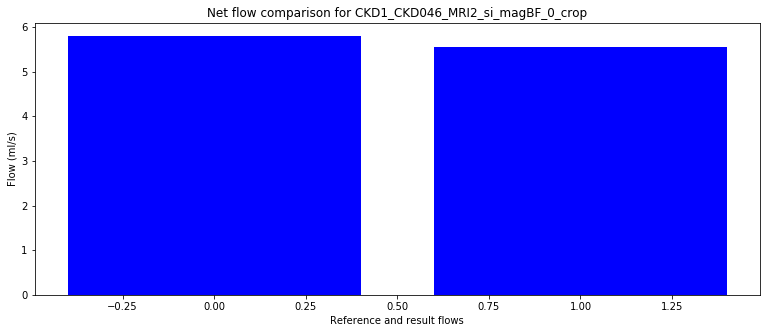

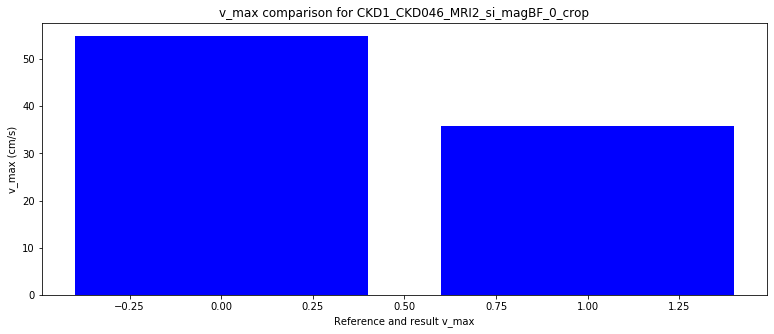

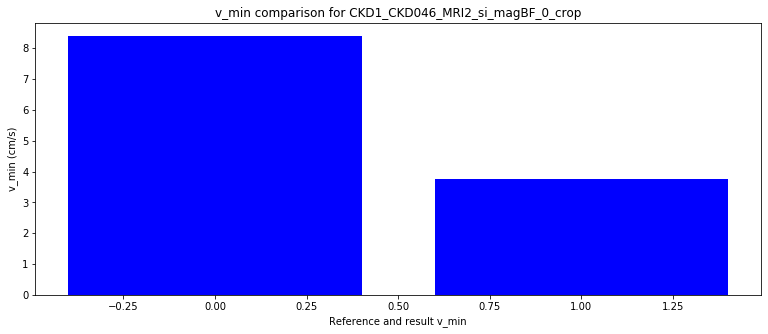

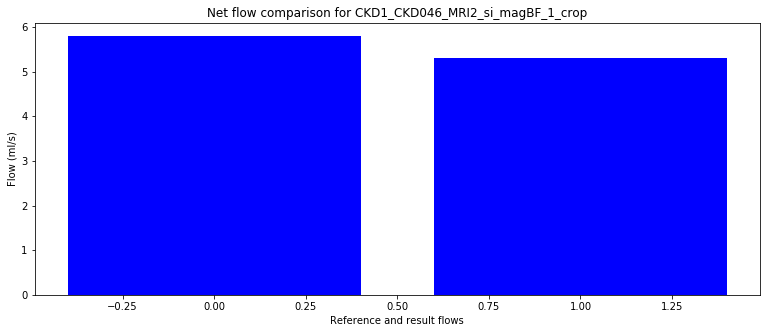

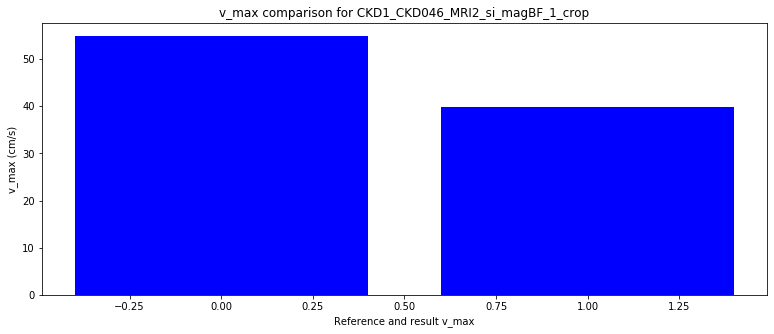

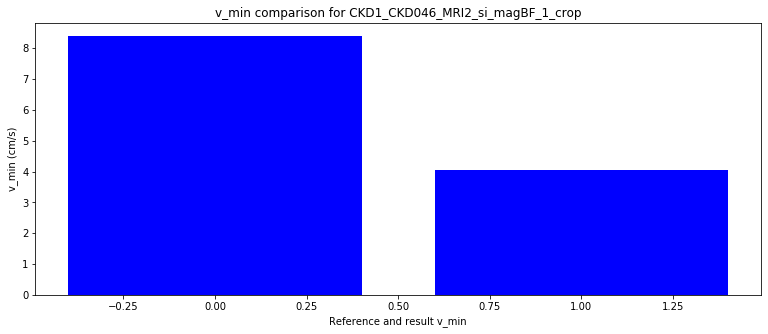

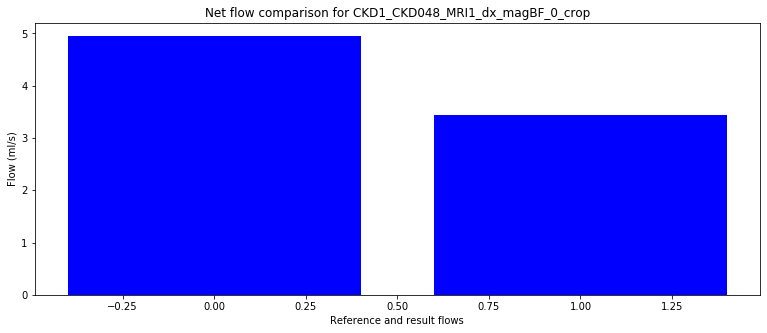

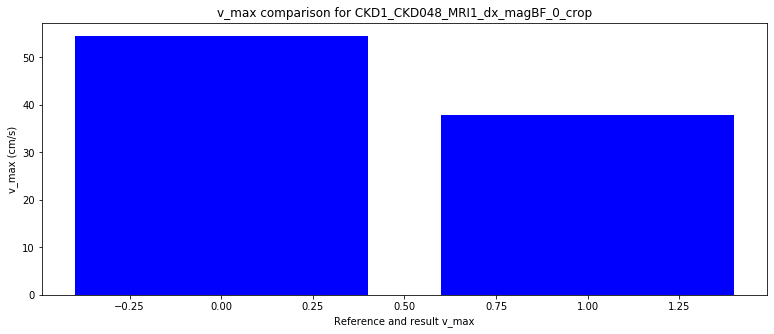

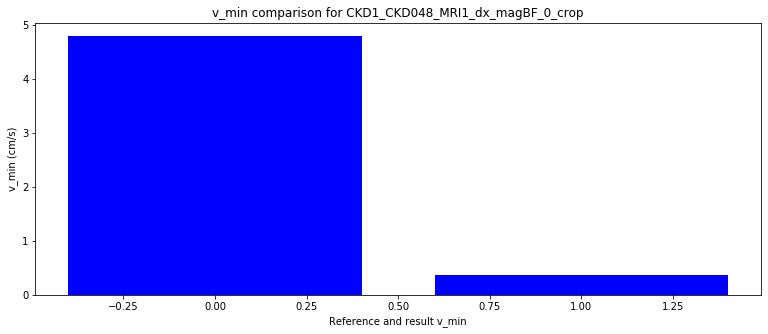

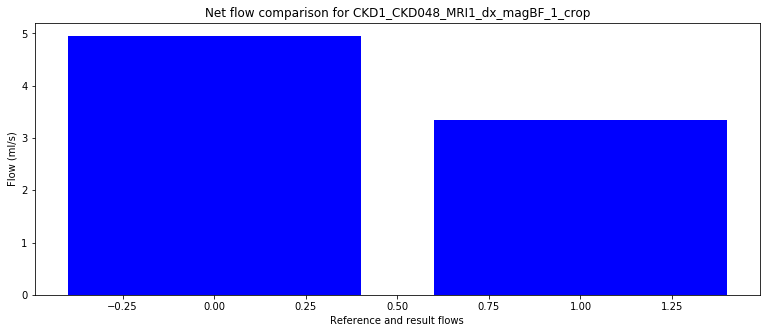

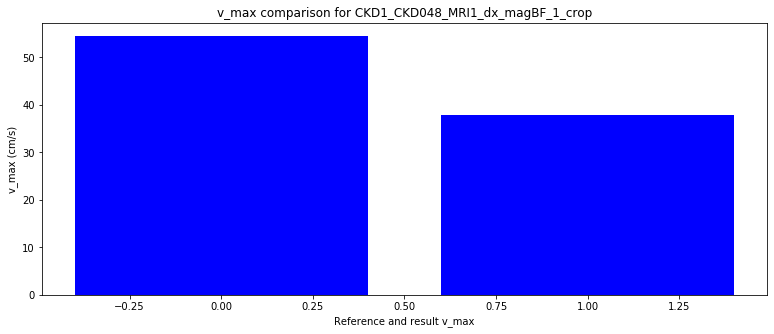

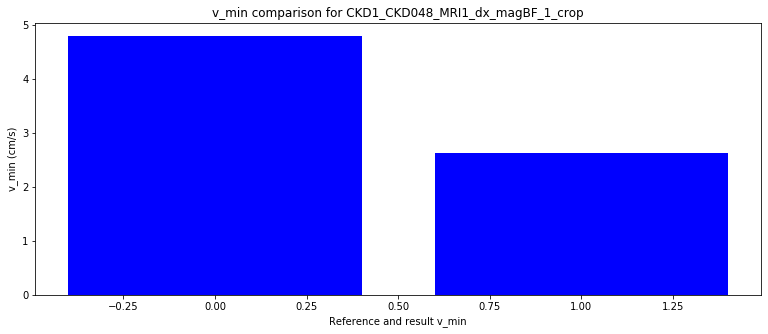

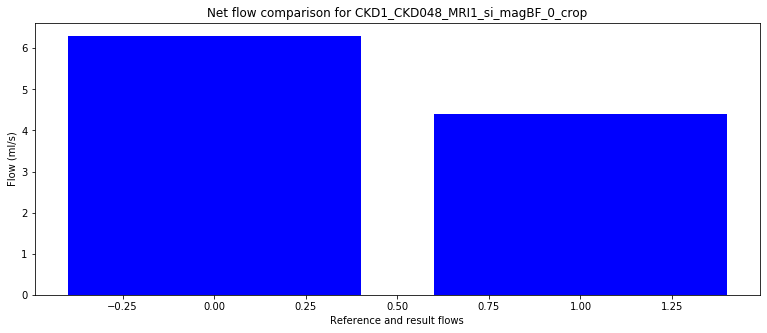

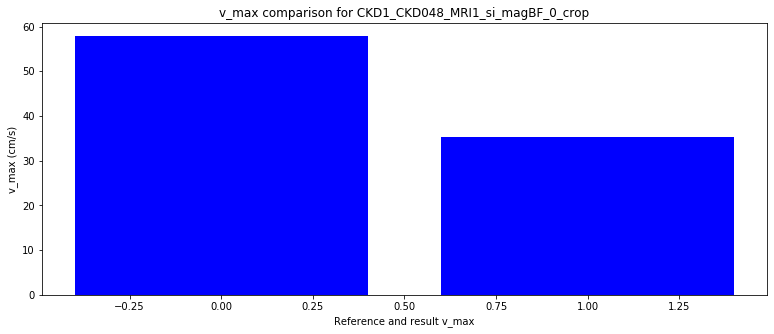

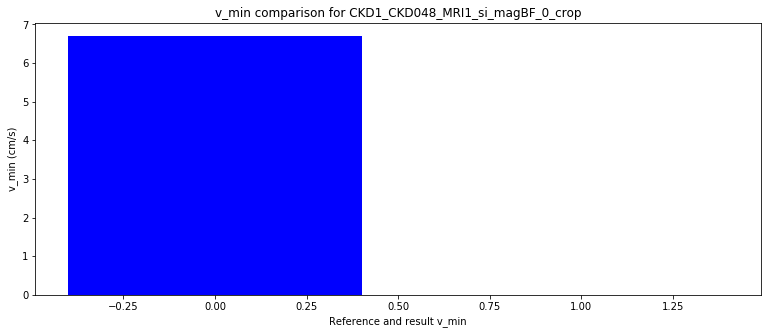

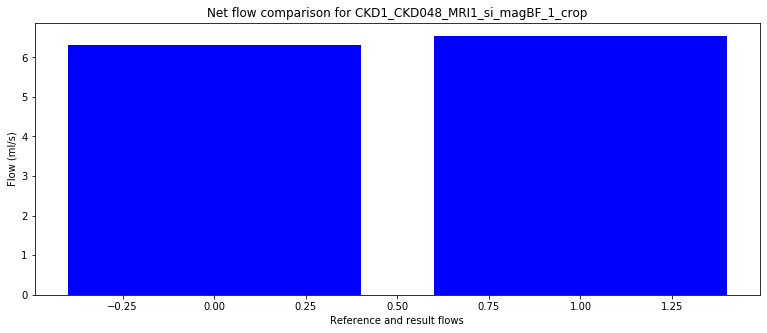

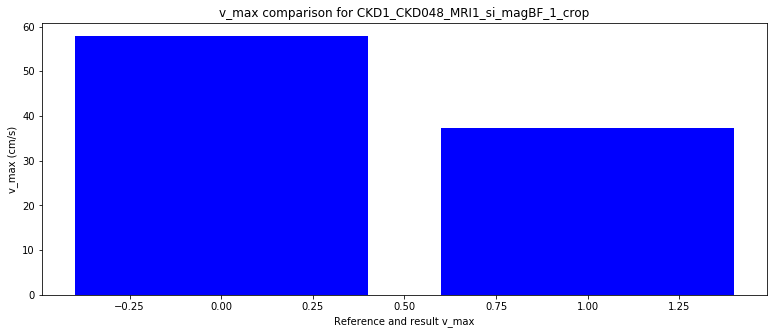

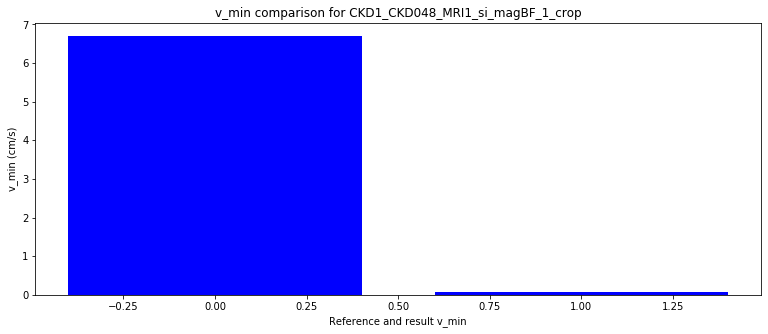

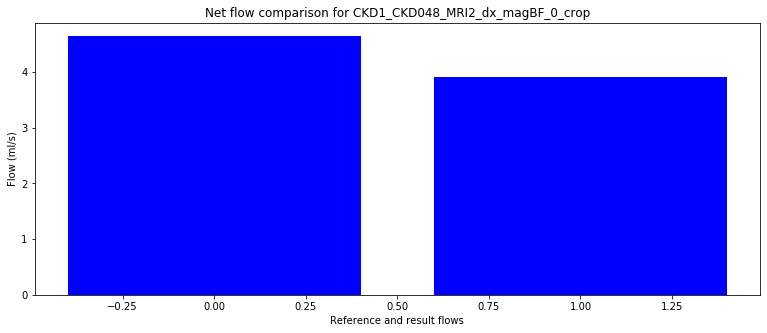

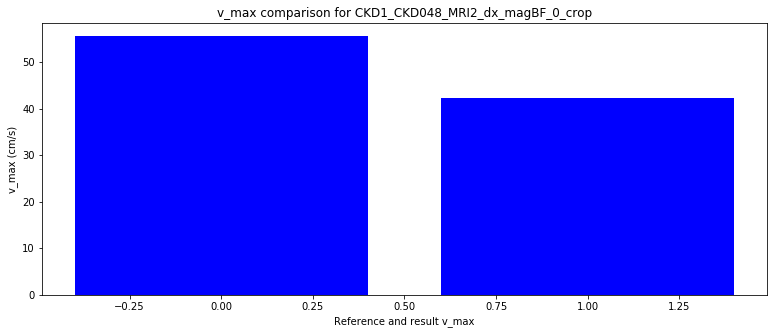

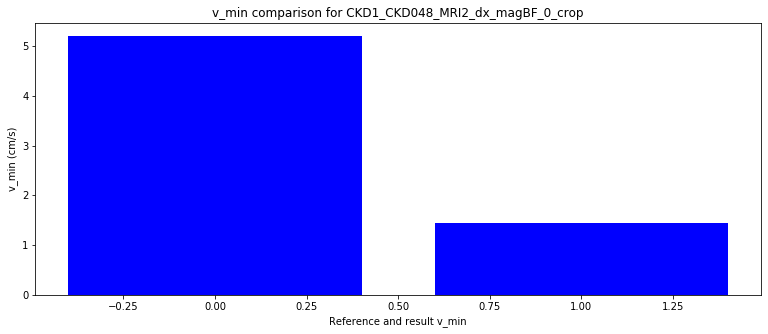

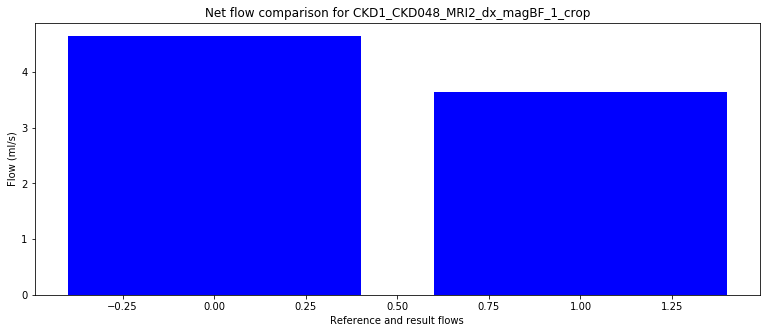

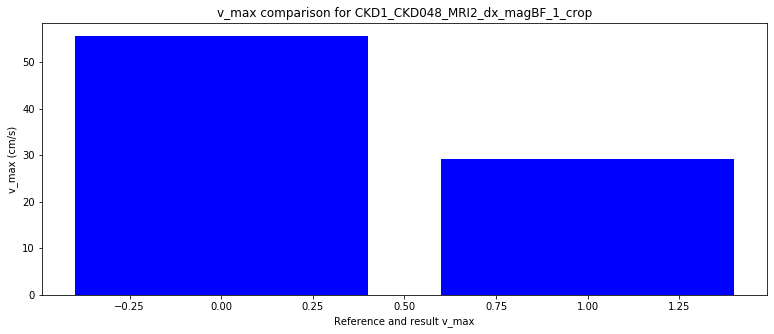

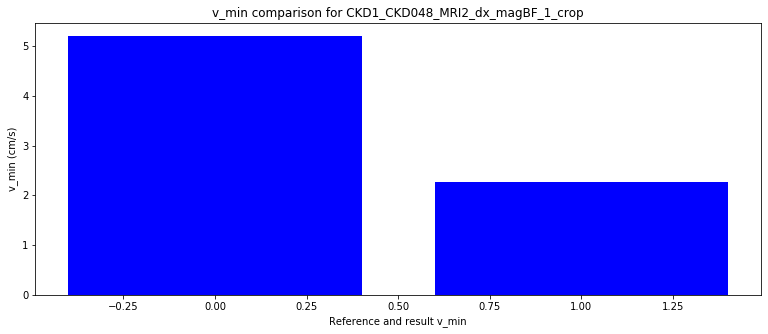

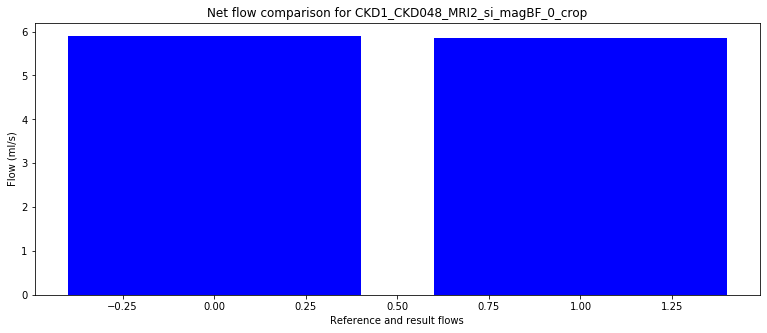

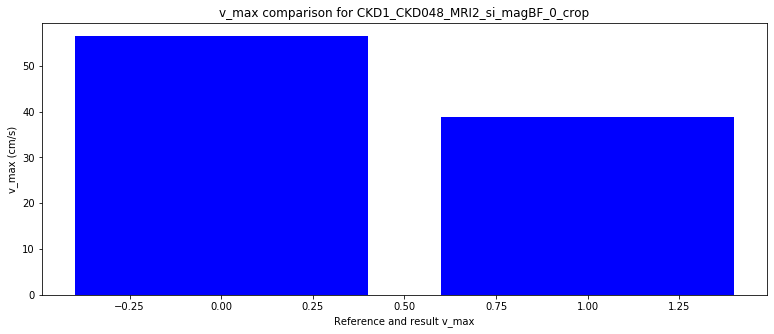

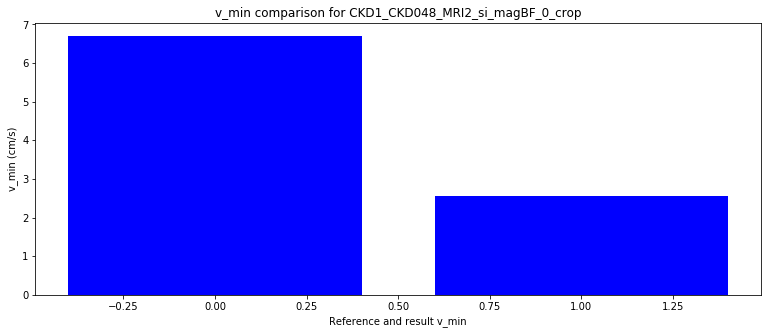

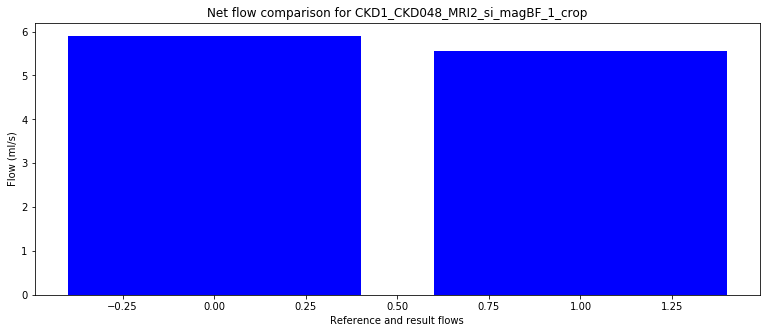

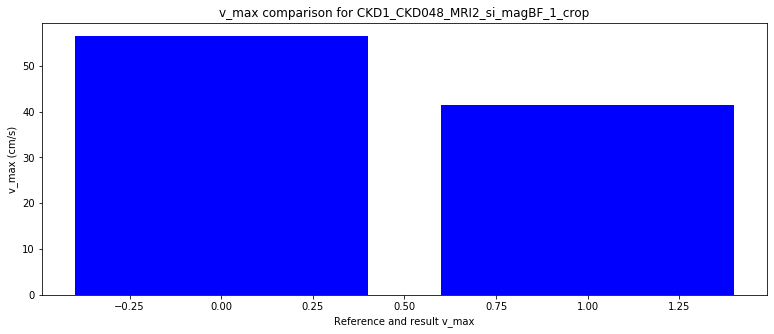

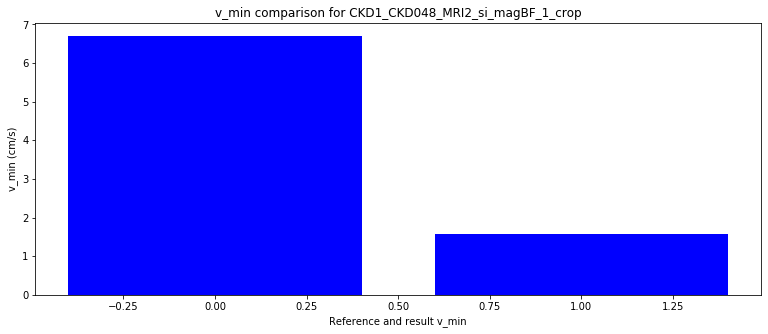

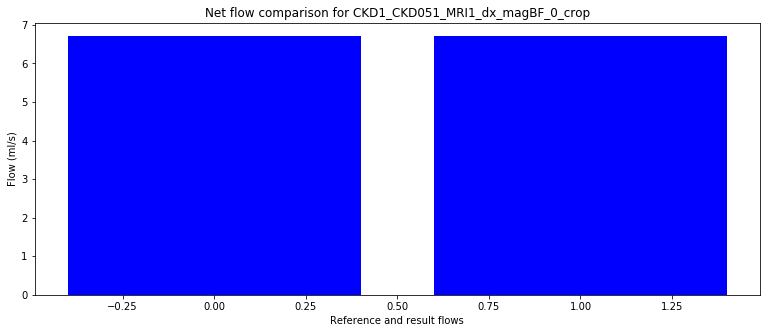

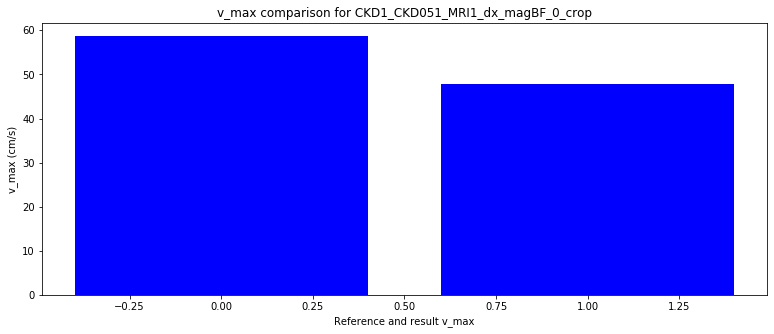

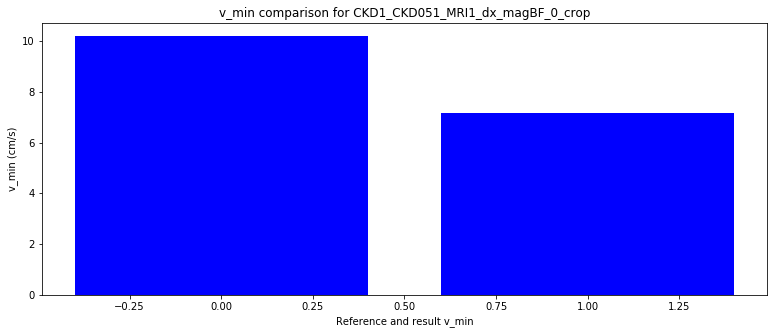

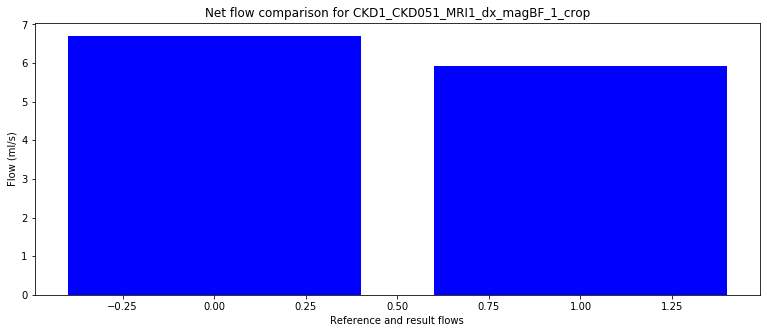

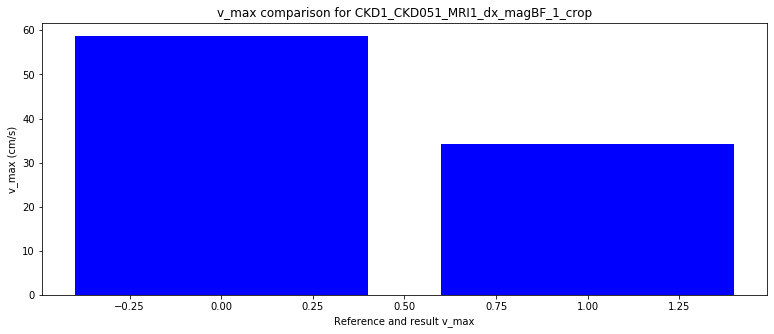

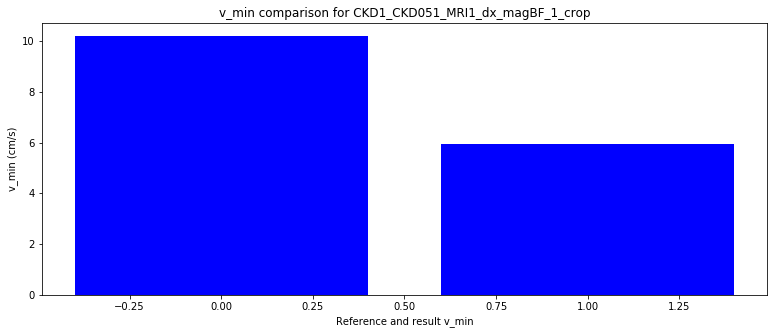

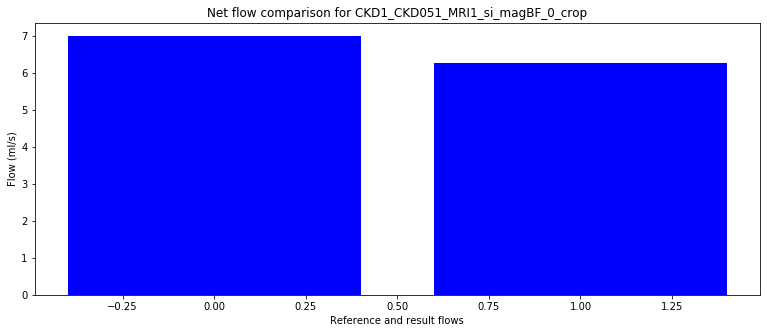

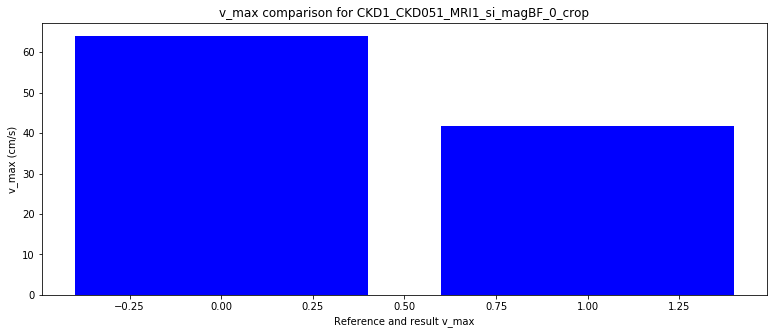

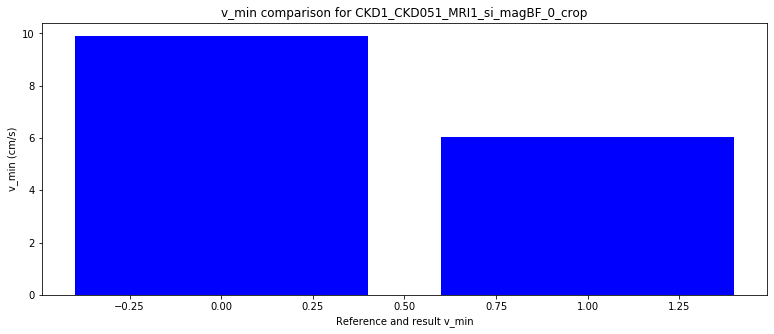

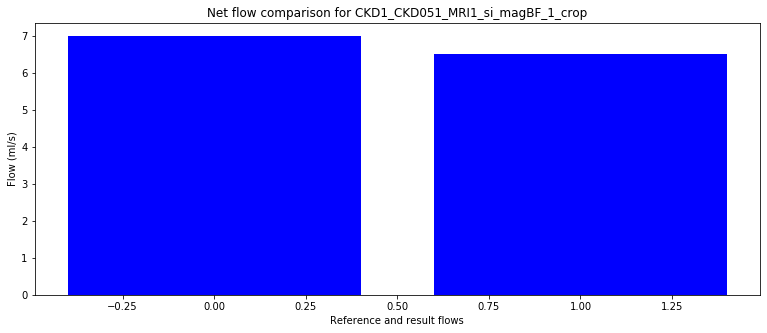

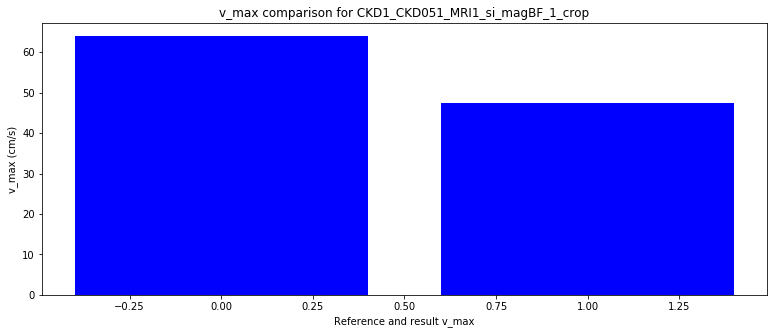

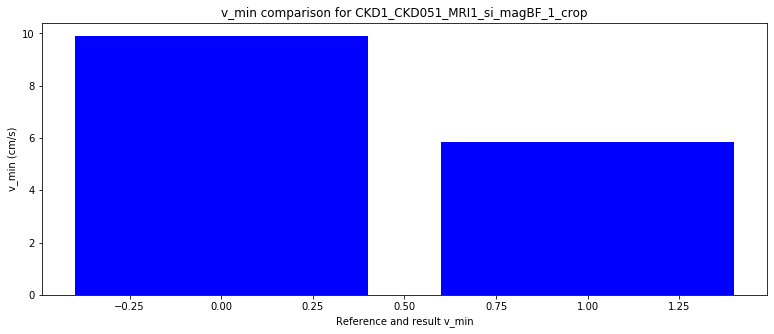

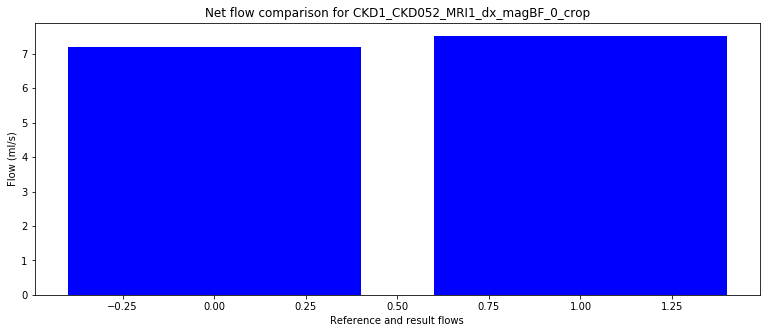

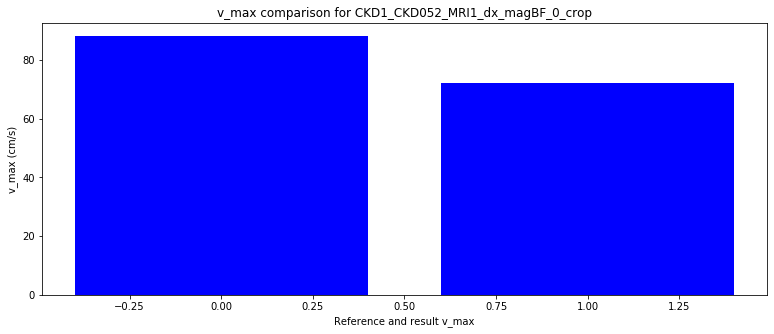

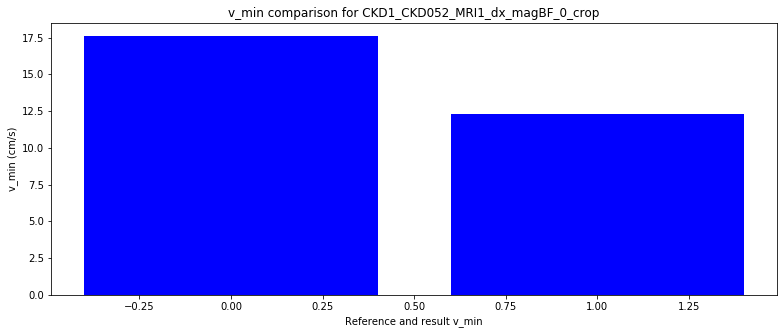

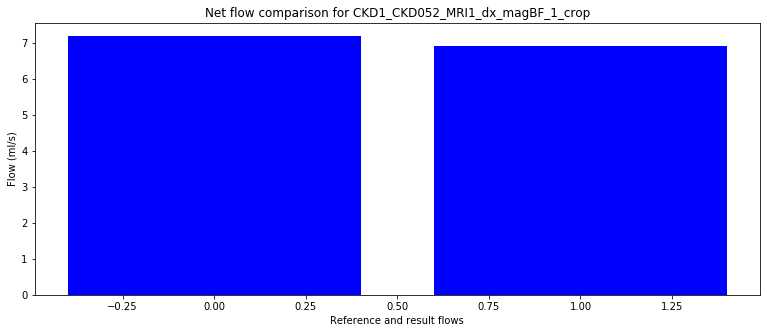

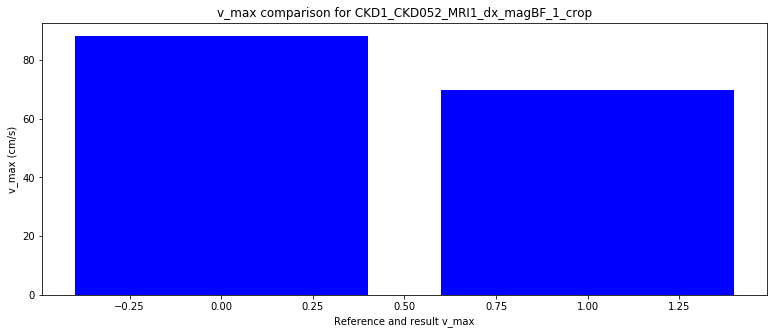

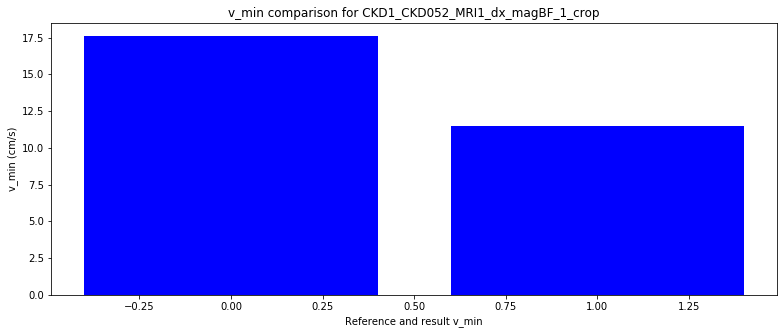

In [15]:
import sys

import os

import time

import torch

import numpy as np

import matplotlib.pyplot as plt

import params

import utilities

import torch.optim as optim

import models

import pandas as pd

import vtk

import itertools

from vtk.util.numpy_support import numpy_to_vtk, vtk_to_numpy

from flowInformation import FlowInfo

from torch.autograd import Variable

from evaluate import Dice, Precision, Recall

import cv2

from test import testing

import evaluate

from datasets import QFlowDataset

import models

import re

import flowStatistics


class testing:
    
    
    """
    Perform testing on the test dataset, given the folder where the test dataset is located, the set of models
    with which to perform the inference and extra data for the extraction of biomarkers
    
    Params:
    
        - test_path: path where the test set is allocated
        
        - model_filenames: list with the filenames of the models to test
        
        - model_path: folder where the model files have been saved
        
        - flow_paths: list of folders with biomarker information
        
        - excel_file: excel file with flow information from CKD1 study
        
        - dest_path: folder where to save results as MIPs or biomarker comparisons
        
        
    Return:
    
        - result_flows: biomarker values from the network and from outside (go later into a statistical framework)
        
        - result_metrics: if masks are available, metric results are also saved (Dice, precision, recall)
    
        - files: volumetric file names that have been evaluated
        
    """

    
    def __init__(self, test_path, model_filenames, model_path, flow_paths, excel_file, dest_path):
        
        
        self.test_path = test_path
        
        self.model_filenames = model_filenames
        
        self.model_path = model_path
        
        self.flow_paths = flow_paths
        
        self.excel_file = excel_file
        
        self.dest_path = dest_path
        
        
    def array2vtk(self, array, filename, dest_path, origin = [0,0,0], spacing = [1,1,1]):
                
        """
        Convert array into .vtk file
        
        - Params:
            
            inherited class parameters (see description at beginning of the class)
            
            array: array to be converted into .vtk file
            
            filename: filename with which to save array as VTK file
            
            origin: origin of coordinate system, by default (0,0,0)
            
            spacing: spacing of coordinate system, by default (1,1,1)
        
        """
          
        vtk_writer = vtk.vtkStructuredPointsWriter()
    
            
        # Check if destination folder exists
        
        #print('Checking if destination folder exists\n')
            
        isdir = os.path.isdir(dest_path)
            
        if not isdir:
            
            os.makedirs(dest_path)
            
            print('Non-existing destination path. Created\n')
        
        # Check if files already exist in destination folder
            
        exist = filename in os.listdir(dest_path)
        
        overwrite = 'y'
        
        if exist:
            
            overwrite = input("File is already in folder. Do you want to overwrite? [y/n]\n")
        
        if overwrite == 'y' or overwrite == 'Y':
                
            vtk_writer.SetFileName(dest_path + filename)
                
            vtk_im = vtk.vtkStructuredPoints()
        
            vtk_im.SetDimensions((array.shape[1],array.shape[0],array.shape[2]))
            
            vtk_im.SetOrigin(origin)
            
            vtk_im.SetSpacing(spacing)
        
            pdata = vtk_im.GetPointData()
        
            vtk_array = numpy_to_vtk(array.swapaxes(0,1).ravel(order='F'),deep = 1, array_type=vtk.VTK_FLOAT)
        
            pdata.SetScalars(vtk_array)
        
            vtk_writer.SetFileType(vtk.VTK_BINARY)
        
            vtk_writer.SetInputData(vtk_im)
        
            vtk_writer.Update()
            
            #print('VTK file saved successfully!\n')
        
        else:
            print('\nOperation aborted\n')


        
        

    def testing_dataLoader(self):

        """
        Data loader providing raw file and mask paths for model testing

        Params:

            - test_path: folder where to start looking for all files


        Returns:

            - raw_paths: list with paths for raw files

            - mask_paths: list with paths for mask files

            - total_patients: list with testing patients in 2D models

        """

        raw_paths = []

        mask_paths = []

        total_patients = []

        if params.three_D:

            if not('ckd1' in self.test_path):

                studies = sorted(os.listdir(self.test_path))

                for study in studies:

                    if study != '_ckd1':

                        study_path = self.test_path + study + '/'

                        patients = sorted(os.listdir(study_path))

                        for patient in patients:

                            image_path = study_path + patient + '/'

                            images = sorted(os.listdir(image_path))

                            if not('BF' in params.train_with):

                                if params.train_with == 'mag_' or params.train_with == 'both':

                                    ind_raw = [i for i,s in enumerate(images) if 'mag_' in s]

                                elif params.train_with == 'pha':

                                    ind_raw = [i for i,s in enumerate(images) if 'pha' in s]

                                ind_msk = [i for i,s in enumerate(images) if 'msk' in s]

                                for ind_r, ind_m in zip(ind_raw, ind_msk):

                                    raw_paths.append(image_path + images[ind_r])

                                    mask_paths.append(image_path + images[ind_m])


                            else:

                                ind_raw = [i for i,s in enumerate(images) if 'magBF' in s]

                                ind_msk = [i for i,s in enumerate(images) if 'msk' in s]

                                for ind_r, ind_m in zip(ind_raw, ind_msk):

                                    raw_paths.append(image_path + images[ind_r])

                                    mask_paths.append(image_path + images[ind_m])


            else:

                patients = sorted(os.listdir(self.test_path))

                for patient in patients:

                    if not('CKD015' in patient):

                        image_path = self.test_path + patient + '/'

                        images = sorted(os.listdir(image_path))

                        if not('BF' in params.train_with):

                            if params.train_with == 'mag_' or params.train_with == 'both':

                                ind_raw = [i for i,s in enumerate(images) if 'mag_' in s]

                            elif params.train_with == 'pha':

                                ind_raw = [i for i,s in enumerate(images) if 'pha' in s]

                            ind_msk = [i for i,s in enumerate(images) if 'msk' in s]

                            for ind_r, ind_m in zip(ind_raw, ind_msk):

                                raw_paths.append(image_path + images[ind_r])

                                mask_paths.append(image_path + images[ind_m])


                        else:

                            ind_raw = [i for i,s in enumerate(images) if 'magBF' in s]

                            ind_msk = [i for i,s in enumerate(images) if 'msk' in s]

                            for ind_r, ind_m in zip(ind_raw, ind_msk):

                                raw_paths.append(image_path + images[ind_r])

                                mask_paths.append(image_path + images[ind_m])



        else:

            if not('ckd1' in test_path):

                studies = sorted(os.listdir(self.test_path))

                for study in studies:

                    if study != '_ckd1':

                        study_path = self.test_path + study + '/'

                        patients = sorted(os.listdir(study_path))

                        for patient in patients:

                            patient_path = study_path + patient + '/' 

                            modalities = sorted(os.listdir(patient_path))

                            for modality in modalities:

                                if modality == 'msk':

                                    modality_path = patient_path + modality + '/'

                                    masks = sorted(os.listdir(modality_path))

                                    for mask in masks:

                                        mask_paths.append(modality_path + mask)

                                if not('BF' in params.train_with):

                                    if modality == 'mag':

                                        modality_path = patient_path + modality + '/'

                                        mags = sorted(os.listdir(modality_path))

                                        found = 0

                                        for mag in mags:

                                            if not('sum' in mag) and not('mip' in mag):

                                                raw_paths.append(modality_path + mag)

                                                ind_frame = mag.index('_frame')

                                                total_patients.append(mag[:ind_frame])

                                else:

                                    if modality == 'magBF':

                                        modality_path = patient_path + modality + '/'

                                        mags = sorted(os.listdir(modality_path))

                                        found = 0

                                        for mag in mags:

                                            if not('sum' in mag) and not('mip' in mag):

                                                raw_paths.append(modality_path + mag)

                                                ind_frame = mag.index('_frame')

                                                total_patients.append(mag[:ind_frame])

                                total_patients = np.unique(np.array(total_patients)).tolist()

            else:

                patients = sorted(os.listdir(self.test_path))

                for patient in patients:

                    if not('CKD015' in patient):

                        patient_path = self.test_path + patient + '/'

                        modalities = sorted(os.listdir(patient_path))

                        for modality in modalities:        

                            if not('BF' in params.train_with):

                                if modality == 'mag':

                                    modality_path = patient_path + modality + '/'

                                    mags = sorted(os.listdir(modality_path))

                                    for mag in mags:

                                        if not('sum' in mag) and not('mip' in mag):

                                            raw_paths.append(modality_path + mag)

                                            ind_frame = mag.index('_frame')

                                            total_patients.append(mag[:ind_frame])
                                            

                            else:

                                if modality == 'magBF':

                                    modality_path = patient_path + modality + '/'

                                    mags = sorted(os.listdir(modality_path))

                                    for mag in mags:

                                        if not('sum' in mag) and not('mip' in mag):

                                            raw_paths.append(modality_path + mag)

                                            ind_frame = mag.index('_frame')

                                            total_patients.append(mag[:ind_frame])

                            total_patients = np.unique(np.array(total_patients)).tolist()

        return raw_paths, mask_paths, total_patients



    def modelPreparation(self, model_filename):

        """
        Prepares model and optimizer to load them for inference.

        Returns: list with loaded models and optimizers

        """

        if params.architecture == "UNet_with_Residuals":

            net = models.UNet_with_Residuals().cuda()

        elif params.architecture == "UNet_with_ResidualsPretrained":

            net = UNet_with_ResidualsPretrained().cuda()


        elif params.architecture == "NewUNet_with_Residuals":

            net = models.NewUNet_with_Residuals().cuda() 

        elif params.architecture == "UNetRNN":

            net = models.UNetRNN().cuda()


        elif params.architecture == "UNet_with_ResidualsFourLayers":

            net = models.UNet_with_ResidualsFourLayers().cuda()


        elif params.architecture == "AttentionUNet":

            net = models.AttentionUNet().cuda()


        elif params.architecture == "NewAttentionUNet":

            net = models.NewAttentionUNet().cuda()
            
        elif params.architecture == "TimeDistributedAttentionUNet":
        
            net = models.TimeDistributedAttentionUNet().cuda()
            
        elif params.architecture == "TimeDistributedUNet":
        
            net = models.TimeDistributedUNet().cuda()
            
        elif params.architecture == "Hourglass":
        
            net = models.Hourglass().cuda()
            
        elif params.architecture == "NestedUNet2d":

            net = models.NestedUNet2d().cuda()
            
        elif params.architecture == "NestedUNet2dTime":
        
            net = models.NestedUNet2dTime().cuda()
            
        elif params.architecture == "NestedUNet2dAutocontext":
        
            net = models.NestedUNet2dAutocontext().cuda()
            
        elif params.architecture == "NestedUNet2dTimeAutocontext":
        
            net = models.NestedUNet2dTimeAutocontext().cuda()
            
        elif params.architecture == "NestedUNet2dScale":
        
            net = models.NestedUNet2dScale().cuda()


            # MORE MODELS TO COME!!!

        else:

            print('Wrong architecture. Please introduce a valid architecture')


        if params.opt == 'Adam':

            optimizer = optim.Adam(net.parameters(), params.lr)

        elif params.opt == 'RMSprop':

            optimizer = optim.RMSprop(net.parameters(), params.lr)

        elif params.opt == 'SGD':

            optimizer = optim.SGD(net.parameters(), params.lr)

        else:

            print('\nWrong optimizer. Please define a valid optimizer (Adam/RMSprop/SGD)\n')



        net, optimizer = utilities.model_loading(net, optimizer, self.model_path, model_filename)

        return net, optimizer


    def atoi(self, text):

        """

        Function helping to sort a list of strings with numbers inside

        """

        return int(text) if text.isdigit() else text
    
    

    def natural_keys(self, text):

        '''
        alist.sort(key=natural_keys) sorts in human order
        http://nedbatchelder.com/blog/200712/human_sorting.html
        (See Toothy's implementation in the comments)
        '''

        return [ self.atoi(c) for c in re.split(r'(\d+)', text) ]



    def Segmentation(self, X, out, Y):

        """
        Provide a segmentation VTK file with testing results of mask overlapped
        with normal raw image.

        Params:

            - X: raw image array

            - out: output tensor from neural network

            - Y: mask array (if unavailable, None)


        Results:

            saved VTK image in color (G: correct segmentation B: under segmentation
            R: over segmentation)


        """

        final_result = np.zeros((X.shape[0], X.shape[1], X.shape[2], 3))

        for i in range(final_result.shape[-1]):

            final_result[:,:,:,i] = (X-np.amin(X))/(np.amax(X)-np.amin(X)) # Grayscale values from 0 to 255




        if Y is None:

            # If no mask available, leave segmented result in green

            ind_green = np.array(np.where(out > 0.5))

            final_result[ind_green[0,:], ind_green[1,:], ind_green[2,:], 0] = 0

            final_result[ind_green[0,:], ind_green[1,:], ind_green[2,:], 1] = 1

            final_result[ind_green[0,:], ind_green[1,:], ind_green[2,:], 2] = 0


        else:


            # If mask is available, leave coincident results in green, results with result but not with mask in red 
            # and results with mask but not with result in blue

            ind_pos_out = np.where(out > 0) # Result locations

            ind_pos_Y = np.where(Y > 0) # Mask locations

            out_aux = np.copy(out)

            Y_aux = np.copy(Y)

            out_aux[ind_pos_out] = 2 # Set result locations to 2

            Y_aux[ind_pos_Y] = 3 # Set mask locations to 3

            mult = out*Y

            ind_green = np.array(np.where(mult > 0))

            total = out_aux + Y_aux

            ind_red = np.array(np.where(total == 1))

            ind_blue = np.array(np.where(total == 3))

            # Color final mask result

            final_result[ind_red[0,:], ind_red[1,:], ind_red[2,:], 0]  = 1

            final_result[ind_red[0,:], ind_red[1,:], ind_red[2,:], 1]  = 0

            final_result[ind_red[0,:], ind_red[1,:], ind_red[2,:], 2]  = 0

            final_result[ind_green[0,:], ind_green[1,:], ind_green[2,:], 0] = 0

            final_result[ind_green[0,:], ind_green[1,:], ind_green[2,:], 1] = 1

            final_result[ind_green[0,:], ind_green[1,:], ind_green[2,:], 2] = 0

            final_result[ind_blue[0,:], ind_blue[1,:], ind_blue[2,:], 0] = 0

            final_result[ind_blue[0,:], ind_blue[1,:], ind_blue[2,:], 1] = 0

            final_result[ind_blue[0,:], ind_blue[1,:], ind_blue[2,:], 2] = 1


        return final_result


    def readVTK(self, filename, order='F'):

        """
        Utility function to read vtk volume. 

        Params:

            - inherited from class (check at the beginning of the class)
            - path: path where VTK file is located
            - filename: VTK file name

        Returns:

            - numpy array
            - data origin
            - data spacing

        """

        reader = vtk.vtkStructuredPointsReader()

        reader.SetFileName(filename)

        reader.Update()

        image = reader.GetOutput()

        numpy_array = vtk_to_numpy(image.GetPointData().GetScalars())

        numpy_array = numpy_array.reshape(image.GetDimensions(),order='F')

        numpy_array = numpy_array.swapaxes(0,1)

        origin = list(image.GetOrigin())

        spacing = list(image.GetSpacing())

        return numpy_array, origin, spacing

    

    def MIP(self, X, out, Y, img_filename):

        """
        Provide a MIP image with found result.

        Params:

            - X: raw image array

            - out: output tensor from neural network

            - mask: provided mask tensor (if unavailable: None)

            - img_filename: filename ID with which to save MIP image as PNG

            - dest_path: destination folder


        Results:

            saved PNG image in color (G: correct segmentation B: under segmentation
            R: over segmentation)


        """

        final_result = self.Segmentation(X, out, Y)

        mip_result = np.round(np.sum(255*final_result, axis = 0)/final_result.shape[2]).astype(int)

        # Decide on final filename

        if 'pha' in params.train_with:

            filename = img_filename.replace('pha','mip') + '.png'

        elif not('pha' in params.train_with) and not('BF' in params.train_with):

            filename = img_filename.replace('mag','mip') + '.png'

        elif not('pha' in params.train_with) and ('BF' in params.train_with):

            filename = img_filename.replace('magBF','mip') + '.png'

        # Exchange blue and red channels to write PNG file with CV2

        mip_aux = np.copy(mip_result)

        mip_aux[:,:,0] = mip_result[:,:,-1]

        mip_aux[:,:,-1] = mip_result[:,:,0]

        cv2.imwrite(self.dest_path + filename, mip_aux)


    
    def majorityVoting(self, results):

        """
        Implement a majority voting of the results given by the different models from the cross-validation folds

        Params:

            - inherited by the class

            - results: list with model results (binary)

        Returns:

            - result: result with majority voting

        """

        s = sum(results)
        
        result = (s > 0)
        
        #result1 = (s == 1)
        
        #result2 = (s == len(results))
        
        #new_s = sum([result1, result2])
        
        #result = (new_s > 0)

        return result



    def flowFromMask(self, mask, raw, spacing):

        """
        Compute flow parameters from masks and phase images.

        Params:

            - inherited from class (check at the beginning of the class)
            - mask: binary or quasi-binary 3D array with results from neural network segmentation
            - raw: corresponding velocity array
            - spacing: pixel size, useful to extract area and flow information

        Returns:

            - result: 2D array with results on average velocity, standard deviation,
                    maximum velocity, minimum velocity, area, net flow, positive flow
                    and negative flow

        """

        mult = mask * raw

        result = np.zeros((8, mask.shape[0]))

        for j in range(mask.shape[0]): # Frame by frame analysis

            mult_frame = mult[j,:,:] # Frame of the multiplication operator

            s = np.sum(mult_frame.flatten()) # Overall sum of velocities for each frame. If > 0 --> left kidney, if < 0 --> right kidney

            ind = np.where(mult_frame != 0) # Indexes inside the ROI
            
            if len(mult_frame[ind]) != 0:

                result[0,j] = np.mean(mult_frame[ind].flatten()) # Mean values (cm/s)

                result[1,j] = np.std(mult_frame[ind].flatten()) # Standard deviation (cm/s)

                result[2,j] = np.amax(np.abs(mult_frame[ind])) # Maximum value (cm/s)

                result[3,j] = np.amin(np.abs(mult_frame[ind])) # Minimum value (cm/s)
                
                result[4,j] = (len(ind))*spacing[0]*spacing[1] # Area (cm2)
                
                aux = mult_frame[ind]
                
                pos = np.where(aux > 0)
                
                neg = np.where(aux < 0)
                
                result[6,j] = np.sum(aux[pos].flatten())*spacing[0]*spacing[1]/100 # Positive flow

                result[7,j] = np.sum(aux[neg].flatten())*spacing[0]*spacing[1]/100 # Negative flow

                result[5,j] = result[6,j] + result[7,j]

                ind_pos = np.where(mult_frame > 0) # Positive voxel values

                ind_neg = np.where(mult_frame < 0) # Negative voxel values


        return result


    def phase2velocity(self, phase_array, img_filename):

        """
        Transforms raw phase image into velocity map, to later extract flow information.

        Params:

            - phase array: array with phase values

        Returns:

            -vel_array: array with velocity values


        """

        # Extract VENC info

        vencs = np.loadtxt('/home/andres/Documents/_Data/venc_info/' + 'venc_values.txt')

        names = np.loadtxt('/home/andres/Documents/_Data/venc_info/' + 'venc_files.txt', dtype = 'str')

        study = img_filename[:4]

        if 'BF' in params.train_with:

            name = img_filename.replace('magBF_','')

        elif params.train_with == 'mag_' or params.train_with == 'both':

            name = img_filename.replace('mag_','')

        elif params.train_with == 'pha':

            name = img_filename.replace('pha_','')


        if params.prep_step != 'raw':

            name = name.replace('_' + params.prep_step, '')


        ind = np.where(names == name)

        venc = vencs[ind]

        # Analyze CKD1 and CKD2 studies

        # Set phase from 0 to +1, being scaled by the VENC

        vel_array = phase_array/venc[0]

        vel_array = vel_array + 1

        vel_array = vel_array*0.5

        return vel_array, venc[0]


    def excelInfo(self, flow_path, img_filename):

        """
        Extract flow information from Excel file.


        Returns:

            - array with maximum velocity, minimum velocity and mean arterial flow


        """

        # Extract measured patients from CKD1

        target_patient = img_filename[5:11]

        target_rep = img_filename[12:16]

        target_orient = img_filename[17:19]

        df = pd.read_excel(flow_path + self.excel_file) # can also index sheet by name or fetch all sheets

        flow = np.array(df['Mean_arterial_flow'].tolist()) # List with flow values

        max_v = np.array(df['Peak_velocity_max'].tolist()) # List with maximum velocity values

        min_v = np.array(df['Peak_velocity_min'].tolist()) # List with minimum velocity flow values

        rep = np.array(df['MR_Visit']) # List with repetitions

        patients = df['Subject_ID'].tolist()

        orient_ckd1 = np.array(df['left_right_kidney'].tolist()) 

        ind_left = np.where(orient_ckd1 == 'left')

        ind_right = np.where(orient_ckd1 == 'right')

        orient_final = np.copy(orient_ckd1) # List with kidney orientations

        orient_final[ind_left] = 'si'

        orient_final[ind_right] = 'dx' 

        # Patient measurements

        patient_ind = np.array([i for i, s in enumerate(patients) if target_patient in s]).astype(int) # Indexes of same patient

        orients = orient_final[patient_ind] # Patient orientations

        ind_orient = np.array([i for i, s in enumerate(orients) if target_orient in s]).astype(int)

        patient_orient_ind = patient_ind[ind_orient] # Indexes of patient with same kidney orientation

        patient_rep = rep[patient_orient_ind] # Patient visits with same orientation

        ind_rep = np.array([i for i, s in enumerate(patient_rep) if target_rep in s]).astype(int)

        patient_orient_rep_ind = patient_orient_ind[ind_rep][0]

        return flow[patient_orient_rep_ind], max_v[patient_orient_rep_ind], min_v[patient_orient_rep_ind]


    def timeExtractor(self, file_id):
        
        """
        Extract the corresponding time resolution for a given file
        
        Params:
        
            - inherited by the class
            
            - file_id: volumetric file identifier
            
        Returns:
        
            - time: found time resolution
        
        """
        
        time_path = '/home/andres/Documents/_Data/Time_info/'

        time_files_file = 'time_info_files.txt'

        time_values_file = 'time_info_times.txt'

        time_files = np.loadtxt(time_path + time_files_file, dtype = str)

        time_values = np.loadtxt(time_path + time_values_file)

        file_elements = file_id.split('_')

        if 'CKD' in file_elements[0]:

            file_to_look = file_elements[0] + '_' + file_elements[1] + '_' + file_elements[2] + '_' + file_elements[3] + '_' + file_elements[-2]

        elif file_elements[0] == 'Hero':

            file_elements[0] = 'hero'

            if 'venc' in file_elements[-2]:

                file_to_look = file_elements[0] + '_' + file_elements[1] + '_' + file_elements[-5] + '_' + file_elements[-3] + '_' + file_elements[-2]

            elif '20190416' in file_elements[1] or '20190521' in file_elements[1]:

                file_to_look = file_elements[0] + '_' + file_elements[1] + '_' + file_elements[2] + '_' + file_elements[-4] + '_' + file_elements[-2]
            
            else:
                
                file_to_look = file_elements[0] + '_' + file_elements[1] + '_' + file_elements[2] + '_' + file_elements[-1]
            
            
        elif file_elements[0] == 'Extr':

            file_elements[0] = 'extr'    

            file_to_look = file_elements[0] + '_' + file_elements[1] + '_' + file_elements[2] + '_' + file_elements[-4] + '_' + file_elements[-2]


        ind_file = np.where(time_files == file_to_look)

        time = time_values[ind_file][0] 
        
        return time
    
    
    def maskSaving(self, array, file_id, origin, spacing):
        
        """
        Save results from network as VTK files
        
        """
        
        
        if not('both' in params.train_with):
                    
            if params.train_with != 'mag_':

                filename = file_id.replace(params.train_with, 'net')

            else:

                filename = file_id.replace(params.train_with, 'net_')

        else:

            if 'BF' in params.train_with:

                filename = file_id.replace('magBF', 'net')

            else:

                filename = file_id.replace('mag', 'net')

        filename += '.vtk'

        self.array2vtk(np.rollaxis(array, 0, -1), filename, self.dest_path, origin, spacing)
        
    
    def combineViews(self, list_views):
        
        """
        Combine network result from axial, coronal and sagittal views, through majority voting
        
        Params:
        
            - list_views: list with axial, coronal and sagittal arrays
        
        """
        
        axial = np.squeeze(list_views[0])
        
        coronal = np.squeeze(list_views[1])
        
        sagittal = np.squeeze(list_views[2])
        
        # Axes swapping or rolling for dimensions to coincide
        
        sagittal = np.swapaxes(sagittal, 0, -1)
        
        coronal = np.rollaxis(coronal, -1, 0)
        
        result = self.majorityVoting([axial, coronal, sagittal])
        
        return result


    def __main__(self):

        t1 = time.time()

        # Load raw files and mask paths for testing

        r_paths, m_paths, file_ids = self.testing_dataLoader()

        # Load testing dataset 

        dataset = QFlowDataset(r_paths, m_paths, False, False)

        test_loader = torch.utils.data.DataLoader(dataset, batch_size = 1, num_workers = 0)

        net_results = []

        result_flows = []
        
        axial_nets = []
                
        coronal_nets = []

        sagittal_nets = []

        axial_raw = []

        coronal_raw = []

        sagittal_raw = []

        axial_gt = []

        coronal_gt = []

        sagittal_gt = []

        axial_name = []

        coronal_name = []

        sagittal_name = []

        # Evaluate results

        for i in range(len(self.model_filenames)):

            net, optimizer = self.modelPreparation(self.model_filenames[i])

            res, raw, net_result, gt, names = evaluate.evaluate(net, test_loader, 0, 'test')
            
            if not(params.multi_view):

                net_results.append(np.squeeze(np.array(net_result)))
                
            else:
                
                # Find indexes where names[-4] != 'l' --> axial slices
                
                axial_net = []
                
                coronal_net = []
                
                sagittal_net = []
                
                cont_name = 0
                
                for name in names:
                    
                    if name[-5] != 'l':
                        
                        if i == 0:
                        
                            axial_name.append(name)

                            axial_raw.append(raw[cont_name])

                            axial_gt.append(gt[cont_name])
                        
                        axial_net.append(np.squeeze(net_result[cont_name]))
                        
                    else:
                        
                        if 'sagittal' in name:
                            
                            if i == 0:
                            
                                sagittal_name.append(name)

                                sagittal_raw.append(raw[cont_name])

                                sagittal_gt.append(gt[cont_name])

                            sagittal_net.append(np.squeeze(net_result[cont_name]))
                            
                        elif 'coronal' in name:
                            
                            if i == 0:
                            
                                coronal_name.append(name)

                                coronal_raw.append(raw[cont_name])

                                coronal_gt.append(gt[cont_name])

                            coronal_net.append(np.squeeze(net_result[cont_name]))


                    cont_name += 1
                    
                if i == 0:
                    
                    axial_name_array = np.array(axial_name)
                    
                    coronal_name_array = np.array(coronal_name)
                    
                    sagittal_name_array = np.array(sagittal_name)
                    
                    axial_raw_array = np.array(axial_raw)
                    
                    axial_gt_array = np.array(axial_gt)
                    
                    axial_name.sort(key = self.natural_keys) # Sort according to slice number in filename

                    coronal_name.sort(key = self.natural_keys)

                    sagittal_name.sort(key = self.natural_keys)
                    
                axial_nets.append(axial_net)
                
                coronal_nets.append(coronal_net)
                
                sagittal_nets.append(sagittal_net)
                
                    

        names_array = np.array(names)
        
        if not(params.multi_view):

            raw_array = np.squeeze(np.array(raw))

            if len(gt) != 0:

                gt_array = np.squeeze(np.array(gt))

        dices = []

        precisions = []

        recalls = []

        # Extract volumetric file IDs
        
        times = [] # List with time resolution per file

        for file_id in file_ids:
            
            if not(params.multi_view):
            
                #times.append(self.timeExtractor(file_id))

                ind_file = [i for i,s in enumerate(names) if file_id in s]

                names_file = names_array[ind_file].tolist()

                names_file.sort(key = self.natural_keys) # Sort according to slice number in filename

                inds = []

                pha_array = []
                
                for name in names_file:

                    ind = np.where(names_array == name)[0][0]

                    inds.append(ind) # Indexes of slices from same volume in the data loader

                    if not('pha' in params.train_with) and not('both' in params.train_with):

                        # Phase array obtention for flow computation

                        if params.train_with == 'magBF':

                            pha_path = r_paths[ind].replace('magBF','pha')

                        elif params.train_with == 'mag_':

                            pha_path = r_paths[ind].replace('mag','pha')

                        else:

                            print('Wrong key introduced for training. Please introduce a valid key ("mag_", "magBF", "pha", "both", "bothBF")')


                        pha_arr, origin, spacing = self.readVTK(pha_path)

                        pha_array.append(np.flip(np.squeeze(pha_arr), axis = 0))
                        
                net_results_file = []
                        
                for m in range(len(net_results)):

                    net_r_array = np.squeeze(np.array(net_results[m]))

                    net_r_array_file = net_r_array[inds]

                    net_results_file.append(net_r_array_file)
                
            else:
                
                ind_axial_file = [i for i,s in enumerate(axial_name) if file_id in s]
                
                ind_coronal_file = [i for i,s in enumerate(coronal_name) if file_id in s]
                
                ind_sagittal_file = [i for i,s in enumerate(sagittal_name) if file_id in s]
                
                sort_axial_name_array = np.array(axial_name)
                
                sort_coronal_name_array = np.array(coronal_name)
                
                sort_sagittal_name_array = np.array(sagittal_name)
                
                axial_name_file = sort_axial_name_array[ind_axial_file]
                
                coronal_name_file = sort_coronal_name_array[ind_coronal_file]
                
                sagittal_name_file = sort_sagittal_name_array[ind_sagittal_file]
                
                axial_inds = []
                
                coronal_inds = []
                
                sagittal_inds = []
                
                pha_array = []
                
                for axial_n in axial_name_file:
                    
                    ind = np.where(axial_name_array == axial_n)
                    
                    axial_inds.append(ind) # Indexes of slices from same volume in the data loader

                    if not('pha' in params.train_with) and not('both' in params.train_with):

                        # Phase array obtention for flow computation

                        if params.train_with == 'magBF':

                            pha_path = str(axial_name_array[ind]).replace('magBF','pha')

                        elif params.train_with == 'mag_':

                            pha_path = str(axial_name_array[ind]).replace('mag','pha')

                        else:

                            print('Wrong key introduced for training. Please introduce a valid key ("mag_", "magBF", "pha", "both", "bothBF")')
                        
                        
                        pha_arr, origin, spacing = self.readVTK(str(pha_path[2:-2]))

                        pha_array.append(np.flip(np.squeeze(pha_arr), axis = 0))
                        
                pha_array = np.squeeze(np.array(pha_array))
                        
                for coronal_n in coronal_name_file:
                    
                    ind = np.where(coronal_name_array == coronal_n)
                    
                    coronal_inds.append(ind) # Indexes of slices from same volume in the data loader
                    
                for sagittal_n in sagittal_name_file:
                    
                    ind = np.where(sagittal_name_array == sagittal_n)
                    
                    sagittal_inds.append(ind) # Indexes of slices from same volume in the data loader 
                    
                raw_array_file = axial_raw_array[axial_inds] 
                
                raw_file = np.squeeze(raw_array_file) # Magnitude file
                
                mag_file = raw_file[:,0,:,:]
                
                net_axial_results_file = []
                
                net_coronal_results_file = []
                
                net_sagittal_results_file = []

            
                # Extraction of network predictions from all cross-validation folds
                
                net_results_file = []

                for m in range(len(axial_nets)):

                    net_r_array_axial = np.array(axial_nets[m])

                    net_r_array_axial_file = net_r_array_axial[axial_inds]
                    
                    
                    net_r_array_coronal = np.array(coronal_nets[m])

                    net_r_array_coronal_file = net_r_array_coronal[coronal_inds]
                    
                    
                    net_r_array_sagittal = np.array(sagittal_nets[m])

                    net_r_array_sagittal_file = net_r_array_sagittal[sagittal_inds]
                    
                                
                    # Combine results from all views
                
                    net_results_file.append(self.combineViews([net_r_array_axial_file, net_r_array_coronal_file, net_r_array_sagittal_file]))
      
            # Provide a unique prediction based on majority voting

            net_array_file = self.majorityVoting(net_results_file)
            
            # Post-processing on connected components: remove small peripheral components
            
            #net_array_file = utilities.connectedComponentsPostProcessing(net_array_file)
            
            #self.maskSaving(net_array_file, file_id, origin, spacing)
            
            if not(params.multi_view):

                raw_array_file = raw_array[inds]
                
                if len(raw_array_file.shape) == 4:

                    mag_file = raw_array_file[:,0,:,:]
                    
                else:
                    
                    mag_file = np.copy(raw_array_file)
                
                

            if len(gt) != 0:
                
                if not(params.multi_view):

                    gt_array_file = gt_array[inds]
                    
                else:
                    
                    gt_array_file = np.squeeze(axial_gt_array[axial_inds])

                # Re-compute metrics for the majority voting result

                dices.append(utilities.dice_coef(net_array_file,gt_array_file))

                precisions.append(utilities.precision(net_array_file,gt_array_file))

                recalls.append(utilities.recall(net_array_file,gt_array_file))

                # Obtain MIPs

                self.MIP(mag_file, net_array_file, gt_array_file, file_id)

            else:

                self.MIP(mag_file, net_array_file, None, file_id)


            # Obtain corresponding phase volume along time for biomarker extraction

            if params.train_with == 'pha':
                
                pha_array = np.copy(mag_file)

            elif 'both' in params.train_with:

                if params.sum_work:

                    pha_array = raw_array_file[:,3,:,:]

                else:

                    pha_array = raw_array_file[:,1,:,:]

            pha_array = np.array(pha_array)

            flow_result = self.flowFromMask(net_array_file, pha_array, spacing)

            if len(gt) == 0:

                mean_flow = np.mean(flow_result[5,:])

                min_v = np.min(np.abs(flow_result[0,:]))

                max_v = np.max(np.abs(flow_result[0,:]))

                mean_flow_gt, max_v_gt, min_v_gt = self.excelInfo(self.flow_paths[0], file_id)

                result_flows.append([abs(mean_flow), abs(mean_flow_gt)])

                fig = plt.figure(figsize = (13,5))

                plt.bar(np.arange(2), [abs(mean_flow_gt), abs(mean_flow)], color = 'b')

                plt.title('Net flow comparison for ' + file_id)

                plt.xlabel('Reference and result flows')

                plt.ylabel('Flow (ml/s)')

                fig.savefig(self.dest_path + 'flow_comparison_' + file_id + '.png')


                fig = plt.figure(figsize = (13,5))

                plt.bar(np.arange(2), [abs(max_v_gt), abs(max_v)], color = 'b')

                plt.title('v_max comparison for ' + file_id)

                plt.xlabel('Reference and result v_max')

                plt.ylabel('v_max (cm/s)')

                fig.savefig(self.dest_path + 'v_max_comparison_' + file_id + '.png')


                fig = plt.figure(figsize = (13,5))

                plt.bar(np.arange(2), [abs(min_v_gt), abs(min_v)], color = 'b')

                plt.title('v_min comparison for ' + file_id)

                plt.xlabel('Reference and result v_min')

                plt.ylabel('v_min (cm/s)')

                fig.savefig(self.dest_path + 'v_min_comparison_' + file_id + '.png')

            else:
                
                flow_result_mask = self.flowFromMask(gt_array_file, pha_array, spacing)

                # Extract flow information from txt_file

                # Search corresponding txt file

                if 'CKD2' in file_id:

                    flow_path = self.flow_paths[1]

                elif 'Hero' in file_id or 'hero' in file_id:

                    flow_path = self.flow_paths[2]

                elif 'Extr' in file_id or 'extr' in file_id:

                    flow_path = self.flow_paths[-1]

                txt_files = sorted(os.listdir(flow_path))

                # Get index of corresponding txt file

                # Get orientation and repetition number of file

                if 'dx' in file_id:

                    orient = 'dx'


                elif 'si' in file_id:

                    orient = 'si'



                if '_0' in file_id:

                    rep = '_0'


                elif '_1' in file_id:

                    rep = '_1'


                ind = file_id.index(orient)


                ind_txt = [j for j, s in enumerate(txt_files) if file_id[:ind + 2] in s]

                ind_final = -1


                for k in ind_txt:

                    if not('venc' in file_id):

                        if rep in txt_files[k]:

                            ind_final = k

                    else:

                        if ('venc080' in txt_files[k] and 'venc080' in file_id) and (rep in txt_files[k]):

                            ind_final = k

                        elif ('venc100' in txt_files[k] and 'venc100' in file_id) and (rep in txt_files[k]):

                            ind_final = k

                        elif ('venc120' in txt_files[k] and 'venc120' in file_id) and (rep in txt_files[k]):

                            ind_final = k


                if k == -1:

                    print('Flow file not found')

                    exit()
                
                # Extract flow curves from result of network

                load_info_mat = FlowInfo(file_id[:4], flow_path, None, None, 'load', True, txt_files[ind_final])

                mean_v, std_v, max_v, min_v, energy, area, net_flow, pos_flow, neg_flow = load_info_mat.__main__()

                fig = plt.figure(figsize = (13,5))

                plt.plot(np.arange(1, flow_result.shape[1] + 1), np.abs(net_flow), 'b', label = 'External software')

                plt.plot(np.arange(1, flow_result.shape[1] + 1), np.abs(flow_result[5,:]), 'r', label = 'Result')

                #plt.plot(np.arange(1, flow_result.shape[1] + 1), np.abs(flow_result_mask[5,:]), 'g', label = 'Ground truth')
                
                plt.title('Flow comparison')

                plt.xlabel('Time frame #')

                plt.ylabel('Flow (ml/s)')

                plt.legend()

                fig.savefig(dest_path + 'flow_comparison_' + file_id + '.png')

                result_flows.append([np.abs(flow_result[5,:]), np.abs(flow_result_mask[5,:]), np.abs(net_flow)])        


        result_metrics = []
        
        if len(gt) != 0:

            print('\nDice coefficient: {} +- {}\n'.format(np.mean(dices), np.std(dices)))

            print('Precision: {} +- {}\n'.format(np.mean(precisions), np.std(precisions)))

            print('Recall: {} +- {}\n'.format(np.mean(recalls), np.std(recalls)))
            
            result_metrics.append([dices, precisions, recalls])


        t2 = time.time()

        print('\nMean testing time per volume: {} seconds\n'.format((t2-t1)/len(file_ids)))

        return result_flows, result_metrics, file_ids
    
    

flow_paths = ['/home/andres/Documents/_Data/CKD_Part1/', '/home/andres/Documents/_Data/CKD_Part2/4_Flow/',
              '/home/andres/Documents/_Data/Heroic/_Flow/', '/home/andres/Documents/_Data/Extra/_Flow/']


venc_path = '/home/andres/Documents/_Data/venc_info/'

#if params.three_D:
    
 #   test_path = '/home/andres/Documents/_Data/_Patients_Test/'
    
#else:

 #   test_path = '/home/andres/Documents/_Data/_Patients_Test2D/'
    #test_path = '/home/andres/Documents/_Data/_Patients2D/_Pre_crop/'
    
    
    
if params.three_D:
    
    test_path = '/home/andres/Documents/_Data/_Patients/_Pre_crop/_ckd1/'
    
else:

    test_path = '/home/andres/Documents/_Data/_Patients2D/_Pre_crop/_ckd1/'     


# Look for the needed files

mod = ['trainedWithmagBF_cropfold_0.tar', 'trainedWithmagBF_cropfold_1.tar', 'trainedWithmagBF_cropfold_2.tar',
      'trainedWithmagBF_cropfold_3.tar']

model_path = '/home/andres/Documents/_Data/Network_data_new/NestedUNet2d_2DextraSupervision/'

dest_path = '/home/andres/Documents/_Results/NestedUNet2dSupervision_magBF/'
          
excel_file = 'CKD_QFlow_results.xlsx'
   
        
test = testing(test_path, mod, model_path, flow_paths, excel_file, dest_path)

results, metric_results, files = test.__main__()


#print(results)

# To run in terminal:

# test_path = sys.argv[1]
# mod = sys.argv[2] 
# model_path = sys.argv[3]
# flow_paths = sys.argv[4] 
# excel_file = sys.argv[5]
# dest_path = sys.argv[6]

    

# if __name__ == "__main__": 

In [17]:
def statisticsResults(result, reference, key, dest_path):
    
    
    """
    Import resulting and reference flows for a statistical analysis
    
    Params:
    
        - result: resulting flows
        
        - reference: reference flows
        
        - key: flag stating which kind of data is being analyzed
        
        - dest_path: destination folder
    
    """

    t_stat, p_value_t = flowStatistics.t_test(result, reference)    

    s, p_value_w = flowStatistics.wilcoxon_test(result, reference)
    
    coef, mse, r2 = flowStatistics.linear_regression_test(result, reference, True, True, dest_path, filename = 'regression_plot_' + key + '_' + params.architecture + '_' + params.train_with + '.png')

    flowStatistics.bland_altman_plot(result, reference, True, dest_path, filename = 'bland_altman_plot_' + key + '_' + params.architecture + '_' + params.train_with + '.png')

    r = flowStatistics.correlation(result, reference)
                                     
    print('\nPearson Correlation Coefficient: {}\n'.format(r))
                                     
    with open(dest_path + 'Statistics_' + key + '_' + params.architecture + '_' + params.train_with + '.txt', 'w') as file:
                                     
        file.write('Pearson correlation coefficient: ' + str(r) + '\n')
                                     
        file.write('r2: ' + str(r2) + '\n')
                                     
        file.write('t statistic: ' + str(t_stat) + '\n')
                                     
        file.write('t test p value: ' + str(p_value_t) + '\n')
                                     
        file.write('Wilcoxon sum: ' + str(s) + '\n')
                                     
        file.write('Wilcoxon test p value: ' + str(p_value_w) + '\n')
                                     
        file.write('Mean squared error in linear regression: ' + str(mse) + '\n')
                                     
        file.write('Line equation: y = ' + str(coef[0]) + 'x + ' + str(coef[1]) + '\n')
                                     
                                     
results_array = np.array(results)

#samples = np.reshape(results_array, (results_array.shape[0]*results_array.shape[-1], results_array.shape[1]))

#max_results = np.max(results_array, -1)

#mean_results = np.mean(results_array, -1)

#rari_results = (np.max(results_array, -1) - np.min(results_array, -1))/np.max(results_array, -1)


#statisticsResults(samples[:,0], samples[:,2], 'test_samples', dest_path)

#statisticsResults(max_results[:,0], max_results[:,2], 'test_max', dest_path)

#statisticsResults(mean_results[:,0], mean_results[:,2], 'test_means', dest_path)

#statisticsResults(rari_results[:,0], rari_results[:,2], 'test_rari', dest_path)


Checking that result and reference are 1D and that they have the same length

Performing t test

t test completed successfully!

t statistic: -4.320850081827829 // p value: 1.9997916741985457e-05

Checking that result and reference are 1D and that they have the same length

Performing Wilcoxon test

Wilcoxon test completed successfully!

Sum of rank differences: 2309.0 // p value: 3.743020937137417e-18

Checking that result and reference are 1D and that they have the same length

Computing linear regression model

Linear regression model completed successfully!

Resulting coefficients and intercept: 0.7392877170732554 0.32425999929407023

Mean squared error: 2.12979896560461

Coefficient of determination: 0.5695090851902493



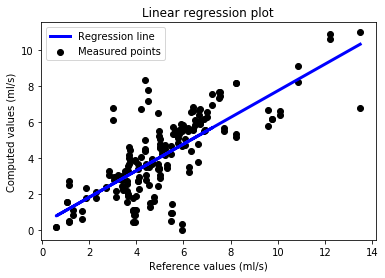

Checking that a destination path has been given

Saving figure as PNG in: /home/andres/Documents/_Results/NestedUNet2dTimeAutocontextSupervision_magBF/

Checking if folder exists

File already exists. Do you want to overwrite or rename or abort? [o/r/a]:o

Checking that result and reference are 1D and that they have the same length

Computing Bland-Altman plot



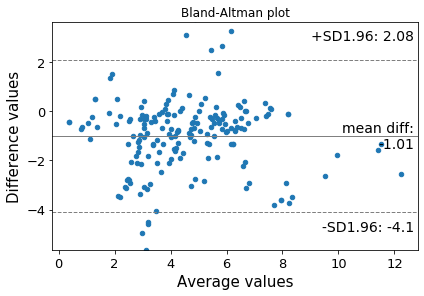

Checking that a destination path has been given

Saving figure as PNG in: /home/andres/Documents/_Results/NestedUNet2dTimeAutocontextSupervision_magBF/

Checking if folder exists

File already exists. Do you want to overwrite or rename or abort? [o/r/a]:o

Pearson Correlation Coefficient: 0.7546582572199478



In [18]:
import itertools

if not('_ckd1' in test_path):

    res = []

    ref = []

    mean_res = []

    rari_res = []

    max_res = []

    mean_ref = []

    max_ref = []

    rari_ref = []

    for r in results:

        res.append(r[0].tolist())

        ref.append(r[2].tolist())

        mean_res.append(np.mean(r[0]))

        mean_ref.append(np.mean(r[2]))

        max_res.append(np.max(r[0]))

        max_ref.append(np.max(r[2]))

        rari_res.append((np.max(r[0]) - np.min(r[0]))/np.max(r[0]))

        rari_ref.append((np.max(r[2]) - np.min(r[2]))/np.max(r[2]))


    mean_res = np.array(mean_res)

    rari_res = np.array(rari_res)

    max_res = np.array(max_res)

    mean_ref = np.array(mean_ref)

    max_ref = np.array(max_ref)

    rari_ref = np.array(rari_ref)

    res = np.array(list(itertools.chain.from_iterable(res)))

    ref = np.array(list(itertools.chain.from_iterable(ref)))
    
    statisticsResults(mean_res, mean_ref, 'all_means', dest_path) # Mean value comparison

    statisticsResults(res, ref, 'all_samples', dest_path) # All frames comparison
    
    #statisticsResults(rari_res, rari_ref, 'all_rari', dest_path) # RARI comparison
    
    statisticsResults(max_res, max_ref, 'all_max', dest_path) # Max value comparison

else:

    statisticsResults(results_array[:,0], results_array[:,1], 'ckd1', dest_path)

    
    
    
    

In [21]:
# Gather time information

time_path = '/home/andres/Documents/_Data/Time_info/'

time_files_file = 'time_info_files.txt'

time_values_file = 'time_info_times.txt'

time_files = np.loadtxt(time_path + time_files_file, dtype = str)

time_values = np.loadtxt(time_path + time_values_file)

for f in files:

    file_elements = f.split('_')

    if file_elements[0] == 'CKD2':

        file_to_look = file_elements[0] + '_' + file_elements[1] + '_' + file_elements[2] + '_' + file_elements[3] + '_' + file_elements[-2]

    elif file_elements[0] == 'Hero':

        file_elements[0] = 'hero'
        
        if 'venc' in file_elements[-2]:
            
            file_to_look = file_elements[0] + '_' + file_elements[1] + '_' + file_elements[-5] + '_' + file_elements[-3] + '_' + file_elements[-2]

        else:

            file_to_look = file_elements[0] + '_' + file_elements[1] + '_' + file_elements[-3] + '_' + file_elements[-2]

    elif file_elements[0] == 'Extr':

        file_elements[0] = 'extr'    

        file_to_look = file_elements[0] + '_' + file_elements[1] + '_' + file_elements[2] + '_' + file_elements[-4] + '_' + file_elements[-2]

    
    ind_file = np.where(time_files == file_to_look)
    
    time = time_values[ind_file][0]
    
    print(time)
    

25.794871794871796
25.794871794871796
25.71794871794872
25.71794871794872
27.256410256410255
27.256410256410255
27.23076923076923
27.23076923076923
18.666666666666668
18.666666666666668
18.76923076923077
18.76923076923077
17.76923076923077
17.76923076923077
17.435897435897434
17.435897435897434
22.871794871794872
22.871794871794872
22.923076923076923
22.923076923076923
20.0
23.0
18.0
18.0


In [2]:
print(test_path)

/home/andres/Documents/_Data/_Patients2D/_Pre_crop/
